# 2D 热控制系统仿真与加热器/恒温器位置优化

## 概述

本 Notebook 在二维空间域上求解热传导方程，研究加热器位置、恒温器位置、热源类型、边界条件和**房间几何形状**对控制性能的影响。

### 2D 模型

$$\frac{\partial T}{\partial t} = \alpha\left(\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2}\right) + u(t) \cdot f(x,y)$$

其中 $f(x,y)$ 为热源空间分布函数，$u(t) \in [0, U_{\max}]$ 由迟滞控制器决定。

### 房间几何

| 几何 | 域定义 | 面积 |
|------|--------|------|
| 正方形 (Square) | $[0,5]\times[0,5]$ m | 25 m$^2$ |
| 矩形 (Rectangle) | $[0,7.5]\times[0,2.5]$ m | 18.75 m$^2$ |
| L 形 (L-shape) | $[0,5]\times[0,5]$ 去掉右上角 $[2.5,5]\times[2.5,5]$ | 18.75 m$^2$ |

### 实验设计

- **实验 1-6**：正方形房间（基准几何）
- **实验 7-10**：几何对比与 L 形房间专题

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# 输出目录
import os
OUT_DIR = '2D_output'
os.makedirs(OUT_DIR, exist_ok=True)

# 全局绘图风格
sns.set_style('whitegrid')
plt.rcParams.update({
    'figure.dpi': 150,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
    'legend.fontsize': 9,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.bbox': 'tight',
    'savefig.dpi': 300
})

print('All imports successful.')

All imports successful.


## 参数定义

| 参数 | 符号 | 值 | 单位 |
|------|------|-----|------|
| 环境温度 | $T_a$ | 5 | $°$C |
| 设定温度 | $T_{set}$ | 20 | $°$C |
| 初始温度 | $T_{init}$ | 15 | $°$C |
| 热扩散率 | $\alpha$ | 0.01 | m$^2$/min |
| 壁面换热系数 | $h_{wall}$ | 0.5 | m$^{-1}$ |
| 最大加热功率 | $U_{max}$ | 5.0 | $°$C/min |
| 仿真时长 | $t_{end}$ | 60 | min |
| 迟滞带宽 | $\delta$ | 0.5 | $°$C |
| 高斯宽度 | $\sigma$ | 0.5 | m |

In [2]:
# ============================================================
# 系统参数
# ============================================================
T_A = 5.0          # 环境温度 (°C)
T_SET = 20.0       # 设定温度 (°C)
T_INIT = 15.0      # 初始温度 (°C)
ALPHA = 0.01       # 热扩散率 (m²/min)
H_WALL = 0.5       # 壁面换热系数 (m⁻¹)
U_MAX = 0.5        # 最大加热功率 (°C/min)
T_END = 120.0       # 仿真时长 (min)
DELTA = 2        # 迟滞带宽 (°C)
SIGMA_GAUSS = 1.0  # 高斯热源宽度 (m)

# PI 控制器参数
KP_DEFAULT = 2.0   # 比例增益
KI_DEFAULT = 0.1   # 积分增益

# 舒适区间
T_COMFORT_LOW = 18.0
T_COMFORT_HIGH = 26.0

# 约束优化阈值
CR_MIN = 0.8       # 舒适覆盖率硬约束

# 权重方案（保留用于对比）
WEIGHT_SCHEMES = {
    'Balanced': {'w_E': 0.15, 'w_R': 0.25, 'w_O': 0.15, 'w_C': 0.15, 'w_S': 0.15, 'w_T': 0.15},
    'Comfort':  {'w_E': 0.10, 'w_R': 0.25, 'w_O': 0.20, 'w_C': 0.20, 'w_S': 0.10, 'w_T': 0.15},
    'Energy':   {'w_E': 0.30, 'w_R': 0.20, 'w_O': 0.10, 'w_C': 0.10, 'w_S': 0.15, 'w_T': 0.15},
}

print('Parameters defined.')

Parameters defined.


## 几何定义与网格生成

为三种房间几何生成结构化网格。对于 L 形房间，使用矩形网格加遮罩（mask）的方式处理被移除区域。

**网格方案：**
- 标准网格：$dx = dy = 0.25$ m
- 粗网格（用于全枚举）：$dx = dy = 0.5$ m

In [3]:
# ============================================================
# 几何与网格定义
# ============================================================

# 几何参数
GEOMETRIES = {
    'square':    {'Lx': 5.0,  'Ly': 5.0,  'area': 25.0,    'label': 'Square 5x5'},
    'rectangle': {'Lx': 7.5,  'Ly': 2.5,  'area': 18.75,   'label': 'Rectangle 7.5x2.5'},
    'L-shape':   {'Lx': 5.0,  'Ly': 5.0,  'area': 18.75,   'label': 'L-shape'},
}


def create_grid(geometry='square', dx=0.25):
    """
    创建 2D 结构化网格。
    
    返回:
        x: 1D x 坐标数组
        y: 1D y 坐标数组
        mask: 2D bool 数组, True = 有效域内的点, shape (Ny, Nx)
        area: 域面积（精确几何面积，非网格近似）
    """
    geom = GEOMETRIES[geometry]
    Lx, Ly = geom['Lx'], geom['Ly']
    
    Nx = int(round(Lx / dx)) + 1
    Ny = int(round(Ly / dx)) + 1
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    
    # 创建遮罩
    mask = np.ones((Ny, Nx), dtype=bool)
    
    if geometry == 'L-shape':
        # 移除右上角 [2.5, 5] x [2.5, 5]
        for j in range(Ny):
            for i in range(Nx):
                if x[i] > 2.5 + 1e-10 and y[j] > 2.5 + 1e-10:
                    mask[j, i] = False
    
    # 使用精确几何面积（非节点数×dx²，后者有系统性高估）
    area = geom['area']
    
    return x, y, mask, area


def compute_quad_weights(mask, dx):
    """
    计算梯形求积权重矩阵。
    
    边界节点（任一方向缺少邻居）在该方向上权重减半。
    内部节点: dx², 单侧边界: dx²/2, 角点: dx²/4
    
    验证: 矩形域精确, L 形域误差 < 0.3% (dx=0.5)
    """
    Ny, Nx = mask.shape
    wx = np.ones((Ny, Nx))
    wy = np.ones((Ny, Nx))
    for j in range(Ny):
        for i in range(Nx):
            if not mask[j, i]:
                continue
            if (i == 0) or (not mask[j, i-1]) or (i == Nx-1) or (not mask[j, i+1]):
                wx[j, i] = 0.5
            if (j == 0) or (not mask[j-1, i]) or (j == Ny-1) or (not mask[j+1, i]):
                wy[j, i] = 0.5
    w = wx * wy * dx * dx
    w[~mask] = 0.0
    return w


def is_in_domain(px, py, geometry='square'):
    """检查点 (px, py) 是否在域内"""
    geom = GEOMETRIES[geometry]
    Lx, Ly = geom['Lx'], geom['Ly']
    if px < 0 or px > Lx or py < 0 or py > Ly:
        return False
    if geometry == 'L-shape':
        if px > 2.5 + 1e-10 and py > 2.5 + 1e-10:
            return False
    return True


def get_domain_sample_points(geometry='square', n_per_side=20, margin=0.3):
    """
    在域内均匀生成采样点（用于加热器/恒温器位置枚举）。
    与仿真 dx 解耦，可独立控制扫描分辨率。
    返回 (N, 2) 的坐标数组。
    """
    geom = GEOMETRIES[geometry]
    Lx, Ly = geom['Lx'], geom['Ly']
    
    xs = np.linspace(margin, Lx - margin, n_per_side)
    ys = np.linspace(margin, Ly - margin, n_per_side)
    
    points = []
    for yy in ys:
        for xx in xs:
            if is_in_domain(xx, yy, geometry):
                points.append((xx, yy))
    return np.array(points)


def get_grid_sample_points(geometry='square', dx=0.5, margin=0.3):
    """
    生成与 FD 网格对齐的采样点，避免网格取整导致的重复。
    只返回域内且在 [margin, L-margin] 内的网格点。
    注意: 仅在 point source 时需要网格对齐。Gaussian source 建议用 get_domain_sample_points。
    """
    x, y, mask, _ = create_grid(geometry, dx)
    geom = GEOMETRIES[geometry]
    Lx, Ly = geom['Lx'], geom['Ly']
    
    x_valid = x[(x >= margin - 1e-10) & (x <= Lx - margin + 1e-10)]
    y_valid = y[(y >= margin - 1e-10) & (y <= Ly - margin + 1e-10)]
    
    points = []
    for yy in y_valid:
        for xx in x_valid:
            if is_in_domain(xx, yy, geometry):
                points.append((xx, yy))
    return np.array(points)


def bilinear_interp(T, x, y, px, py):
    """
    在结构化网格上对温度场 T 做双线性插值，返回 (px, py) 处的值。
    T: shape (Ny, Nx)
    x, y: 1D 坐标数组
    """
    ix = np.searchsorted(x, px) - 1
    iy = np.searchsorted(y, py) - 1
    ix = np.clip(ix, 0, len(x) - 2)
    iy = np.clip(iy, 0, len(y) - 2)
    
    dx_local = x[ix+1] - x[ix]
    dy_local = y[iy+1] - y[iy]
    wx = (px - x[ix]) / dx_local if dx_local > 0 else 0.0
    wy = (py - y[iy]) / dy_local if dy_local > 0 else 0.0
    
    return (T[iy, ix] * (1-wx)*(1-wy) +
            T[iy, ix+1] * wx*(1-wy) +
            T[iy+1, ix] * (1-wx)*wy +
            T[iy+1, ix+1] * wx*wy)


def default_sensor_points(geometry='square', n=5):
    """
    生成域内均匀分布的默认传感器点。
    用于多传感器控制器。
    """
    return get_domain_sample_points(geometry, n_per_side=int(np.ceil(np.sqrt(n))),
                                     margin=0.8)


# 验证
for geo in ['square', 'rectangle', 'L-shape']:
    x, y, mask, area = create_grid(geo, dx=0.25)
    qw = compute_quad_weights(mask, 0.25)
    pts = get_domain_sample_points(geo, n_per_side=20)
    gpts = get_grid_sample_points(geo, dx=0.5, margin=0.3)
    spts = default_sensor_points(geo, n=5)
    print(f'{geo:12s}: grid {len(x)}x{len(y)}, '
          f'area={area:.2f} m² (exact), '
          f'Σw={np.sum(qw):.4f}, '
          f'scan(n=20)={len(pts)}, grid_aligned={len(gpts)}, sensors={len(spts)}')

square      : grid 21x21, area=25.00 m² (exact), Σw=25.0000, scan(n=20)=400, grid_aligned=81, sensors=9
rectangle   : grid 31x11, area=18.75 m² (exact), Σw=18.7500, scan(n=20)=400, grid_aligned=56, sensors=9
L-shape     : grid 21x21, area=18.75 m² (exact), Σw=18.7656, scan(n=20)=300, grid_aligned=65, sensors=8


## 2D PDE 求解器

使用 FTCS 显式有限差分格式求解二维热传导方程。

**边界条件处理（Ghost Point 方法）：**
- Neumann: $\partial T / \partial n = 0$（绝热）
- Robin: $\partial T / \partial n = -h_{wall}(T - T_a)$（对流换热）

**L 形房间特殊处理：**
- 被移除区域的节点温度始终保持为 NaN
- L 形内凹边界根据 BC 类型施加 Neumann 或 Robin 条件

**稳定性条件：** $r = \alpha \cdot dt / dx^2 \leq 0.25$（2D 要求更严格）

In [4]:
# ============================================================
# 2D 热传导方程求解器（向量化版本 v3）
# 修正: 精确面积 + 梯形求积权重 + 加权空间统计量
# 支持: 多传感器平均 + 双线性插值 + PI/迟滞控制
# ============================================================

def simulate_2d(x_h, y_h, x_s, y_s,
                geometry='square', bc_type='RNNN',
                source_type='gauss', sigma=SIGMA_GAUSS,
                dx=0.25, dt=None,
                T_a=T_A, T_set=T_SET, T_init=T_INIT,
                alpha=ALPHA, h_wall=H_WALL, U_max=U_MAX,
                t_end=T_END, delta=DELTA,
                controller='hysteresis',
                sensor_points=None,
                Kp=KP_DEFAULT, Ki=KI_DEFAULT,
                return_field=False, field_save_times=None,
                monitor_mask=None):
    """
    2D 热传导方程求解器（向量化 FTCS）。
    
    控制器:
        controller='hysteresis': 迟滞 bang-bang 控制（默认）
        controller='PI': 比例-积分连续控制
    
    传感器:
        sensor_points=None: 使用单点 (x_s, y_s)
        sensor_points=[(x1,y1), ...]: 多点平均，全部用双线性插值
    
    监测区域:
        monitor_mask: 可选 (Ny,Nx) bool 数组，记录该区域均温时序
    """
    # 生成网格（area 现在是精确几何面积）
    x, y, mask, area = create_grid(geometry, dx)
    Nx, Ny = len(x), len(y)
    
    # 梯形求积权重（用于空间统计和热源积分）
    quad_w = compute_quad_weights(mask, dx)
    w_valid = quad_w[mask]
    w_sum = np.sum(w_valid)
    
    # 自动选择 dt
    if dt is None:
        r_target = 0.2
        dt = r_target * dx**2 / alpha
    r = alpha * dt / dx**2
    
    N_t = int(t_end / dt) + 1
    t_arr = np.linspace(0, t_end, N_t)
    
    # --- 热源分布 ---
    f_src = np.zeros((Ny, Nx))
    if source_type == 'point':
        j_h = np.argmin(np.abs(x - x_h))
        i_h = np.argmin(np.abs(y - y_h))
        if mask[i_h, j_h]:
            f_src[i_h, j_h] = area / (dx * dx)
    else:
        XX, YY = np.meshgrid(x, y)
        g = np.exp(-0.5 * (((XX - x_h)**2 + (YY - y_h)**2) / sigma**2))
        g[~mask] = 0.0
        g_int = np.sum(g * quad_w)  # 梯形求积（非 naive sum*dx²）
        if g_int > 1e-12:
            f_src = g * area / g_int
        f_src[~mask] = 0.0
    
    # --- 传感器设置（双线性插值）---
    if sensor_points is None:
        sensor_coords = [(x_s, y_s)]
    else:
        sensor_coords = list(sensor_points)
    
    # 预计算每个传感器的双线性插值权重
    sensor_interp_info = []
    for sx, sy in sensor_coords:
        ix = np.searchsorted(x, sx) - 1
        iy = np.searchsorted(y, sy) - 1
        ix = int(np.clip(ix, 0, Nx - 2))
        iy = int(np.clip(iy, 0, Ny - 2))
        dx_loc = x[ix+1] - x[ix]
        dy_loc = y[iy+1] - y[iy]
        wx = (sx - x[ix]) / dx_loc if dx_loc > 0 else 0.0
        wy = (sy - y[iy]) / dy_loc if dy_loc > 0 else 0.0
        sensor_interp_info.append((iy, ix, wy, wx))
    
    def read_sensors(T):
        """多传感器双线性插值平均"""
        vals = []
        for iy_, ix_, wy_, wx_ in sensor_interp_info:
            v = (T[iy_, ix_] * (1-wx_)*(1-wy_) +
                 T[iy_, ix_+1] * wx_*(1-wy_) +
                 T[iy_+1, ix_] * (1-wx_)*wy_ +
                 T[iy_+1, ix_+1] * wx_*wy_)
            vals.append(v)
        return np.mean(vals)
    
    # BC 类型解析
    bc = bc_type.replace('L-', '')
    bc_top    = 'R' if bc == 'RRRR' else 'N'
    bc_left   = 'R' if bc == 'RRRR' else 'N'
    bc_right  = 'R' if bc == 'RRRR' else 'N'
    bc_internal = 'R' if bc == 'RRRR' else 'N'
    
    # --- 预计算邻居系数矩阵（向量化核心）---
    is_robin = np.zeros((Ny, Nx, 4), dtype=bool)
    is_neumann = np.zeros((Ny, Nx, 4), dtype=bool)
    has_neighbor = np.zeros((Ny, Nx, 4), dtype=bool)
    
    for j in range(Ny):
        for i in range(Nx):
            if not mask[j, i]:
                continue
            if i == 0:
                if bc_left == 'R': is_robin[j,i,0] = True
                else: is_neumann[j,i,0] = True
            elif not mask[j, i-1]:
                if bc_internal == 'R': is_robin[j,i,0] = True
                else: is_neumann[j,i,0] = True
            else:
                has_neighbor[j,i,0] = True
            if i == Nx-1:
                if bc_right == 'R': is_robin[j,i,1] = True
                else: is_neumann[j,i,1] = True
            elif not mask[j, i+1]:
                if bc_internal == 'R': is_robin[j,i,1] = True
                else: is_neumann[j,i,1] = True
            else:
                has_neighbor[j,i,1] = True
            if j == 0:
                is_robin[j,i,2] = True
            elif not mask[j-1, i]:
                if bc_internal == 'R': is_robin[j,i,2] = True
                else: is_neumann[j,i,2] = True
            else:
                has_neighbor[j,i,2] = True
            if j == Ny-1:
                if bc_top == 'R': is_robin[j,i,3] = True
                else: is_neumann[j,i,3] = True
            elif not mask[j+1, i]:
                if bc_internal == 'R': is_robin[j,i,3] = True
                else: is_neumann[j,i,3] = True
            else:
                has_neighbor[j,i,3] = True
    
    n_robin = np.sum(is_robin, axis=2)
    n_neumann = np.sum(is_neumann, axis=2)
    coeff_self_total = n_neumann + n_robin * (1.0 - dx * h_wall) - 4.0
    const_term = n_robin * dx * h_wall * T_a
    
    # 初始化
    T_cur = np.full((Ny, Nx), T_init, dtype=np.float64)
    T_cur[~mask] = 0.0
    
    # 记录数组
    u_rec = np.zeros(N_t)
    T_sensor_rec = np.zeros(N_t)
    T_mean_rec = np.zeros(N_t)
    CR_t_rec = np.zeros(N_t)
    error_sq_mean_rec = np.zeros(N_t)
    max_overshoot_rec = np.zeros(N_t)
    max_abs_error_rec = np.zeros(N_t)
    spatial_std_rec = np.zeros(N_t)
    
    # 监测区域
    if monitor_mask is not None:
        T_region_mean_rec = np.zeros(N_t)
        region_valid = monitor_mask & mask
        rw = quad_w[region_valid]
        rw_sum = np.sum(rw)
    else:
        T_region_mean_rec = None
    
    if return_field:
        if field_save_times is None:
            field_save_times = [0, 15, 30, 45, 60]
        saved_fields = {}
        T_save = T_cur.copy(); T_save[~mask] = np.nan
        if 0 in field_save_times:
            saved_fields[0.0] = T_save
    
    # 控制器状态
    heater_on = True
    integral_e = 0.0  # PI 积分项
    
    # --- 辅助: 加权空间统计量 ---
    def record_stats(T, idx):
        T_valid = T[mask]
        T_sensor_rec[idx] = read_sensors(T)
        T_mean_rec[idx] = np.dot(T_valid, w_valid) / w_sum
        in_comfort = (T_valid >= T_COMFORT_LOW) & (T_valid <= T_COMFORT_HIGH)
        CR_t_rec[idx] = np.dot(in_comfort.astype(np.float64), w_valid) / w_sum
        error_sq_mean_rec[idx] = np.dot((T_valid - T_set)**2, w_valid) / w_sum
        max_overshoot_rec[idx] = np.max(T_valid - T_set)
        max_abs_error_rec[idx] = np.max(np.abs(T_valid - T_set))
        mean_val = T_mean_rec[idx]
        spatial_std_rec[idx] = np.sqrt(np.dot((T_valid - mean_val)**2, w_valid) / w_sum)
        if T_region_mean_rec is not None:
            rv = T[region_valid]
            T_region_mean_rec[idx] = np.dot(rv, rw) / rw_sum if len(rv) > 0 else np.nan
    
    # 记录初始状态
    record_stats(T_cur, 0)
    
    # --- 时间推进（向量化）---
    for n in range(N_t - 1):
        T_read = read_sensors(T_cur)
        
        if controller == 'PI':
            e = T_set - T_read
            integral_e += e * dt
            # Anti-windup: 限制积分项
            integral_e = np.clip(integral_e, -U_max / max(Ki, 1e-8),
                                  U_max / max(Ki, 1e-8))
            u_val = np.clip(Kp * e + Ki * integral_e, 0.0, U_max)
        else:
            if heater_on and T_read >= T_set + delta:
                heater_on = False
            elif not heater_on and T_read <= T_set - delta:
                heater_on = True
            u_val = U_max if heater_on else 0.0
        
        u_rec[n] = u_val
        
        # 向量化 FTCS
        T_left  = np.zeros_like(T_cur)
        T_right = np.zeros_like(T_cur)
        T_down  = np.zeros_like(T_cur)
        T_up    = np.zeros_like(T_cur)
        
        T_left[:, 1:]  = T_cur[:, :-1]
        T_right[:, :-1] = T_cur[:, 1:]
        T_down[1:, :]  = T_cur[:-1, :]
        T_up[:-1, :]   = T_cur[1:, :]
        
        neighbor_sum = (has_neighbor[:,:,0] * T_left +
                       has_neighbor[:,:,1] * T_right +
                       has_neighbor[:,:,2] * T_down +
                       has_neighbor[:,:,3] * T_up)
        
        T_new = T_cur + r * (neighbor_sum + coeff_self_total * T_cur + const_term) + dt * u_val * f_src
        T_cur = np.where(mask, T_new, 0.0)
        
        # 记录统计量
        record_stats(T_cur, n + 1)
        
        if return_field:
            current_time = t_arr[n+1]
            for st in field_save_times:
                if abs(current_time - st) < dt/2 and st not in saved_fields:
                    T_save = T_cur.copy(); T_save[~mask] = np.nan
                    saved_fields[st] = T_save
    
    u_rec[-1] = u_val
    
    T_final = T_cur.copy()
    T_final[~mask] = np.nan
    
    result = {
        't': t_arr, 'x': x, 'y': y, 'mask': mask, 'dx': dx,
        'T_final': T_final,
        'T_sensor': T_sensor_rec, 'u': u_rec,
        'T_mean': T_mean_rec, 'CR_t': CR_t_rec,
        'error_sq_mean': error_sq_mean_rec,
        'max_overshoot': max_overshoot_rec,
        'max_abs_error': max_abs_error_rec,
        'spatial_std': spatial_std_rec,
        'area': area,
        'geometry': geometry, 'bc_type': bc_type,
        'controller': controller,
    }
    if return_field:
        result['saved_fields'] = saved_fields
    if T_region_mean_rec is not None:
        result['T_region_mean'] = T_region_mean_rec
    return result

print('2D solver v3 defined (exact area + quad weights + weighted stats).')
print(f'Square dx=0.25: dt={0.2*0.25**2/ALPHA:.3f} min, '
      f'N_t={int(T_END/(0.2*0.25**2/ALPHA))+1}')
print(f'Square dx=0.5:  dt={0.2*0.5**2/ALPHA:.3f} min, '
      f'N_t={int(T_END/(0.2*0.5**2/ALPHA))+1}')

2D solver v3 defined (exact area + quad weights + weighted stats).
Square dx=0.25: dt=1.250 min, N_t=97
Square dx=0.5:  dt=5.000 min, N_t=25


### 求解器验证

运行一个简单的测试用例，确保求解器工作正常。

网格: 21x21
时间步数: 97
dt: 1.2500 min
终态均温: 20.74 °C
终态传感器: 22.80 °C
保存的场快照: [0.0, 15, 30, 45, 60]


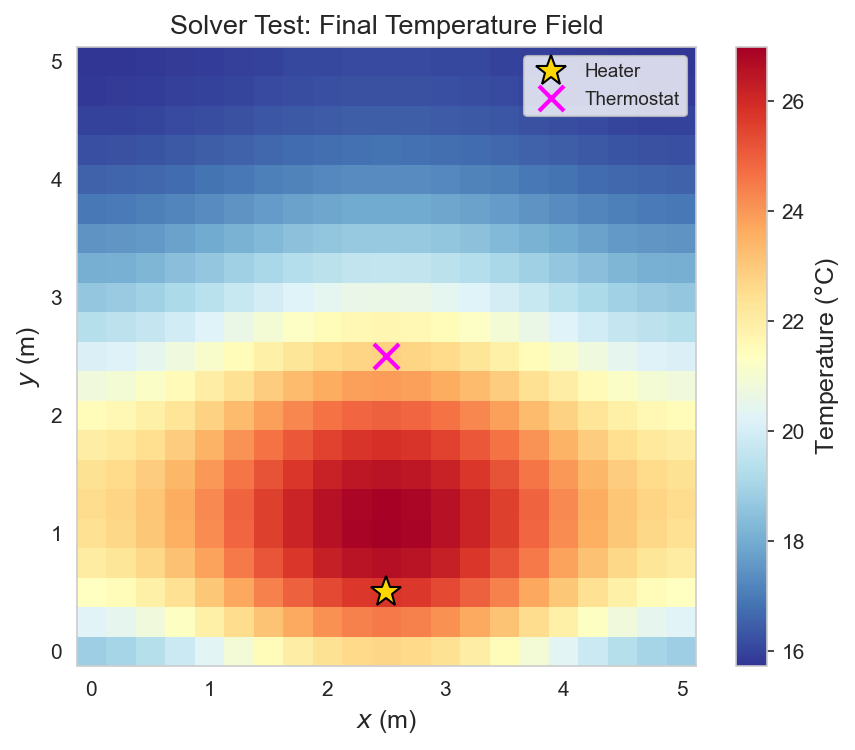

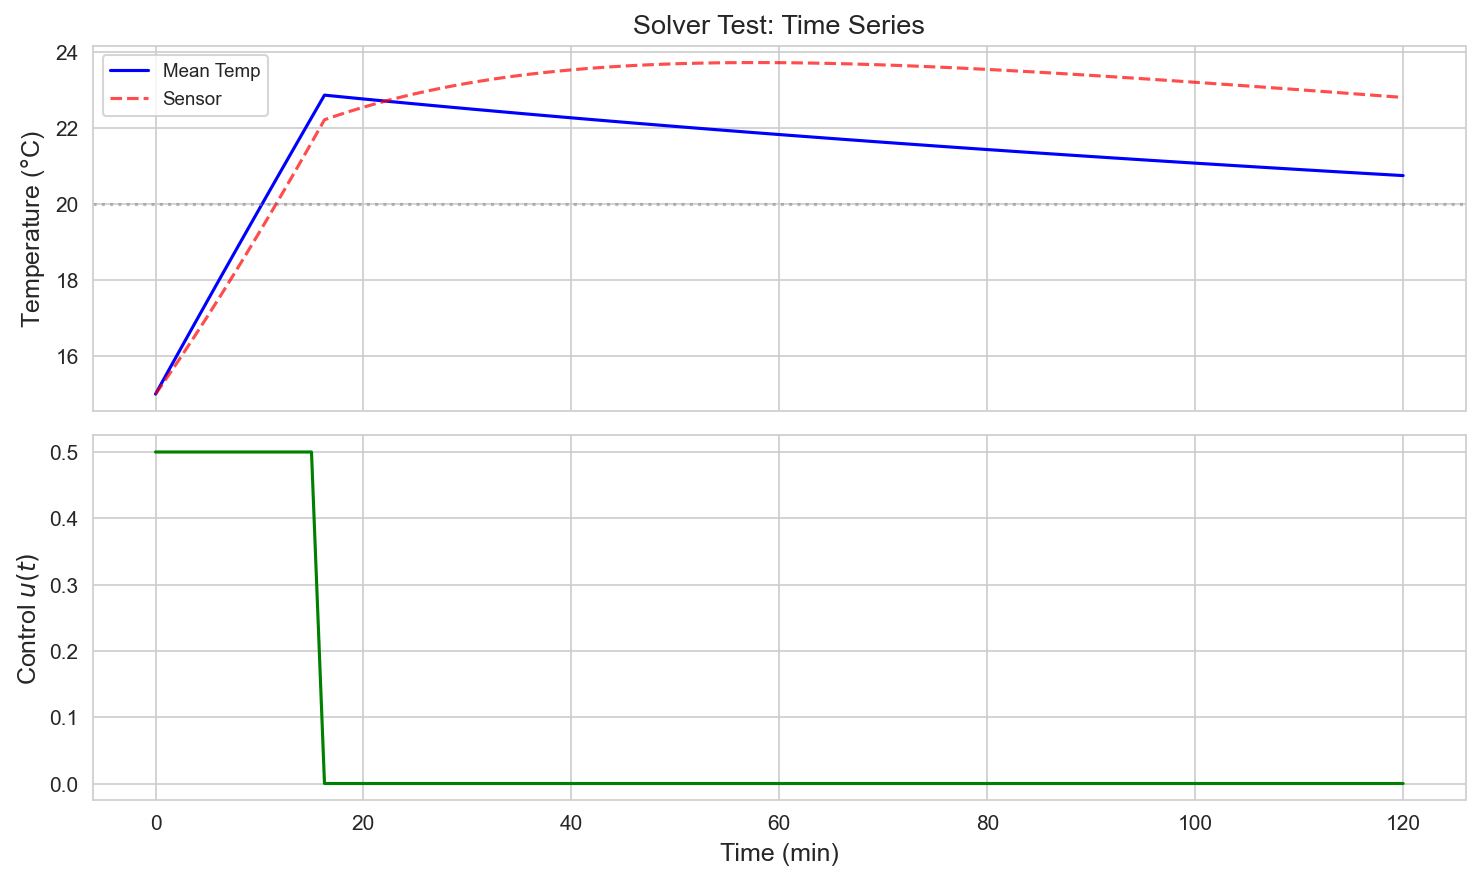

Solver verification complete.


In [5]:
# ============================================================
# 求解器快速验证
# ============================================================

# 使用粗网格快速测试
sim_test = simulate_2d(
    x_h=2.5, y_h=0.5, x_s=2.5, y_s=2.5,
    geometry='square', bc_type='RNNN',
    source_type='gauss', dx=0.25,
    return_field=True
)

print(f'网格: {len(sim_test["x"])}x{len(sim_test["y"])}')
print(f'时间步数: {len(sim_test["t"])}')
print(f'dt: {sim_test["t"][1]-sim_test["t"][0]:.4f} min')
print(f'终态均温: {sim_test["T_mean"][-1]:.2f} °C')
print(f'终态传感器: {sim_test["T_sensor"][-1]:.2f} °C')
print(f'保存的场快照: {sorted(sim_test["saved_fields"].keys())}')

# 绘制终态温度场
fig, ax = plt.subplots(figsize=(6, 5))
T_plot = sim_test['T_final'].copy()
T_plot[~sim_test['mask']] = np.nan
im = ax.pcolormesh(sim_test['x'], sim_test['y'], T_plot,
                   cmap='RdYlBu_r', shading='auto')
plt.colorbar(im, ax=ax, label='Temperature ($°$C)')
ax.plot(2.5, 0.5, '*', color='gold', markersize=15, markeredgecolor='k',
        label='Heater')
ax.plot(2.5, 2.5, 'x', color='magenta', markersize=12, markeredgewidth=2,
        label='Thermostat')
ax.set_xlabel('$x$ (m)')
ax.set_ylabel('$y$ (m)')
ax.set_title('Solver Test: Final Temperature Field')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

# 均温时间曲线
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax1.plot(sim_test['t'], sim_test['T_mean'], 'b-', label='Mean Temp')
ax1.plot(sim_test['t'], sim_test['T_sensor'], 'r--', alpha=0.7, label='Sensor')
ax1.axhline(T_SET, color='gray', linestyle=':', alpha=0.5)
ax1.set_ylabel('Temperature ($°$C)')
ax1.legend()
ax1.set_title('Solver Test: Time Series')

ax2.plot(sim_test['t'], sim_test['u'], 'g-')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Control $u(t)$')
plt.tight_layout()
plt.show()

print('Solver verification complete.')

L-shape 网格: 21x21
有效点数: 341
面积: 18.75 m²
终态均温: 17.59 °C


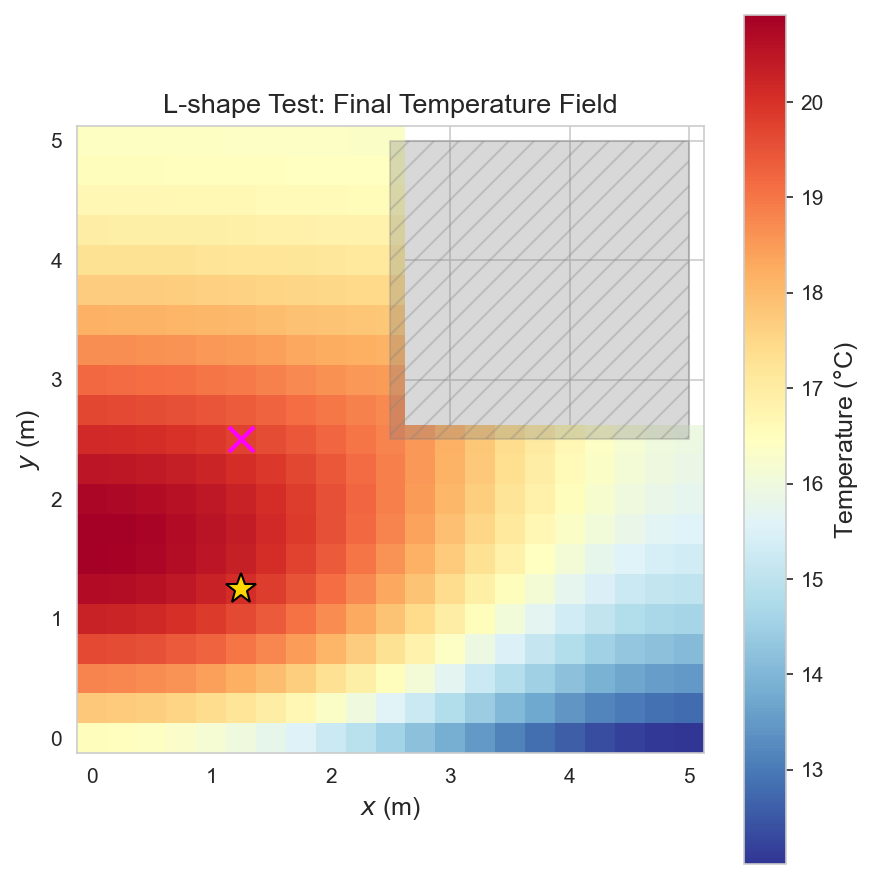

L-shape solver verification complete.


In [6]:
# ============================================================
# L 形求解器验证
# ============================================================

sim_L = simulate_2d(
    x_h=1.25, y_h=1.25, x_s=1.25, y_s=2.5,
    geometry='L-shape', bc_type='L-RNNN',
    source_type='gauss', dx=0.25,
    return_field=True
)

print(f'L-shape 网格: {len(sim_L["x"])}x{len(sim_L["y"])}')
print(f'有效点数: {np.sum(sim_L["mask"])}')
print(f'面积: {sim_L["area"]:.2f} m²')
print(f'终态均温: {sim_L["T_mean"][-1]:.2f} °C')

# 绘制 L 形终态温度场
fig, ax = plt.subplots(figsize=(6, 6))
T_plot = sim_L['T_final'].copy()
T_plot[~sim_L['mask']] = np.nan
im = ax.pcolormesh(sim_L['x'], sim_L['y'], T_plot,
                   cmap='RdYlBu_r', shading='auto')
plt.colorbar(im, ax=ax, label='Temperature ($°$C)')
ax.plot(1.25, 1.25, '*', color='gold', markersize=15, markeredgecolor='k')
ax.plot(1.25, 2.5, 'x', color='magenta', markersize=12, markeredgewidth=2)
# 标注移除区域
ax.fill_between([2.5, 5], 2.5, 5, alpha=0.3, color='gray', hatch='//')
ax.set_xlabel('$x$ (m)')
ax.set_ylabel('$y$ (m)')
ax.set_title('L-shape Test: Final Temperature Field')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

print('L-shape solver verification complete.')

## 评价指标与统一代价函数

与 0D/1D 一致的 6 项评价指标，适配 2D 空间域。

In [7]:
# ============================================================
# 评价指标计算（2D 版本 v2）
# 新增: 约束优化代价函数 + 修复 t_s 定义
# ============================================================

def compute_metrics_2d(sim, T_set=T_SET, t_end=T_END, U_max=U_MAX, tol=0.5):
    """
    从 2D 仿真结果计算 7 个评价指标。
    """
    t = sim['t']
    u = sim['u']
    
    # 1. 能耗
    E = np.trapz(u, t)
    
    # 2. RMSE（时空平均）
    RMSE = np.sqrt(np.trapz(sim['error_sq_mean'], t) / t_end)
    
    # 3. 最大超调
    DeltaT_max = max(0.0, np.max(sim['max_overshoot']))
    
    # 4. 舒适覆盖率
    CR = np.trapz(sim['CR_t'], t) / t_end
    
    # 5. 稳定时间（修复：基于均温而非全域最大误差）
    mean_error = np.abs(sim['T_mean'] - T_set)
    in_band = mean_error <= tol
    t_s = t_end
    for i in range(len(in_band)):
        if np.all(in_band[i:]):
            t_s = t[i]
            break
    
    # 6. 切换次数
    on_off = (u > 0.01 * U_max).astype(int)
    N_sw = int(np.sum(np.abs(np.diff(on_off))))
    
    # 7. 空间不均匀度
    U_spatial = np.trapz(sim['spatial_std'], t) / t_end
    
    return {'E': E, 'RMSE': RMSE, 'DeltaT_max': DeltaT_max,
            'CR': CR, 't_s': t_s, 'N_sw': N_sw, 'U_spatial': U_spatial}


def compute_unified_cost(metrics, ref_maxes, weights=None, t_end=T_END):
    """加权和代价函数（保留用于对比）"""
    if weights is None:
        weights = WEIGHT_SCHEMES['Balanced']
    
    E_hat = metrics['E'] / ref_maxes['E'] if ref_maxes['E'] > 0 else 0
    RMSE_hat = metrics['RMSE'] / ref_maxes['RMSE'] if ref_maxes['RMSE'] > 0 else 0
    DT_hat = metrics['DeltaT_max'] / ref_maxes['DeltaT_max'] if ref_maxes['DeltaT_max'] > 0 else 0
    CR_cost = 1.0 - metrics['CR']
    Nsw_hat = metrics['N_sw'] / ref_maxes['N_sw'] if ref_maxes['N_sw'] > 0 else 0
    ts_hat = min(metrics['t_s'], t_end) / t_end
    
    J = (weights['w_E'] * E_hat + weights['w_R'] * RMSE_hat +
         weights['w_O'] * DT_hat + weights['w_C'] * CR_cost +
         weights['w_S'] * Nsw_hat + weights['w_T'] * ts_hat)
    return J


def compute_constrained_cost(metrics, ref_maxes, cr_min=CR_MIN):
    """
    约束优化代价函数:
      若 CR < cr_min: 返回惩罚值 (10 + (cr_min - CR)*10)
      否则: 归一化 (E + RMSE + U_spatial)
    
    这确保优化器不会为了省电而牺牲舒适性。
    """
    if metrics['CR'] < cr_min:
        return 10.0 + (cr_min - metrics['CR']) * 10.0
    
    # 在可行域内，最小化能耗 + 跟踪误差 + 空间不均匀度
    E_hat = metrics['E'] / ref_maxes['E'] if ref_maxes['E'] > 0 else 0
    RMSE_hat = metrics['RMSE'] / ref_maxes['RMSE'] if ref_maxes['RMSE'] > 0 else 0
    U_hat = metrics['U_spatial'] / ref_maxes.get('U_spatial', 1.0) if ref_maxes.get('U_spatial', 1.0) > 0 else 0
    
    return (E_hat + RMSE_hat + U_hat) / 3.0


def compute_ref_maxes(all_metrics_list):
    """从一批 metrics 中提取各指标最大值"""
    ref = {}
    for key in ['E', 'RMSE', 'DeltaT_max', 'N_sw', 'U_spatial']:
        vals = [m[key] for m in all_metrics_list]
        ref[key] = max(vals) if max(vals) > 0 else 1.0
    return ref


# 验证指标计算
m_test = compute_metrics_2d(sim_test)
print('Test metrics:', {k: f'{v:.3f}' for k, v in m_test.items()})

Test metrics: {'E': '7.812', 'RMSE': '6.751', 'DeltaT_max': '36.144', 'CR': '0.378', 't_s': '120.000', 'N_sw': '1.000', 'U_spatial': '6.066'}


## 绘图辅助函数

通用的 2D 温度场、指标曲线等绘图工具。

In [8]:
# ============================================================
# 通用绘图辅助函数
# ============================================================

def plot_2d_field(T_field, x, y, mask, ax,
                  x_h=None, y_h=None, x_s=None, y_s=None,
                  cmap='RdYlBu_r', vmin=None, vmax=None,
                  title='', colorbar_label='Temperature ($°$C)',
                  geometry='square'):
    """在给定 axes 上绘制 2D 温度场"""
    T_plot = T_field.copy()
    T_plot[~mask] = np.nan
    
    im = ax.pcolormesh(x, y, T_plot, cmap=cmap, shading='auto',
                       vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, label=colorbar_label, shrink=0.8)
    
    # 标注加热器和恒温器
    if x_h is not None and y_h is not None:
        ax.plot(x_h, y_h, '*', color='gold', markersize=14,
                markeredgecolor='k', markeredgewidth=1, zorder=10)
    if x_s is not None and y_s is not None:
        ax.plot(x_s, y_s, 'x', color='magenta', markersize=11,
                markeredgewidth=2.5, zorder=10)
    
    # L 形遮罩区域
    if geometry == 'L-shape':
        ax.fill_between([2.5, 5], 2.5, 5, alpha=0.3, color='gray', hatch='//')
    
    ax.set_xlabel('$x$ (m)')
    ax.set_ylabel('$y$ (m)')
    ax.set_title(title)
    ax.set_aspect('equal')
    return im


def plot_metrics_vs_position(positions, metrics_list, var_name, var_label,
                             title_prefix='', save_path=None):
    """
    绘制 4 面板评价指标 vs 位置变量的折线图。
    positions: 位置数组
    metrics_list: 对应的 metrics 列表
    """
    fig, axes = plt.subplots(2, 2, figsize=(13, 9))
    fig.suptitle(f'{title_prefix}Performance Metrics vs {var_label}',
                 fontsize=14, fontweight='bold')
    
    panels = [
        ('E', 'Energy Consumption', 'Energy $E$', '#e67e22'),
        ('RMSE', 'RMSE', 'RMSE ($°$C)', '#3498db'),
        ('U_spatial', 'Spatial Non-uniformity', '$U_{spatial}$ ($°$C)', '#e74c3c'),
        ('N_sw', 'Heater Switches', '$N_{sw}$', '#9b59b6'),
    ]
    
    for ax, (key, title, ylabel, color) in zip(axes.flat, panels):
        vals = [m[key] for m in metrics_list]
        ax.plot(positions, vals, 'o-', color=color, linewidth=2, markersize=5)
        ax.set_xlabel(f'{var_label}')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        best_idx = np.argmin(vals)
        ax.scatter([positions[best_idx]], [vals[best_idx]], s=100,
                   marker='*', color=color, zorder=5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_mean_temp_overlay(sims_dict, save_path=None, title=''):
    """
    将多个仿真的均温时间曲线叠加到同一图上。
    sims_dict: {label: sim_result}
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True,
                                   gridspec_kw={'height_ratios': [2, 1]})
    
    colors = plt.cm.tab10(np.linspace(0, 1, min(len(sims_dict), 10)))
    
    for (label, sim), c in zip(sims_dict.items(), colors):
        ax1.plot(sim['t'], sim['T_mean'], color=c, linewidth=1.5,
                 label=label, alpha=0.8)
    
    ax1.axhline(T_SET, color='red', linestyle='--', linewidth=1, alpha=0.7,
                label='$T_{set}$')
    ax1.axhspan(T_SET - 0.5, T_SET + 0.5, alpha=0.08, color='green')
    ax1.set_ylabel('Mean Temperature ($°$C)')
    ax1.set_title(title if title else 'Room Mean Temperature $\\bar{T}(t)$')
    ax1.legend(fontsize=8, ncol=2)
    
    # 控制信号（只显示第一个）
    first_sim = list(sims_dict.values())[0]
    ax2.plot(first_sim['t'], first_sim['u'], 'g-', alpha=0.7)
    ax2.set_xlabel('Time (min)')
    ax2.set_ylabel('Control $u(t)$')
    ax2.set_title('Control Signal (first config shown)')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_J_heatmap(J_matrix, pos_x, pos_y, x_best, y_best,
                   ax, title='', xlabel='$x$ (m)', ylabel='$y$ (m)',
                   x_mark=None, y_mark=None,
                   geometry='square', cmap='RdYlGn_r'):
    """在给定 axes 上绘制 J 值 2D 热力图"""
    im = ax.imshow(J_matrix, origin='lower', aspect='auto',
                   extent=[pos_x[0], pos_x[-1], pos_y[0], pos_y[-1]],
                   cmap=cmap, interpolation='bilinear')
    plt.colorbar(im, ax=ax, label='$J$', shrink=0.8)
    
    # 最优位置
    ax.scatter(x_best, y_best, marker='*', s=300, color='gold',
              edgecolors='black', linewidth=1.5, zorder=10)
    
    # 固定标记（如恒温器位置）
    if x_mark is not None and y_mark is not None:
        ax.scatter(x_mark, y_mark, marker='x', s=150, color='magenta',
                  linewidth=2.5, zorder=10)
    
    # L 形遮罩
    if geometry == 'L-shape':
        ax.fill_between([2.5, 5], 2.5, 5, alpha=0.4, color='gray', hatch='//')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return im


print('Plotting utilities defined.')

Plotting utilities defined.


## 扫描与枚举辅助函数

封装加热器/恒温器位置扫描、2D 网格枚举等常用操作。

In [9]:
# ============================================================
# 位置扫描辅助函数（v3: 解耦扫描/仿真分辨率 + 梯形求积）
# ============================================================

def sweep_heater_1d(positions_xy, x_s, y_s,
                    geometry='square', bc_type='RNNN',
                    source_type='gauss', dx=0.25,
                    controller='hysteresis', sensor_points=None,
                    desc='Heater sweep'):
    """
    沿给定位置列表扫描加热器，恒温器固定。
    """
    sims = []
    metrics_list = []
    
    for x_h, y_h in tqdm(positions_xy, desc=desc):
        sim = simulate_2d(x_h, y_h, x_s, y_s,
                          geometry=geometry, bc_type=bc_type,
                          source_type=source_type, dx=dx,
                          controller=controller,
                          sensor_points=sensor_points)
        m = compute_metrics_2d(sim)
        sim_compact = {
            'T_final': sim['T_final'],
            'T_mean': sim['T_mean'],
            'T_sensor': sim['T_sensor'],
            'u': sim['u'],
            't': sim['t'],
            'x': sim['x'], 'y': sim['y'],
            'mask': sim['mask'],
            'spatial_std': sim['spatial_std'],
        }
        sims.append(sim_compact)
        metrics_list.append(m)
    
    ref = compute_ref_maxes(metrics_list)
    J_values = [compute_unified_cost(m, ref) for m in metrics_list]
    J_con = [compute_constrained_cost(m, ref) for m in metrics_list]
    
    return sims, metrics_list, np.array(J_values), ref, np.array(J_con)


def sweep_heater_2d_grid(x_s, y_s, geometry='square', bc_type='RNNN',
                          source_type='gauss', dx=0.25,
                          n_scan=20, margin=0.3,
                          controller='hysteresis',
                          sensor_points=None):
    """
    加热器位置 2D 扫描。
    扫描分辨率 (n_scan) 与仿真分辨率 (dx) 独立。
    n_scan: 每个方向的扫描点数（默认 20，约 400 个扫描点）
    """
    points = get_domain_sample_points(geometry, n_per_side=n_scan, margin=margin)
    print(f'Scanning {len(points)} heater positions '
          f'({geometry}, {bc_type}, {source_type}, ctrl={controller}, dx={dx}, n_scan={n_scan})')
    
    results = []
    for x_h, y_h in tqdm(points, desc='2D heater scan'):
        sim = simulate_2d(x_h, y_h, x_s, y_s,
                          geometry=geometry, bc_type=bc_type,
                          source_type=source_type, dx=dx,
                          controller=controller,
                          sensor_points=sensor_points)
        m = compute_metrics_2d(sim)
        results.append({'x_h': x_h, 'y_h': y_h, **m})
    
    df = pd.DataFrame(results)
    ref = compute_ref_maxes(results)
    df['J'] = df.apply(
        lambda r: compute_unified_cost(
            {k: r[k] for k in ['E','RMSE','DeltaT_max','CR','t_s','N_sw','U_spatial']},
            ref), axis=1)
    df['J_con'] = df.apply(
        lambda r: compute_constrained_cost(
            {k: r[k] for k in ['E','RMSE','DeltaT_max','CR','t_s','N_sw','U_spatial']},
            ref), axis=1)
    
    return df, ref


def sweep_thermostat_2d_grid(x_h, y_h, geometry='square', bc_type='RNNN',
                              source_type='gauss', dx=0.25,
                              n_scan=20, margin=0.3,
                              controller='hysteresis',
                              sensor_points=None):
    """
    恒温器位置 2D 扫描。
    扫描分辨率 (n_scan) 与仿真分辨率 (dx) 独立。
    """
    points = get_domain_sample_points(geometry, n_per_side=n_scan, margin=margin)
    print(f'Scanning {len(points)} thermostat positions '
          f'({geometry}, {bc_type}, {source_type}, ctrl={controller}, dx={dx}, n_scan={n_scan})')
    
    results = []
    for x_s, y_s in tqdm(points, desc='2D thermostat scan'):
        sim = simulate_2d(x_h, y_h, x_s, y_s,
                          geometry=geometry, bc_type=bc_type,
                          source_type=source_type, dx=dx,
                          controller=controller,
                          sensor_points=sensor_points)
        m = compute_metrics_2d(sim)
        sensor_bias = np.mean(np.abs(sim['T_sensor'] - sim['T_mean']))
        results.append({'x_s': x_s, 'y_s': y_s, **m, 'SensorBias': sensor_bias})
    
    df = pd.DataFrame(results)
    ref = compute_ref_maxes(results)
    df['J'] = df.apply(
        lambda r: compute_unified_cost(
            {k: r[k] for k in ['E','RMSE','DeltaT_max','CR','t_s','N_sw','U_spatial']},
            ref), axis=1)
    df['J_con'] = df.apply(
        lambda r: compute_constrained_cost(
            {k: r[k] for k in ['E','RMSE','DeltaT_max','CR','t_s','N_sw','U_spatial']},
            ref), axis=1)
    
    return df, ref


print('Sweep utilities v3 defined (decoupled scan/sim resolution).')
pts_test = get_domain_sample_points('square', n_per_side=20, margin=0.3)
print(f'  Square n_scan=20, margin=0.3: {len(pts_test)} scan points')
pts_L = get_domain_sample_points('L-shape', n_per_side=20, margin=0.3)
print(f'  L-shape n_scan=20, margin=0.3: {len(pts_L)} scan points')

Sweep utilities v3 defined (decoupled scan/sim resolution).
  Square n_scan=20, margin=0.3: 400 scan points
  L-shape n_scan=20, margin=0.3: 300 scan points


---

# 实验一：RNNN 下，恒温器固定在房间中心，变化加热器位置

BC = RNNN（底边 $y=0$ Robin 外墙，其余 Neumann 保温墙），恒温器固定在 $(2.5, 2.5)$。

**核心问题**：加热器放在房间哪个位置，综合评分最高？

| 编号 | 加热器扫描路径 | 物理含义 |
|------|---------------|----------|
| 1.1 | 底边 $y=0$（Robin 外墙） | 暖气片装在外墙下方 |
| 1.2 | 顶边 $y=L_2$（Neumann 保温墙） | 加热器在离外墙最远处 |
| 1.3 | 中线 $y=L_2/2$ | 独立式取暖器在房间中央 |
| 1.4 | 全房间 2D 网格扫描 | 全面枚举 |

=== 实验 1.1: 加热器沿底边 Robin 外墙扫描 ===


Exp 1.1 bottom wall:   0%|          | 0/9 [00:00<?, ?it/s]

最优: x_h=2.5m, y_h=0.25m, J=0.5978


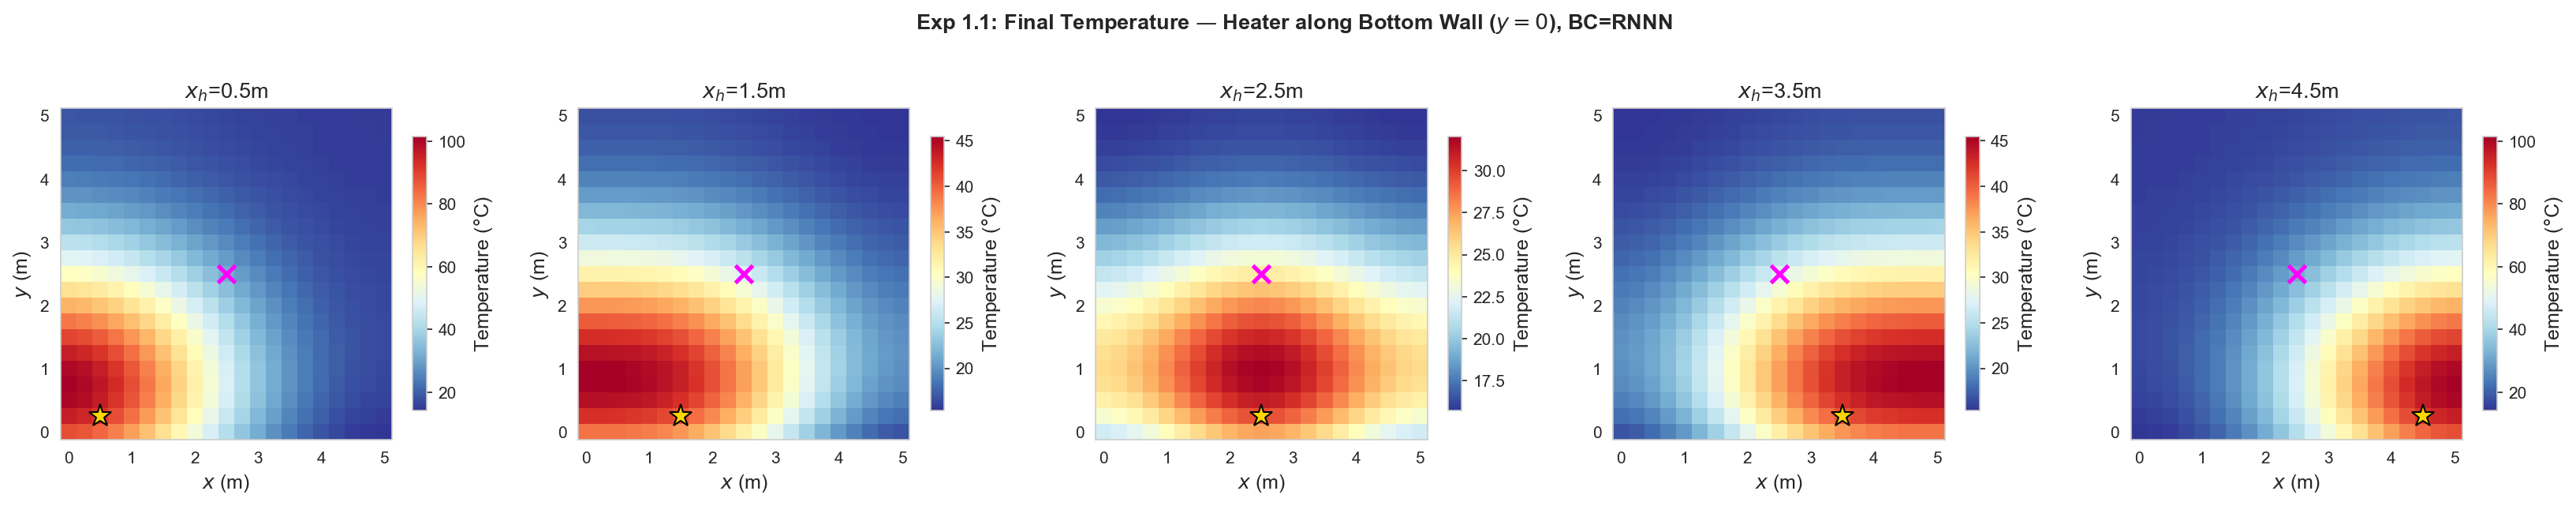

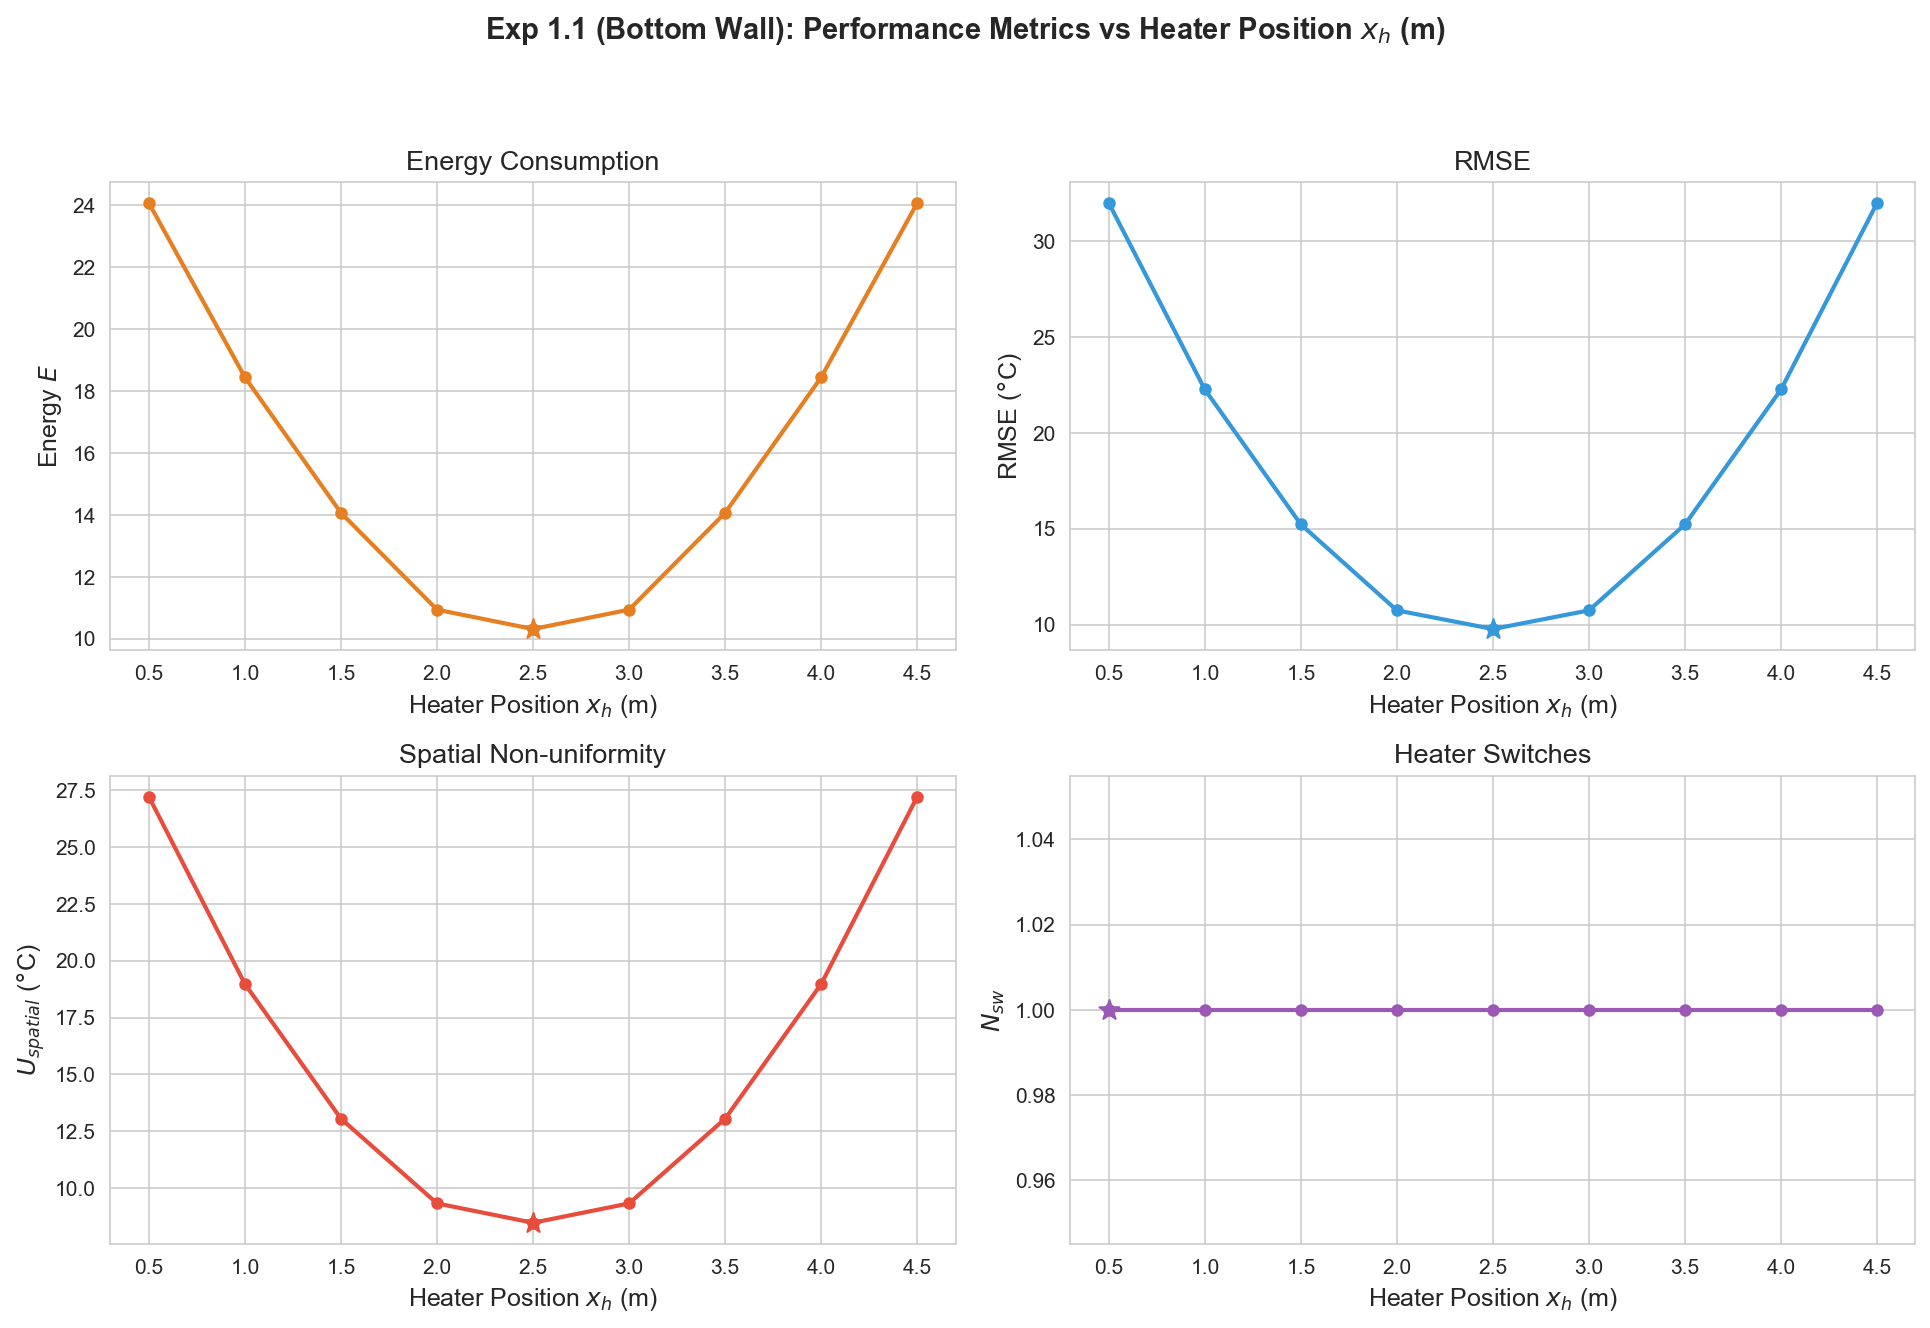

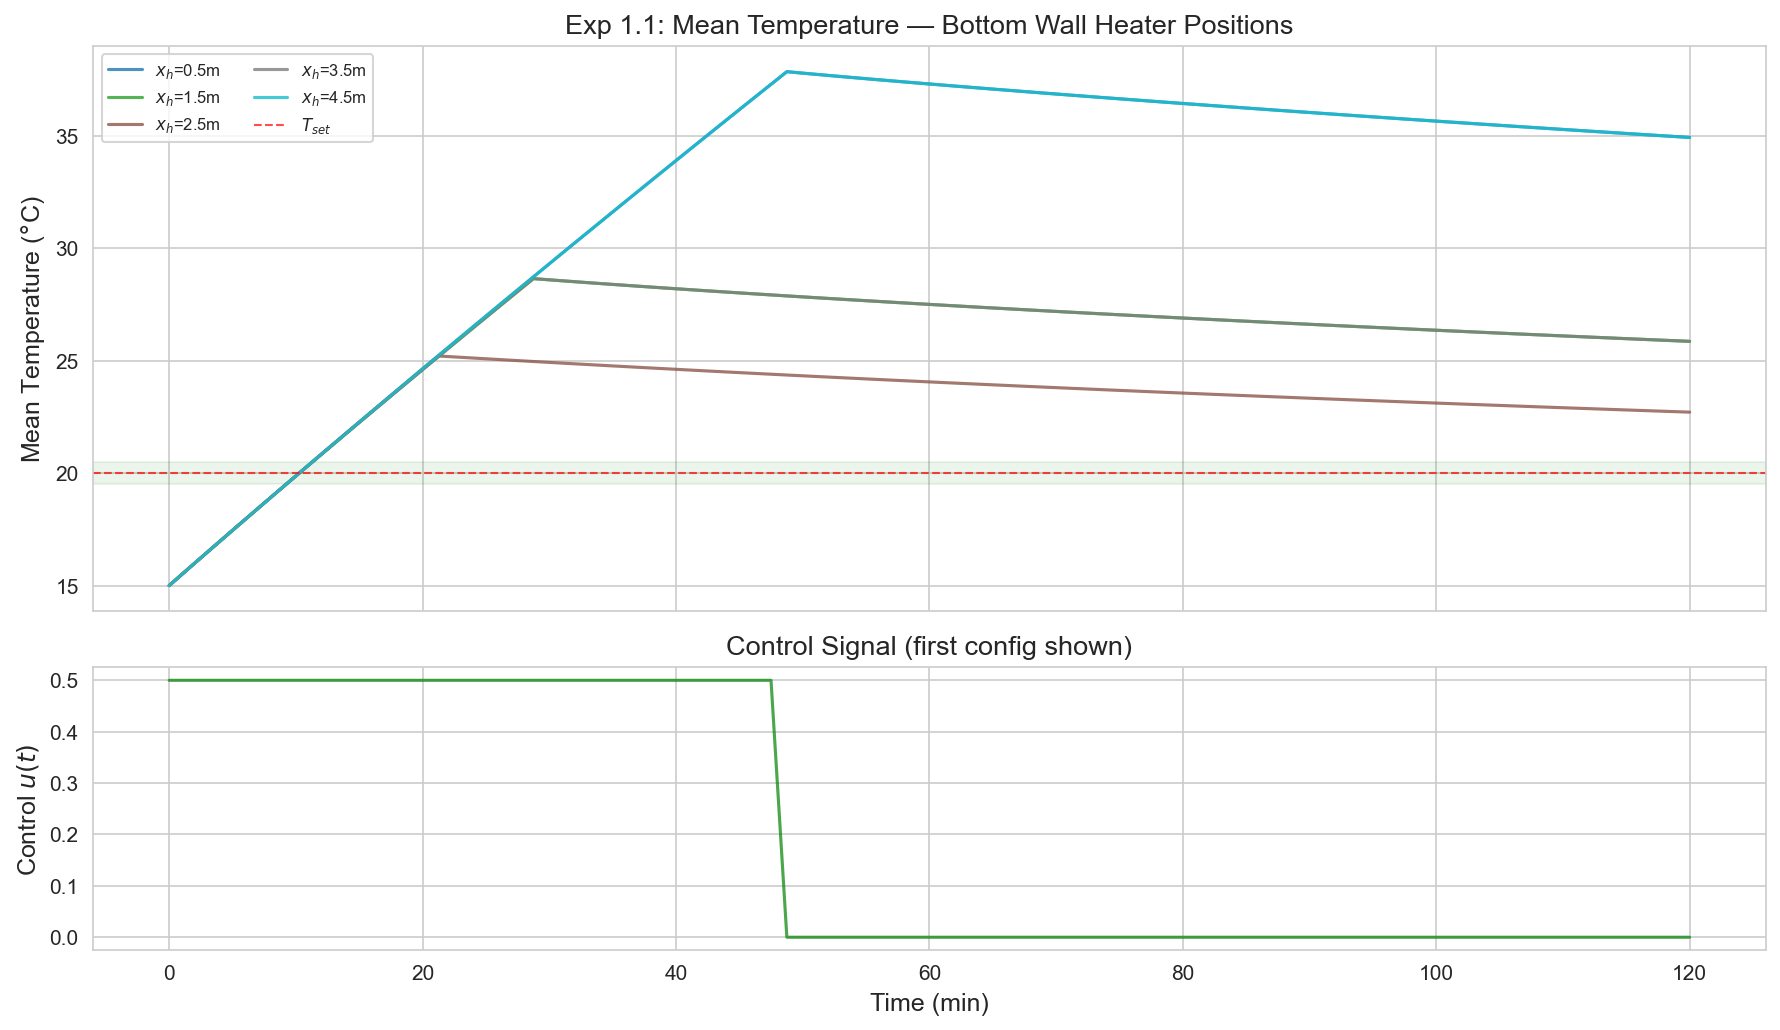

In [10]:
# ============================================================
# 实验 1.1: 加热器沿底边 y=0 扫描
# ============================================================

# 恒温器固定在房间中心
XS_FIX, YS_FIX = 2.5, 2.5

# 加热器沿底边 y=0.25 (避开边界)
x_positions_11 = np.linspace(0.5, 4.5, 9)
heater_positions_11 = [(xh, 0.25) for xh in x_positions_11]

print('=== 实验 1.1: 加热器沿底边 Robin 外墙扫描 ===')
sims_11, metrics_11, J_11, ref_11, _ = sweep_heater_1d(
    heater_positions_11, XS_FIX, YS_FIX,
    geometry='square', bc_type='RNNN', source_type='gauss', dx=0.25,
    desc='Exp 1.1 bottom wall'
)

# 最优位置
best_11 = np.argmin(J_11)
print(f'最优: x_h={x_positions_11[best_11]:.1f}m, y_h=0.25m, J={J_11[best_11]:.4f}')

# --- 终态温度场（5个代表位置）---
show_idx = [0, 2, 4, 6, 8]
fig, axes = plt.subplots(1, 5, figsize=(22, 4))
fig.suptitle('Exp 1.1: Final Temperature — Heater along Bottom Wall ($y=0$), BC=RNNN',
             fontsize=13, fontweight='bold')

for ax, idx in zip(axes, show_idx):
    xh = x_positions_11[idx]
    plot_2d_field(sims_11[idx]['T_final'], sims_11[idx]['x'], sims_11[idx]['y'],
                  sims_11[idx]['mask'], ax,
                  x_h=xh, y_h=0.25, x_s=XS_FIX, y_s=YS_FIX,
                  title=f'$x_h$={xh:.1f}m')

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(f'{OUT_DIR}/2D_exp1_1_fields.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 评价指标 vs 位置 ---
plot_metrics_vs_position(
    x_positions_11, metrics_11, 'x_h', 'Heater Position $x_h$ (m)',
    title_prefix='Exp 1.1 (Bottom Wall): ',
    save_path=f'{OUT_DIR}/2D_exp1_1_metrics.png'
)

# --- 均温时间曲线叠加 ---
sims_overlay_11 = {f'$x_h$={x_positions_11[i]:.1f}m': sims_11[i]
                    for i in show_idx}
plot_mean_temp_overlay(sims_overlay_11,
                       save_path=f'{OUT_DIR}/2D_exp1_1_meantemp.png',
                       title='Exp 1.1: Mean Temperature — Bottom Wall Heater Positions')

=== 实验 1.2: 加热器沿顶边 Neumann 保温墙扫描 ===


Exp 1.2 top wall:   0%|          | 0/9 [00:00<?, ?it/s]

最优: x_h=2.5m, y_h=4.75m, J=0.6081


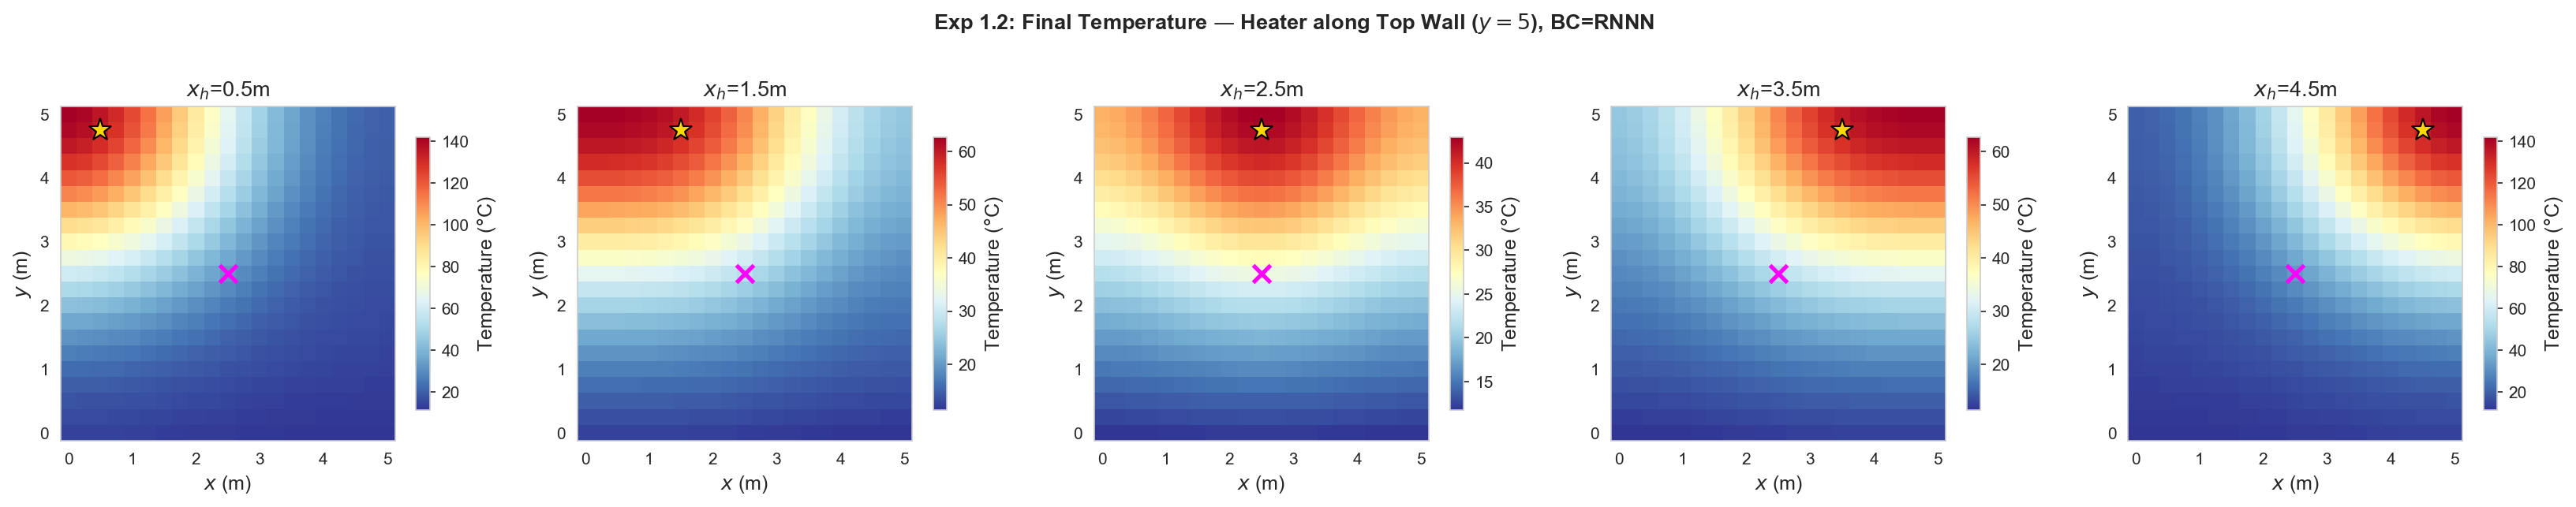

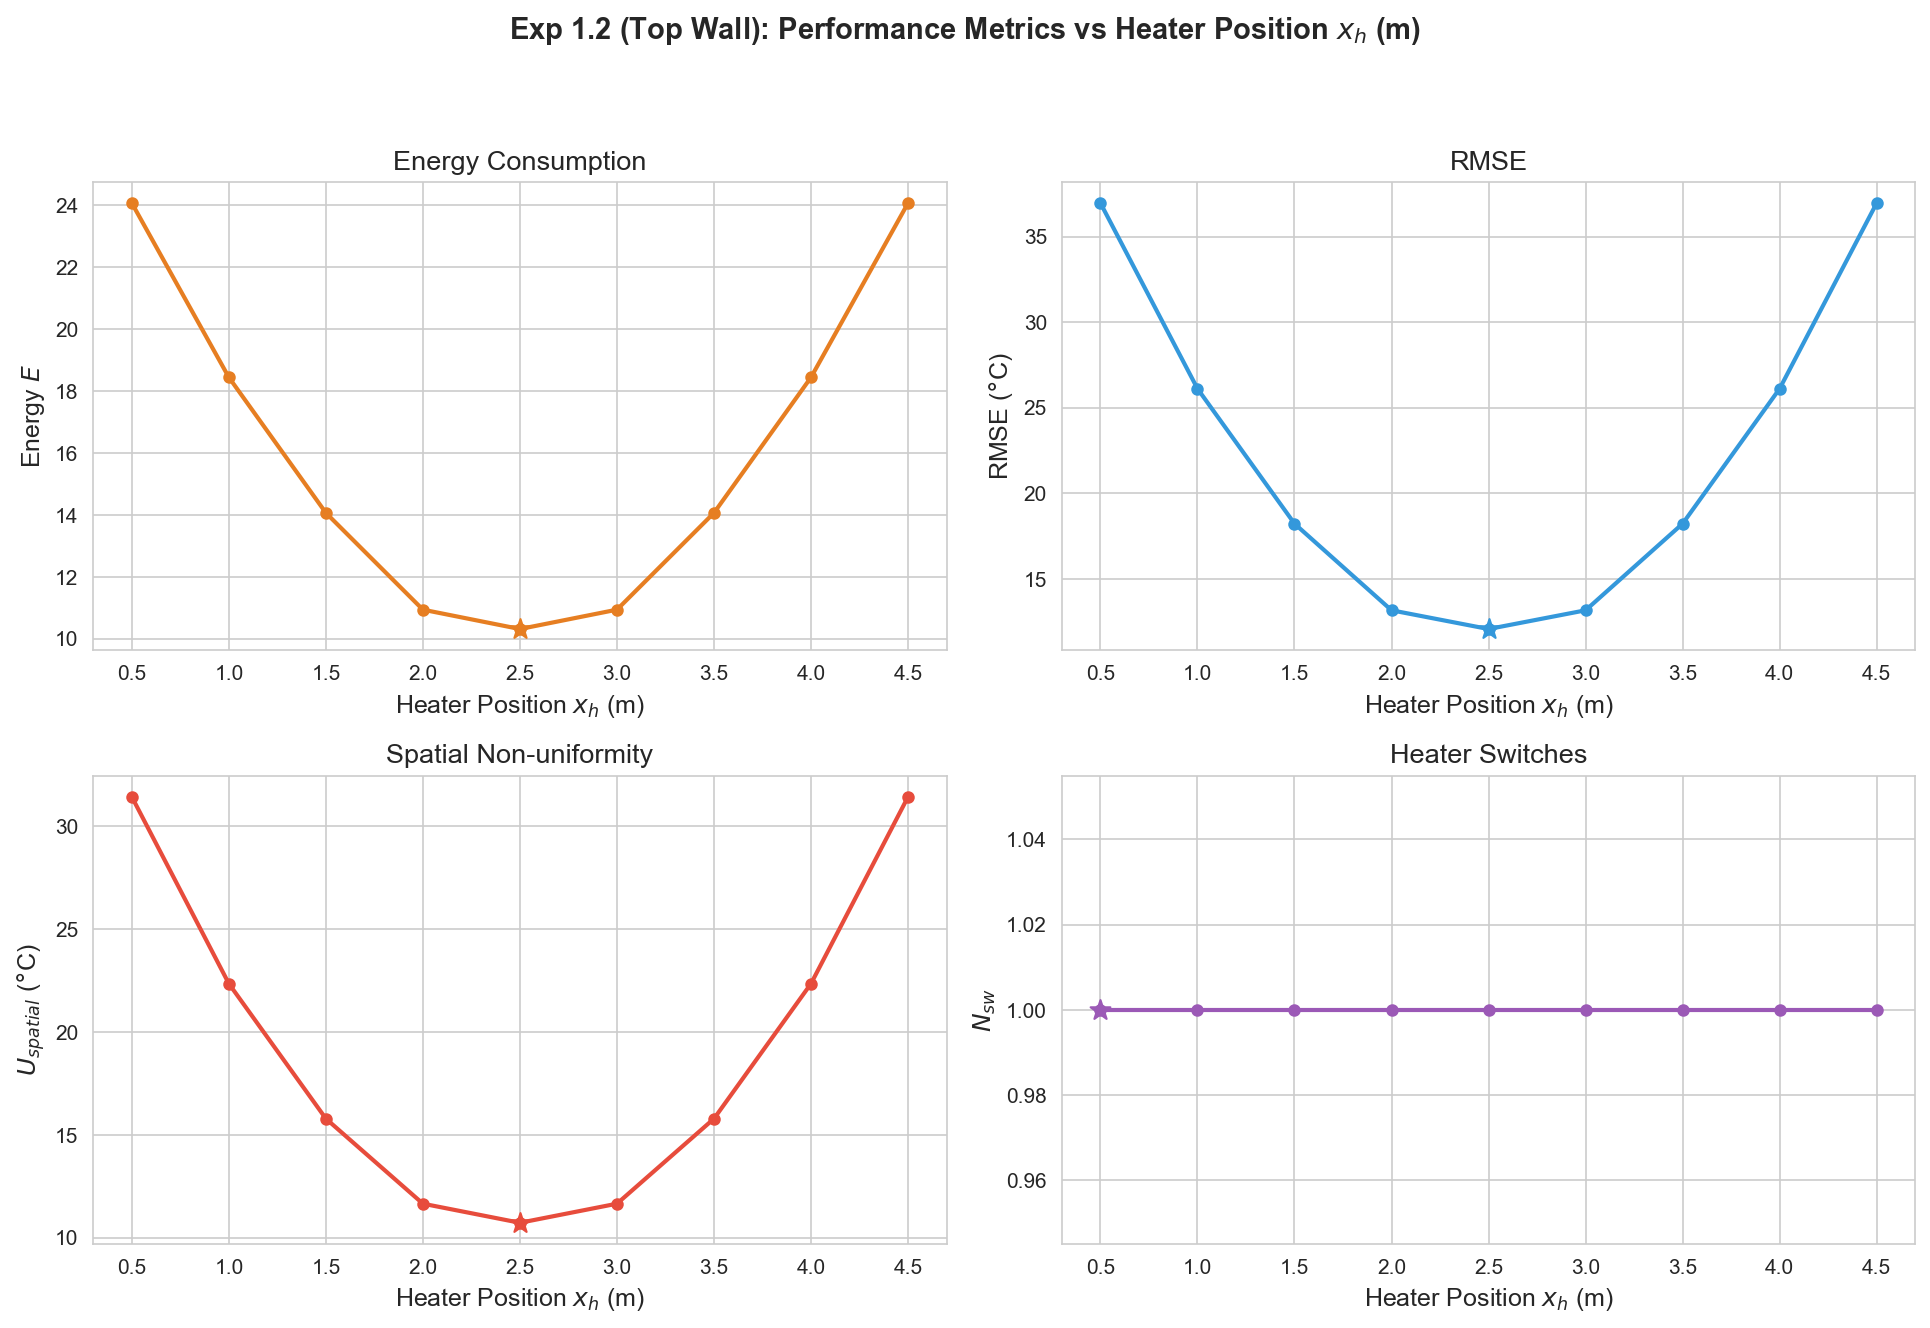

In [11]:
# ============================================================
# 实验 1.2: 加热器沿顶边 y=L 扫描
# ============================================================

x_positions_12 = np.linspace(0.5, 4.5, 9)
heater_positions_12 = [(xh, 4.75) for xh in x_positions_12]

print('=== 实验 1.2: 加热器沿顶边 Neumann 保温墙扫描 ===')
sims_12, metrics_12, J_12, ref_12, _ = sweep_heater_1d(
    heater_positions_12, XS_FIX, YS_FIX,
    geometry='square', bc_type='RNNN', source_type='gauss', dx=0.25,
    desc='Exp 1.2 top wall'
)

best_12 = np.argmin(J_12)
print(f'最优: x_h={x_positions_12[best_12]:.1f}m, y_h=4.75m, J={J_12[best_12]:.4f}')

# 终态温度场
fig, axes = plt.subplots(1, 5, figsize=(22, 4))
fig.suptitle('Exp 1.2: Final Temperature — Heater along Top Wall ($y=5$), BC=RNNN',
             fontsize=13, fontweight='bold')
for ax, idx in zip(axes, show_idx):
    xh = x_positions_12[idx]
    plot_2d_field(sims_12[idx]['T_final'], sims_12[idx]['x'], sims_12[idx]['y'],
                  sims_12[idx]['mask'], ax,
                  x_h=xh, y_h=4.75, x_s=XS_FIX, y_s=YS_FIX,
                  title=f'$x_h$={xh:.1f}m')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(f'{OUT_DIR}/2D_exp1_2_fields.png', dpi=300, bbox_inches='tight')
plt.show()

plot_metrics_vs_position(
    x_positions_12, metrics_12, 'x_h', 'Heater Position $x_h$ (m)',
    title_prefix='Exp 1.2 (Top Wall): ',
    save_path=f'{OUT_DIR}/2D_exp1_2_metrics.png'
)

=== 实验 1.3: 加热器沿中线 y=2.5 扫描 ===


Exp 1.3 midline:   0%|          | 0/9 [00:00<?, ?it/s]

最优: x_h=1.5m, y_h=2.5m, J=0.4843


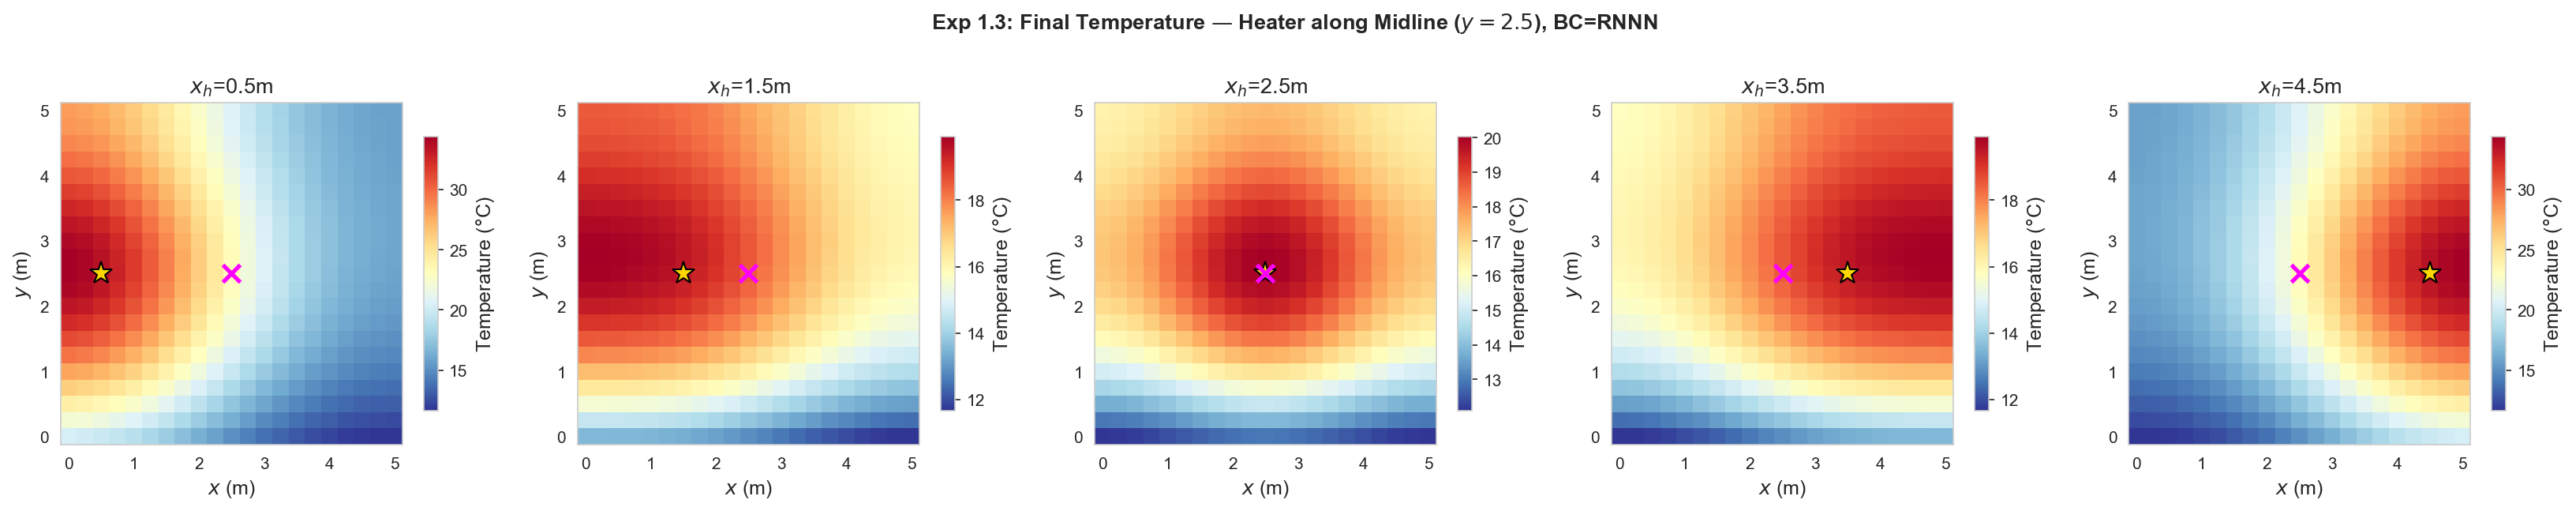

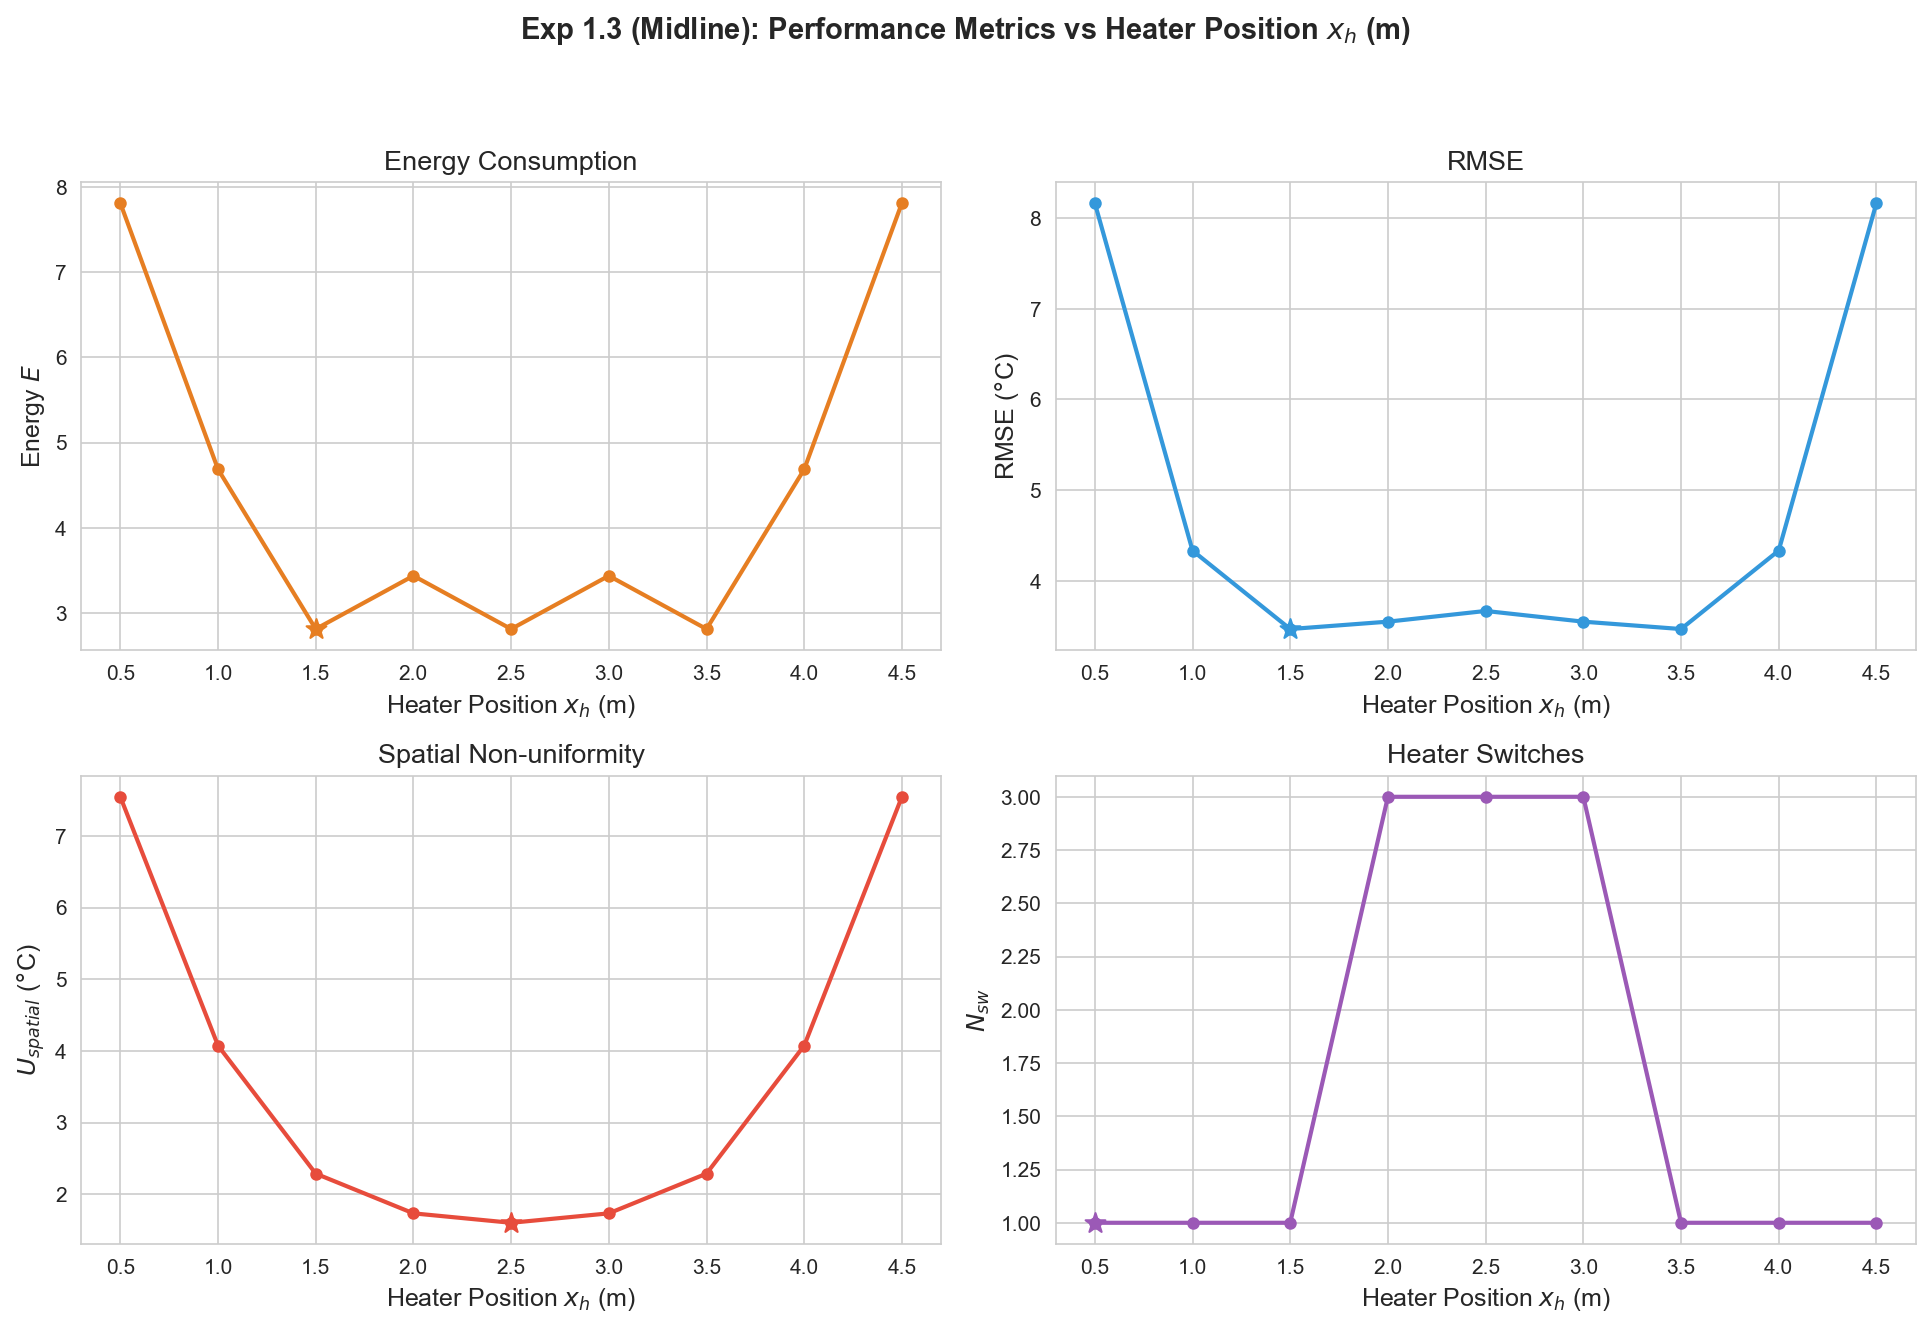

In [12]:
# ============================================================
# 实验 1.3: 加热器沿中线 y=L/2 扫描
# ============================================================

x_positions_13 = np.linspace(0.5, 4.5, 9)
heater_positions_13 = [(xh, 2.5) for xh in x_positions_13]

print('=== 实验 1.3: 加热器沿中线 y=2.5 扫描 ===')
sims_13, metrics_13, J_13, ref_13, _ = sweep_heater_1d(
    heater_positions_13, XS_FIX, YS_FIX,
    geometry='square', bc_type='RNNN', source_type='gauss', dx=0.25,
    desc='Exp 1.3 midline'
)

best_13 = np.argmin(J_13)
print(f'最优: x_h={x_positions_13[best_13]:.1f}m, y_h=2.5m, J={J_13[best_13]:.4f}')

fig, axes = plt.subplots(1, 5, figsize=(22, 4))
fig.suptitle('Exp 1.3: Final Temperature — Heater along Midline ($y=2.5$), BC=RNNN',
             fontsize=13, fontweight='bold')
for ax, idx in zip(axes, show_idx):
    xh = x_positions_13[idx]
    plot_2d_field(sims_13[idx]['T_final'], sims_13[idx]['x'], sims_13[idx]['y'],
                  sims_13[idx]['mask'], ax,
                  x_h=xh, y_h=2.5, x_s=XS_FIX, y_s=YS_FIX,
                  title=f'$x_h$={xh:.1f}m')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(f'{OUT_DIR}/2D_exp1_3_fields.png', dpi=300, bbox_inches='tight')
plt.show()

plot_metrics_vs_position(
    x_positions_13, metrics_13, 'x_h', 'Heater Position $x_h$ (m)',
    title_prefix='Exp 1.3 (Midline): ',
    save_path=f'{OUT_DIR}/2D_exp1_3_metrics.png'
)

## 实验 1.4：加热器全房间 2D 网格扫描

在整个正方形房间内，以 $10 \times 10$ 网格扫描加热器位置（恒温器固定在房间中心）。输出 $J$、$E$、RMSE、$U_{spatial}$ 四张热力图。

=== 实验 1.4a: Square, BC=NRRR ===
Scanning 400 heater positions (square, NRRR, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D heater scan:   0%|          | 0/400 [00:00<?, ?it/s]

最优加热器位置: (1.92, 4.01), J=0.2361
=== 实验 1.4b: L-shape, BC=L-RRRR ===
Scanning 300 heater positions (L-shape, L-RRRR, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D heater scan:   0%|          | 0/300 [00:00<?, ?it/s]

最优加热器位置: (1.46, 1.23), J=0.3589


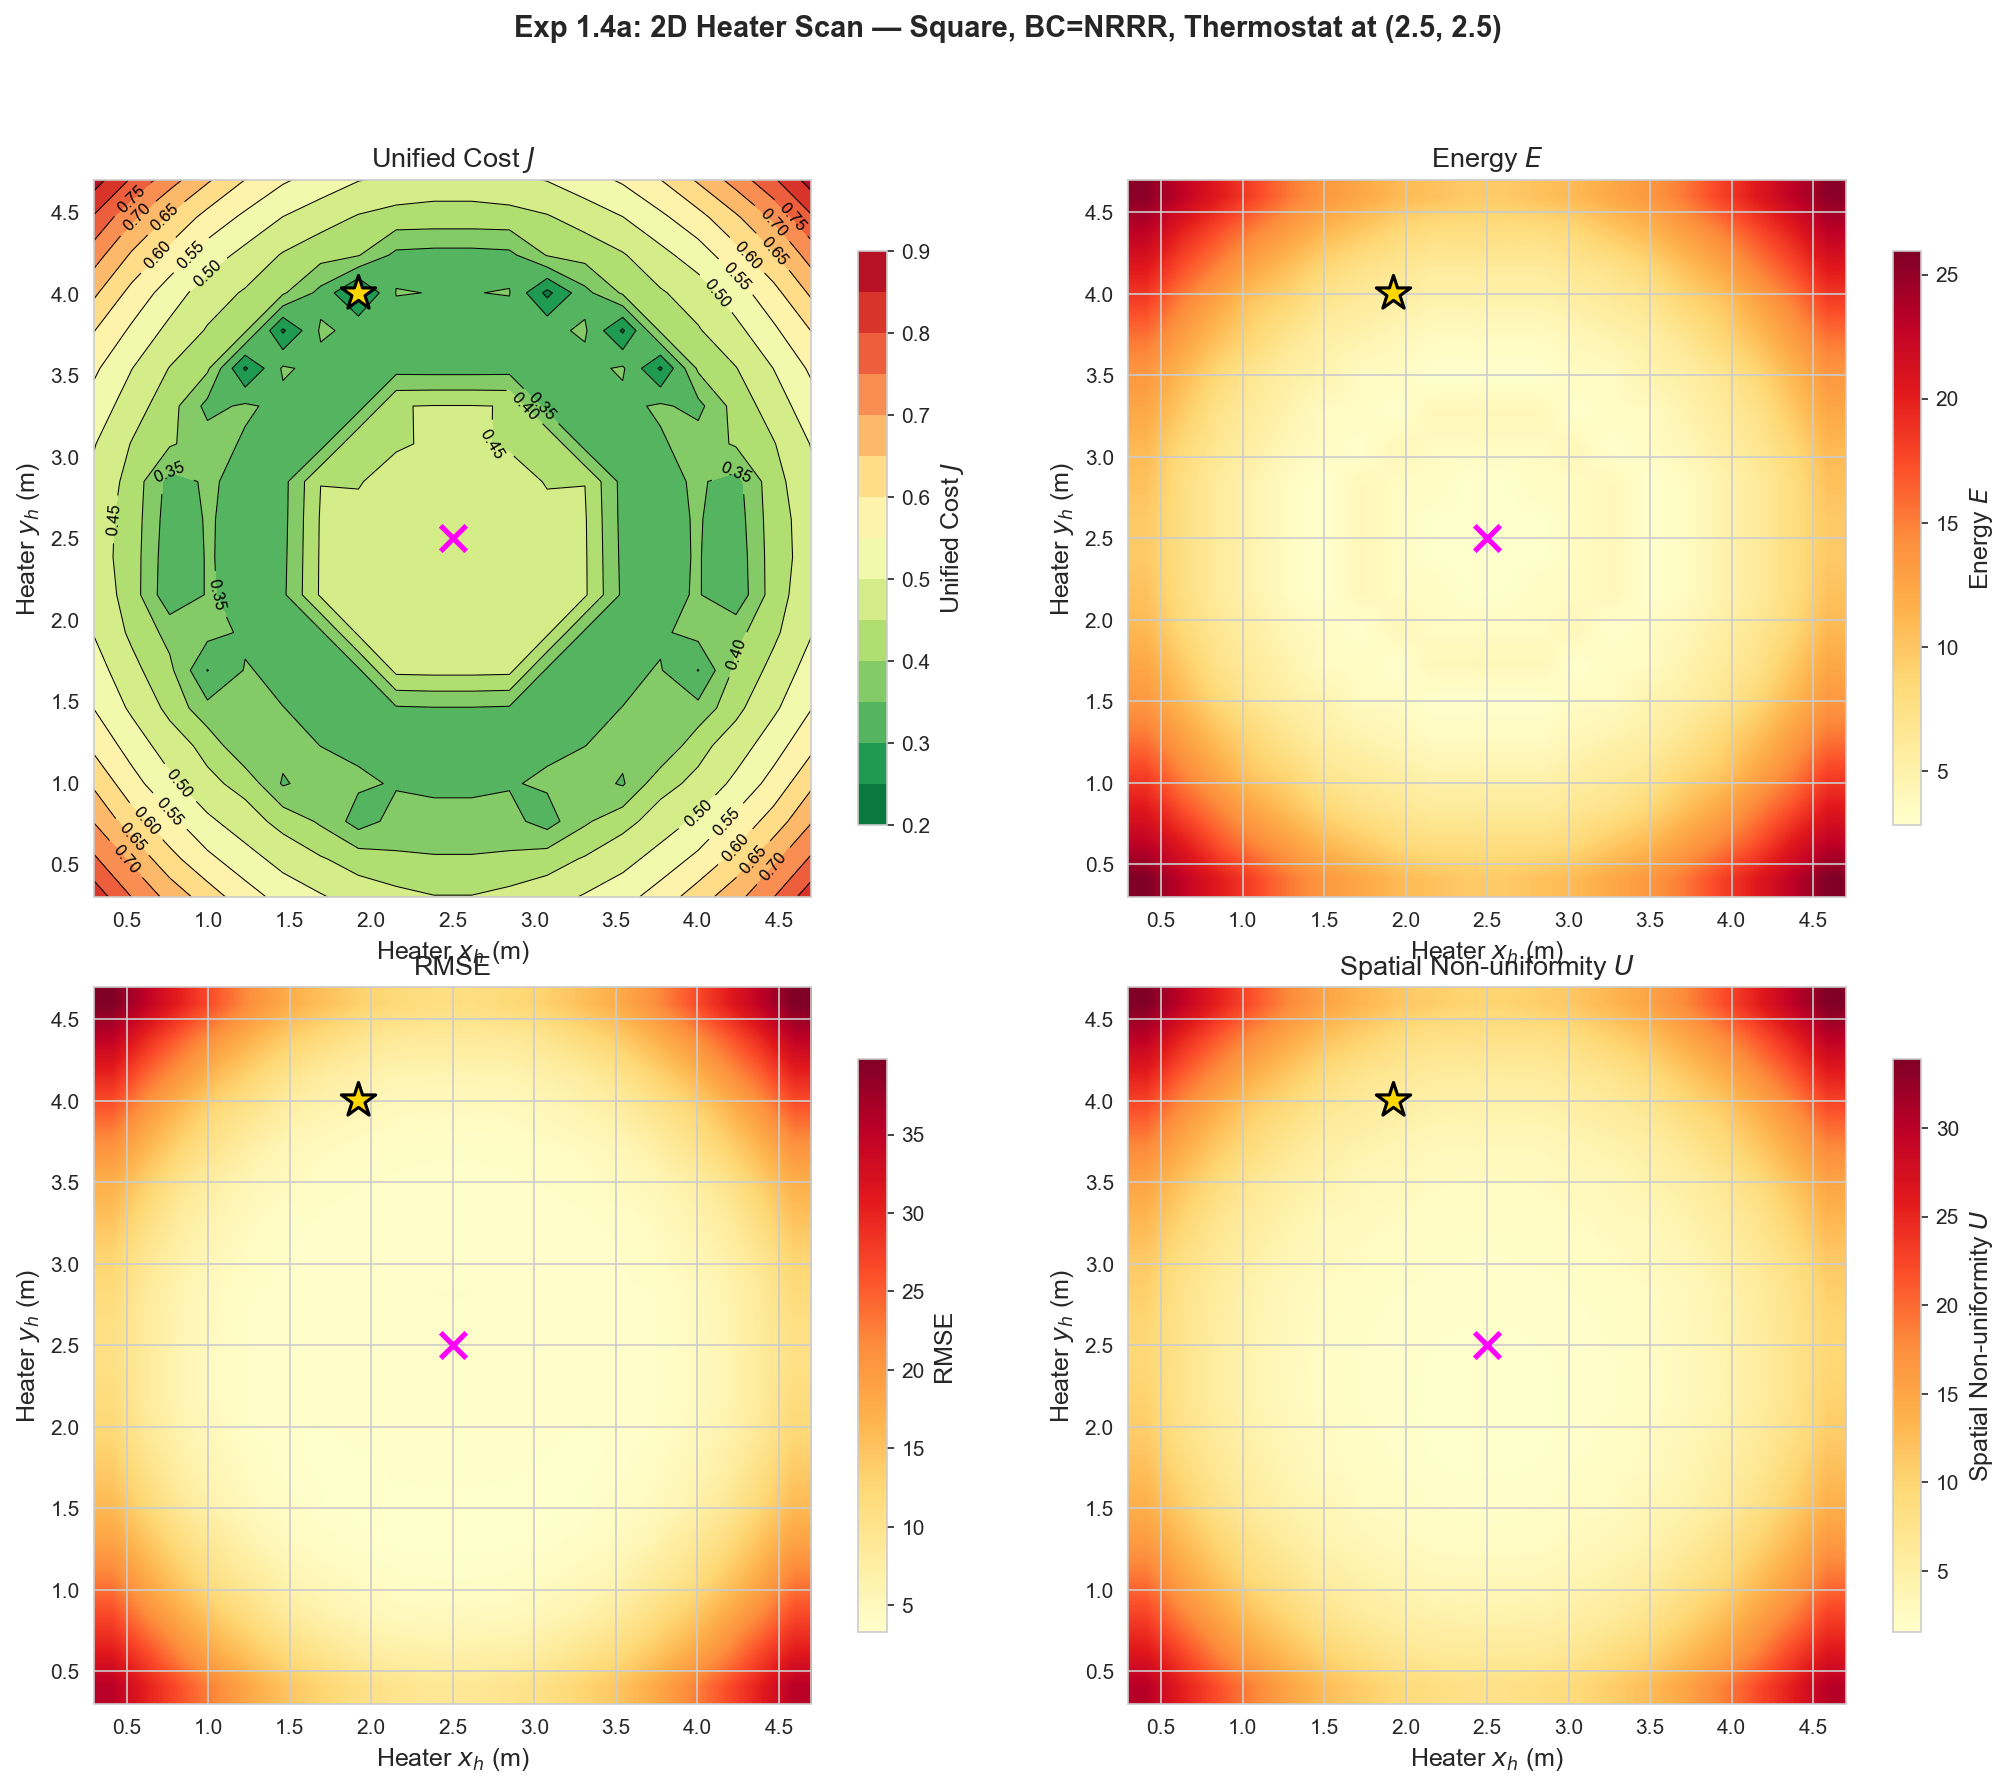

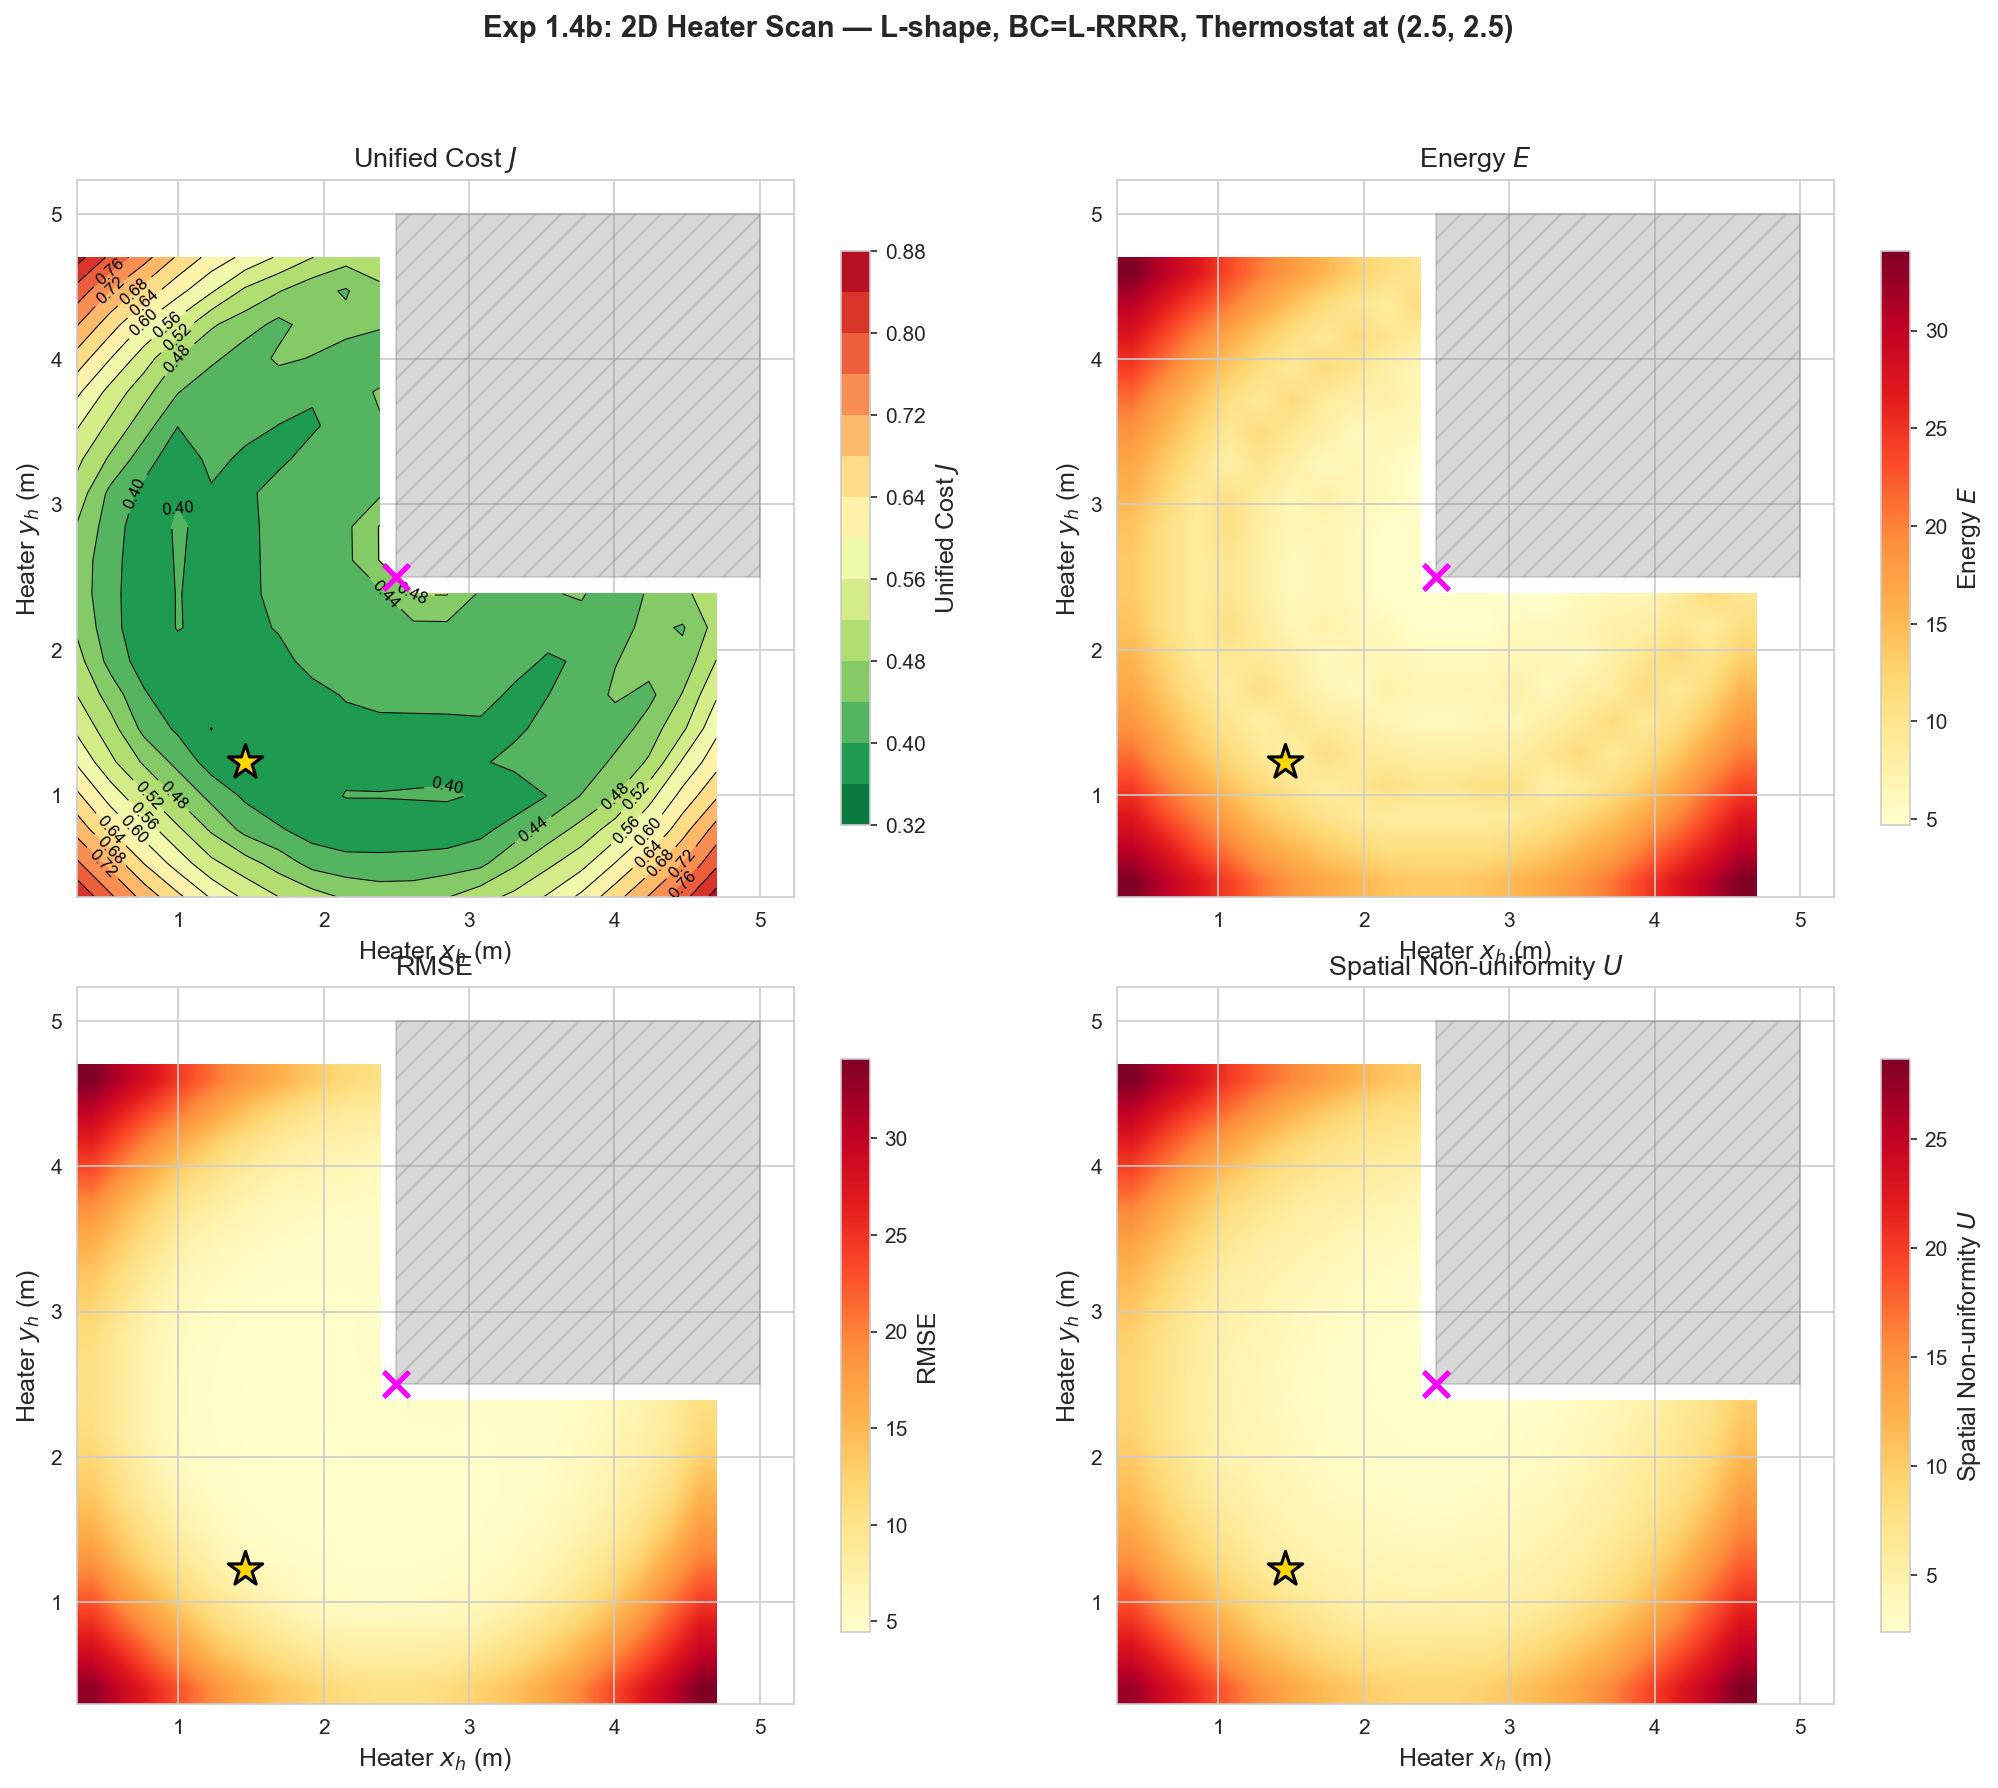

In [54]:
# ============================================================
# 实验 1.4: 加热器 2D 网格扫描 — 两种配置对比
# ============================================================
XS_FIX = 2.5
YS_FIX = 2.5
# --- 1.4a: Square, NRRR ---
print('=== 实验 1.4a: Square, BC=NRRR ===')
df_14a, ref_14a = sweep_heater_2d_grid(
    XS_FIX, YS_FIX, geometry='square', bc_type='NRRR',
    source_type='gauss', dx=0.25, margin=0.3
)
best_14a = df_14a.loc[df_14a['J'].idxmin()]
print(f'最优加热器位置: ({best_14a["x_h"]:.2f}, {best_14a["y_h"]:.2f}), J={best_14a["J"]:.4f}')

# --- 1.4b: L-shape, RRRR ---
print('=== 实验 1.4b: L-shape, BC=L-RRRR ===')
df_14b, ref_14b = sweep_heater_2d_grid(
    XS_FIX, YS_FIX, geometry='L-shape', bc_type='L-RRRR',
    source_type='gauss', dx=0.25, margin=0.3
)
best_14b = df_14b.loc[df_14b['J'].idxmin()]
print(f'最优加热器位置: ({best_14b["x_h"]:.2f}, {best_14b["y_h"]:.2f}), J={best_14b["J"]:.4f}')

# --- 绘图辅助 ---
def df_to_matrix(df, x_col, y_col, val_col):
    xs = np.sort(df[x_col].unique())
    ys = np.sort(df[y_col].unique())
    matrix = np.full((len(ys), len(xs)), np.nan)
    for _, row in df.iterrows():
        ix = np.searchsorted(xs, row[x_col])
        iy = np.searchsorted(ys, row[y_col])
        if ix < len(xs) and iy < len(ys):
            matrix[iy, ix] = row[val_col]
    return matrix, xs, ys

metrics_to_plot = [
    ('J', 'Unified Cost $J$', 'RdYlGn_r'),
    ('E', 'Energy $E$', 'YlOrRd'),
    ('RMSE', 'RMSE', 'YlOrRd'),
    ('U_spatial', 'Spatial Non-uniformity $U$', 'YlOrRd'),
]

configs = [
    ('1.4a', 'Square, BC=NRRR', df_14a, best_14a, 'square'),
    ('1.4b', 'L-shape, BC=L-RRRR', df_14b, best_14b, 'L-shape'),
]

for exp_id, title_label, df, best, geom in configs:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f'Exp {exp_id}: 2D Heater Scan — {title_label}, '
                 f'Thermostat at ({XS_FIX}, {YS_FIX})',
                 fontsize=14, fontweight='bold')

    for ax, (col, label, cmap) in zip(axes.flat, metrics_to_plot):
        matrix, xs, ys = df_to_matrix(df, 'x_h', 'y_h', col)
        M = np.ma.masked_invalid(matrix)
        Xg, Yg = np.meshgrid(xs, ys)
        if col == 'J':
            n_levels = 12
            cf = ax.contourf(Xg, Yg, M, levels=n_levels, cmap=cmap)
            fig.colorbar(cf, ax=ax, label=label, shrink=0.8)
            cs = ax.contour(Xg, Yg, M, levels=n_levels, colors='k', linewidths=0.5)
            ax.clabel(cs, fmt='%.2f', fontsize=8)
        else:
            im = ax.imshow(matrix, origin='lower', aspect='equal',
                           extent=[xs[0], xs[-1], ys[0], ys[-1]],
                           cmap=cmap, interpolation='bilinear')
            fig.colorbar(im, ax=ax, label=label, shrink=0.8)

        ax.scatter(best['x_h'], best['y_h'], marker='*', s=300,
                   color='gold', edgecolors='k', linewidth=1.5, zorder=10)
        ax.scatter(XS_FIX, YS_FIX, marker='x', s=150, color='magenta',
                   linewidth=2.5, zorder=10)
        # L-shape 灰色遮罩
        if geom == 'L-shape':
            ax.fill_between([2.5, 5], 2.5, 5, alpha=0.3, color='gray', hatch='//')
        ax.set_xlabel('Heater $x_h$ (m)')
        ax.set_ylabel('Heater $y_h$ (m)')
        ax.set_title(label)
        ax.set_aspect('equal')

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.savefig(f'{OUT_DIR}/2D_exp{exp_id}_heatmaps.png', dpi=300, bbox_inches='tight')
    plt.show()

In [14]:
Lx, Ly = GEOMETRIES['square']['Lx'], GEOMETRIES['square']['Ly']
x0, y0 = best_14['x_h'], best_14['y_h']

# 对称变换集合（反射 + 90° 旋转）
sym_points = [
    ('orig', (x0, y0)),
    ('reflect_x', (Lx - x0, y0)),
    ('reflect_y', (x0, Ly - y0)),
    ('reflect_xy', (Lx - x0, Ly - y0)),
    ('rot90', (Ly - y0, x0)),
    ('rot180', (Lx - x0, Ly - y0)),  # same as reflect_xy
    ('rot270', (y0, Lx - x0)),
]

results = []
for name, (xh, yh) in sym_points:
    if not is_in_domain(xh, yh, 'square'):
        results.append((name, xh, yh, np.nan))
        continue
    sim = simulate_2d(xh, yh, XS_FIX, YS_FIX, geometry='square', bc_type='RNNN', source_type='gauss', dx=0.25)
    m = compute_metrics_2d(sim)
    J = compute_unified_cost(m, ref_14)
    results.append((name, xh, yh, J))

import pandas as pd
df_sym = pd.DataFrame(results, columns=['transform','x_h','y_h','J'])
print(df_sym)

# 判断是否在容差内相等
Js = df_sym['J'].dropna().values
print('max diff:', np.nanmax(np.abs(Js - Js[0])))
print('allclose (atol=1e-6):', np.allclose(Js, Js[0], atol=1e-6))

    transform       x_h       y_h         J
0        orig  1.921053  4.005263  0.236122
1   reflect_x  3.078947  4.005263  0.236122
2   reflect_y  1.921053  0.994737  0.357304
3  reflect_xy  3.078947  0.994737  0.357304
4       rot90  0.994737  1.921053  0.365938
5      rot180  3.078947  0.994737  0.357304
6      rot270  4.005263  3.078947  0.374196
max diff: 0.13807374094408467
allclose (atol=1e-6): False


## 实验 1.5：Summary

- 三条扫描线 $J$ 叠加对比
- 最优位置终态温度场
- Top-5 排名表

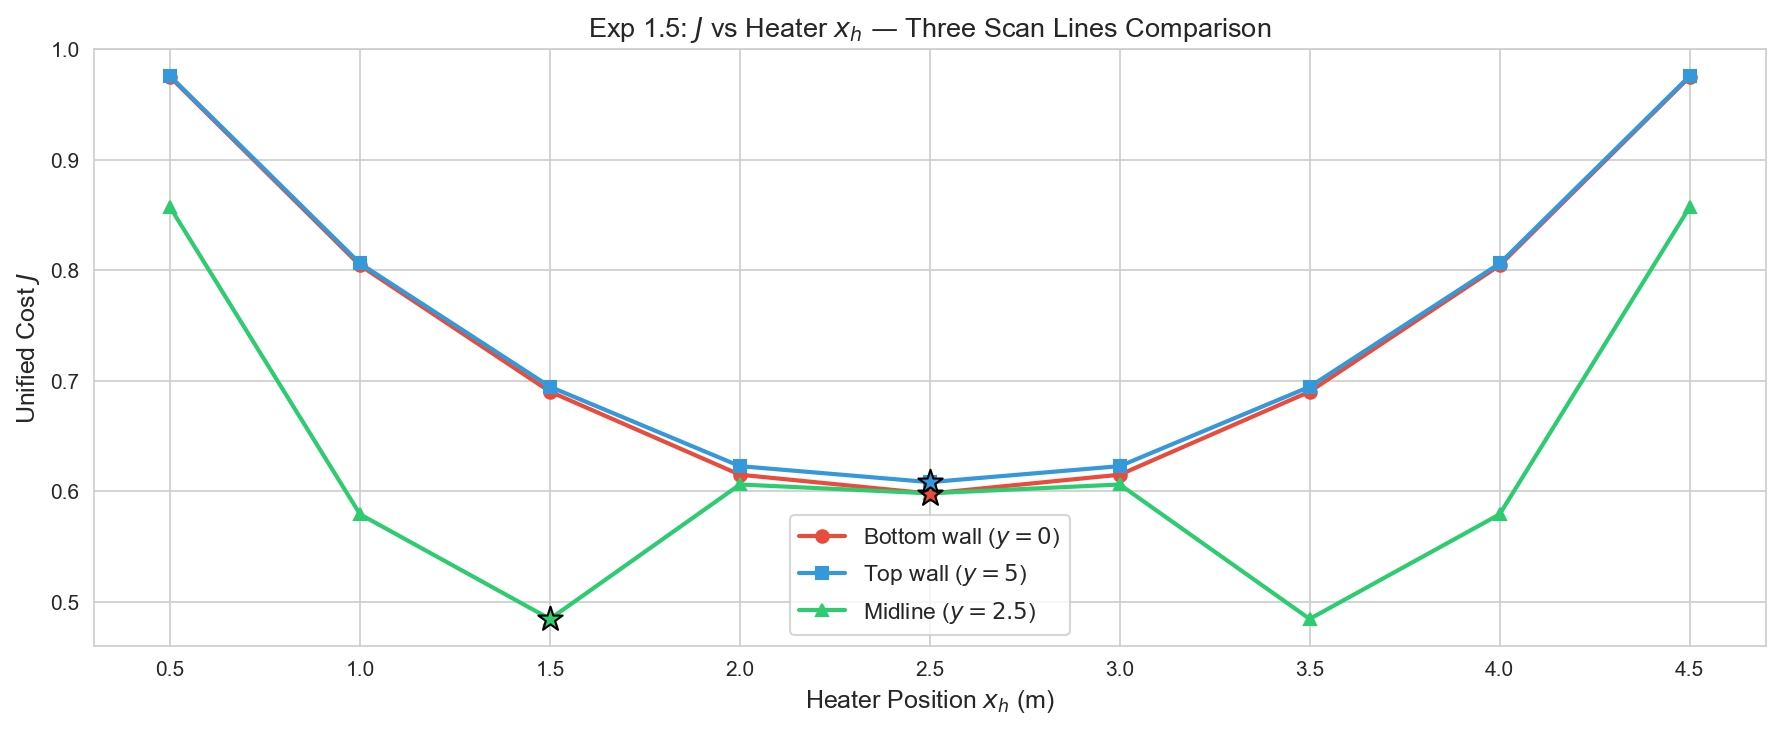

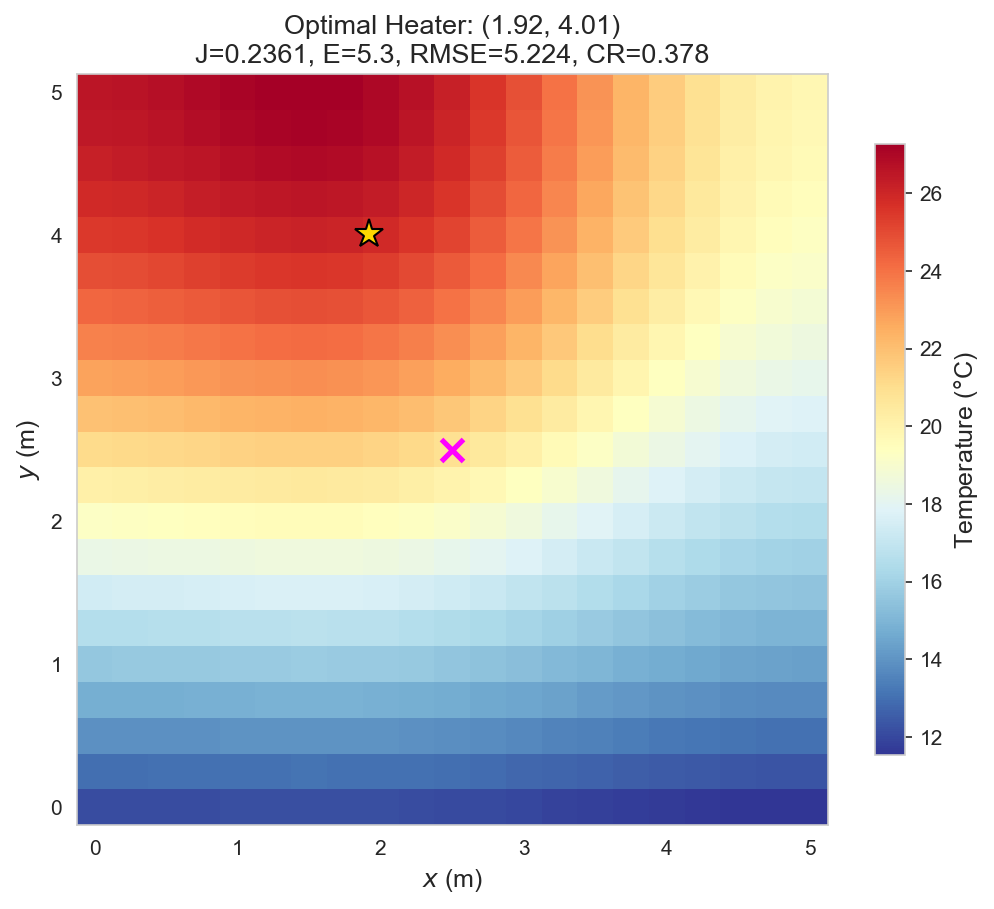


=== 实验 1: Top-5 加热器位置排名 (RNNN, 点热源) ===


x_h       y_h       E      RMSE  U_spatial  DeltaT_max        CR  \
327  1.921053  4.005263  5.3125  5.223580   5.044156   19.986358  0.378265   
332  3.078947  4.005263  5.3125  5.223580   5.044156   19.986358  0.378265   
305  1.457895  3.773684  5.3125  5.344151   5.170265   19.759013  0.320586   
314  3.542105  3.773684  5.3125  5.344151   5.170265   19.759013  0.320586   
284  1.226316  3.542105  5.3125  5.324043   5.148060   19.759013  0.315671   

     N_sw         J  
327     1  0.236122  
332     1  0.236122  
305     1  0.242249  
314     1  0.242249  
284     1  0.242860

CSV 已保存.


In [15]:
# ============================================================
# 实验 1.5: Summary
# ============================================================

# --- 三条扫描线 J 叠加对比 ---
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x_positions_11, J_11, 'o-', color='#e74c3c', linewidth=2, label='Bottom wall ($y=0$)')
ax.plot(x_positions_12, J_12, 's-', color='#3498db', linewidth=2, label='Top wall ($y=5$)')
ax.plot(x_positions_13, J_13, '^-', color='#2ecc71', linewidth=2, label='Midline ($y=2.5$)')

for pos, J, c in [(x_positions_11, J_11, '#e74c3c'),
                   (x_positions_12, J_12, '#3498db'),
                   (x_positions_13, J_13, '#2ecc71')]:
    bi = np.argmin(J)
    ax.scatter([pos[bi]], [J[bi]], s=150, marker='*', color=c,
              edgecolors='k', zorder=10)

ax.set_xlabel('Heater Position $x_h$ (m)')
ax.set_ylabel('Unified Cost $J$')
ax.set_title('Exp 1.5: $J$ vs Heater $x_h$ — Three Scan Lines Comparison')
ax.legend(fontsize=11)
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/2D_exp1_5_J_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 最优位置终态温度场大图 ---
best_row = df_14.loc[df_14['J'].idxmin()]
sim_best_14 = simulate_2d(
    best_row['x_h'], best_row['y_h'], XS_FIX, YS_FIX,
    geometry='square', bc_type='RNNN', source_type='gauss', dx=0.25,
    return_field=True
)

fig, ax = plt.subplots(figsize=(7, 6))
plot_2d_field(sim_best_14['T_final'], sim_best_14['x'], sim_best_14['y'],
              sim_best_14['mask'], ax,
              x_h=best_row['x_h'], y_h=best_row['y_h'],
              x_s=XS_FIX, y_s=YS_FIX,
              title=f'Optimal Heater: ({best_row["x_h"]:.2f}, {best_row["y_h"]:.2f})\n'
                    f'J={best_row["J"]:.4f}, E={best_row["E"]:.1f}, '
                    f'RMSE={best_row["RMSE"]:.3f}, CR={best_row["CR"]:.3f}')
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/2D_exp1_5_best_field.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Top-5 排名表 ---
top5_14 = df_14.nsmallest(5, 'J')[['x_h', 'y_h', 'E', 'RMSE', 'U_spatial',
                                     'DeltaT_max', 'CR', 'N_sw', 'J']]
print('\n=== 实验 1: Top-5 加热器位置排名 (RNNN, 点热源) ===')
display(top5_14)

# 输出 CSV
df_14.to_csv(f'{OUT_DIR}/2D_exp1_heater_scan.csv', index=False)
print('CSV 已保存.')

---

# 实验二：RNNN 下，加热器固定在最优位置，变化恒温器位置

加热器固定在实验一找到的最优位置，扫描恒温器位置。

**核心问题**：恒温器（传感器）放在哪里，控制效果最好？

> 恒温器放在加热器旁边读数升温快，控制器以为房间已暖就关了加热器，实际上远端还很冷。放在对面或中央能更好地代表全域温度。

使用实验 1 最优加热器位置: (1.92, 4.01)

=== 实验 2.1: 恒温器沿 x 方向中线 ===


Exp 2.1:   0%|          | 0/9 [00:00<?, ?it/s]

最优恒温器 x: 2.50m, J=0.3521


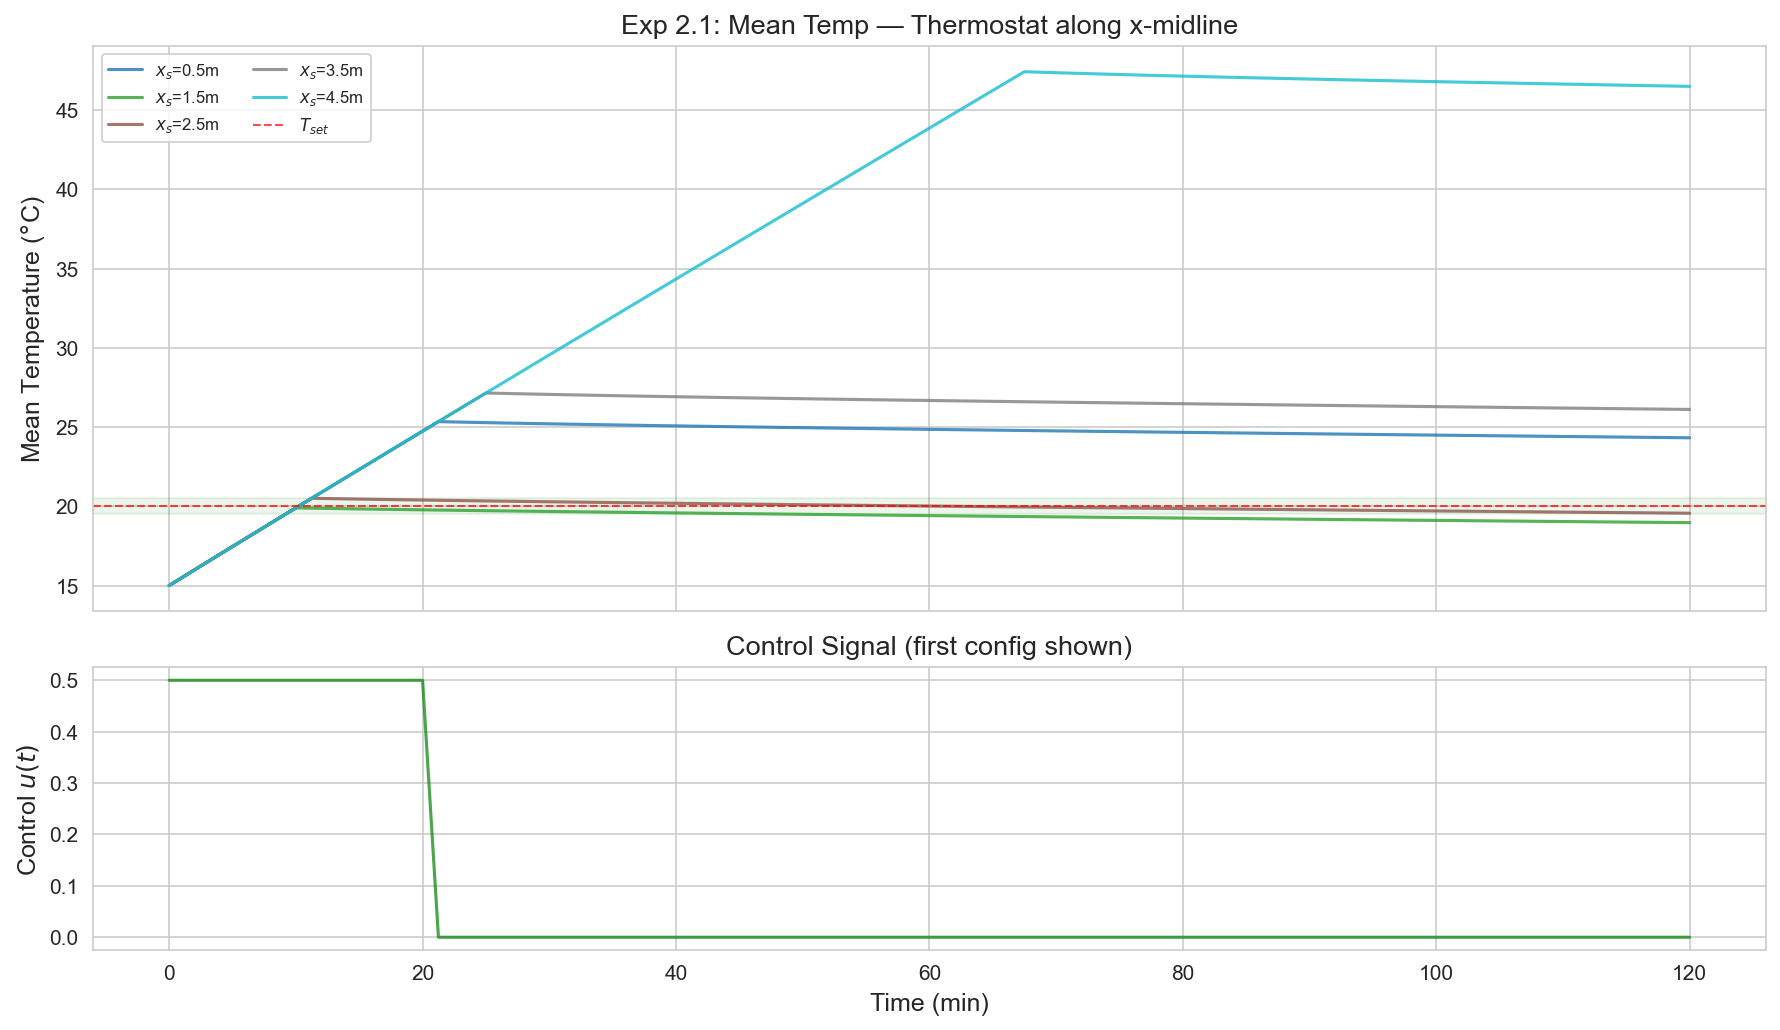

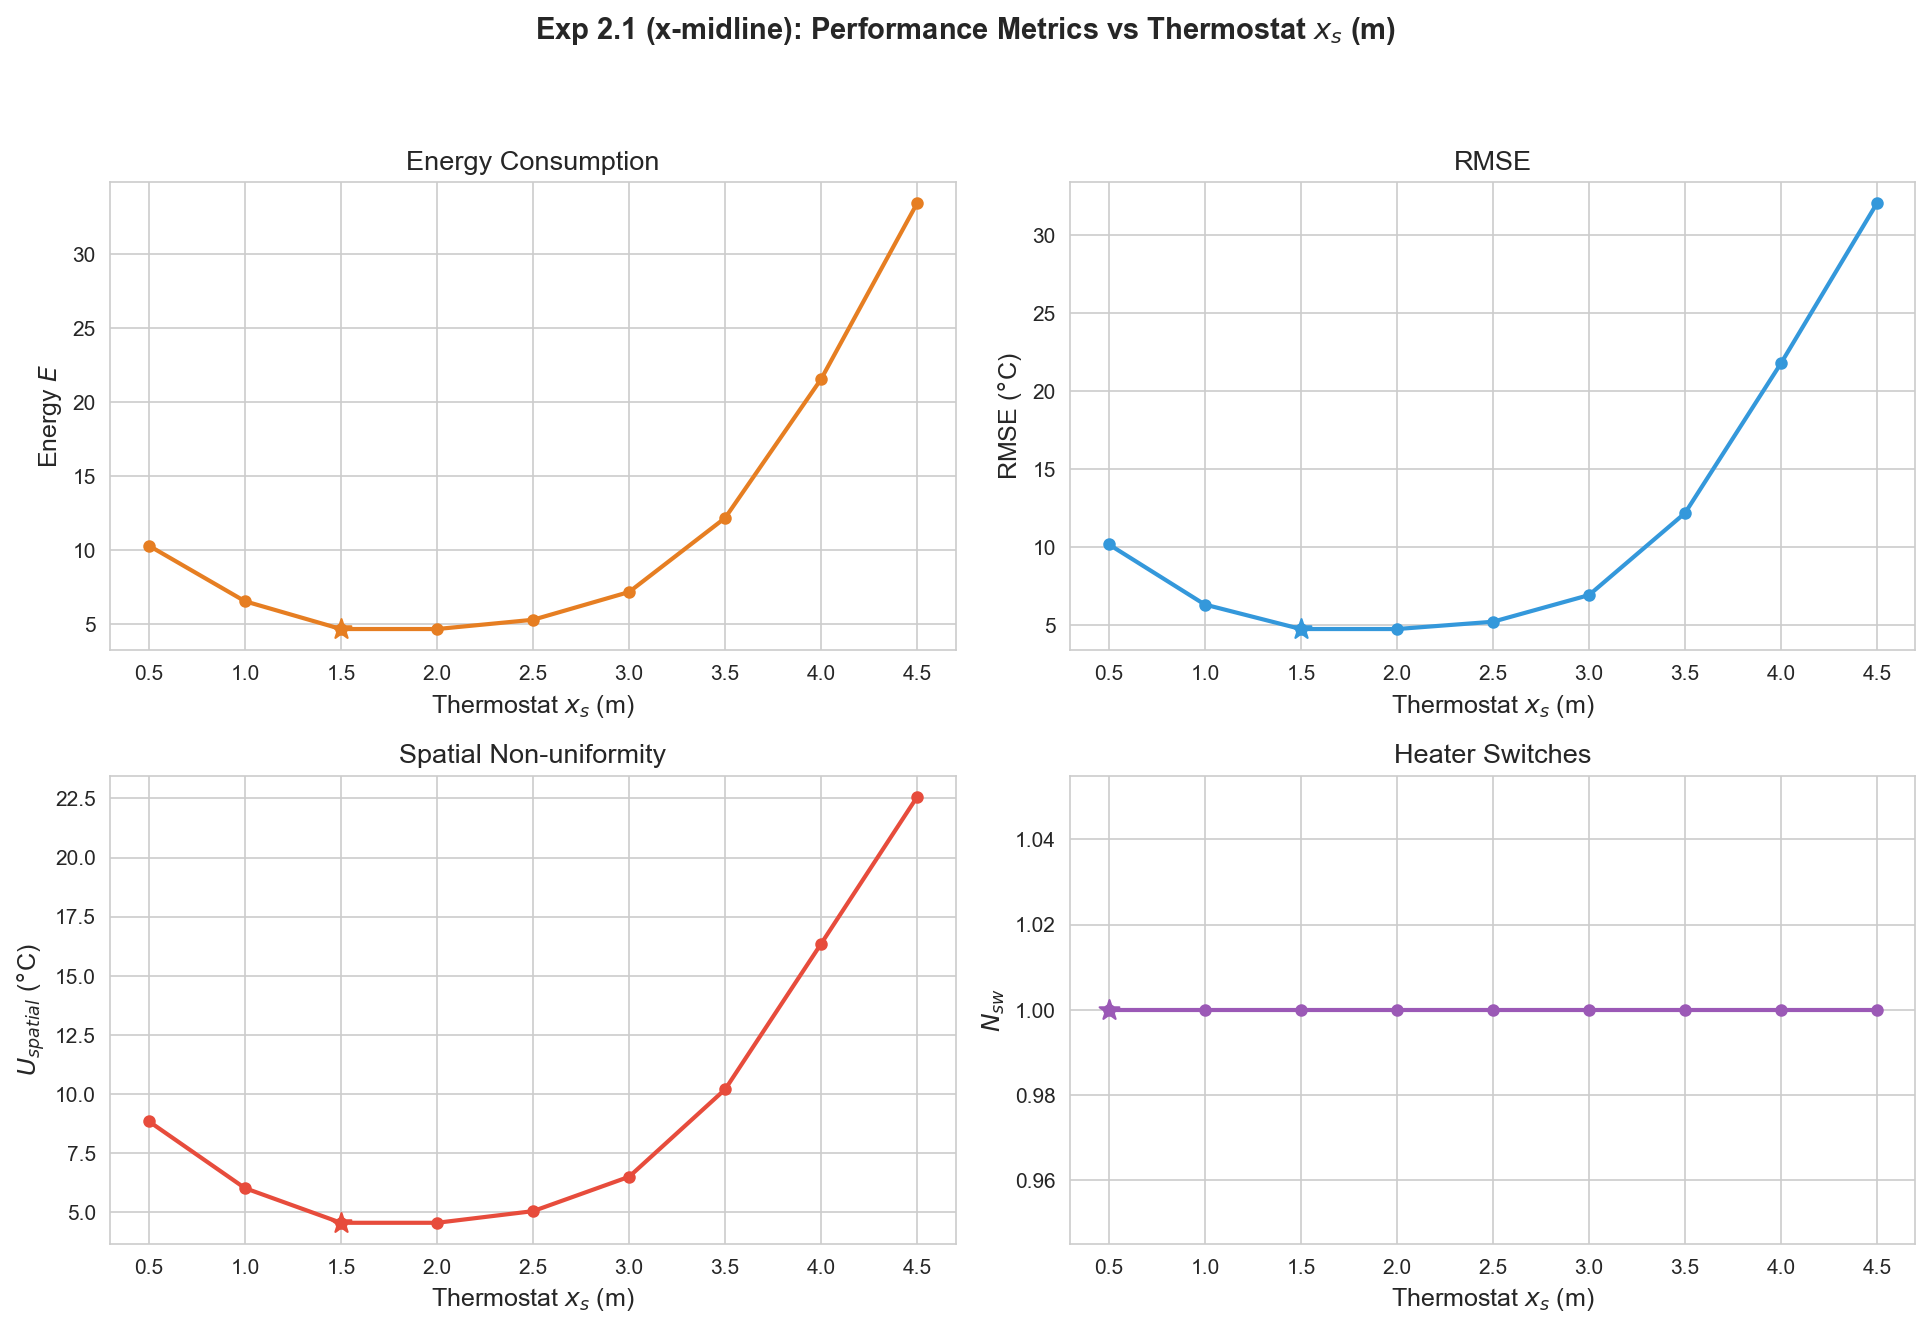


=== 实验 2.2: 恒温器沿 y 方向中线 ===


Exp 2.2:   0%|          | 0/9 [00:00<?, ?it/s]

最优恒温器 y: 2.50m, J=0.3208


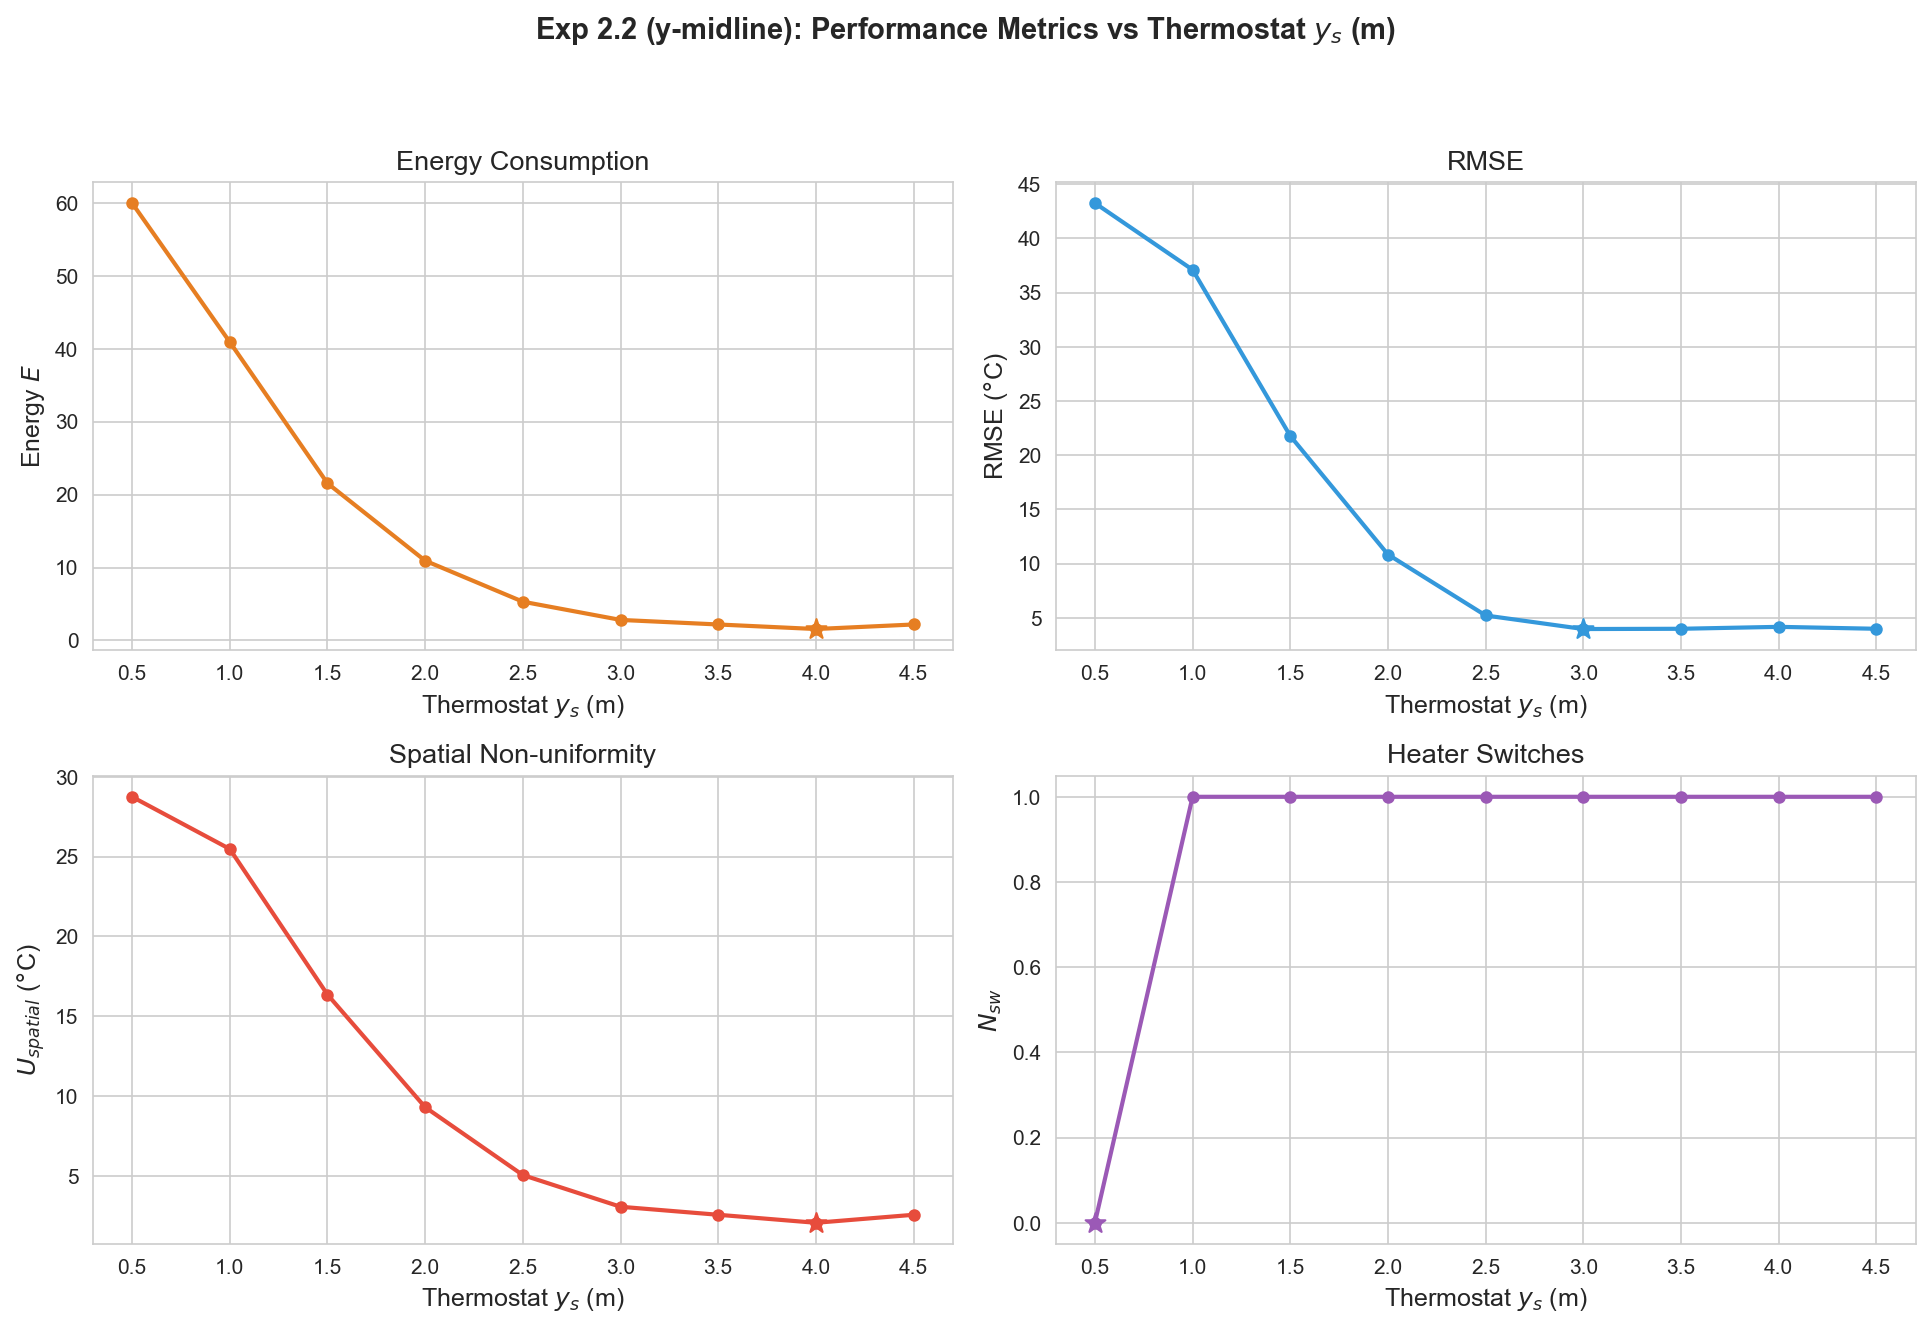

In [16]:
# ============================================================
# 实验 2.1 & 2.2: 恒温器沿 x 和 y 方向中线扫描
# ============================================================

# 使用实验 1 的最优加热器位置
XH_OPT = best_row['x_h']
YH_OPT = best_row['y_h']
print(f'使用实验 1 最优加热器位置: ({XH_OPT:.2f}, {YH_OPT:.2f})')

# 2.1 恒温器沿 x 方向中线 (y=2.5)
x_pos_21 = np.linspace(0.5, 4.5, 9)
thermo_positions_21 = [(xs, 2.5) for xs in x_pos_21]

print('\n=== 实验 2.1: 恒温器沿 x 方向中线 ===')
sims_21 = []
metrics_21 = []
for xs, ys in tqdm(thermo_positions_21, desc='Exp 2.1'):
    sim = simulate_2d(XH_OPT, YH_OPT, xs, ys,
                      geometry='square', bc_type='RNNN', source_type='gauss', dx=0.25)
    m = compute_metrics_2d(sim)
    sims_21.append(sim)
    metrics_21.append(m)

ref_21 = compute_ref_maxes(metrics_21)
J_21 = [compute_unified_cost(m, ref_21) for m in metrics_21]
best_21 = np.argmin(J_21)
print(f'最优恒温器 x: {x_pos_21[best_21]:.2f}m, J={J_21[best_21]:.4f}')

# 均温时间曲线
sims_overlay_21 = {f'$x_s$={x_pos_21[i]:.1f}m': sims_21[i] for i in [0, 2, 4, 6, 8]}
plot_mean_temp_overlay(sims_overlay_21,
                       save_path=f'{OUT_DIR}/2D_exp2_1_meantemp.png',
                       title='Exp 2.1: Mean Temp — Thermostat along x-midline')

plot_metrics_vs_position(
    x_pos_21, metrics_21, 'x_s', 'Thermostat $x_s$ (m)',
    title_prefix='Exp 2.1 (x-midline): ',
    save_path=f'{OUT_DIR}/2D_exp2_1_metrics.png'
)

# 2.2 恒温器沿 y 方向中线 (x=2.5)
y_pos_22 = np.linspace(0.5, 4.5, 9)
thermo_positions_22 = [(2.5, ys) for ys in y_pos_22]

print('\n=== 实验 2.2: 恒温器沿 y 方向中线 ===')
sims_22 = []
metrics_22 = []
for xs, ys in tqdm(thermo_positions_22, desc='Exp 2.2'):
    sim = simulate_2d(XH_OPT, YH_OPT, xs, ys,
                      geometry='square', bc_type='RNNN', source_type='gauss', dx=0.25)
    m = compute_metrics_2d(sim)
    sims_22.append(sim)
    metrics_22.append(m)

ref_22 = compute_ref_maxes(metrics_22)
J_22 = [compute_unified_cost(m, ref_22) for m in metrics_22]
best_22 = np.argmin(J_22)
print(f'最优恒温器 y: {y_pos_22[best_22]:.2f}m, J={J_22[best_22]:.4f}')

plot_metrics_vs_position(
    y_pos_22, metrics_22, 'y_s', 'Thermostat $y_s$ (m)',
    title_prefix='Exp 2.2 (y-midline): ',
    save_path=f'{OUT_DIR}/2D_exp2_2_metrics.png'
)

=== 实验 2.3: 恒温器全房间 2D 扫描 ===
Scanning 400 thermostat positions (square, RNNN, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D thermostat scan:   0%|          | 0/400 [00:00<?, ?it/s]

最优恒温器: (1.69, 2.38), J=0.3208


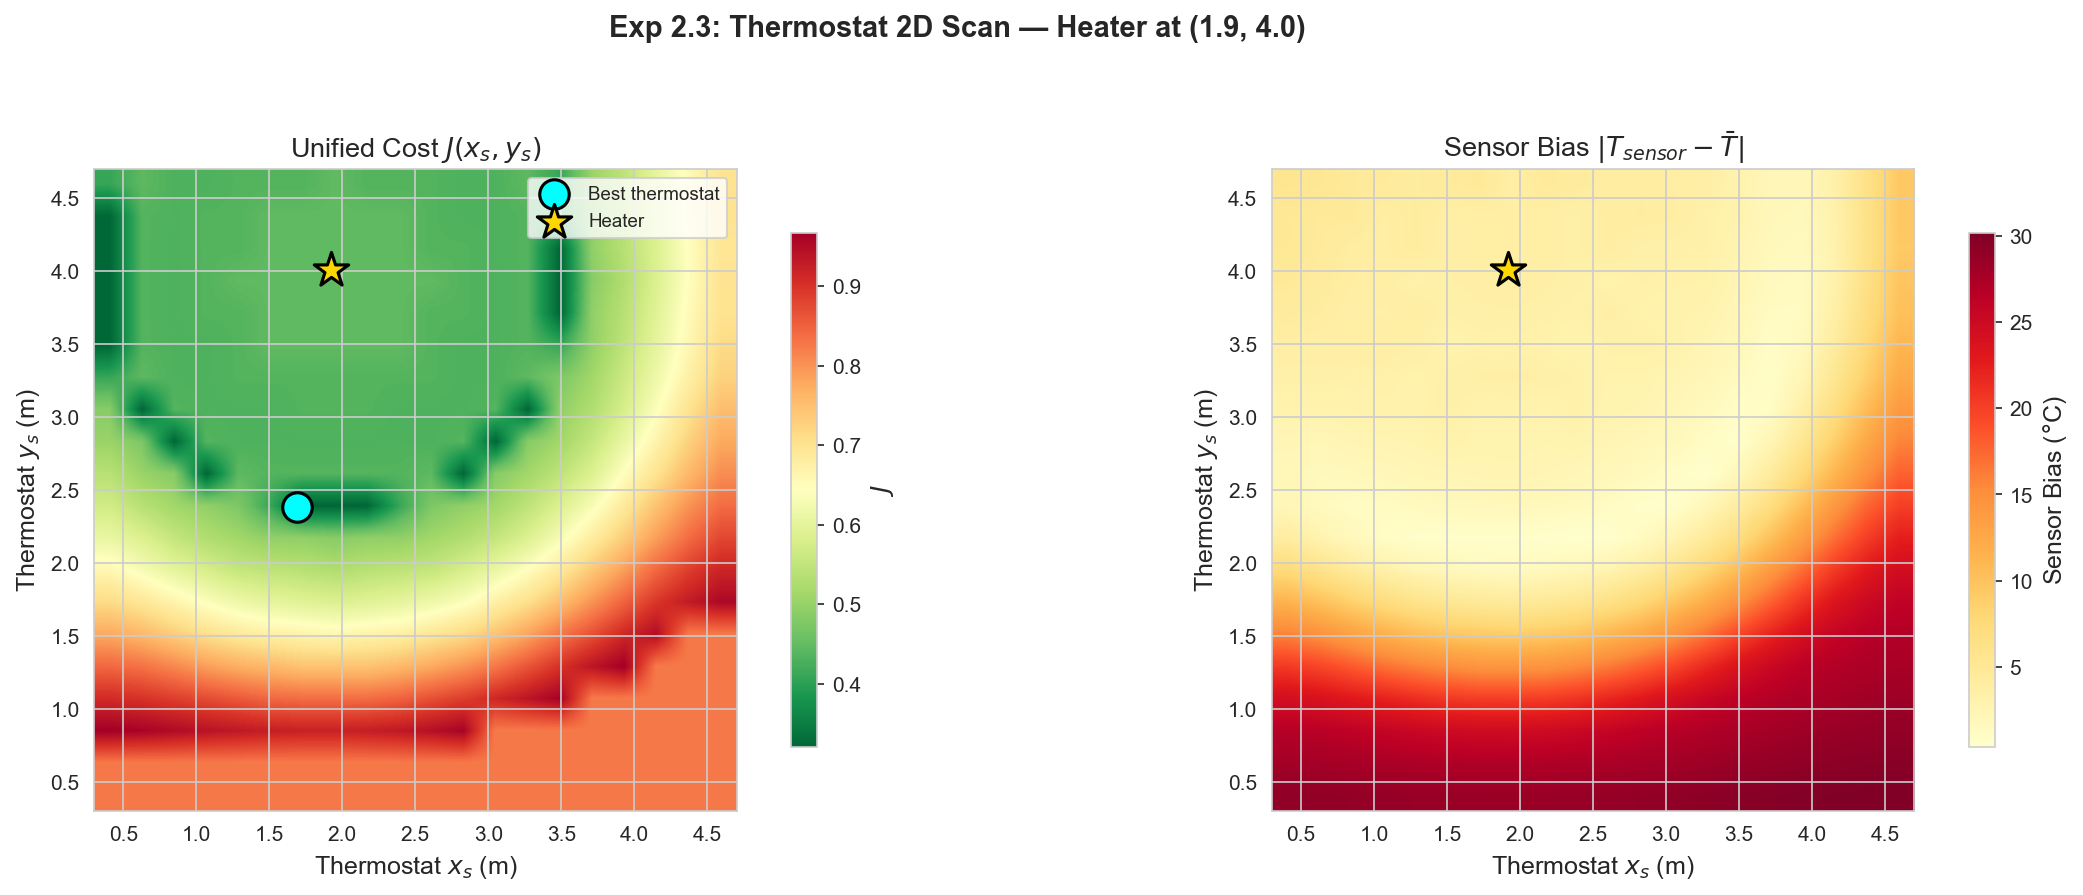

In [17]:
# ============================================================
# 实验 2.3: 恒温器全房间 2D 网格扫描
# ============================================================

print('=== 实验 2.3: 恒温器全房间 2D 扫描 ===')
df_23, ref_23 = sweep_thermostat_2d_grid(
    XH_OPT, YH_OPT, geometry='square', bc_type='RNNN',
    source_type='gauss', dx=0.25, margin=0.3
)

best_23 = df_23.loc[df_23['J'].idxmin()]
print(f'最优恒温器: ({best_23["x_s"]:.2f}, {best_23["y_s"]:.2f}), J={best_23["J"]:.4f}')

# --- J + SensorBias 1×2 面板 ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Exp 2.3: Thermostat 2D Scan — Heater at ({XH_OPT:.1f}, {YH_OPT:.1f})',
             fontsize=14, fontweight='bold')

# J 热力图
matrix_J, xs_J, ys_J = df_to_matrix(df_23, 'x_s', 'y_s', 'J')
im1 = ax1.imshow(matrix_J, origin='lower', aspect='equal',
                 extent=[xs_J[0], xs_J[-1], ys_J[0], ys_J[-1]],
                 cmap='RdYlGn_r', interpolation='bilinear')
plt.colorbar(im1, ax=ax1, label='$J$', shrink=0.8)
ax1.scatter(best_23['x_s'], best_23['y_s'], marker='o', s=200,
           color='cyan', edgecolors='k', linewidth=1.5, zorder=10, label='Best thermostat')
ax1.scatter(XH_OPT, YH_OPT, marker='*', s=300, color='gold',
           edgecolors='k', linewidth=1.5, zorder=10, label='Heater')
ax1.set_xlabel('Thermostat $x_s$ (m)')
ax1.set_ylabel('Thermostat $y_s$ (m)')
ax1.set_title('Unified Cost $J(x_s, y_s)$')
ax1.legend(fontsize=9)

# SensorBias 热力图
matrix_SB, _, _ = df_to_matrix(df_23, 'x_s', 'y_s', 'SensorBias')
im2 = ax2.imshow(matrix_SB, origin='lower', aspect='equal',
                 extent=[xs_J[0], xs_J[-1], ys_J[0], ys_J[-1]],
                 cmap='YlOrRd', interpolation='bilinear')
plt.colorbar(im2, ax=ax2, label='Sensor Bias ($°$C)', shrink=0.8)
ax2.scatter(XH_OPT, YH_OPT, marker='*', s=300, color='gold',
           edgecolors='k', linewidth=1.5, zorder=10)
ax2.set_xlabel('Thermostat $x_s$ (m)')
ax2.set_ylabel('Thermostat $y_s$ (m)')
ax2.set_title('Sensor Bias $|T_{sensor} - \\bar{T}|$')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(f'{OUT_DIR}/2D_exp2_3_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

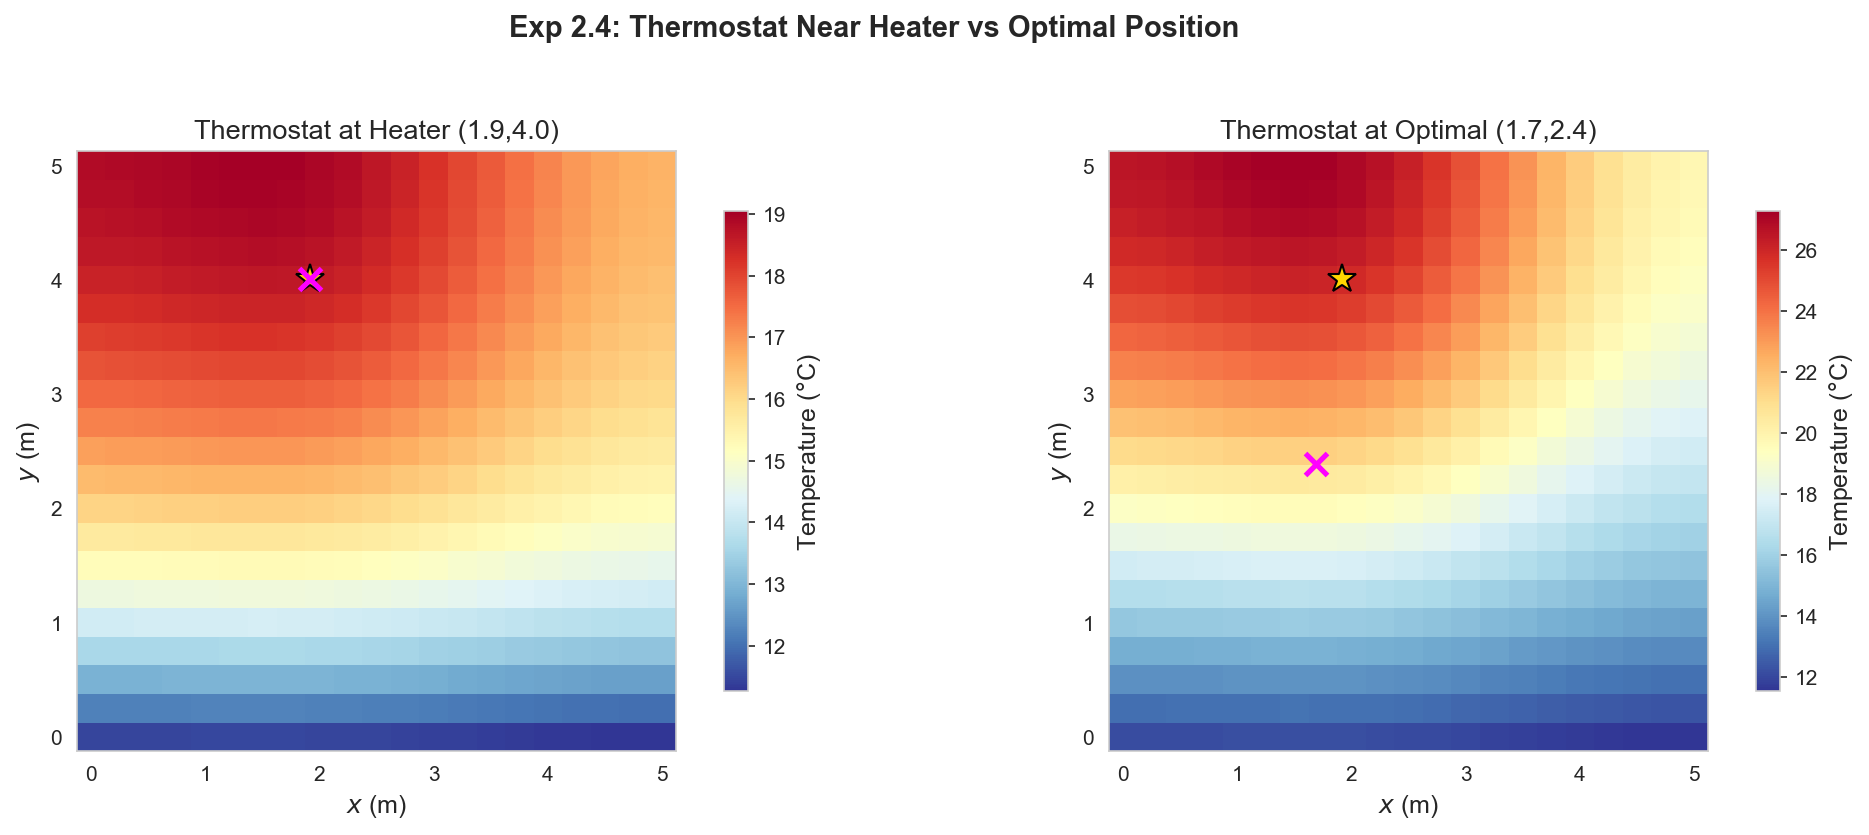


=== 恒温器位置对比 ===


Metric  Near Heater    Optimal
0           E     1.562500   5.312500
1        RMSE     4.175807   5.223580
2  DeltaT_max     3.911782  19.986358
3          CR     0.239736   0.378265
4         t_s   120.000000  12.500000
5        N_sw     1.000000   1.000000
6   U_spatial     2.053013   5.044156

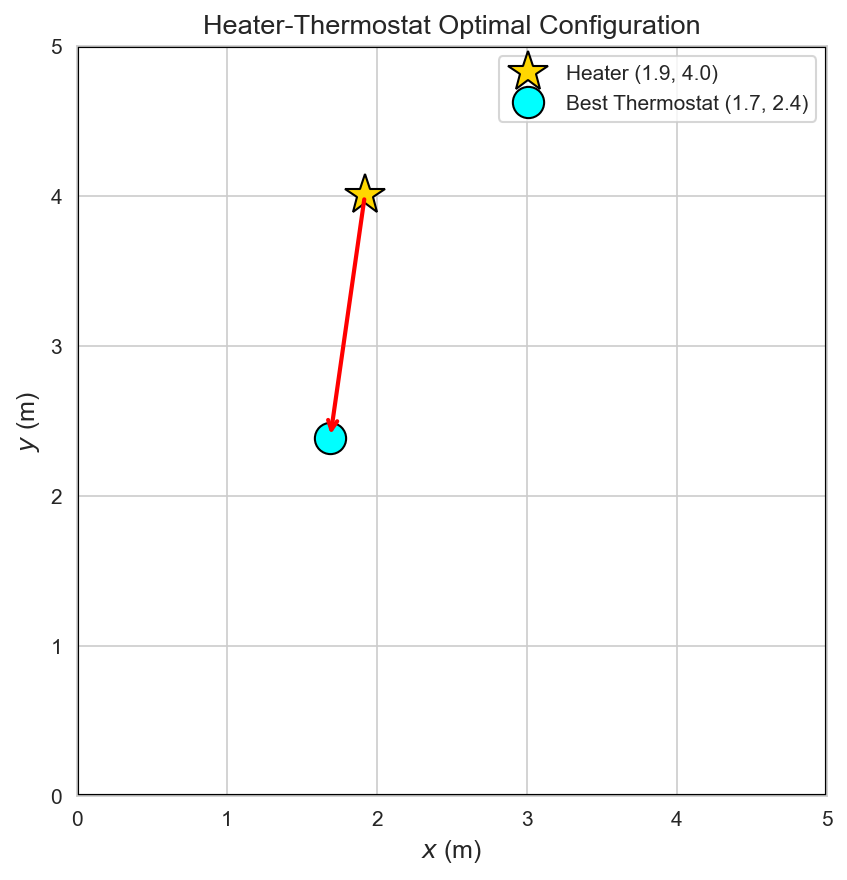


=== Top-5 恒温器位置排名 ===


x_s       y_s       E     RMSE  U_spatial  SensorBias        CR  \
186  1.689474  2.384211  5.3125  5.22358   5.044156    1.797903  0.378265   
187  1.921053  2.384211  5.3125  5.22358   5.044156    1.839287  0.378265   
188  2.152632  2.384211  5.3125  5.22358   5.044156    1.710998  0.378265   
203  0.994737  2.615789  5.3125  5.22358   5.044156    2.032418  0.378265   
211  2.847368  2.615789  5.3125  5.22358   5.044156    1.544510  0.378265   

     N_sw       J  
186     1  0.3208  
187     1  0.3208  
188     1  0.3208  
203     1  0.3208  
211     1  0.3208

CSV 已保存.


In [18]:
# ============================================================
# 实验 2.4: Summary — 恒温器在加热器旁 vs 最优位置对比
# ============================================================

# 恒温器在加热器旁边
sim_near = simulate_2d(XH_OPT, YH_OPT, XH_OPT, YH_OPT,
                       geometry='square', bc_type='RNNN', source_type='gauss', dx=0.25)
m_near = compute_metrics_2d(sim_near)

# 恒温器在最优位置
XS_OPT, YS_OPT = best_23['x_s'], best_23['y_s']
sim_opt = simulate_2d(XH_OPT, YH_OPT, XS_OPT, YS_OPT,
                      geometry='square', bc_type='RNNN', source_type='gauss', dx=0.25)
m_opt = compute_metrics_2d(sim_opt)

# 对比温度场
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))
fig.suptitle('Exp 2.4: Thermostat Near Heater vs Optimal Position', fontsize=14, fontweight='bold')

plot_2d_field(sim_near['T_final'], sim_near['x'], sim_near['y'], sim_near['mask'],
              axes[0], x_h=XH_OPT, y_h=YH_OPT, x_s=XH_OPT, y_s=YH_OPT,
              title=f'Thermostat at Heater ({XH_OPT:.1f},{YH_OPT:.1f})')
plot_2d_field(sim_opt['T_final'], sim_opt['x'], sim_opt['y'], sim_opt['mask'],
              axes[1], x_h=XH_OPT, y_h=YH_OPT, x_s=XS_OPT, y_s=YS_OPT,
              title=f'Thermostat at Optimal ({XS_OPT:.1f},{YS_OPT:.1f})')

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(f'{OUT_DIR}/2D_exp2_4_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 指标对比
print('\n=== 恒温器位置对比 ===')
compare_df = pd.DataFrame({
    'Metric': ['E', 'RMSE', 'DeltaT_max', 'CR', 't_s', 'N_sw', 'U_spatial'],
    'Near Heater': [m_near[k] for k in ['E','RMSE','DeltaT_max','CR','t_s','N_sw','U_spatial']],
    'Optimal': [m_opt[k] for k in ['E','RMSE','DeltaT_max','CR','t_s','N_sw','U_spatial']],
})
display(compare_df)

# 位置关系图
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_aspect('equal')
ax.add_patch(plt.Rectangle((0, 0), 5, 5, fill=False, edgecolor='k', linewidth=2))
ax.plot(XH_OPT, YH_OPT, '*', color='gold', markersize=20, markeredgecolor='k',
        label=f'Heater ({XH_OPT:.1f}, {YH_OPT:.1f})')
ax.plot(XS_OPT, YS_OPT, 'o', color='cyan', markersize=15, markeredgecolor='k',
        label=f'Best Thermostat ({XS_OPT:.1f}, {YS_OPT:.1f})')
ax.annotate('', xy=(XS_OPT, YS_OPT), xytext=(XH_OPT, YH_OPT),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax.set_xlabel('$x$ (m)')
ax.set_ylabel('$y$ (m)')
ax.set_title('Heater-Thermostat Optimal Configuration')
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/2D_exp2_4_config.png', dpi=300, bbox_inches='tight')
plt.show()

# Top-5 恒温器排名
top5_23 = df_23.nsmallest(5, 'J')[['x_s', 'y_s', 'E', 'RMSE', 'U_spatial',
                                     'SensorBias', 'CR', 'N_sw', 'J']]
print('\n=== Top-5 恒温器位置排名 ===')
display(top5_23)
df_23.to_csv(f'{OUT_DIR}/2D_exp2_thermostat_scan.csv', index=False)
print('CSV 已保存.')

---

# 实验三：点热源 vs 高斯热源对比

用高斯热源（$\sigma=0.5$ m）重做关键配置，看热源空间分布对最优位置和性能的影响。

**核心问题**：热量的空间扩散方式是否影响最优配置？

=== 实验 3.1: 高斯热源加热器全房间扫描 ===
Scanning 400 heater positions (square, RNNN, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D heater scan:   0%|          | 0/400 [00:00<?, ?it/s]

高斯最优加热器: (1.92, 4.01), J=0.2361


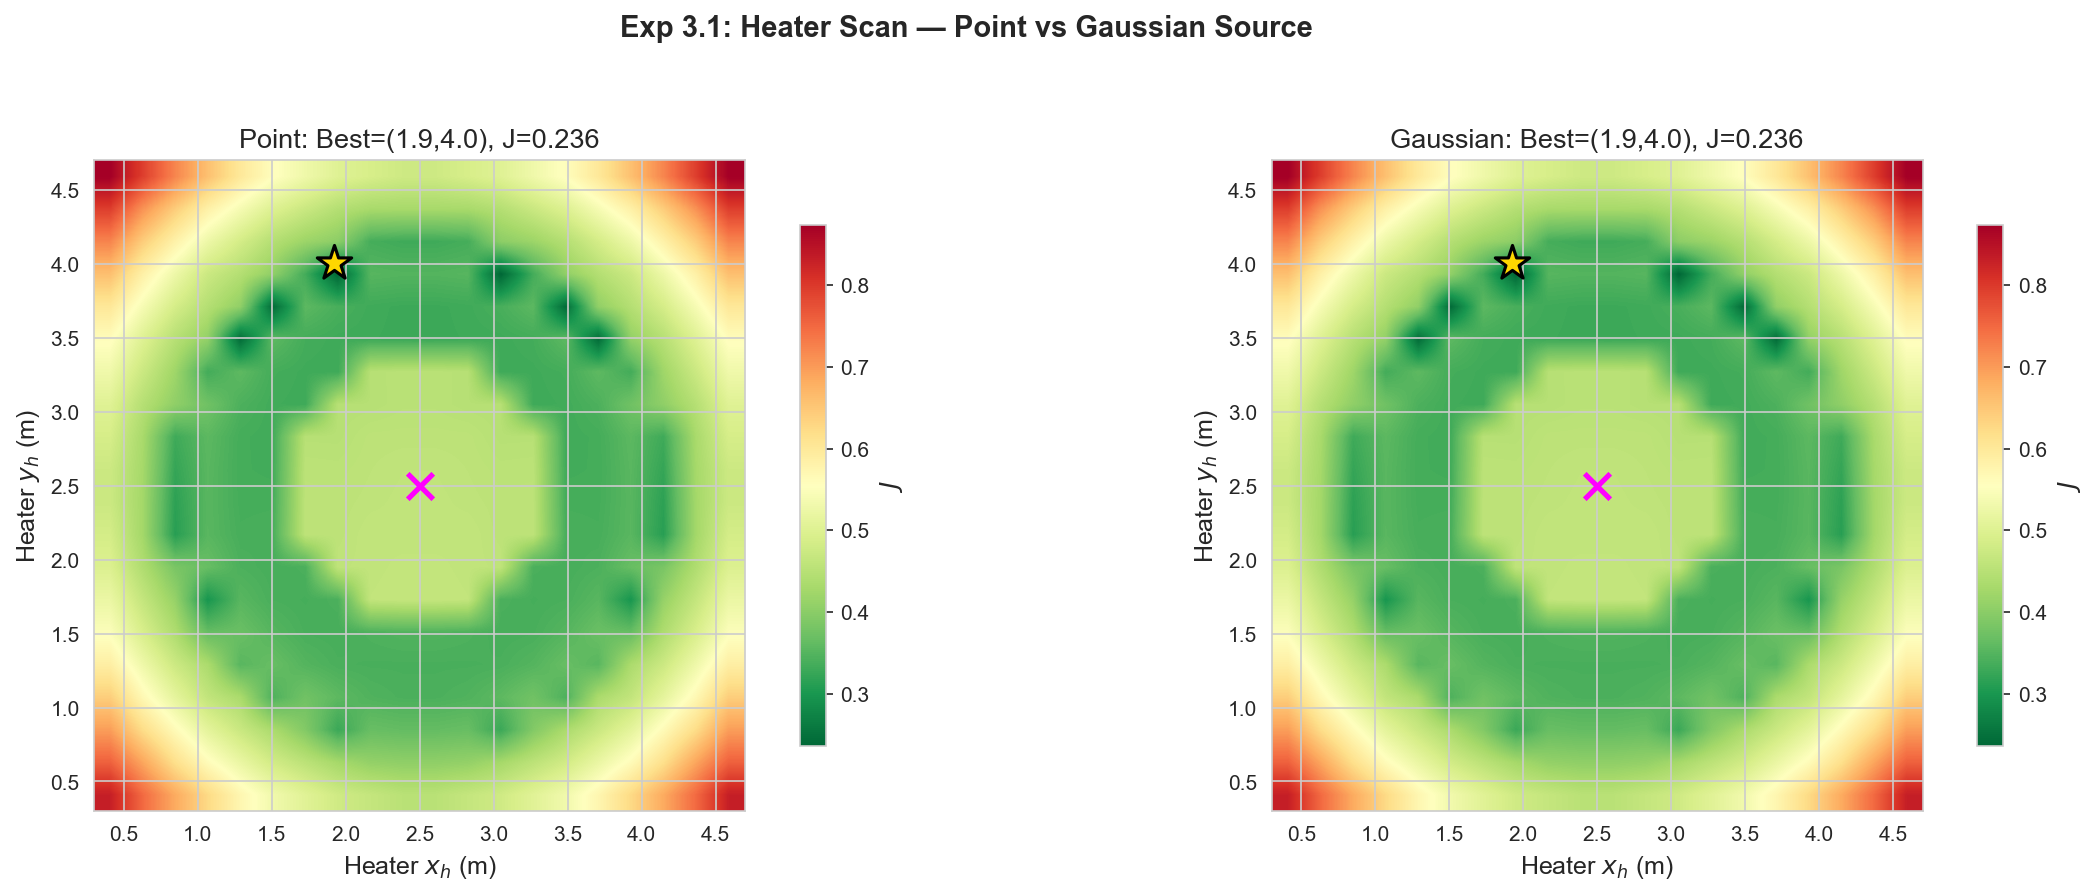

In [19]:
# ============================================================
# 实验 3.1: 高斯热源加热器 2D 扫描 (对应实验 1.4)
# ============================================================

print('=== 实验 3.1: 高斯热源加热器全房间扫描 ===')
df_31, ref_31 = sweep_heater_2d_grid(
    XS_FIX, YS_FIX, geometry='square', bc_type='RNNN',
    source_type='gauss', dx=0.25, margin=0.3
)

best_31 = df_31.loc[df_31['J'].idxmin()]
print(f'高斯最优加热器: ({best_31["x_h"]:.2f}, {best_31["y_h"]:.2f}), J={best_31["J"]:.4f}')

# --- 点 vs 高斯加热器扫描并排 ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Exp 3.1: Heater Scan — Point vs Gaussian Source', fontsize=14, fontweight='bold')

for ax, df, best, src_label in [(ax1, df_14, best_14, 'Point'),
                                  (ax2, df_31, best_31, 'Gaussian')]:
    matrix, xs, ys = df_to_matrix(df, 'x_h', 'y_h', 'J')
    im = ax.imshow(matrix, origin='lower', aspect='equal',
                   extent=[xs[0], xs[-1], ys[0], ys[-1]],
                   cmap='RdYlGn_r', interpolation='bilinear')
    plt.colorbar(im, ax=ax, label='$J$', shrink=0.8)
    ax.scatter(best['x_h'], best['y_h'], marker='*', s=300, color='gold',
              edgecolors='k', linewidth=1.5, zorder=10)
    ax.scatter(XS_FIX, YS_FIX, marker='x', s=150, color='magenta',
              linewidth=2.5, zorder=10)
    ax.set_xlabel('Heater $x_h$ (m)')
    ax.set_ylabel('Heater $y_h$ (m)')
    ax.set_title(f'{src_label}: Best=({best["x_h"]:.1f},{best["y_h"]:.1f}), J={best["J"]:.3f}')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(f'{OUT_DIR}/2D_exp3_1_heater_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

=== 实验 3.2: 高斯热源恒温器全房间扫描 ===
Scanning 400 thermostat positions (square, RNNN, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D thermostat scan:   0%|          | 0/400 [00:00<?, ?it/s]

高斯最优恒温器: (1.69, 2.38), J=0.3208


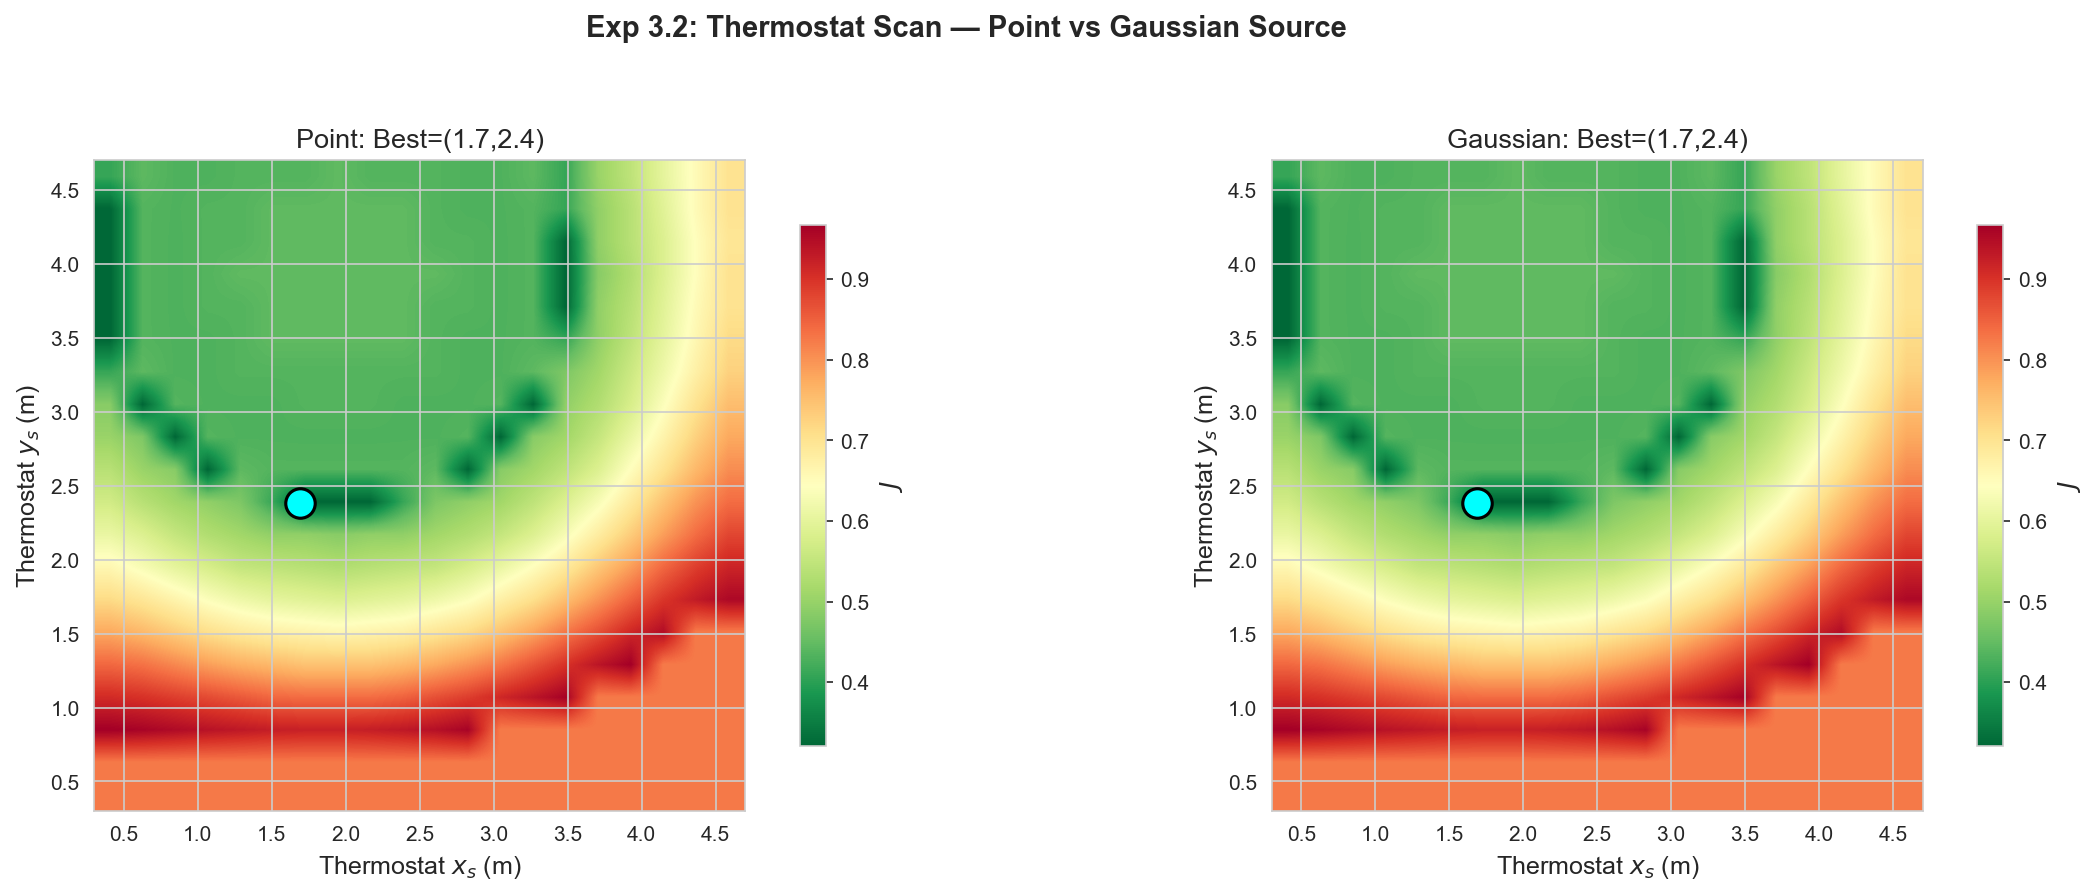

In [20]:
# ============================================================
# 实验 3.2: 高斯热源恒温器 2D 扫描 (对应实验 2.3)
# ============================================================

print('=== 实验 3.2: 高斯热源恒温器全房间扫描 ===')
df_32, ref_32 = sweep_thermostat_2d_grid(
    best_31['x_h'], best_31['y_h'], geometry='square', bc_type='RNNN',
    source_type='gauss', dx=0.25, margin=0.3
)

best_32 = df_32.loc[df_32['J'].idxmin()]
print(f'高斯最优恒温器: ({best_32["x_s"]:.2f}, {best_32["y_s"]:.2f}), J={best_32["J"]:.4f}')

# 点 vs 高斯恒温器扫描并排
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Exp 3.2: Thermostat Scan — Point vs Gaussian Source', fontsize=14, fontweight='bold')

for ax, df, src_label in [(ax1, df_23, 'Point'), (ax2, df_32, 'Gaussian')]:
    best_t = df.loc[df['J'].idxmin()]
    matrix, xs, ys = df_to_matrix(df, 'x_s', 'y_s', 'J')
    im = ax.imshow(matrix, origin='lower', aspect='equal',
                   extent=[xs[0], xs[-1], ys[0], ys[-1]],
                   cmap='RdYlGn_r', interpolation='bilinear')
    plt.colorbar(im, ax=ax, label='$J$', shrink=0.8)
    ax.scatter(best_t['x_s'], best_t['y_s'], marker='o', s=200, color='cyan',
              edgecolors='k', linewidth=1.5, zorder=10)
    ax.set_xlabel('Thermostat $x_s$ (m)')
    ax.set_ylabel('Thermostat $y_s$ (m)')
    ax.set_title(f'{src_label}: Best=({best_t["x_s"]:.1f},{best_t["y_s"]:.1f})')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(f'{OUT_DIR}/2D_exp3_2_thermostat_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

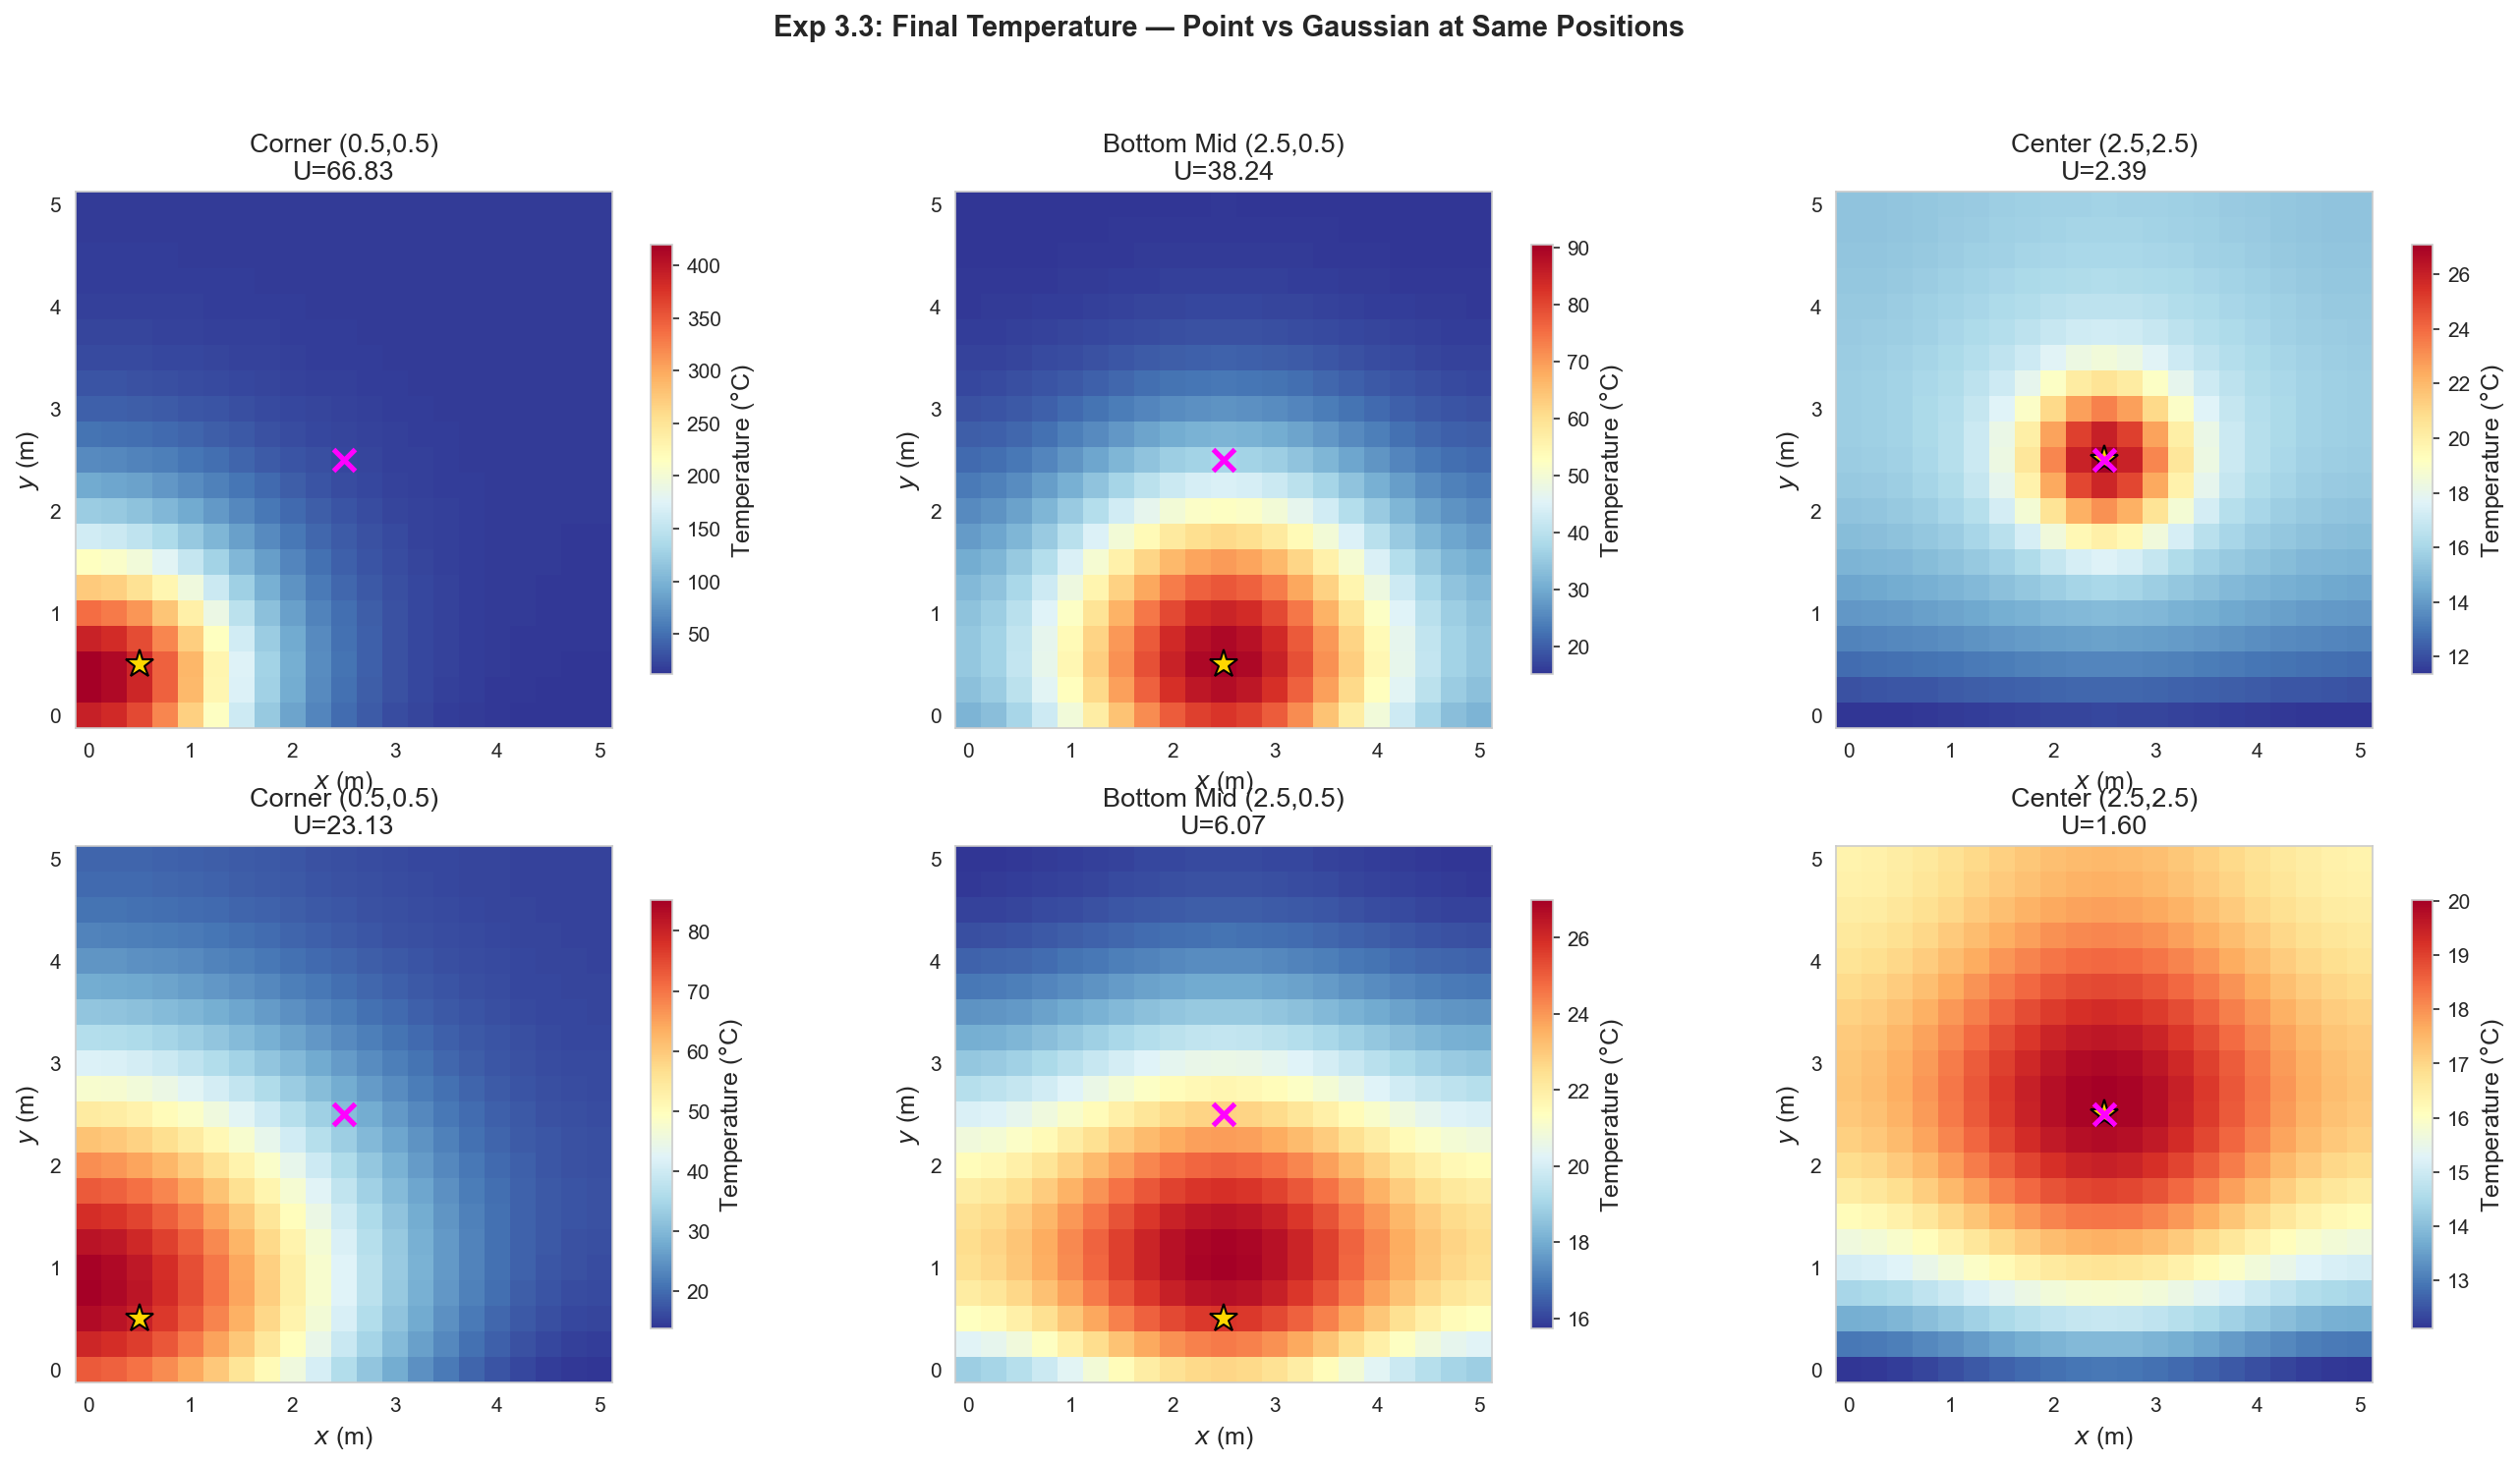

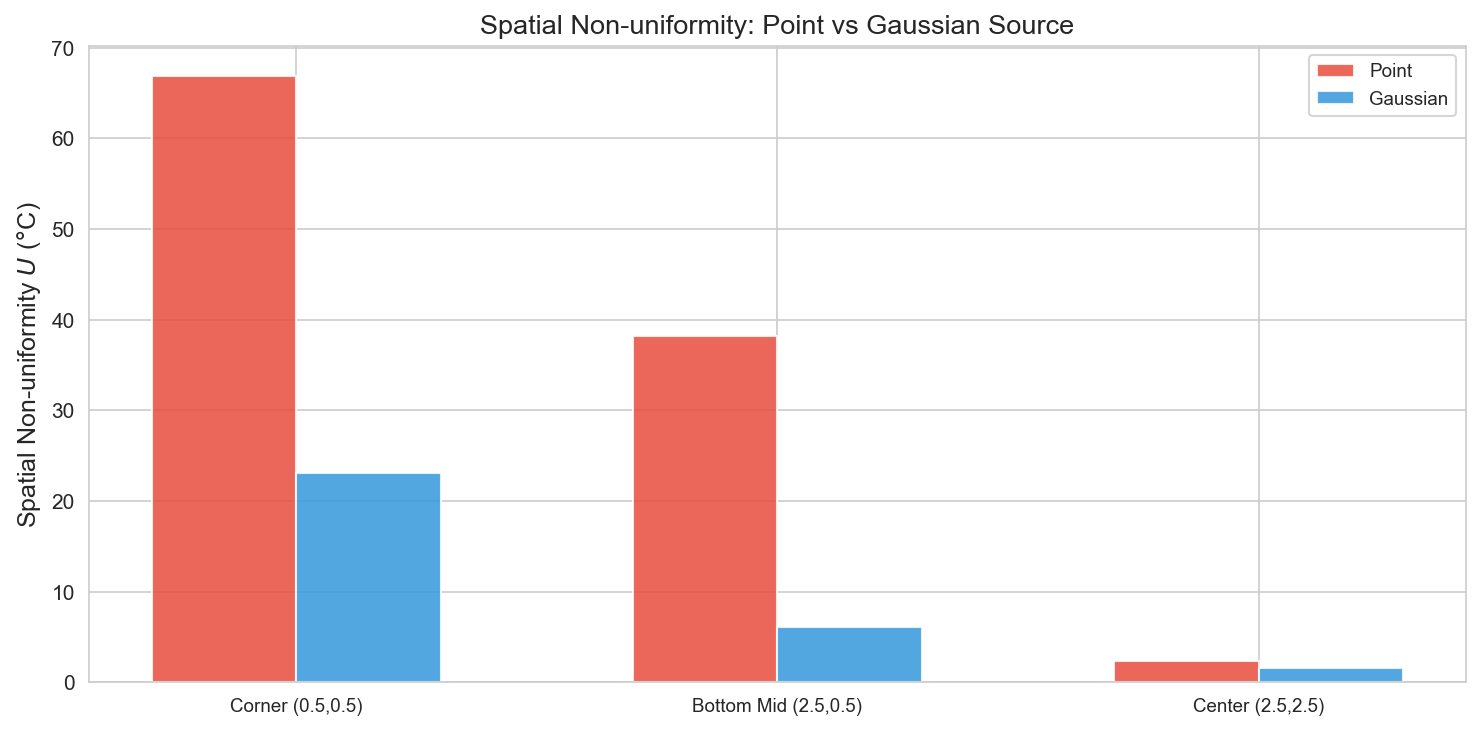

In [21]:
# ============================================================
# 实验 3.3: 同一位置下的终态温度场并排对比
# ============================================================

# 选 3 个代表性位置：靠近外墙角、外墙中点、房间中心
repr_positions = [(0.5, 0.5), (2.5, 0.5), (2.5, 2.5)]
labels = ['Corner (0.5,0.5)', 'Bottom Mid (2.5,0.5)', 'Center (2.5,2.5)']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Exp 3.3: Final Temperature — Point vs Gaussian at Same Positions',
             fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Point Source', fontsize=12)
axes[1, 0].set_ylabel('Gaussian Source', fontsize=12)

for col, ((xh, yh), label) in enumerate(zip(repr_positions, labels)):
    for row, src in enumerate(['point', 'gauss']):
        sim = simulate_2d(xh, yh, XS_FIX, YS_FIX,
                         geometry='square', bc_type='RNNN',
                         source_type=src, dx=0.25)
        m = compute_metrics_2d(sim)
        plot_2d_field(sim['T_final'], sim['x'], sim['y'], sim['mask'],
                     axes[row, col], x_h=xh, y_h=yh, x_s=XS_FIX, y_s=YS_FIX,
                     title=f'{label}\nU={m["U_spatial"]:.2f}')

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig(f'{OUT_DIR}/2D_exp3_3_field_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 空间均匀度对比柱状图
fig, ax = plt.subplots(figsize=(10, 5))
x_pos = np.arange(len(repr_positions))
u_point = []
u_gauss = []
for xh, yh in repr_positions:
    for src, lst in [('point', u_point), ('gauss', u_gauss)]:
        sim = simulate_2d(xh, yh, XS_FIX, YS_FIX,
                         geometry='square', bc_type='RNNN', source_type=src, dx=0.25)
        m = compute_metrics_2d(sim)
        lst.append(m['U_spatial'])

ax.bar(x_pos - 0.15, u_point, 0.3, color='#e74c3c', label='Point', alpha=0.85)
ax.bar(x_pos + 0.15, u_gauss, 0.3, color='#3498db', label='Gaussian', alpha=0.85)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=9)
ax.set_ylabel('Spatial Non-uniformity $U$ ($°$C)')
ax.set_title('Spatial Non-uniformity: Point vs Gaussian Source')
ax.legend()
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/2D_exp3_3_uniformity.png', dpi=300, bbox_inches='tight')
plt.show()

---

# 实验四：边界条件对比（RNNN vs RRRR）

对比"一面外墙"（RNNN）vs"四面外墙"（RRRR）。

**核心问题**：不同建筑类型下，最优位置是否不同？保温的价值有多大？

=== 实验 4.1: RRRR 加热器全房间扫描 ===
Scanning 400 heater positions (square, RRRR, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D heater scan:   0%|          | 0/400 [00:00<?, ?it/s]

RRRR 最优加热器: (1.69, 1.69), J=0.3714


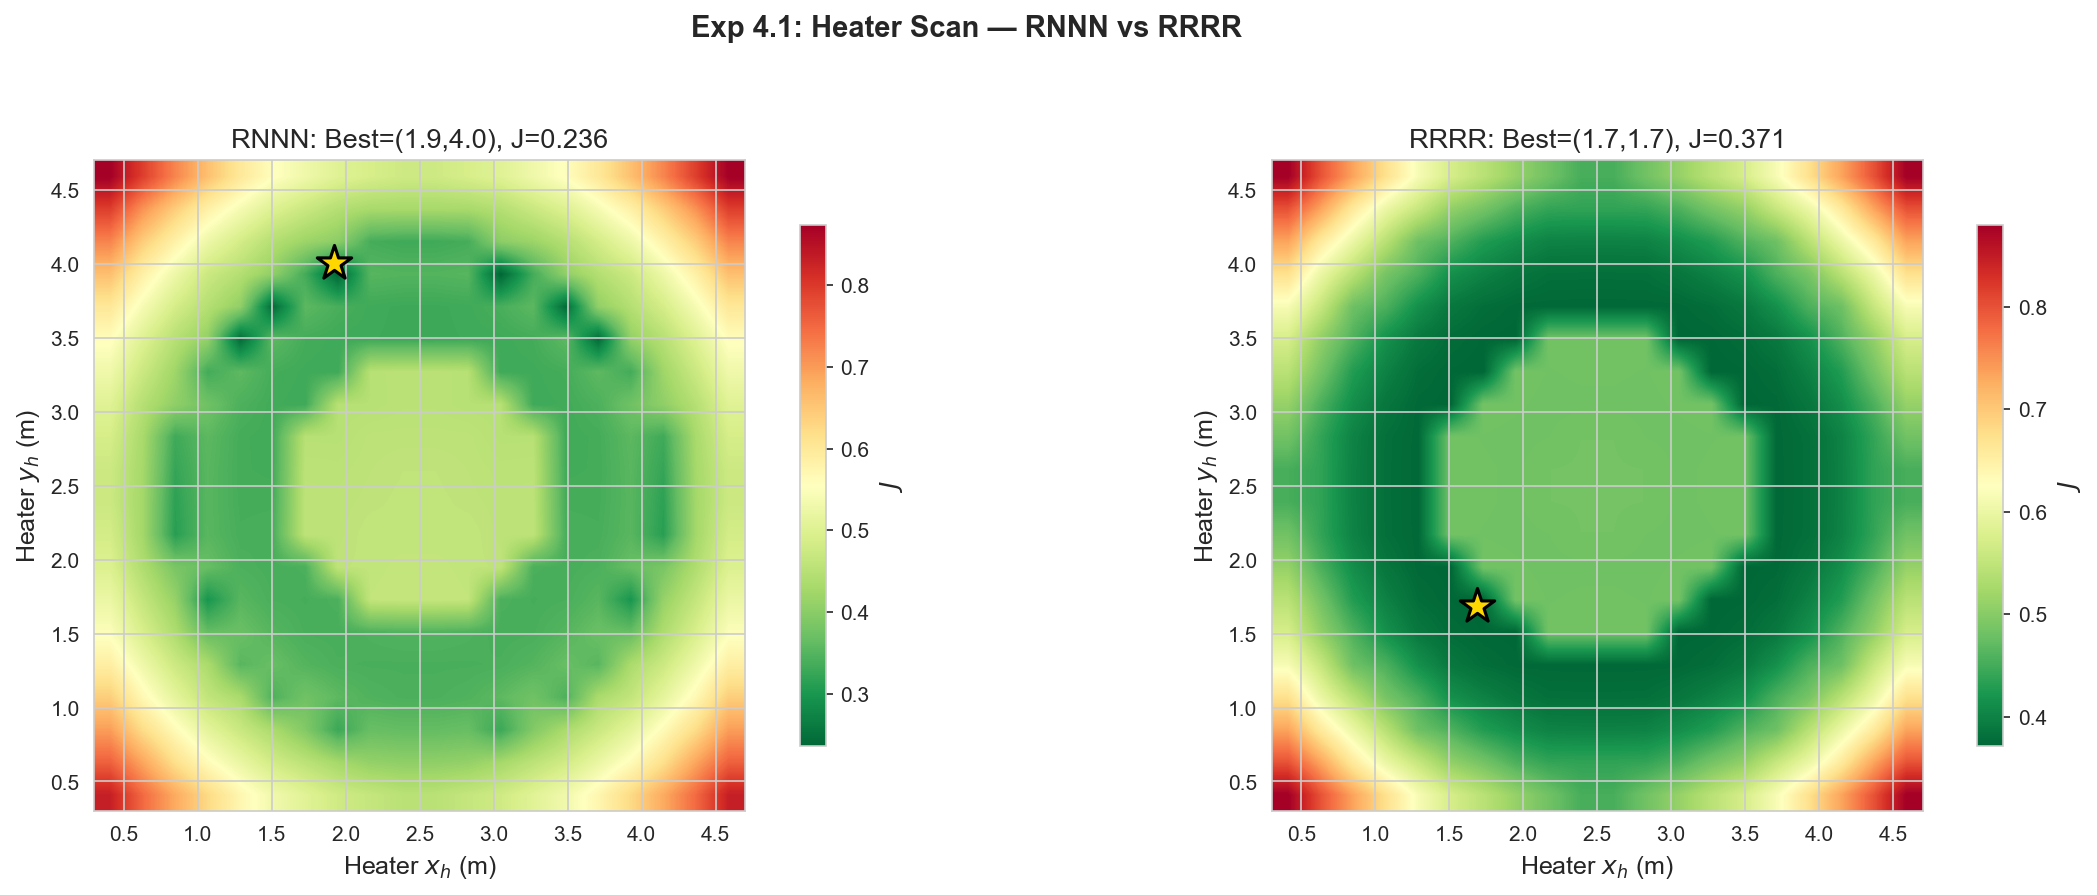

In [22]:
# ============================================================
# 实验 4.1: RRRR 加热器 2D 扫描
# ============================================================

print('=== 实验 4.1: RRRR 加热器全房间扫描 ===')
df_41, ref_41 = sweep_heater_2d_grid(
    XS_FIX, YS_FIX, geometry='square', bc_type='RRRR',
    source_type='gauss', dx=0.25, margin=0.3
)

best_41 = df_41.loc[df_41['J'].idxmin()]
print(f'RRRR 最优加热器: ({best_41["x_h"]:.2f}, {best_41["y_h"]:.2f}), J={best_41["J"]:.4f}')

# RNNN vs RRRR 加热器扫描并排
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Exp 4.1: Heater Scan — RNNN vs RRRR', fontsize=14, fontweight='bold')

for ax, df, best, bc_label in [(ax1, df_14, best_14, 'RNNN'),
                                 (ax2, df_41, best_41, 'RRRR')]:
    matrix, xs, ys = df_to_matrix(df, 'x_h', 'y_h', 'J')
    im = ax.imshow(matrix, origin='lower', aspect='equal',
                   extent=[xs[0], xs[-1], ys[0], ys[-1]],
                   cmap='RdYlGn_r', interpolation='bilinear')
    plt.colorbar(im, ax=ax, label='$J$', shrink=0.8)
    ax.scatter(best['x_h'], best['y_h'], marker='*', s=300, color='gold',
              edgecolors='k', linewidth=1.5, zorder=10)
    ax.set_xlabel('Heater $x_h$ (m)')
    ax.set_ylabel('Heater $y_h$ (m)')
    ax.set_title(f'{bc_label}: Best=({best["x_h"]:.1f},{best["y_h"]:.1f}), J={best["J"]:.3f}')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(f'{OUT_DIR}/2D_exp4_1_heater_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

=== 实验 4.2: RRRR 恒温器全房间扫描 ===
Scanning 400 thermostat positions (square, RRRR, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D thermostat scan:   0%|          | 0/400 [00:00<?, ?it/s]

RRRR 最优恒温器: (3.08, 1.23), J=0.3545


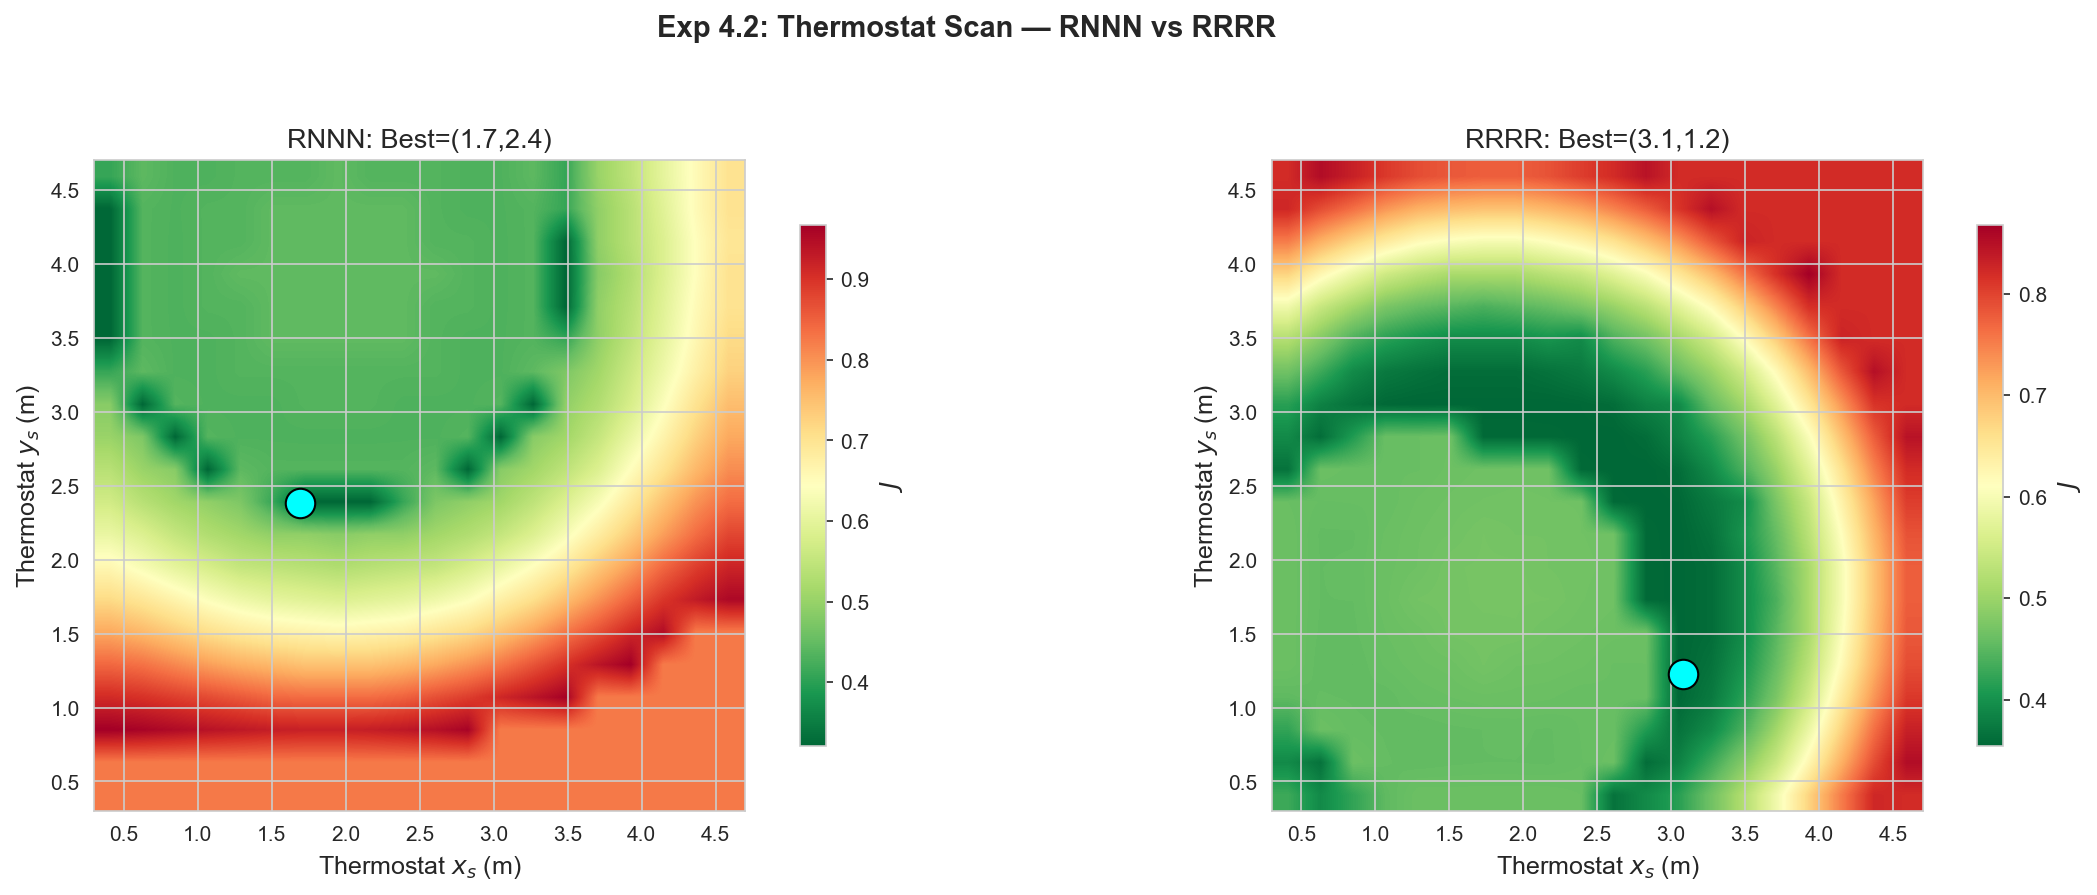

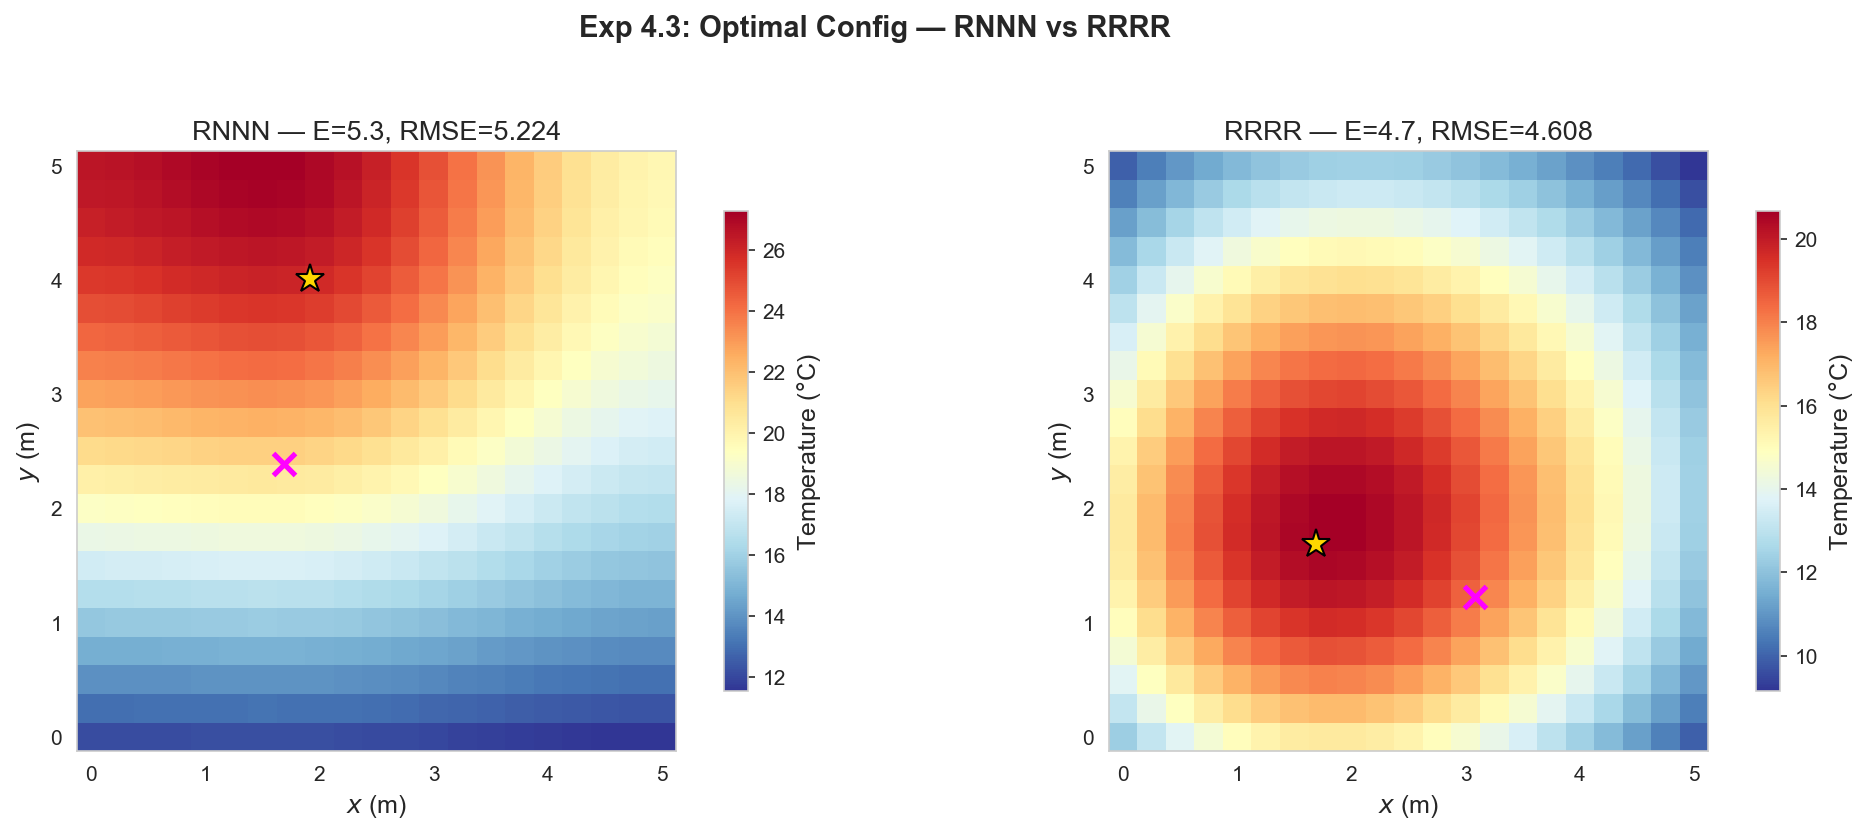

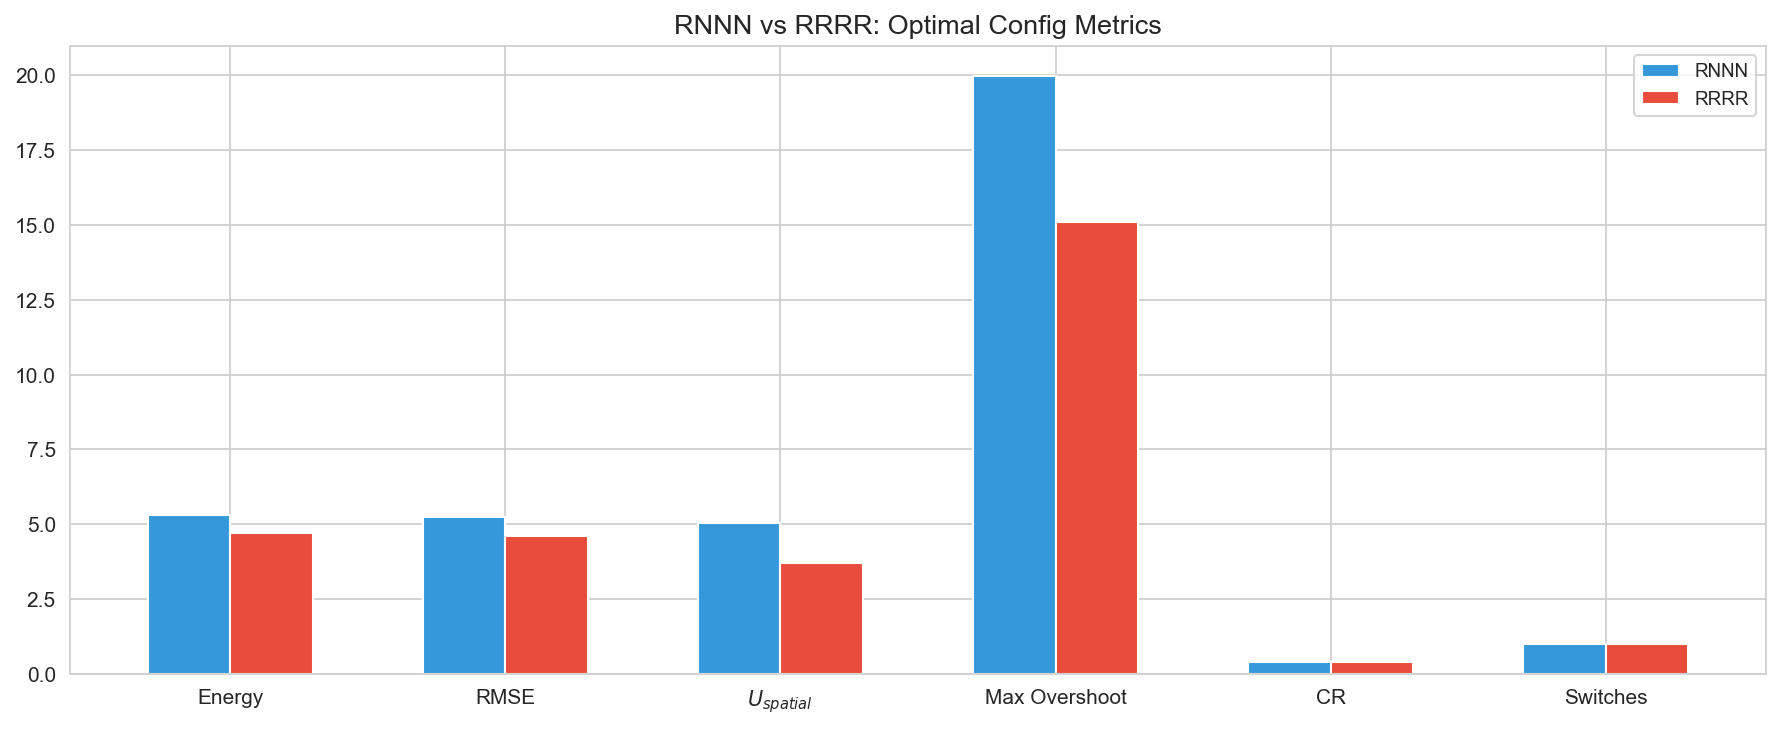


保温价值: RNNN 能耗 5.3 vs RRRR 能耗 4.7
节能比例: -13.3%


In [23]:
# ============================================================
# 实验 4.2: RRRR 恒温器扫描 + 4.3 最优方案对比
# ============================================================

print('=== 实验 4.2: RRRR 恒温器全房间扫描 ===')
df_42, ref_42 = sweep_thermostat_2d_grid(
    best_41['x_h'], best_41['y_h'], geometry='square', bc_type='RRRR',
    source_type='gauss', dx=0.25, margin=0.3
)

best_42 = df_42.loc[df_42['J'].idxmin()]
print(f'RRRR 最优恒温器: ({best_42["x_s"]:.2f}, {best_42["y_s"]:.2f}), J={best_42["J"]:.4f}')

# RNNN vs RRRR 恒温器扫描并排
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Exp 4.2: Thermostat Scan — RNNN vs RRRR', fontsize=14, fontweight='bold')
for ax, df, bc_label in [(ax1, df_23, 'RNNN'), (ax2, df_42, 'RRRR')]:
    best_t = df.loc[df['J'].idxmin()]
    matrix, xs, ys = df_to_matrix(df, 'x_s', 'y_s', 'J')
    im = ax.imshow(matrix, origin='lower', aspect='equal',
                   extent=[xs[0], xs[-1], ys[0], ys[-1]],
                   cmap='RdYlGn_r', interpolation='bilinear')
    plt.colorbar(im, ax=ax, label='$J$', shrink=0.8)
    ax.scatter(best_t['x_s'], best_t['y_s'], marker='o', s=200, color='cyan',
              edgecolors='k', zorder=10)
    ax.set_xlabel('Thermostat $x_s$ (m)')
    ax.set_ylabel('Thermostat $y_s$ (m)')
    ax.set_title(f'{bc_label}: Best=({best_t["x_s"]:.1f},{best_t["y_s"]:.1f})')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(f'{OUT_DIR}/2D_exp4_2_thermostat_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 4.3: 两种 BC 最优方案终态温度场对比 ---
sim_rnnn = simulate_2d(best_14['x_h'], best_14['y_h'], best_23['x_s'], best_23['y_s'],
                       geometry='square', bc_type='RNNN', source_type='gauss', dx=0.25)
sim_rrrr = simulate_2d(best_41['x_h'], best_41['y_h'], best_42['x_s'], best_42['y_s'],
                       geometry='square', bc_type='RRRR', source_type='gauss', dx=0.25)
m_rnnn = compute_metrics_2d(sim_rnnn)
m_rrrr = compute_metrics_2d(sim_rrrr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5.5))
fig.suptitle('Exp 4.3: Optimal Config — RNNN vs RRRR', fontsize=14, fontweight='bold')

plot_2d_field(sim_rnnn['T_final'], sim_rnnn['x'], sim_rnnn['y'], sim_rnnn['mask'],
              ax1, x_h=best_14['x_h'], y_h=best_14['y_h'],
              x_s=best_23['x_s'], y_s=best_23['y_s'],
              title=f'RNNN — E={m_rnnn["E"]:.1f}, RMSE={m_rnnn["RMSE"]:.3f}')
plot_2d_field(sim_rrrr['T_final'], sim_rrrr['x'], sim_rrrr['y'], sim_rrrr['mask'],
              ax2, x_h=best_41['x_h'], y_h=best_41['y_h'],
              x_s=best_42['x_s'], y_s=best_42['y_s'],
              title=f'RRRR — E={m_rrrr["E"]:.1f}, RMSE={m_rrrr["RMSE"]:.3f}')

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(f'{OUT_DIR}/2D_exp4_3_optimal_fields.png', dpi=300, bbox_inches='tight')
plt.show()

# 指标柱状图
fig, ax = plt.subplots(figsize=(12, 5))
keys = ['E', 'RMSE', 'U_spatial', 'DeltaT_max', 'CR', 'N_sw']
labels_k = ['Energy', 'RMSE', '$U_{spatial}$', 'Max Overshoot', 'CR', 'Switches']
x_pos = np.arange(len(keys))
ax.bar(x_pos - 0.15, [m_rnnn[k] for k in keys], 0.3, color='#3498db', label='RNNN')
ax.bar(x_pos + 0.15, [m_rrrr[k] for k in keys], 0.3, color='#e74c3c', label='RRRR')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels_k, fontsize=10)
ax.set_title('RNNN vs RRRR: Optimal Config Metrics')
ax.legend()
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/2D_exp4_3_metrics_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'\n保温价值: RNNN 能耗 {m_rnnn["E"]:.1f} vs RRRR 能耗 {m_rrrr["E"]:.1f}')
print(f'节能比例: {(m_rrrr["E"]-m_rnnn["E"])/m_rrrr["E"]*100:.1f}%')

---

# 实验五：全枚举 — 加热器 $\times$ 恒温器 $\times$ 热源 $\times$ BC 联合搜索

枚举空间：加热器 $5 \times 5$ + 恒温器 $5 \times 5$ + 2 热源 + 2 BC = 2500 种方案

In [24]:
# ============================================================
# 实验 5.1: 全枚举搜索
# ============================================================

# 粗网格枚举
H_GRID = get_domain_sample_points('square', n_per_side=5, margin=0.5)
S_GRID = get_domain_sample_points('square', n_per_side=5, margin=0.5)
SOURCES = ['point', 'gauss']
BCS = ['RNNN', 'RRRR']

total = len(H_GRID) * len(S_GRID) * len(SOURCES) * len(BCS)
print(f'全枚举: {len(H_GRID)} heater × {len(S_GRID)} thermostat × '
      f'{len(SOURCES)} source × {len(BCS)} BC = {total} 方案')

enum_results_5 = []
count = 0
for src in SOURCES:
    for bc in BCS:
        print(f'\n--- {src}, {bc} ---')
        for x_h, y_h in H_GRID:
            for x_s, y_s in S_GRID:
                sim = simulate_2d(x_h, y_h, x_s, y_s,
                                  geometry='square', bc_type=bc,
                                  source_type=src, dx=0.25)
                m = compute_metrics_2d(sim)
                enum_results_5.append({
                    'x_h': x_h, 'y_h': y_h, 'x_s': x_s, 'y_s': y_s,
                    'source': src, 'bc': bc, **m
                })
                count += 1
        print(f'  完成 {count}/{total}')

df_enum_5 = pd.DataFrame(enum_results_5)

# 计算 J 值
ref_5 = compute_ref_maxes(enum_results_5)
for wname, w in WEIGHT_SCHEMES.items():
    df_enum_5[f'J_{wname}'] = df_enum_5.apply(
        lambda r: compute_unified_cost(
            {k: r[k] for k in ['E','RMSE','DeltaT_max','CR','t_s','N_sw','U_spatial']},
            ref_5, w), axis=1)

df_enum_5.to_csv(f'{OUT_DIR}/2D_full_enumeration.csv', index=False)
print(f'\n全枚举完成。总方案: {len(df_enum_5)}')
print(f'\n全局 Top-5 (Balanced):')
display(df_enum_5.nsmallest(5, 'J_Balanced')[
    ['x_h','y_h','x_s','y_s','source','bc','E','RMSE','CR','N_sw','J_Balanced']
])

全枚举: 25 heater × 25 thermostat × 2 source × 2 BC = 2500 方案

--- point, RNNN ---
  完成 625/2500

--- point, RRRR ---
  完成 1250/2500

--- gauss, RNNN ---
  完成 1875/2500

--- gauss, RRRR ---
  完成 2500/2500

全枚举完成。总方案: 2500

全局 Top-5 (Balanced):


x_h  y_h  x_s  y_s source    bc       E      RMSE        CR  N_sw  \
1556  2.5  2.5  1.5  1.5  gauss  RNNN  4.6875  3.086100  0.610098     1   
1558  2.5  2.5  3.5  1.5  gauss  RNNN  4.6875  3.086100  0.610098     1   
1566  2.5  2.5  1.5  3.5  gauss  RNNN  4.6875  3.086100  0.610098     1   
1568  2.5  2.5  3.5  3.5  gauss  RNNN  4.6875  3.086100  0.610098     1   
1686  2.5  3.5  1.5  2.5  gauss  RNNN  4.6875  3.878951  0.549779     1   

      J_Balanced  
1556    0.256694  
1558    0.256694  
1566    0.256694  
1568    0.256694  
1686    0.268288

全局最优: heater=(2.50,2.50), thermo=(1.50,1.50), source=gauss, bc=RNNN, J=0.2567


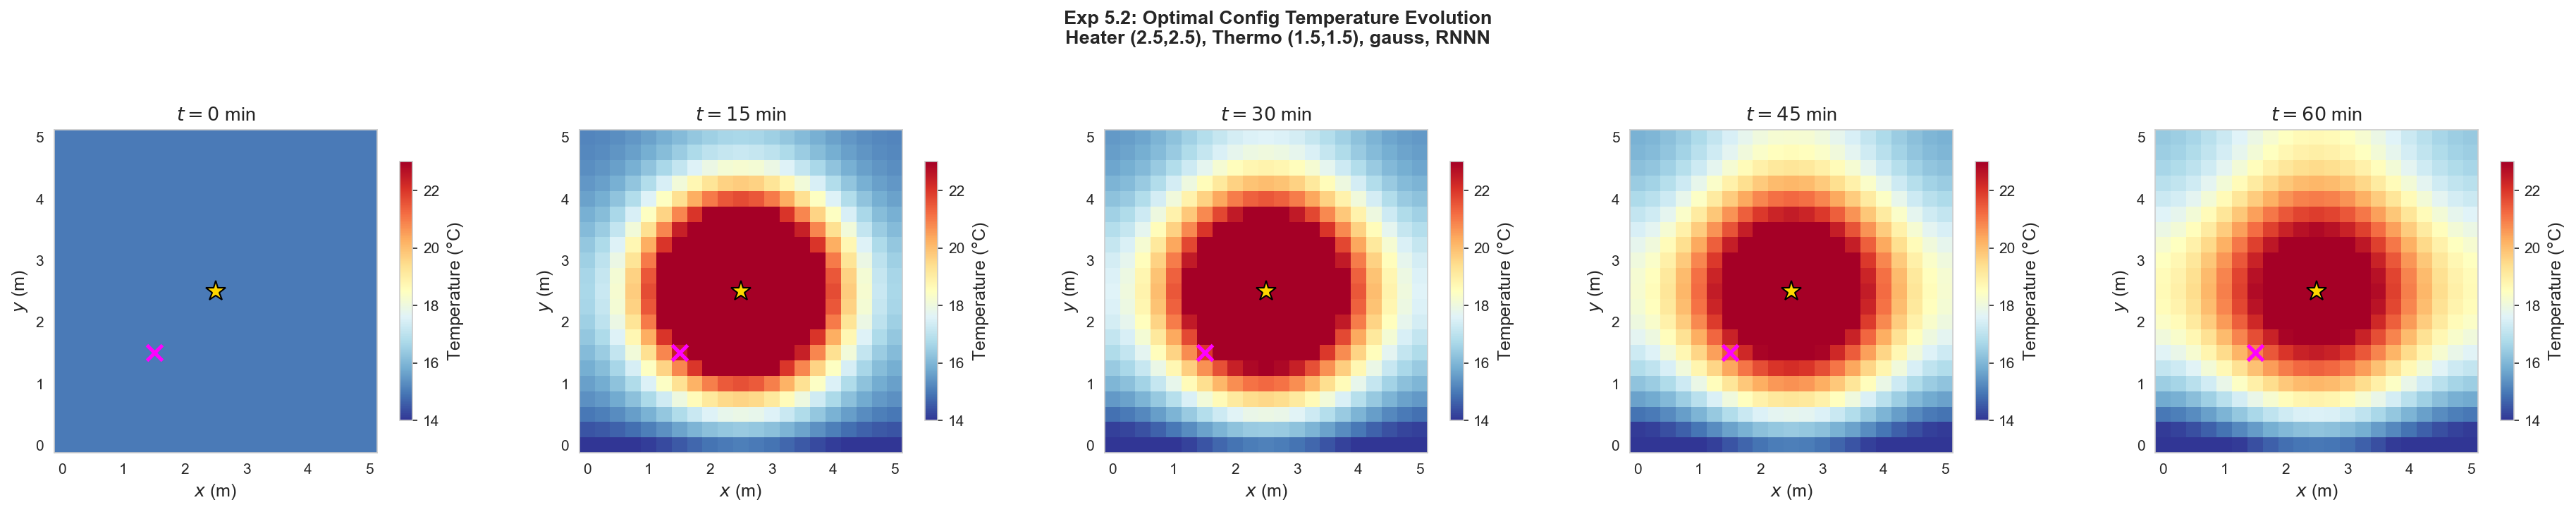

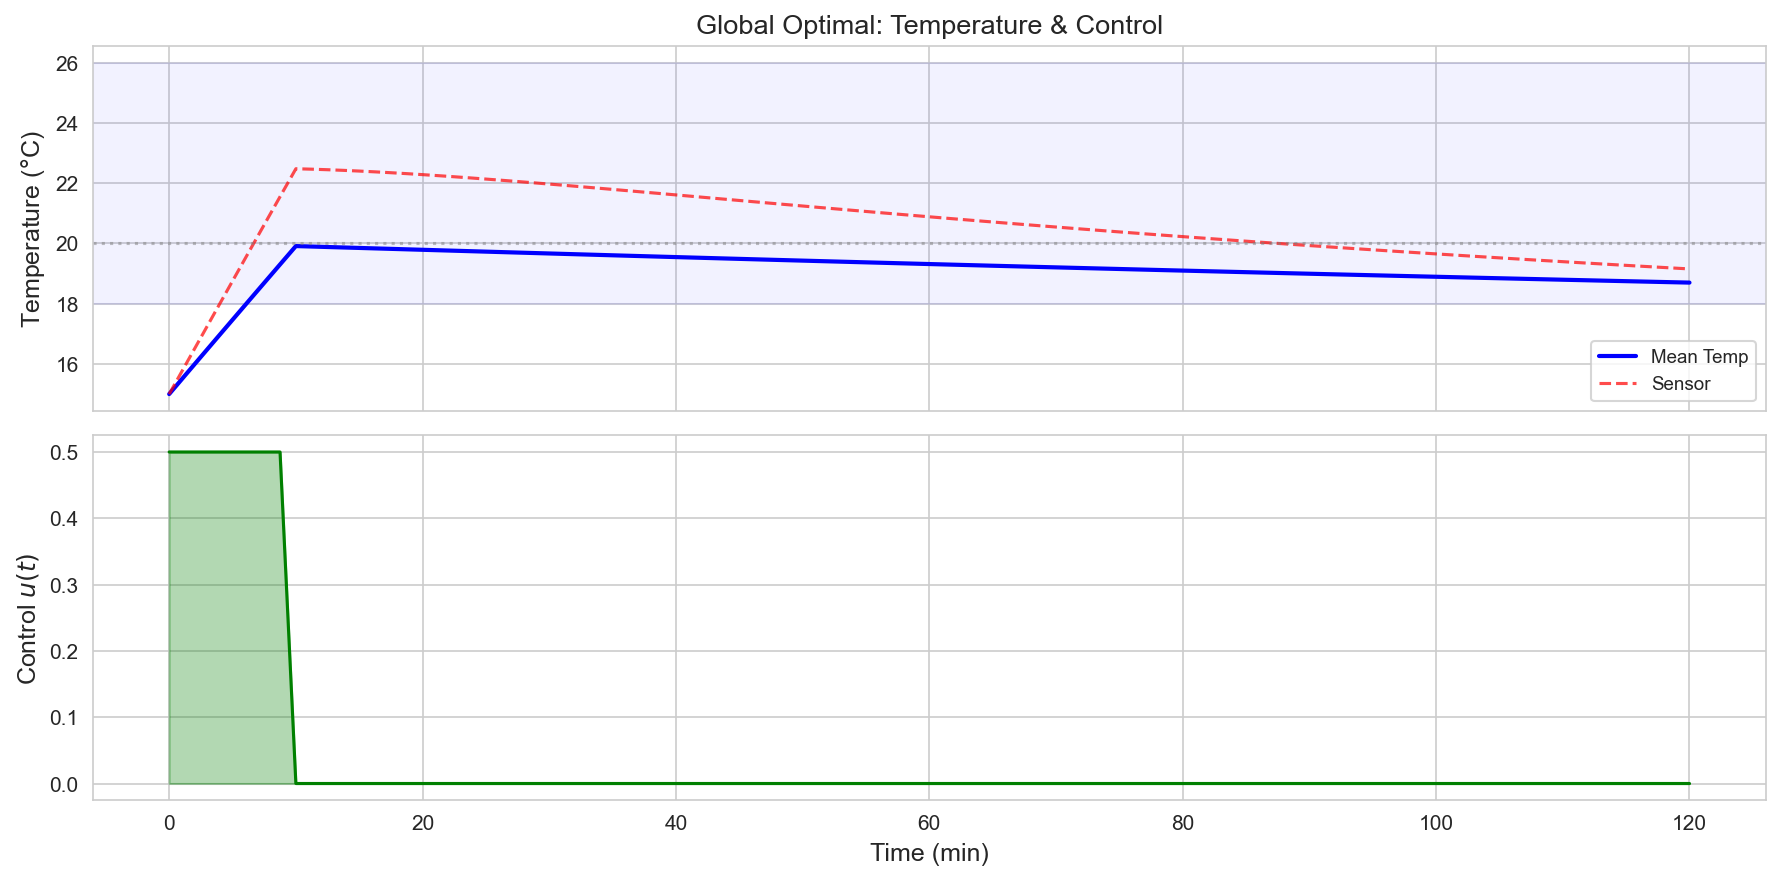


=== Top-10 排名 (Balanced) ===


x_h  y_h  x_s  y_s source    bc       E      RMSE  DeltaT_max        CR  \
1556  2.5  2.5  1.5  1.5  gauss  RNNN  4.6875  3.086100   13.814187  0.610098   
1558  2.5  2.5  3.5  1.5  gauss  RNNN  4.6875  3.086100   13.814187  0.610098   
1566  2.5  2.5  1.5  3.5  gauss  RNNN  4.6875  3.086100   13.814187  0.610098   
1568  2.5  2.5  3.5  3.5  gauss  RNNN  4.6875  3.086100   13.814187  0.610098   
1686  2.5  3.5  1.5  2.5  gauss  RNNN  4.6875  3.878951   14.928468  0.549779   
1688  2.5  3.5  3.5  2.5  gauss  RNNN  4.6875  3.878951   14.928468  0.549779   
1696  2.5  3.5  1.5  4.5  gauss  RNNN  4.6875  3.878951   14.928468  0.549779   
1698  2.5  3.5  3.5  4.5  gauss  RNNN  4.6875  3.878951   14.928468  0.549779   
1426  2.5  1.5  1.5  0.5  gauss  RNNN  4.6875  3.283289   14.928380  0.520247   
1428  2.5  1.5  3.5  0.5  gauss  RNNN  4.6875  3.283289   14.928380  0.520247   

      N_sw  J_Balanced  
1556     1    0.256694  
1558     1    0.256694  
1566     1    0.256694  
1568     1    0.256694  
1686     1    0.268288  
1688     1    0.268288  
1696     1    0.268288  
1698     1    0.268288  
1426     1    0.270944  
1428     1    0.270944


=== 舒适导向 Top-3 ===


x_h  y_h  x_s  y_s source    bc  J_Comfort  J_Balanced
1556  2.5  2.5  1.5  1.5  gauss  RNNN   0.264716    0.256694
1558  2.5  2.5  3.5  1.5  gauss  RNNN   0.264716    0.256694
1566  2.5  2.5  1.5  3.5  gauss  RNNN   0.264716    0.256694


=== 节能导向 Top-3 ===


x_h  y_h  x_s  y_s source    bc  J_Energy  J_Balanced
1556  2.5  2.5  1.5  1.5  gauss  RNNN  0.246313    0.256694
1558  2.5  2.5  3.5  1.5  gauss  RNNN  0.246313    0.256694
1566  2.5  2.5  1.5  3.5  gauss  RNNN  0.246313    0.256694

In [25]:
# ============================================================
# 实验 5.2: 全局最优方案可视化
# ============================================================

# 最优方案
best_5 = df_enum_5.loc[df_enum_5['J_Balanced'].idxmin()]
print(f'全局最优: heater=({best_5["x_h"]:.2f},{best_5["y_h"]:.2f}), '
      f'thermo=({best_5["x_s"]:.2f},{best_5["y_s"]:.2f}), '
      f'source={best_5["source"]}, bc={best_5["bc"]}, J={best_5["J_Balanced"]:.4f}')

# 温度场演化
sim_best_5 = simulate_2d(
    best_5['x_h'], best_5['y_h'], best_5['x_s'], best_5['y_s'],
    geometry='square', bc_type=best_5['bc'], source_type=best_5['source'],
    dx=0.25, return_field=True, field_save_times=[0, 15, 30, 45, 60]
)

fig, axes = plt.subplots(1, 5, figsize=(25, 4.5))
fig.suptitle(f'Exp 5.2: Optimal Config Temperature Evolution\n'
             f'Heater ({best_5["x_h"]:.1f},{best_5["y_h"]:.1f}), '
             f'Thermo ({best_5["x_s"]:.1f},{best_5["y_s"]:.1f}), '
             f'{best_5["source"]}, {best_5["bc"]}',
             fontsize=13, fontweight='bold')

times = [0, 15, 30, 45, 60]
vmin = T_INIT - 1
vmax = T_SET + 3
for ax, t_snap in zip(axes, times):
    if t_snap in sim_best_5['saved_fields']:
        T_snap = sim_best_5['saved_fields'][t_snap]
    else:
        T_snap = sim_best_5['T_final']
    plot_2d_field(T_snap, sim_best_5['x'], sim_best_5['y'], sim_best_5['mask'],
                 ax, x_h=best_5['x_h'], y_h=best_5['y_h'],
                 x_s=best_5['x_s'], y_s=best_5['y_s'],
                 vmin=vmin, vmax=vmax,
                 title=f'$t={t_snap}$ min')

plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.savefig(f'{OUT_DIR}/2D_exp5_2_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

# 控制信号 + 均温
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax1.plot(sim_best_5['t'], sim_best_5['T_mean'], 'b-', linewidth=2, label='Mean Temp')
ax1.plot(sim_best_5['t'], sim_best_5['T_sensor'], 'r--', alpha=0.7, label='Sensor')
ax1.axhline(T_SET, color='gray', linestyle=':', alpha=0.5)
ax1.axhspan(T_COMFORT_LOW, T_COMFORT_HIGH, alpha=0.05, color='blue')
ax1.set_ylabel('Temperature ($°$C)')
ax1.legend()
ax1.set_title('Global Optimal: Temperature & Control')

ax2.fill_between(sim_best_5['t'], 0, sim_best_5['u'], alpha=0.3, color='green')
ax2.plot(sim_best_5['t'], sim_best_5['u'], 'g-')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Control $u(t)$')
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/2D_exp5_2_control.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 5.3: Top-10 排名 ---
print('\n=== Top-10 排名 (Balanced) ===')
top10 = df_enum_5.nsmallest(10, 'J_Balanced')[
    ['x_h','y_h','x_s','y_s','source','bc','E','RMSE','DeltaT_max','CR','N_sw','J_Balanced']
]
display(top10)

# 舒适 vs 节能对比
print('\n=== 舒适导向 Top-3 ===')
display(df_enum_5.nsmallest(3, 'J_Comfort')[
    ['x_h','y_h','x_s','y_s','source','bc','J_Comfort','J_Balanced']
])
print('\n=== 节能导向 Top-3 ===')
display(df_enum_5.nsmallest(3, 'J_Energy')[
    ['x_h','y_h','x_s','y_s','source','bc','J_Energy','J_Balanced']
])

---

# 实验六：辅助可视化工具

提供通用可视化函数，可输入任意方案查看详细行为。

=== Demo: 全局最优方案可视化 ===


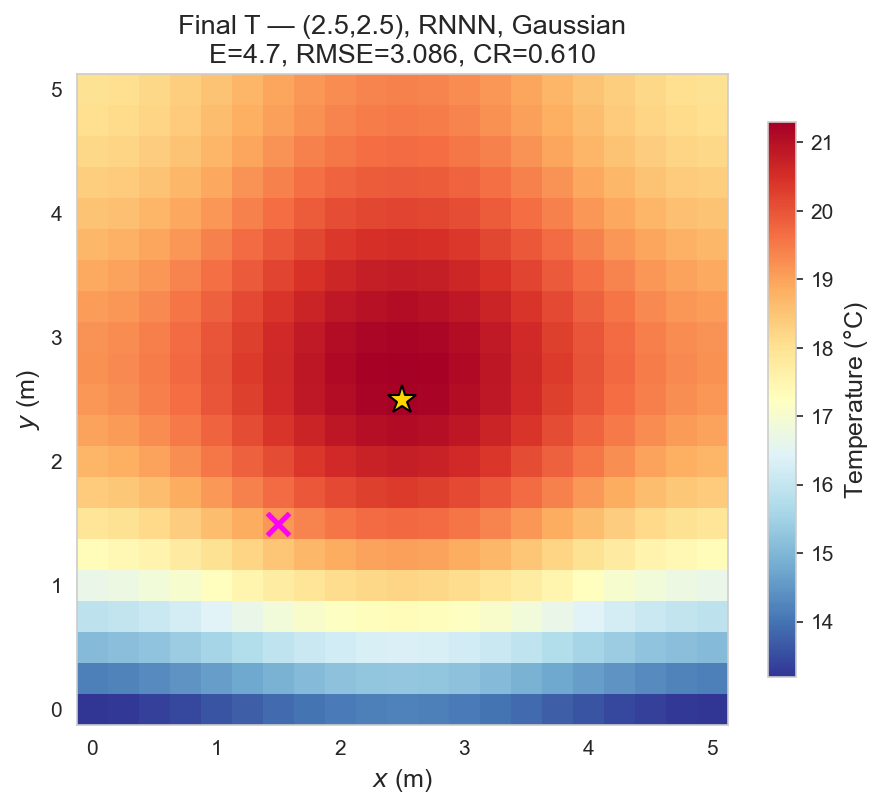

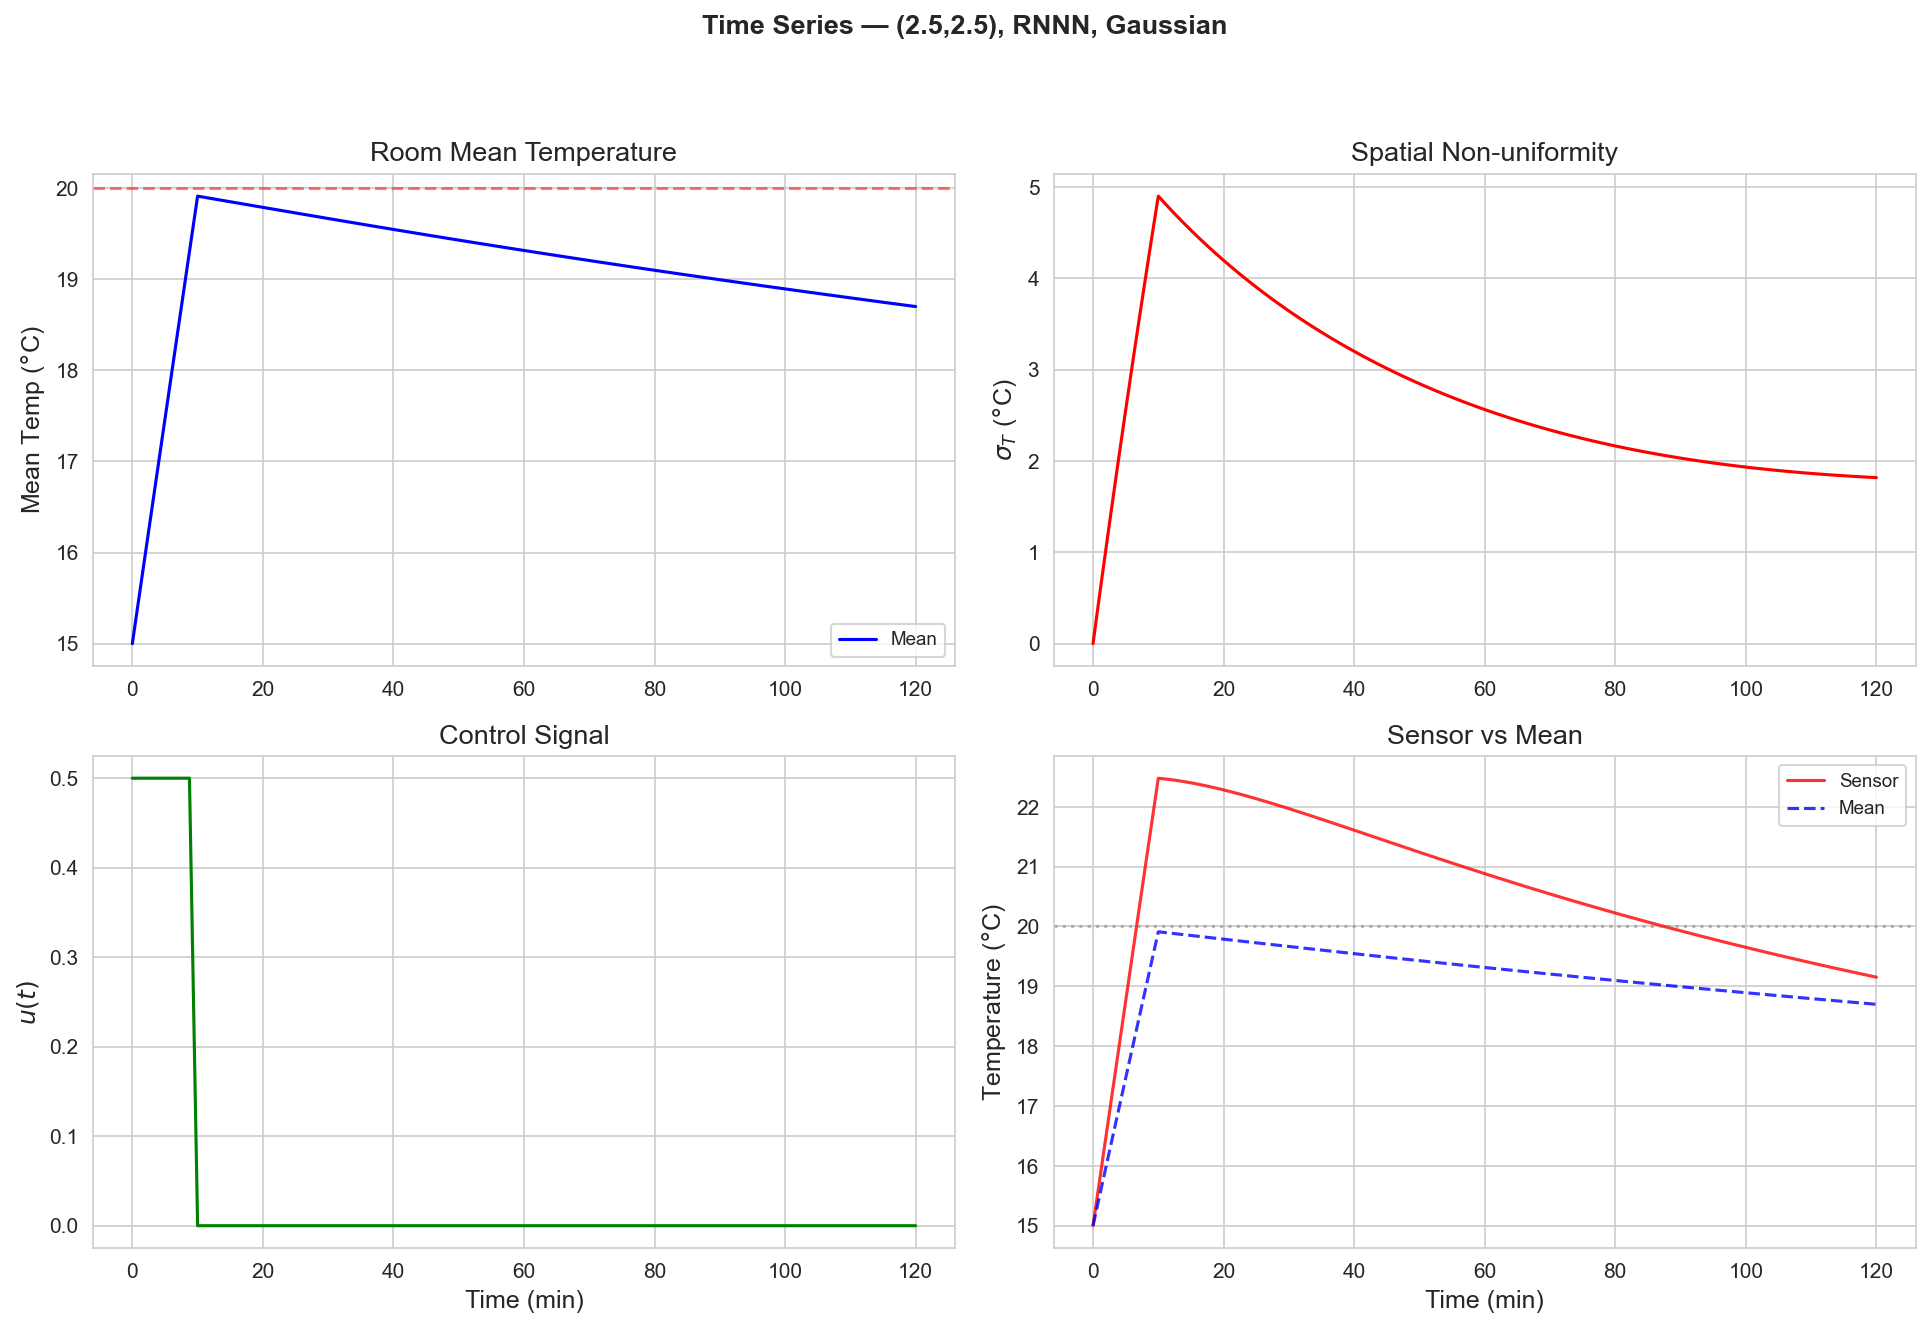

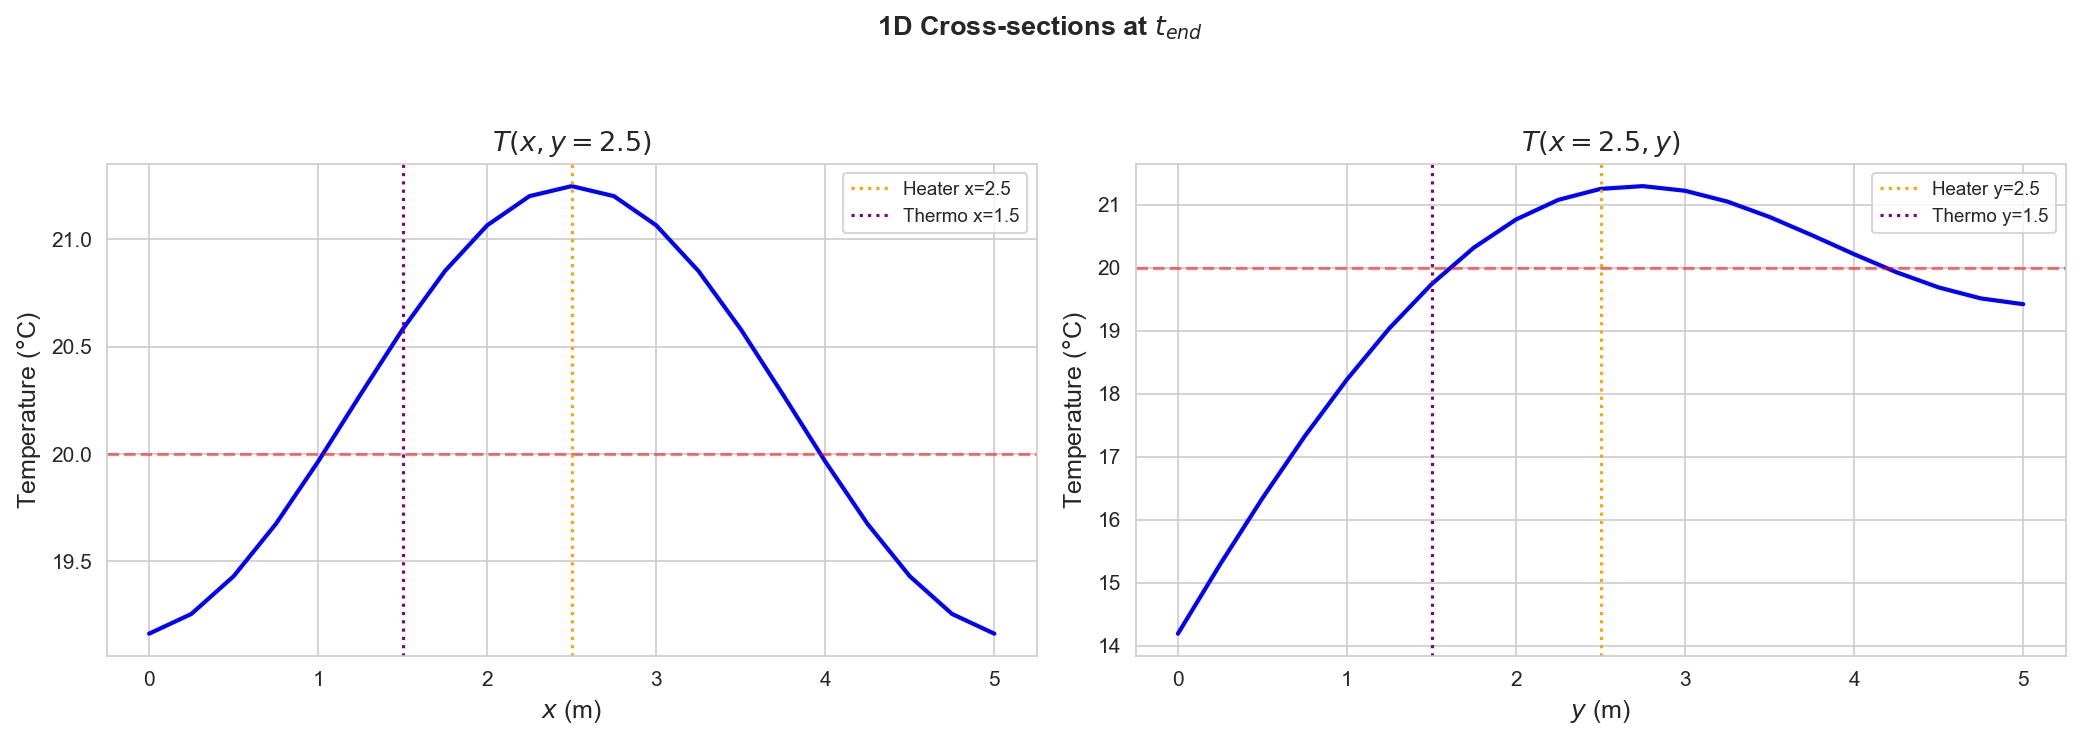

Metrics: {'E': '4.688', 'RMSE': '3.086', 'DeltaT_max': '13.814', 'CR': '0.610', 't_s': '120.000', 'N_sw': '1.000', 'U_spatial': '2.715'}


In [34]:
# ============================================================
# 实验 6: 辅助可视化工具
# ============================================================

def plot_any_config(x_h, y_h, x_s, y_s, geometry='square', bc_type='RNNN',
                    source_type='gauss', dx=0.25, save_prefix=None):
    """输入任意配置，输出完整可视化面板"""
    sim = simulate_2d(x_h, y_h, x_s, y_s, geometry=geometry, bc_type=bc_type,
                      source_type=source_type, dx=dx, return_field=True)
    m = compute_metrics_2d(sim)
    
    bc_label = bc_type
    src_label = 'Point' if source_type == 'point' else 'Gaussian'
    
    # 6.1 终态温度场
    fig, ax = plt.subplots(figsize=(7, 6))
    plot_2d_field(sim['T_final'], sim['x'], sim['y'], sim['mask'], ax,
                  x_h=x_h, y_h=y_h, x_s=x_s, y_s=y_s,
                  geometry=geometry,
                  title=f'Final T — ({x_h:.1f},{y_h:.1f}), {bc_label}, {src_label}\n'
                        f'E={m["E"]:.1f}, RMSE={m["RMSE"]:.3f}, CR={m["CR"]:.3f}')
    if save_prefix:
        plt.savefig(f'{OUT_DIR}/{save_prefix}_field.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6.2 性能时间曲线 4 面板
    fig, axes = plt.subplots(2, 2, figsize=(13, 9))
    fig.suptitle(f'Time Series — ({x_h:.1f},{y_h:.1f}), {bc_label}, {src_label}',
                 fontsize=13, fontweight='bold')
    
    ax = axes[0, 0]
    ax.plot(sim['t'], sim['T_mean'], 'b-', label='Mean')
    ax.axhline(T_SET, color='r', linestyle='--', alpha=0.5)
    ax.set_ylabel('Mean Temp ($°$C)')
    ax.set_title('Room Mean Temperature')
    ax.legend()
    
    ax = axes[0, 1]
    ax.plot(sim['t'], sim['spatial_std'], 'r-')
    ax.set_ylabel('$\\sigma_T$ ($°$C)')
    ax.set_title('Spatial Non-uniformity')
    
    ax = axes[1, 0]
    ax.plot(sim['t'], sim['u'], 'g-')
    ax.set_ylabel('$u(t)$')
    ax.set_xlabel('Time (min)')
    ax.set_title('Control Signal')
    
    ax = axes[1, 1]
    ax.plot(sim['t'], sim['T_sensor'], 'r-', label='Sensor', alpha=0.8)
    ax.plot(sim['t'], sim['T_mean'], 'b--', label='Mean', alpha=0.8)
    ax.axhline(T_SET, color='gray', linestyle=':', alpha=0.5)
    ax.set_ylabel('Temperature ($°$C)')
    ax.set_xlabel('Time (min)')
    ax.set_title('Sensor vs Mean')
    ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    if save_prefix:
        plt.savefig(f'{OUT_DIR}/{save_prefix}_timeseries.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6.3 x 和 y 方向剖面线
    T_f = sim['T_final']
    x_arr, y_arr = sim['x'], sim['y']
    
    # 沿 x 方向 (y = y 中间)
    j_mid_y = len(y_arr) // 2
    # 沿 y 方向 (x = x 中间)
    j_mid_x = len(x_arr) // 2
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'1D Cross-sections at $t_{{end}}$', fontsize=13, fontweight='bold')
    
    T_x = T_f[j_mid_y, :]
    valid_x = ~np.isnan(T_x)
    ax1.plot(x_arr[valid_x], T_x[valid_x], 'b-', linewidth=2)
    ax1.axhline(T_SET, color='r', linestyle='--', alpha=0.5)
    ax1.axvline(x_h, color='orange', linestyle=':', label=f'Heater x={x_h:.1f}')
    ax1.axvline(x_s, color='purple', linestyle=':', label=f'Thermo x={x_s:.1f}')
    ax1.set_xlabel('$x$ (m)')
    ax1.set_ylabel('Temperature ($°$C)')
    ax1.set_title(f'$T(x, y={y_arr[j_mid_y]:.1f})$')
    ax1.legend(fontsize=9)
    
    T_y = T_f[:, j_mid_x]
    valid_y = ~np.isnan(T_y)
    ax2.plot(y_arr[valid_y], T_y[valid_y], 'b-', linewidth=2)
    ax2.axhline(T_SET, color='r', linestyle='--', alpha=0.5)
    ax2.axvline(y_h, color='orange', linestyle=':', label=f'Heater y={y_h:.1f}')
    ax2.axvline(y_s, color='purple', linestyle=':', label=f'Thermo y={y_s:.1f}')
    ax2.set_xlabel('$y$ (m)')
    ax2.set_ylabel('Temperature ($°$C)')
    ax2.set_title(f'$T(x={x_arr[j_mid_x]:.1f}, y)$')
    ax2.legend(fontsize=9)
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    if save_prefix:
        plt.savefig(f'{OUT_DIR}/{save_prefix}_profiles.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return sim, m

# Demo: 用全枚举最优方案
print('=== Demo: 全局最优方案可视化 ===')
sim_demo, m_demo = plot_any_config(
    best_5['x_h'], best_5['y_h'], best_5['x_s'], best_5['y_s'],
    geometry='square', bc_type=best_5['bc'], source_type=best_5['source'],
    dx=0.25, save_prefix='2D_exp6_demo'
)
print('Metrics:', {k: f'{v:.3f}' for k, v in m_demo.items()})

---

# 实验七：房间几何形状对比（Square vs Rectangle vs L-shape）

**核心问题**：房间形状如何影响温度分布、最优配置和控制性能？凸域与非凸域的本质区别是什么？

统一使用点热源，BC = 各自的 RNNN。


=== square: 加热器扫描, 恒温器 (2.5,2.5), BC=RNNN ===
Scanning 400 heater positions (square, RNNN, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D heater scan:   0%|          | 0/400 [00:00<?, ?it/s]

  最优: (1.92, 4.01), J=0.2361

=== rectangle: 加热器扫描, 恒温器 (3.75,1.25), BC=RNNN ===
Scanning 400 heater positions (rectangle, RNNN, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D heater scan:   0%|          | 0/400 [00:00<?, ?it/s]

  最优: (2.12, 1.70), J=0.3175

=== L-shape: 加热器扫描, 恒温器 (1.25,2.5), BC=L-RNNN ===
Scanning 300 heater positions (L-shape, L-RNNN, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D heater scan:   0%|          | 0/300 [00:00<?, ?it/s]

  最优: (2.85, 2.38), J=0.2271


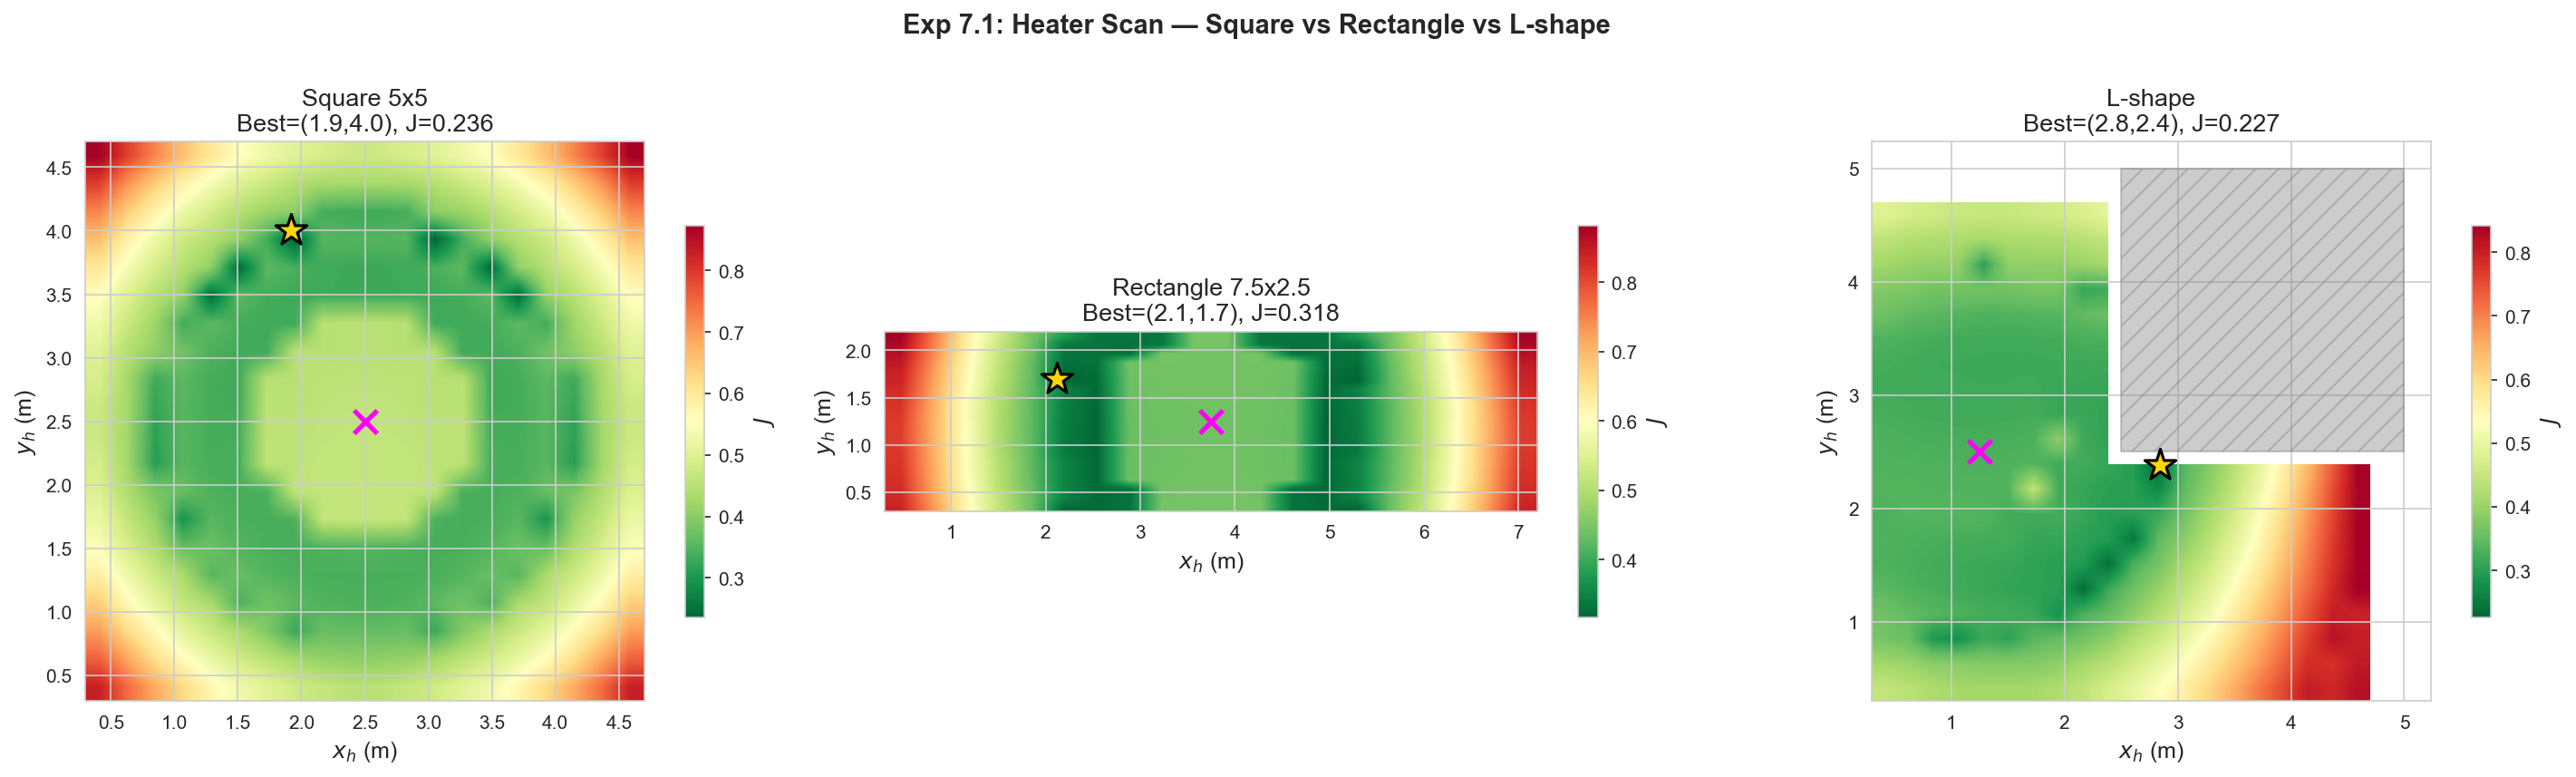

In [35]:
# ============================================================
# 实验 7.1: 三种几何下加热器全域扫描
# ============================================================

# 各几何的恒温器固定在几何中心附近
GEOM_CENTERS = {
    'square':    (2.5, 2.5),
    'rectangle': (3.75, 1.25),
    'L-shape':   (1.25, 2.5),
}

# BC 映射
GEOM_BC = {
    'square':    'RNNN',
    'rectangle': 'RNNN',
    'L-shape':   'L-RNNN',
}

geo_heater_results = {}

for geo in ['square', 'rectangle', 'L-shape']:
    xs, ys = GEOM_CENTERS[geo]
    bc = GEOM_BC[geo]
    print(f'\n=== {geo}: 加热器扫描, 恒温器 ({xs},{ys}), BC={bc} ===')
    
    df_geo, ref_geo = sweep_heater_2d_grid(
        xs, ys, geometry=geo, bc_type=bc,
        source_type='gauss', dx=0.25, margin=0.3
    )
    best = df_geo.loc[df_geo['J'].idxmin()]
    print(f'  最优: ({best["x_h"]:.2f}, {best["y_h"]:.2f}), J={best["J"]:.4f}')
    geo_heater_results[geo] = {'df': df_geo, 'ref': ref_geo, 'best': best}

# --- 1×3 热力图面板 ---
fig, axes = plt.subplots(1, 3, figsize=(20, 5.5))
fig.suptitle('Exp 7.1: Heater Scan — Square vs Rectangle vs L-shape',
             fontsize=14, fontweight='bold')

for ax, geo in zip(axes, ['square', 'rectangle', 'L-shape']):
    r = geo_heater_results[geo]
    df = r['df']
    best = r['best']
    xs, ys = GEOM_CENTERS[geo]
    
    matrix, xpos, ypos = df_to_matrix(df, 'x_h', 'y_h', 'J')
    im = ax.imshow(matrix, origin='lower', aspect='equal',
                   extent=[xpos[0], xpos[-1], ypos[0], ypos[-1]],
                   cmap='RdYlGn_r', interpolation='bilinear')
    plt.colorbar(im, ax=ax, label='$J$', shrink=0.7)
    ax.scatter(best['x_h'], best['y_h'], marker='*', s=300, color='gold',
              edgecolors='k', linewidth=1.5, zorder=10)
    ax.scatter(xs, ys, marker='x', s=150, color='magenta', linewidth=2.5, zorder=10)
    
    if geo == 'L-shape':
        ax.fill_between([2.5, 5], 2.5, 5, alpha=0.4, color='gray', hatch='//')
    
    ax.set_xlabel('$x_h$ (m)')
    ax.set_ylabel('$y_h$ (m)')
    ax.set_title(f'{GEOMETRIES[geo]["label"]}\nBest=({best["x_h"]:.1f},{best["y_h"]:.1f}), J={best["J"]:.3f}')

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(f'{OUT_DIR}/2D_exp7_1_geometry_heater.png', dpi=300, bbox_inches='tight')
plt.show()


=== square: 恒温器扫描, 加热器 (1.9,4.0) ===
Scanning 400 thermostat positions (square, RNNN, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D thermostat scan:   0%|          | 0/400 [00:00<?, ?it/s]

  最优恒温器: (1.69, 2.38), J=0.3208

=== rectangle: 恒温器扫描, 加热器 (2.1,1.7) ===
Scanning 400 thermostat positions (rectangle, RNNN, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D thermostat scan:   0%|          | 0/400 [00:00<?, ?it/s]

  最优恒温器: (1.03, 0.40), J=0.3360

=== L-shape: 恒温器扫描, 加热器 (2.8,2.4) ===
Scanning 300 thermostat positions (L-shape, L-RNNN, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D thermostat scan:   0%|          | 0/300 [00:00<?, ?it/s]

  最优恒温器: (2.62, 0.76), J=0.2553


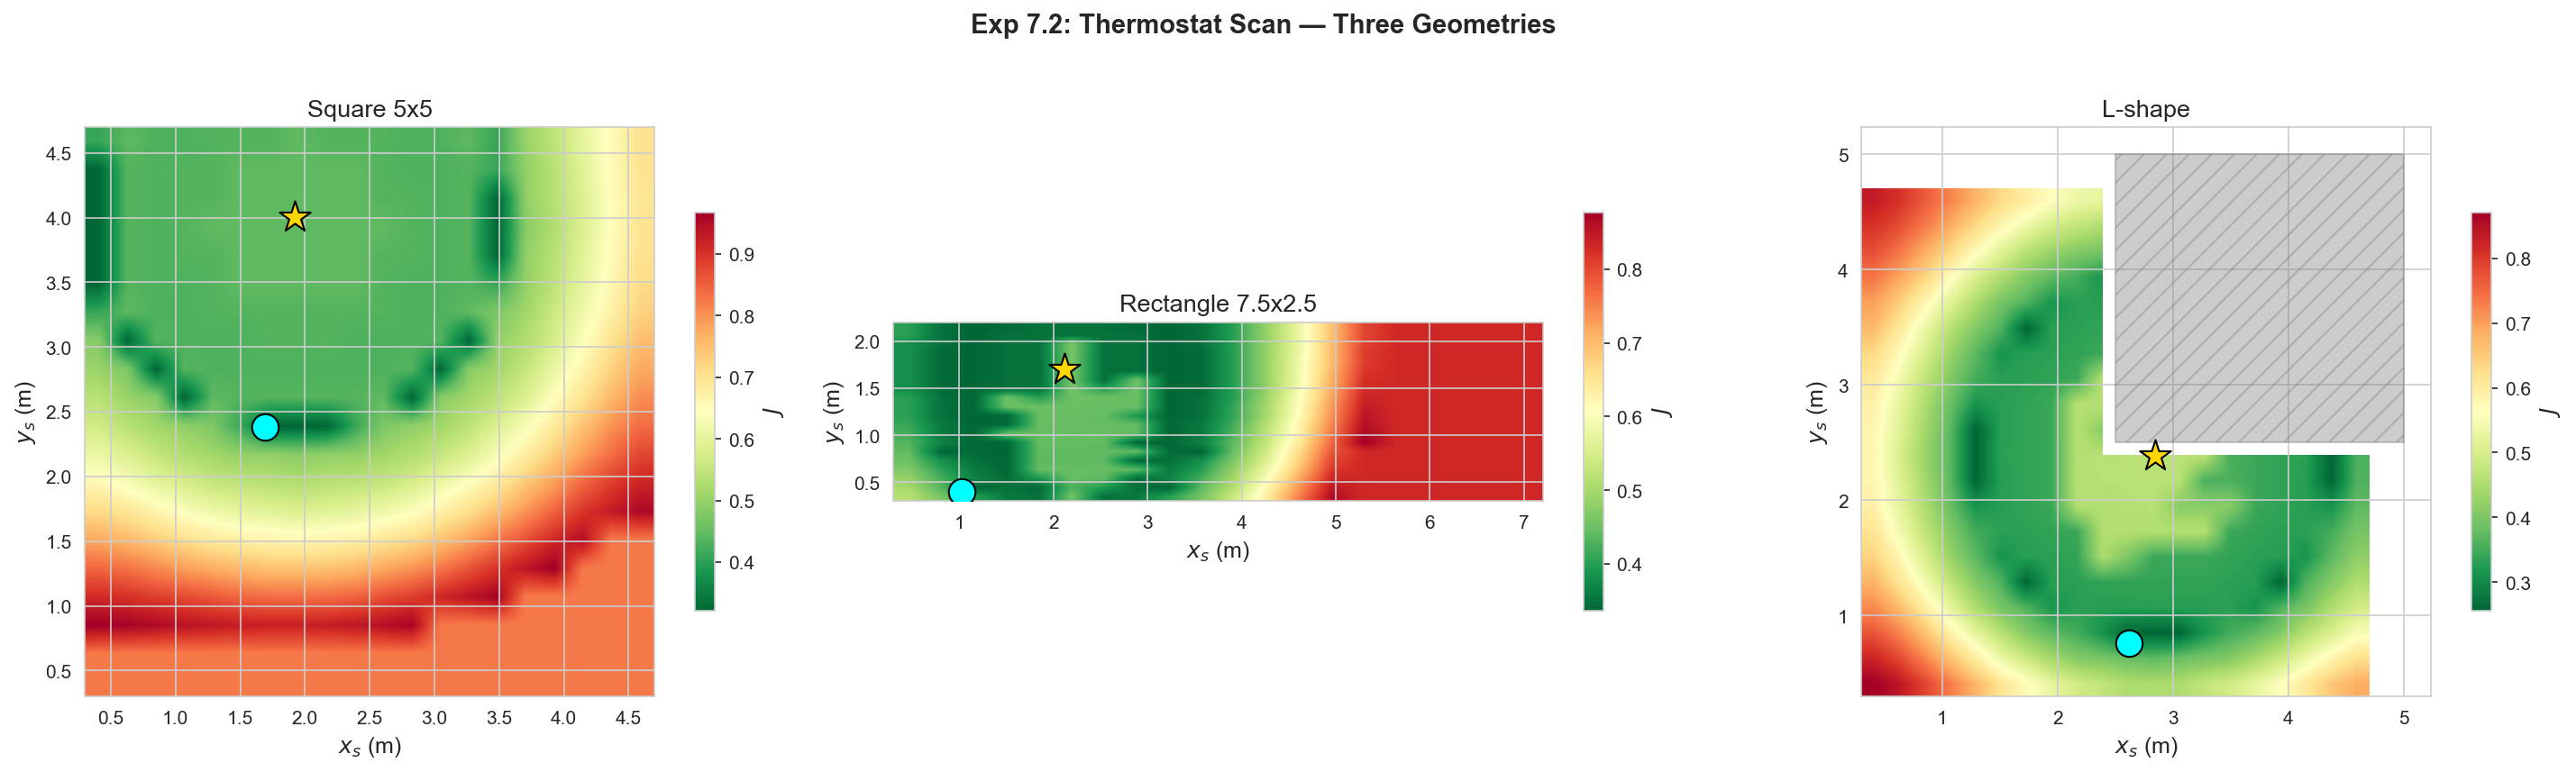

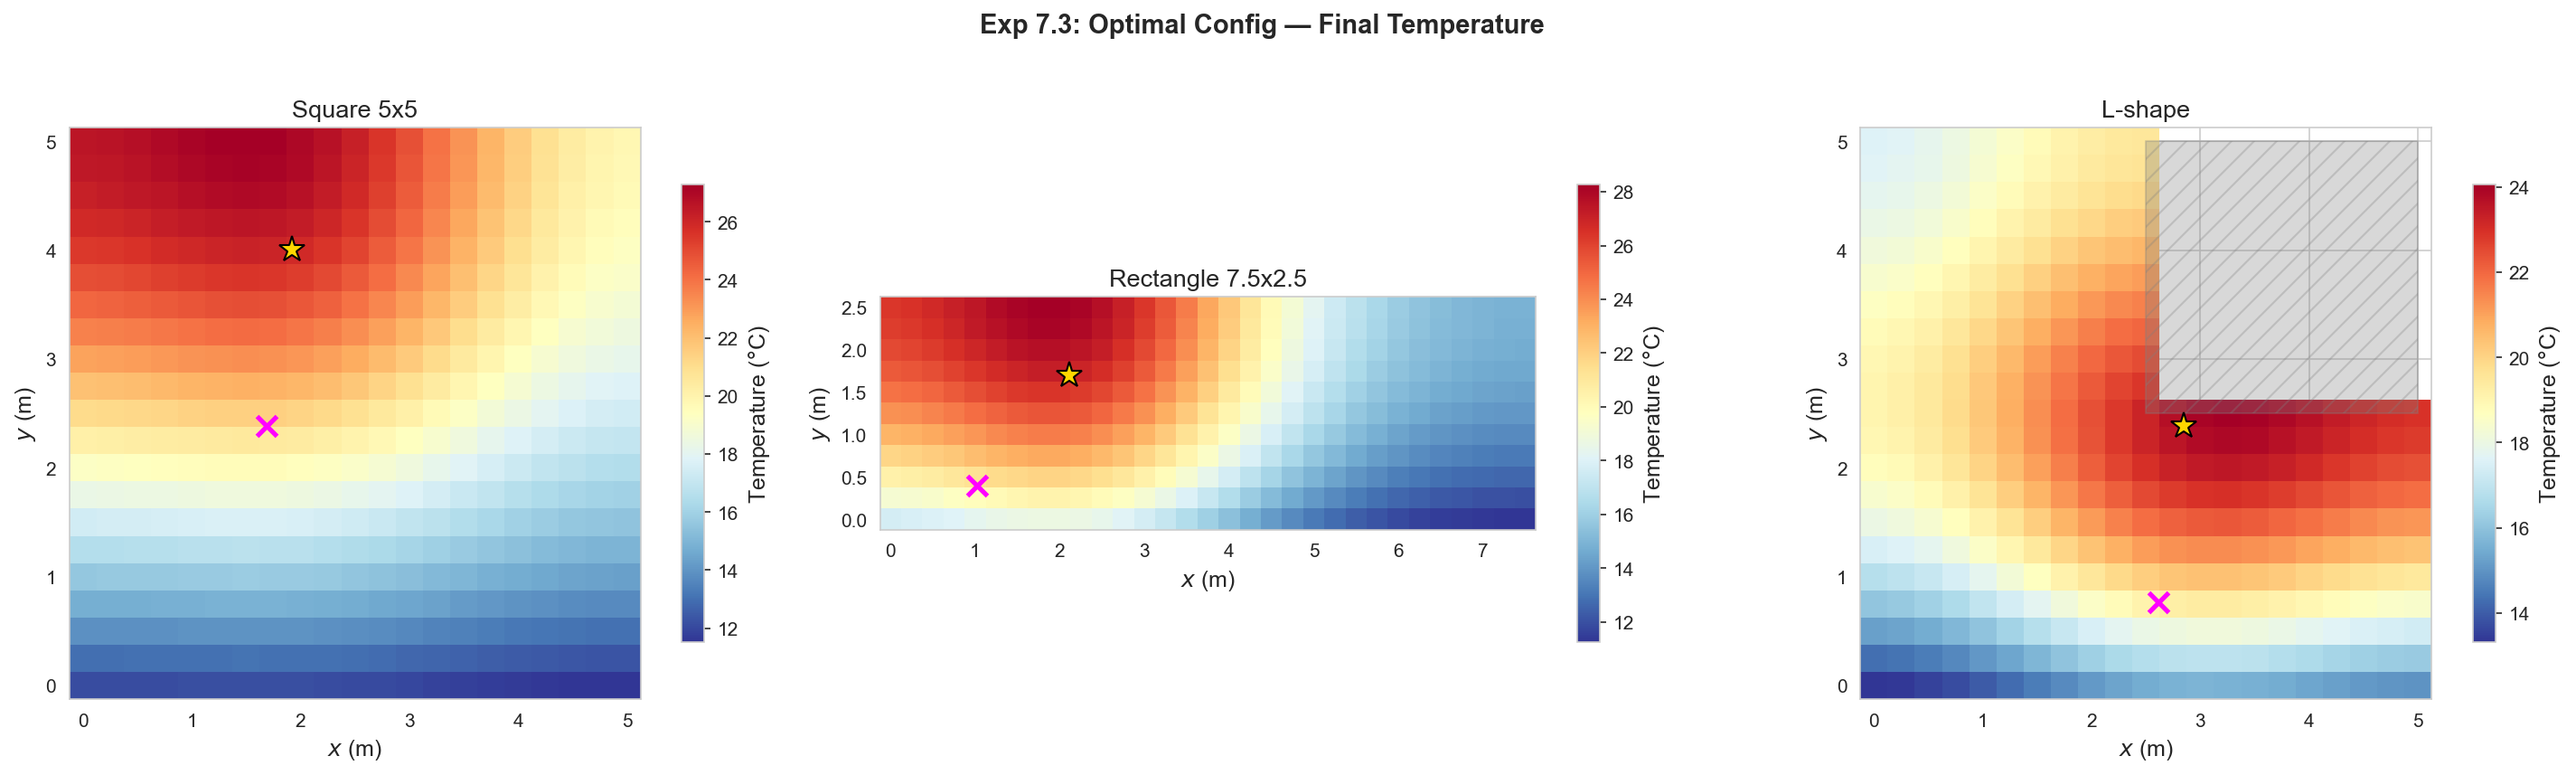

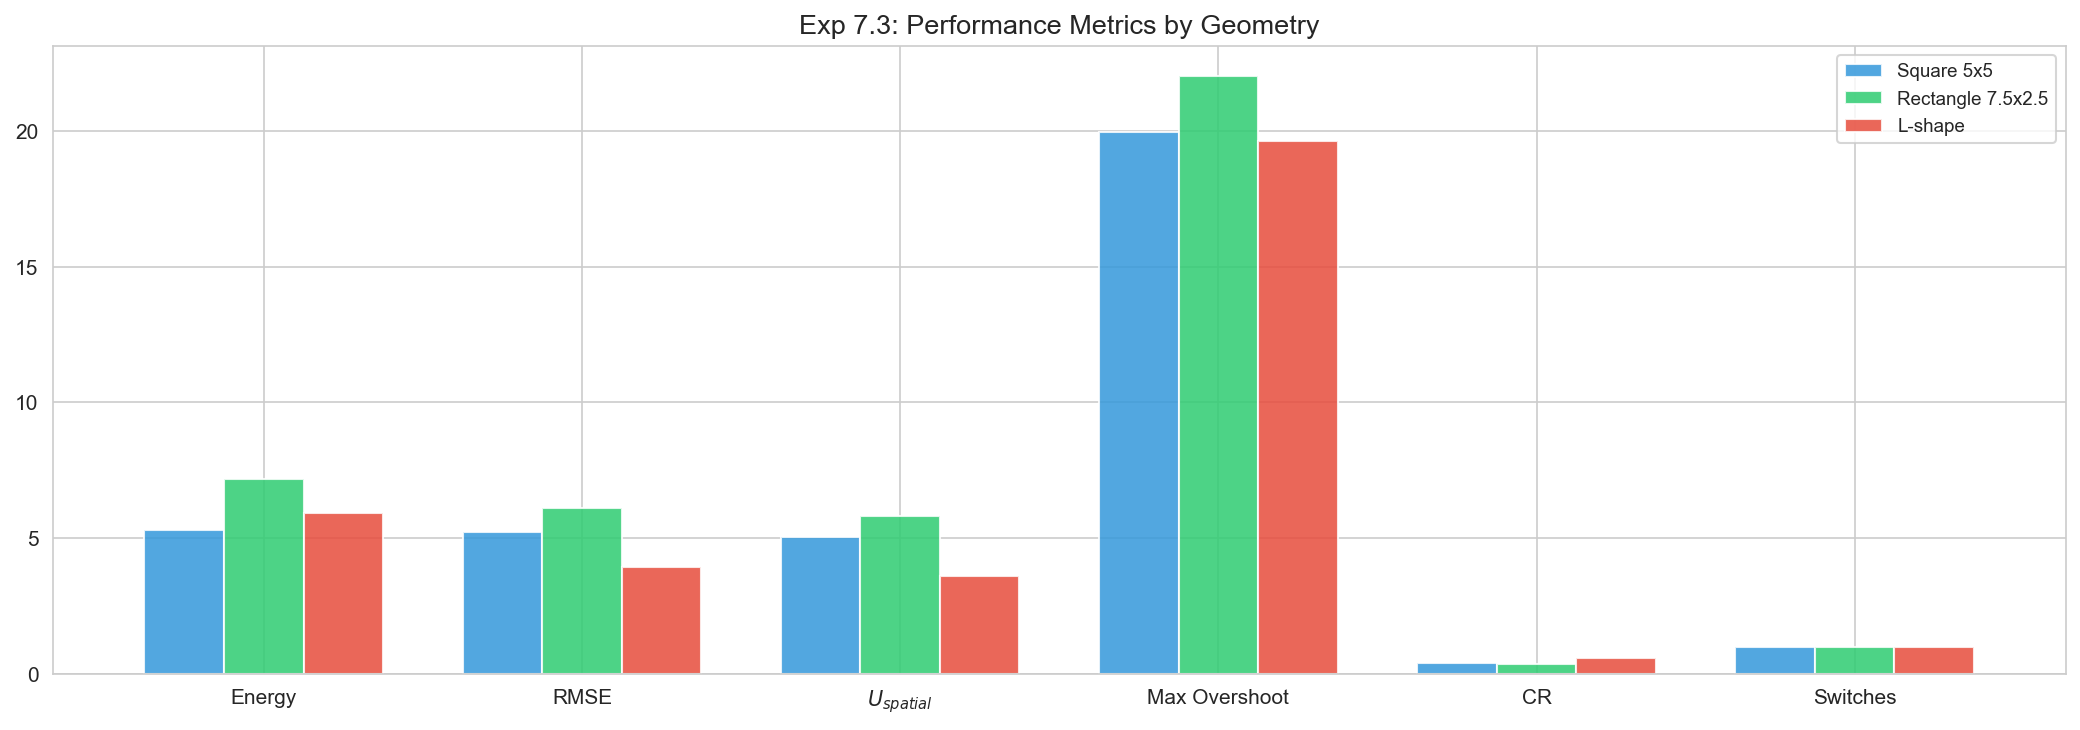

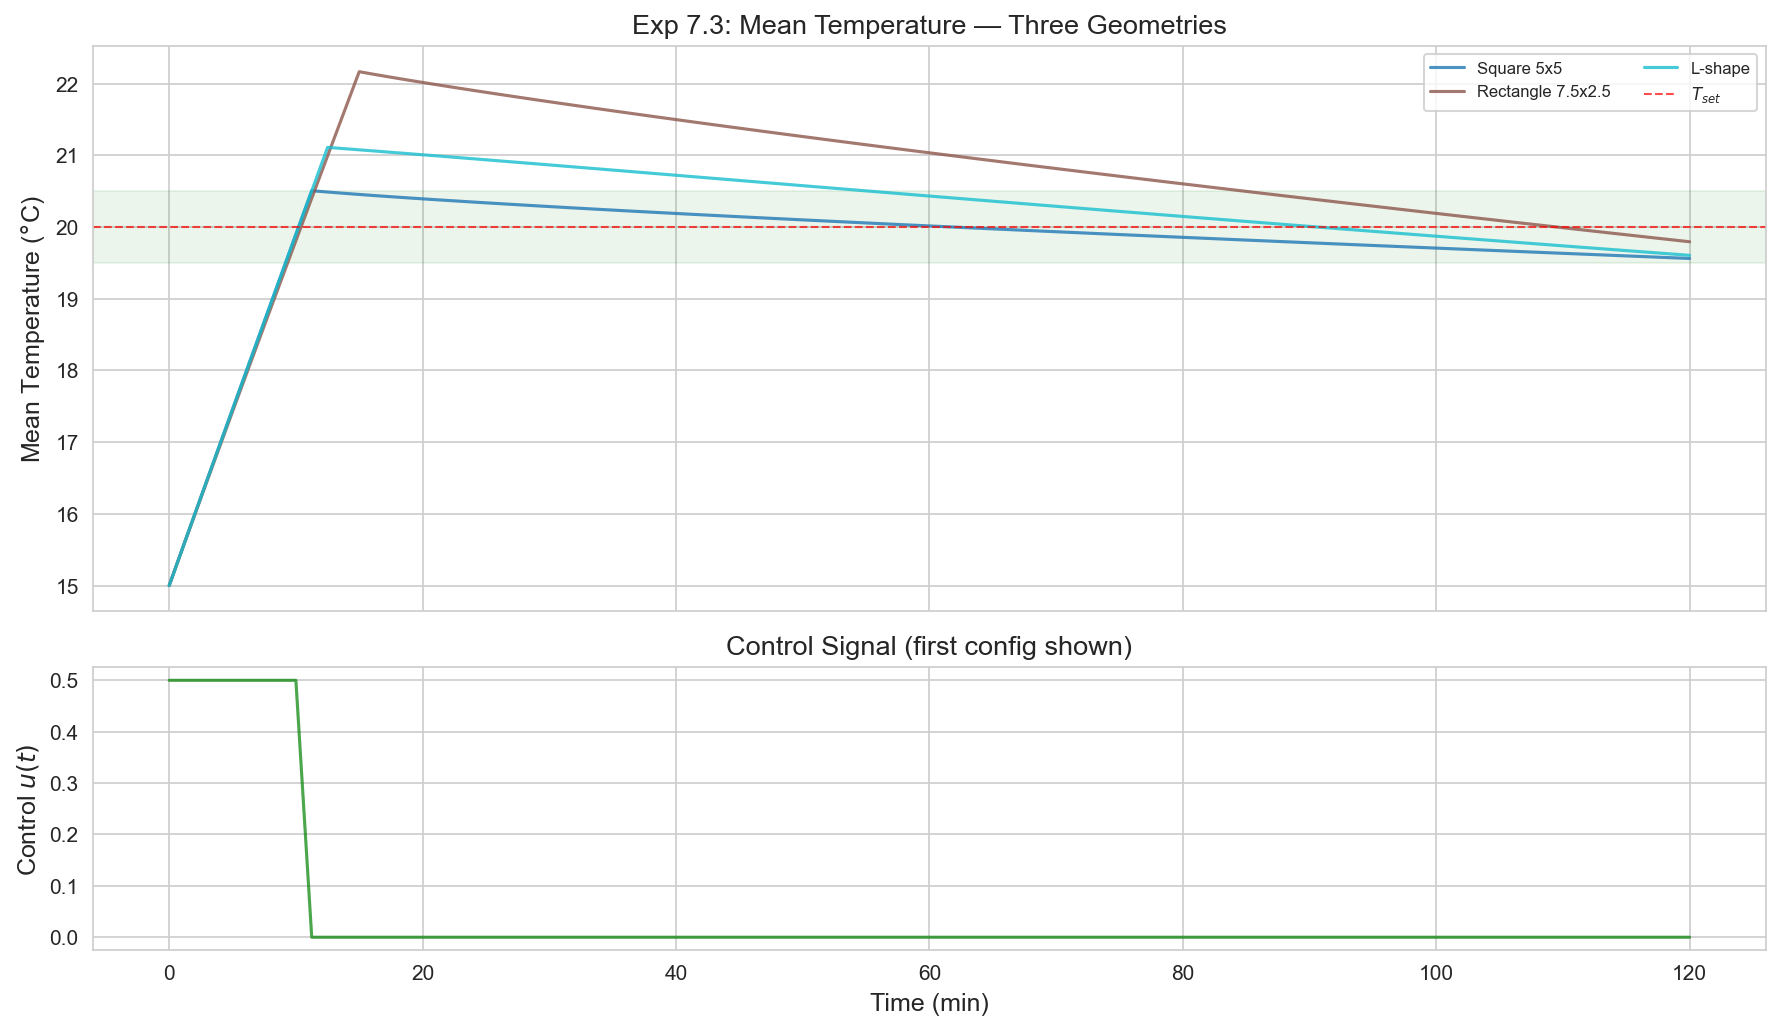


=== 7.4: 矩形 vs L 形等面积对比 ===
  E: Rect=7.188, L-shape=5.938, diff=-1.250 (-17.4%)
  RMSE: Rect=6.119, L-shape=3.930, diff=-2.189 (-35.8%)
  U_spatial: Rect=5.807, L-shape=3.599, diff=-2.209 (-38.0%)
  DeltaT_max: Rect=22.047, L-shape=19.660, diff=-2.387 (-10.8%)
  CR: Rect=0.337, L-shape=0.581, diff=+0.244 (+72.5%)
  N_sw: Rect=1.000, L-shape=1.000, diff=+0.000 (+0.0%)

=== 实验 7 综合对比表 ===


Geometry     Heater Thermostat       E      RMSE  U_spatial  \
0         Square 5x5  (1.9,4.0)  (1.7,2.4)  5.3125  5.223580   5.044156   
1  Rectangle 7.5x2.5  (2.1,1.7)  (1.0,0.4)  7.1875  6.118679   5.807433   
2            L-shape  (2.8,2.4)  (2.6,0.8)  5.9375  3.929989   3.598866   

   DeltaT_max        CR  N_sw  
0   19.986358  0.378265     1  
1   22.046661  0.336753     1  
2   19.659920  0.580792     1

In [36]:
# ============================================================
# 实验 7.2-7.5: 恒温器扫描 + 最优方案对比 + Summary
# ============================================================

# 7.2 恒温器扫描
geo_thermo_results = {}
for geo in ['square', 'rectangle', 'L-shape']:
    best_h = geo_heater_results[geo]['best']
    bc = GEOM_BC[geo]
    print(f'\n=== {geo}: 恒温器扫描, 加热器 ({best_h["x_h"]:.1f},{best_h["y_h"]:.1f}) ===')
    
    df_t, ref_t = sweep_thermostat_2d_grid(
        best_h['x_h'], best_h['y_h'], geometry=geo, bc_type=bc,
        source_type='gauss', dx=0.25, margin=0.3
    )
    best_t = df_t.loc[df_t['J'].idxmin()]
    print(f'  最优恒温器: ({best_t["x_s"]:.2f}, {best_t["y_s"]:.2f}), J={best_t["J"]:.4f}')
    geo_thermo_results[geo] = {'df': df_t, 'best': best_t}

# 1×3 恒温器热图
fig, axes = plt.subplots(1, 3, figsize=(20, 5.5))
fig.suptitle('Exp 7.2: Thermostat Scan — Three Geometries', fontsize=14, fontweight='bold')
for ax, geo in zip(axes, ['square', 'rectangle', 'L-shape']):
    r = geo_thermo_results[geo]
    df = r['df']
    best = r['best']
    matrix, xpos, ypos = df_to_matrix(df, 'x_s', 'y_s', 'J')
    im = ax.imshow(matrix, origin='lower', aspect='equal',
                   extent=[xpos[0], xpos[-1], ypos[0], ypos[-1]],
                   cmap='RdYlGn_r', interpolation='bilinear')
    plt.colorbar(im, ax=ax, label='$J$', shrink=0.7)
    ax.scatter(best['x_s'], best['y_s'], marker='o', s=200, color='cyan',
              edgecolors='k', zorder=10)
    best_h = geo_heater_results[geo]['best']
    ax.scatter(best_h['x_h'], best_h['y_h'], marker='*', s=300, color='gold',
              edgecolors='k', zorder=10)
    if geo == 'L-shape':
        ax.fill_between([2.5, 5], 2.5, 5, alpha=0.4, color='gray', hatch='//')
    ax.set_xlabel('$x_s$ (m)')
    ax.set_ylabel('$y_s$ (m)')
    ax.set_title(f'{GEOMETRIES[geo]["label"]}')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(f'{OUT_DIR}/2D_exp7_2_geometry_thermostat.png', dpi=300, bbox_inches='tight')
plt.show()

# 7.3 最优方案终态温度场 + 指标对比
geo_optimal_sims = {}
geo_optimal_metrics = {}
for geo in ['square', 'rectangle', 'L-shape']:
    bh = geo_heater_results[geo]['best']
    bt = geo_thermo_results[geo]['best']
    sim = simulate_2d(bh['x_h'], bh['y_h'], bt['x_s'], bt['y_s'],
                      geometry=geo, bc_type=GEOM_BC[geo], source_type='gauss', dx=0.25)
    m = compute_metrics_2d(sim)
    geo_optimal_sims[geo] = sim
    geo_optimal_metrics[geo] = m

# 1×3 温度场
fig, axes = plt.subplots(1, 3, figsize=(20, 5.5))
fig.suptitle('Exp 7.3: Optimal Config — Final Temperature', fontsize=14, fontweight='bold')
for ax, geo in zip(axes, ['square', 'rectangle', 'L-shape']):
    sim = geo_optimal_sims[geo]
    bh = geo_heater_results[geo]['best']
    bt = geo_thermo_results[geo]['best']
    plot_2d_field(sim['T_final'], sim['x'], sim['y'], sim['mask'], ax,
                  x_h=bh['x_h'], y_h=bh['y_h'], x_s=bt['x_s'], y_s=bt['y_s'],
                  geometry=geo, title=f'{GEOMETRIES[geo]["label"]}')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(f'{OUT_DIR}/2D_exp7_3_optimal_fields.png', dpi=300, bbox_inches='tight')
plt.show()

# 指标柱状图
fig, ax = plt.subplots(figsize=(14, 5))
keys = ['E', 'RMSE', 'U_spatial', 'DeltaT_max', 'CR', 'N_sw']
labels_k = ['Energy', 'RMSE', '$U_{spatial}$', 'Max Overshoot', 'CR', 'Switches']
x_pos = np.arange(len(keys))
geo_names = ['square', 'rectangle', 'L-shape']
geo_colors = ['#3498db', '#2ecc71', '#e74c3c']
width = 0.25

for i, (geo, color) in enumerate(zip(geo_names, geo_colors)):
    vals = [geo_optimal_metrics[geo][k] for k in keys]
    ax.bar(x_pos + i*width - width, vals, width, color=color,
           label=GEOMETRIES[geo]['label'], alpha=0.85)

ax.set_xticks(x_pos)
ax.set_xticklabels(labels_k)
ax.set_title('Exp 7.3: Performance Metrics by Geometry')
ax.legend()
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/2D_exp7_3_metrics_bar.png', dpi=300, bbox_inches='tight')
plt.show()

# 均温时间曲线叠加
sims_geo_overlay = {GEOMETRIES[geo]['label']: geo_optimal_sims[geo]
                    for geo in geo_names}
plot_mean_temp_overlay(sims_geo_overlay,
                       save_path=f'{OUT_DIR}/2D_exp7_3_meantemp.png',
                       title='Exp 7.3: Mean Temperature — Three Geometries')

# 7.4 矩形 vs L 形等面积对比
m_rect = geo_optimal_metrics['rectangle']
m_lshape = geo_optimal_metrics['L-shape']
print('\n=== 7.4: 矩形 vs L 形等面积对比 ===')
for k in keys:
    diff = m_lshape[k] - m_rect[k]
    if m_rect[k] != 0:
        pct = diff / abs(m_rect[k]) * 100
        print(f'  {k}: Rect={m_rect[k]:.3f}, L-shape={m_lshape[k]:.3f}, '
              f'diff={diff:+.3f} ({pct:+.1f}%)')

# 7.5 综合对比表
summary_7 = []
for geo in geo_names:
    bh = geo_heater_results[geo]['best']
    bt = geo_thermo_results[geo]['best']
    m = geo_optimal_metrics[geo]
    summary_7.append({
        'Geometry': GEOMETRIES[geo]['label'],
        'Heater': f'({bh["x_h"]:.1f},{bh["y_h"]:.1f})',
        'Thermostat': f'({bt["x_s"]:.1f},{bt["y_s"]:.1f})',
        **{k: m[k] for k in keys},
    })
df_summary_7 = pd.DataFrame(summary_7)
print('\n=== 实验 7 综合对比表 ===')
display(df_summary_7)
df_summary_7.to_csv(f'{OUT_DIR}/2D_exp7_geometry_summary.csv', index=False)

---

# 实验八：L 形房间死角/热盲区分析

**核心问题**：L 形的内凹拐角区域是否存在温度盲区？加热器对该区域的控制能力如何？

Bottom mid      (2.5,0.5): RMSE=13.645, U=9.983
Lower-left      (0.5,0.5): RMSE=9.565, U=8.714
Vertical arm    (1.25,3.75): RMSE=4.481, U=3.906
Horizontal arm  (2.5,1.25): RMSE=5.228, U=4.411
Near corner     (2.0,2.0): RMSE=3.325, U=1.798
Upper-left      (0.5,4.5): RMSE=12.536, U=11.742


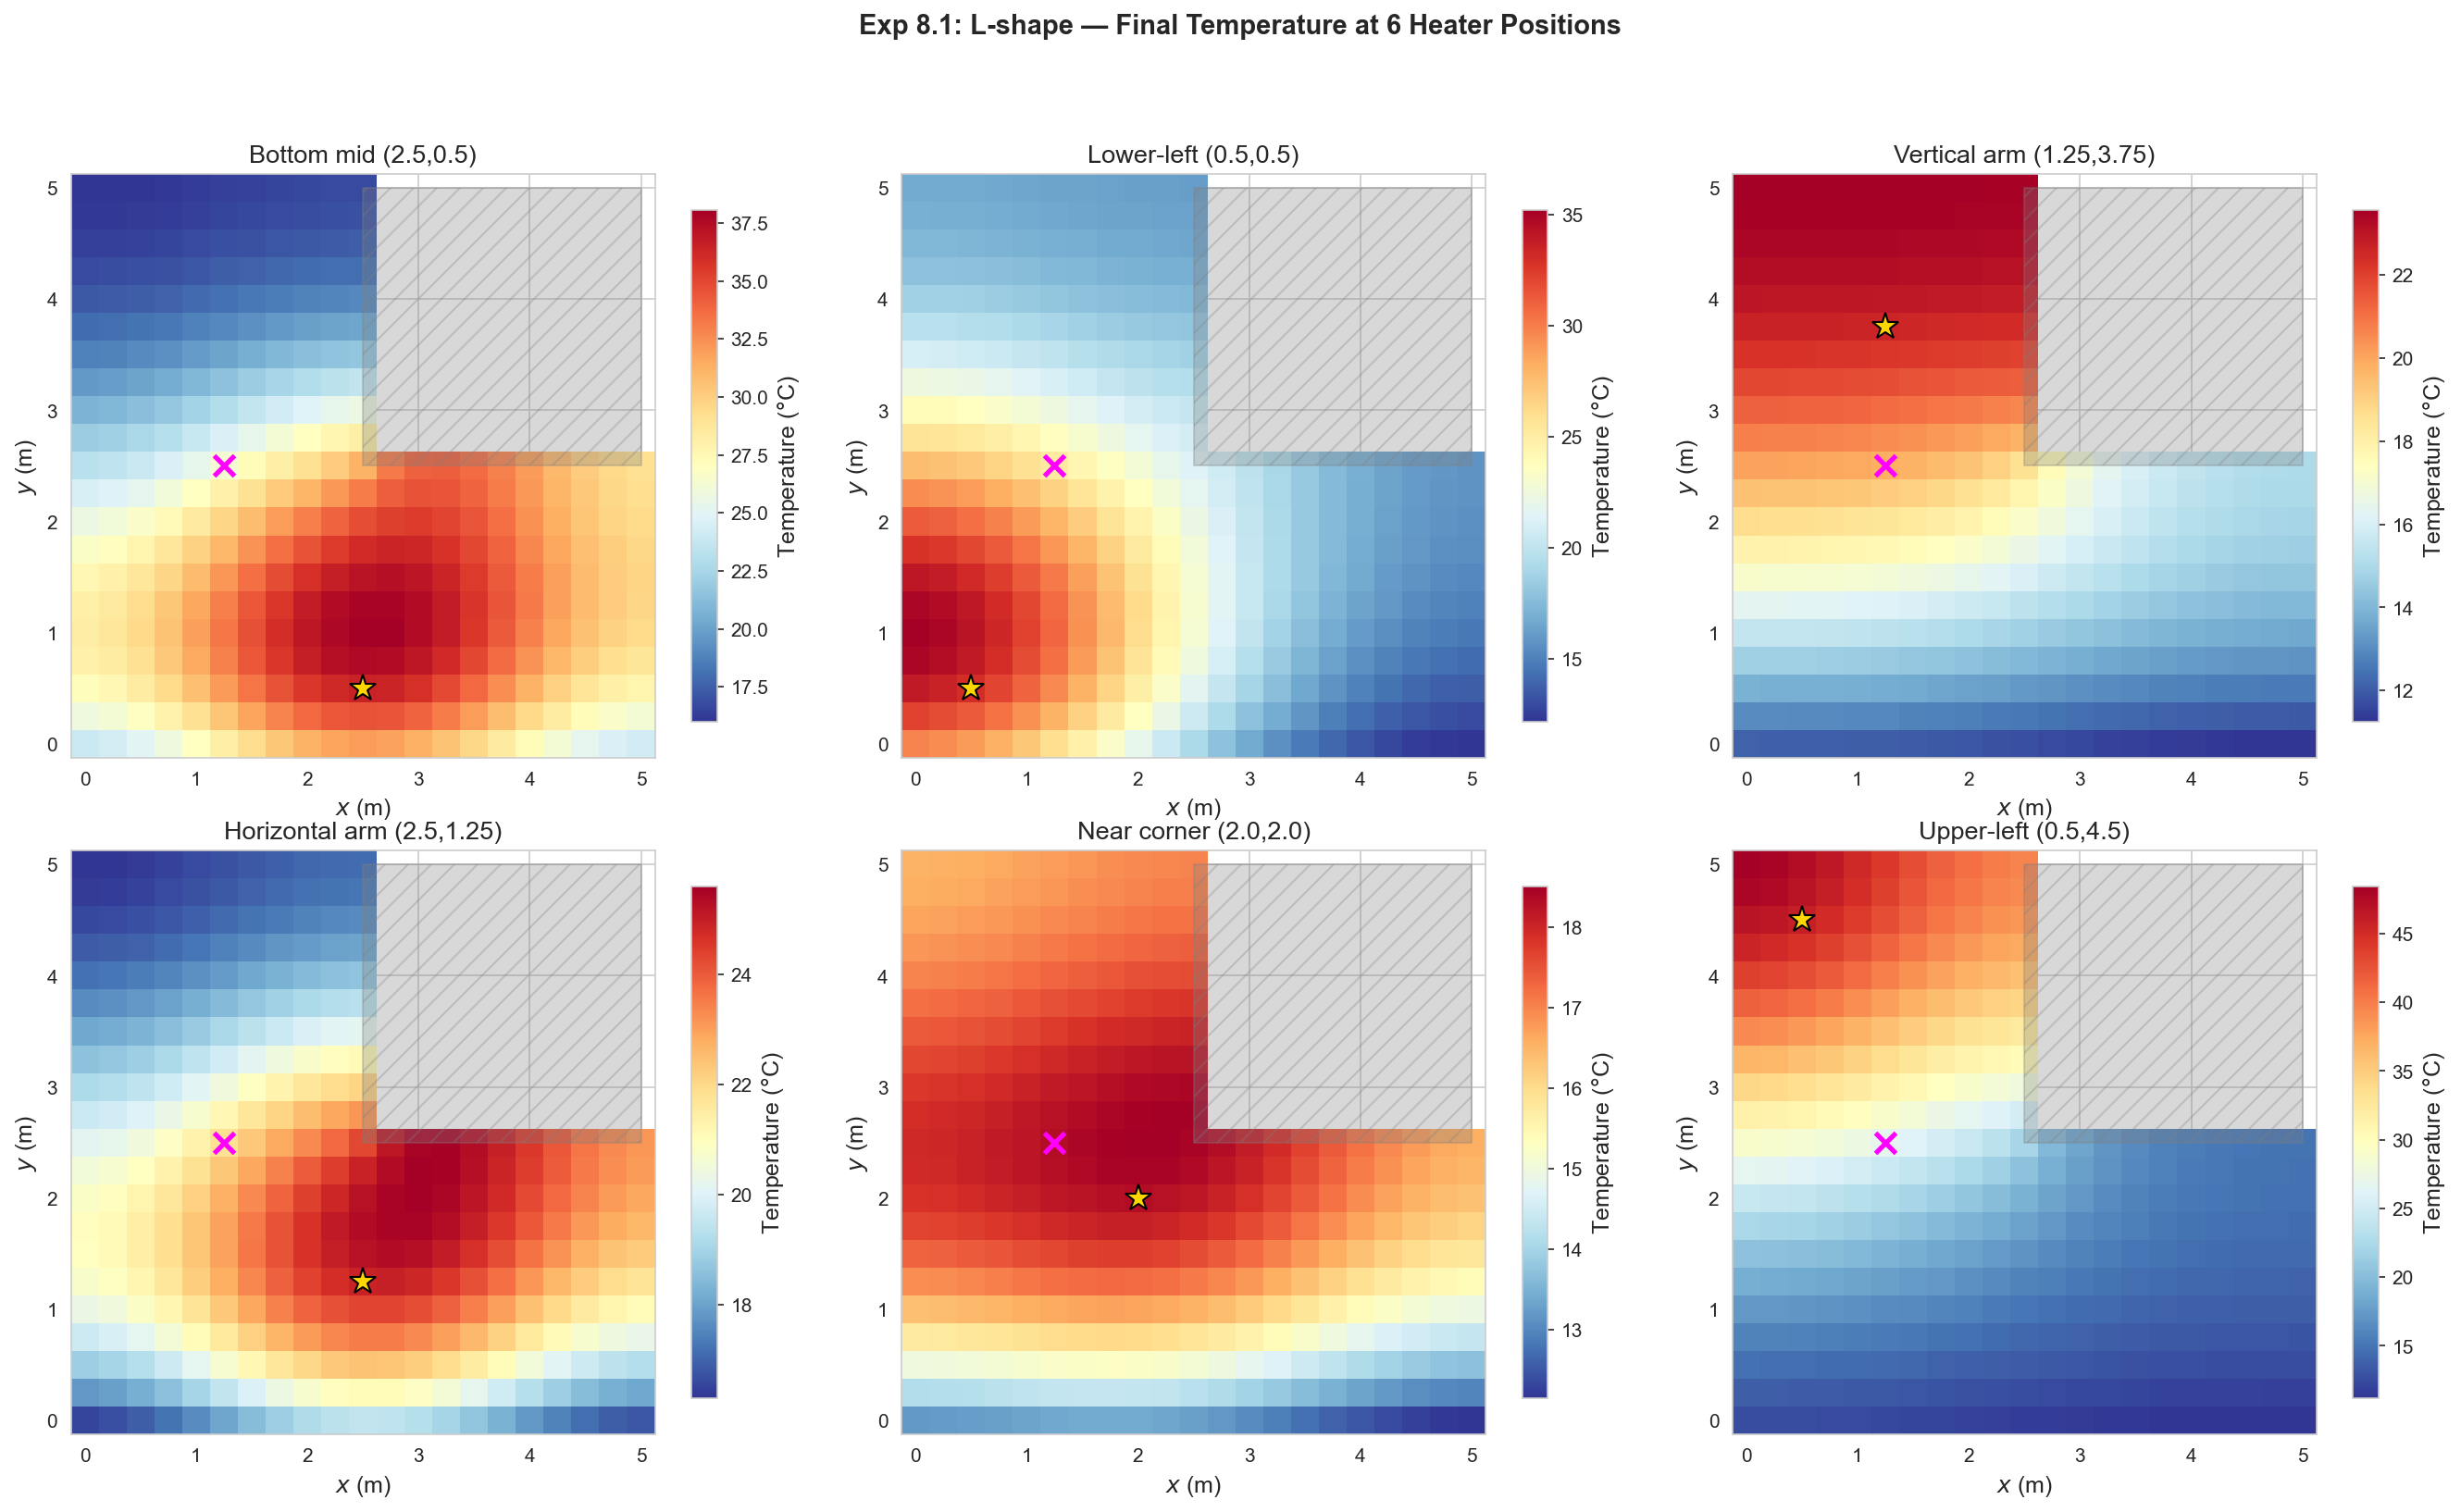

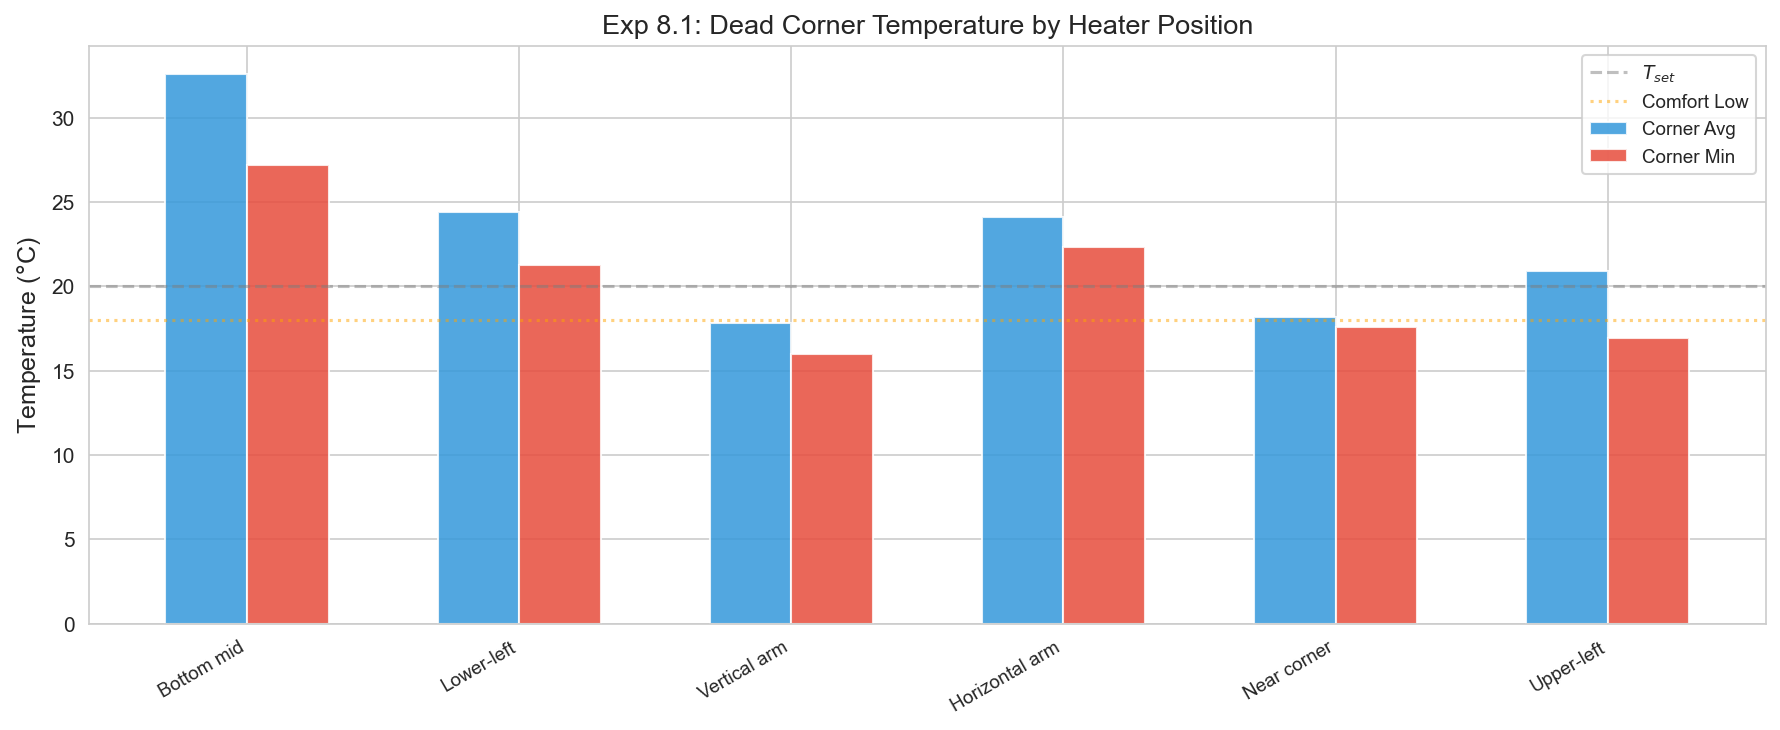

In [37]:
# ============================================================
# 实验 8.1: 不同加热器位置下的死角温度分析
# ============================================================

# 6 个代表性加热器位置
L_heater_configs = [
    ((2.5, 0.5), 'Bottom mid'),
    ((0.5, 0.5), 'Lower-left'),
    ((1.25, 3.75), 'Vertical arm'),
    ((2.5, 1.25), 'Horizontal arm'),
    ((2.0, 2.0), 'Near corner'),
    ((0.5, 4.5), 'Upper-left'),
]

XS_L, YS_L = 1.25, 2.5  # 恒温器固定

sims_8 = []
metrics_8 = []
for (xh, yh), label in L_heater_configs:
    sim = simulate_2d(xh, yh, XS_L, YS_L,
                      geometry='L-shape', bc_type='L-RNNN',
                      source_type='gauss', dx=0.25)
    m = compute_metrics_2d(sim)
    sims_8.append(sim)
    metrics_8.append(m)
    print(f'{label:15s} ({xh},{yh}): RMSE={m["RMSE"]:.3f}, U={m["U_spatial"]:.3f}')

# --- 2×3 终态温度场 ---
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
fig.suptitle('Exp 8.1: L-shape — Final Temperature at 6 Heater Positions',
             fontsize=14, fontweight='bold')

for ax, sim, ((xh, yh), label) in zip(axes.flat, sims_8, L_heater_configs):
    plot_2d_field(sim['T_final'], sim['x'], sim['y'], sim['mask'], ax,
                  x_h=xh, y_h=yh, x_s=XS_L, y_s=YS_L,
                  geometry='L-shape', title=f'{label} ({xh},{yh})')

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig(f'{OUT_DIR}/2D_exp8_1_L_fields.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 死角区域温度分析 ---
# 死角定义：L 形拐角区域 [1.5, 2.5] × [1.5, 2.5] 内的有效点
corner_temps_avg = []
corner_temps_min = []

for sim in sims_8:
    T_f = sim['T_final']
    x, y, mask = sim['x'], sim['y'], sim['mask']
    # 拐角区域
    corner_mask = np.zeros_like(mask)
    for j in range(len(y)):
        for i in range(len(x)):
            if mask[j, i] and 1.5 <= x[i] <= 2.5 and 1.5 <= y[j] <= 2.5:
                corner_mask[j, i] = True
    if np.any(corner_mask):
        T_corner = T_f[corner_mask]
        T_corner = T_corner[~np.isnan(T_corner)]
        corner_temps_avg.append(np.mean(T_corner))
        corner_temps_min.append(np.min(T_corner))
    else:
        corner_temps_avg.append(np.nan)
        corner_temps_min.append(np.nan)

# 死角温度柱状图
fig, ax = plt.subplots(figsize=(12, 5))
labels_short = [l for _, l in L_heater_configs]
x_pos = np.arange(len(labels_short))
ax.bar(x_pos - 0.15, corner_temps_avg, 0.3, color='#3498db', label='Corner Avg', alpha=0.85)
ax.bar(x_pos + 0.15, corner_temps_min, 0.3, color='#e74c3c', label='Corner Min', alpha=0.85)
ax.axhline(T_SET, color='gray', linestyle='--', alpha=0.5, label='$T_{set}$')
ax.axhline(T_COMFORT_LOW, color='orange', linestyle=':', alpha=0.5, label='Comfort Low')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels_short, rotation=30, ha='right', fontsize=9)
ax.set_ylabel('Temperature ($°$C)')
ax.set_title('Exp 8.1: Dead Corner Temperature by Heater Position')
ax.legend()
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/2D_exp8_1_corner_temps.png', dpi=300, bbox_inches='tight')
plt.show()

ValueError: operands could not be broadcast together with shapes (11,11) (21,21) 

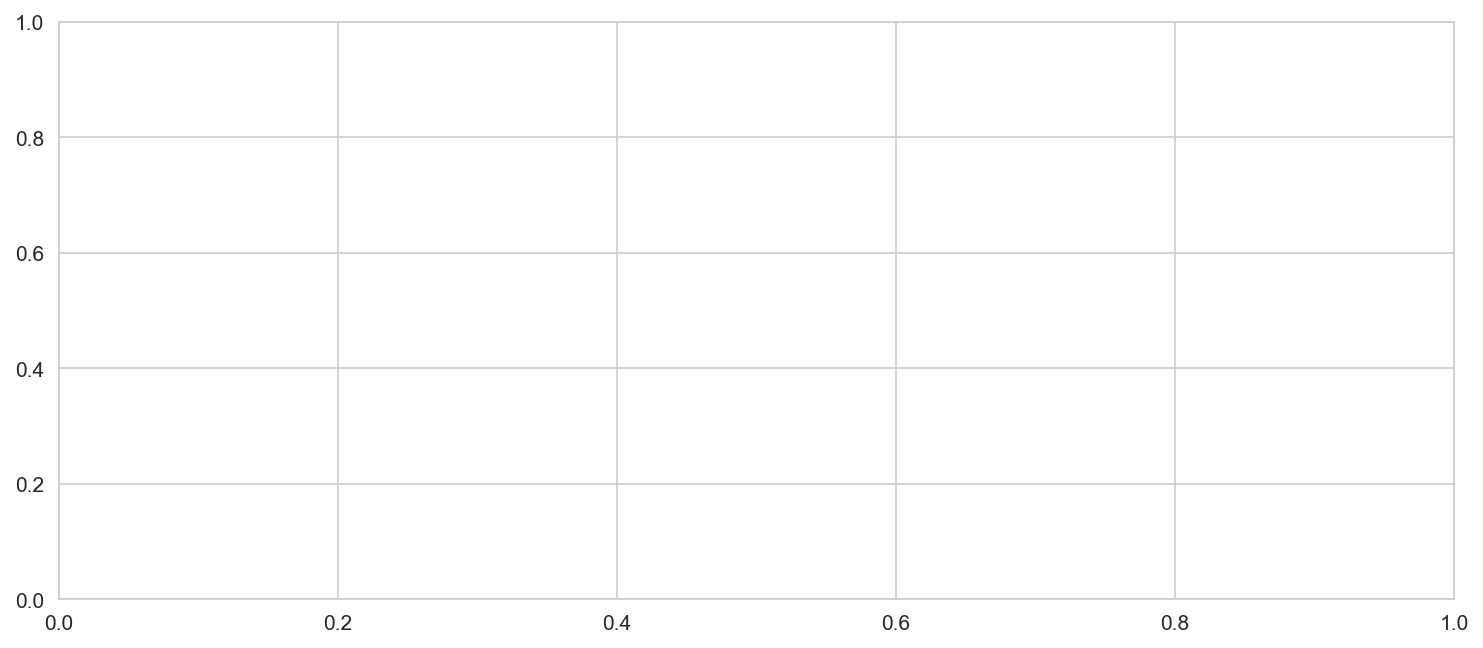

In [38]:
# ============================================================
# 实验 8.2-8.3: 死角时间演化 + CR 空间分布
# ============================================================

# 8.2: 用 monitor_mask 追踪死角区域均温时序
x_grid, y_grid, mask_grid, _ = create_grid('L-shape', 0.5)
corner_monitor = np.zeros_like(mask_grid)
for j in range(len(y_grid)):
    for i in range(len(x_grid)):
        if mask_grid[j, i] and 1.5 <= x_grid[i] <= 2.5 and 1.5 <= y_grid[j] <= 2.5:
            corner_monitor[j, i] = True

best_corner_idx = np.argmax(corner_temps_avg)
worst_corner_idx = np.argmin(corner_temps_avg)

fig, ax = plt.subplots(figsize=(12, 5))
for idx, ls, label_tag in [(best_corner_idx, '-', 'Best corner'),
                            (worst_corner_idx, '--', 'Worst corner')]:
    (xh, yh), config_label = L_heater_configs[idx]
    sim = simulate_2d(xh, yh, XS_L, YS_L,
                      geometry='L-shape', bc_type='L-RNNN',
                      source_type='gauss', dx=0.25,
                      monitor_mask=corner_monitor)
    ax.plot(sim['t'], sim['T_region_mean'], ls, linewidth=2,
            label=f'{label_tag} ({config_label}) - Corner Mean')
    ax.plot(sim['t'], sim['T_mean'], ls, linewidth=1, alpha=0.4,
            label=f'{label_tag} ({config_label}) - Room Mean')

ax.axhline(T_SET, color='red', linestyle=':', alpha=0.5, label='$T_{set}$')
ax.axhline(T_COMFORT_LOW, color='orange', linestyle=':', alpha=0.5, label='Comfort Low')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Temperature ($°$C)')
ax.set_title('Exp 8.2: Dead Corner Temperature — Best vs Worst Heater')
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/2D_exp8_2_corner_time.png', dpi=300, bbox_inches='tight')
plt.show()

# 8.3 CR 空间分布
print('\n=== 实验 8.3: CR 空间分布 ===')
cr_configs = [0, best_corner_idx, worst_corner_idx]

fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))
fig.suptitle('Exp 8.3: Comfort Ratio Spatial Distribution', fontsize=14, fontweight='bold')

for ax, idx in zip(axes, cr_configs):
    (xh, yh), label = L_heater_configs[idx]
    
    sim = simulate_2d(xh, yh, XS_L, YS_L,
                      geometry='L-shape', bc_type='L-RNNN',
                      source_type='gauss', dx=0.25)
    
    T_f = sim['T_final']
    CR_spatial = np.where(
        sim['mask'],
        np.where((T_f >= T_COMFORT_LOW) & (T_f <= T_COMFORT_HIGH), 1.0, 0.0),
        np.nan
    )
    
    plot_2d_field(CR_spatial, sim['x'], sim['y'], sim['mask'], ax,
                  x_h=xh, y_h=yh, x_s=XS_L, y_s=YS_L,
                  geometry='L-shape', cmap='RdYlGn',
                  vmin=0, vmax=1,
                  colorbar_label='CR (final state)',
                  title=f'{label} ({xh},{yh})')

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(f'{OUT_DIR}/2D_exp8_3_CR_spatial.png', dpi=300, bbox_inches='tight')
plt.show()

---

# 实验九：L 形房间最优位置全枚举搜索

**核心问题**：在 L 形非凸域中，加热器和恒温器的全局最优位置在哪里？


=== L-shape 加热器扫描, BC=L-RNNN ===
Scanning 300 heater positions (L-shape, L-RNNN, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D heater scan:   0%|          | 0/300 [00:00<?, ?it/s]

  最优: (2.85, 2.38), J=0.2271

=== L-shape 加热器扫描, BC=L-RRRR ===
Scanning 300 heater positions (L-shape, L-RRRR, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D heater scan:   0%|          | 0/300 [00:00<?, ?it/s]

  最优: (2.38, 1.46), J=0.3226


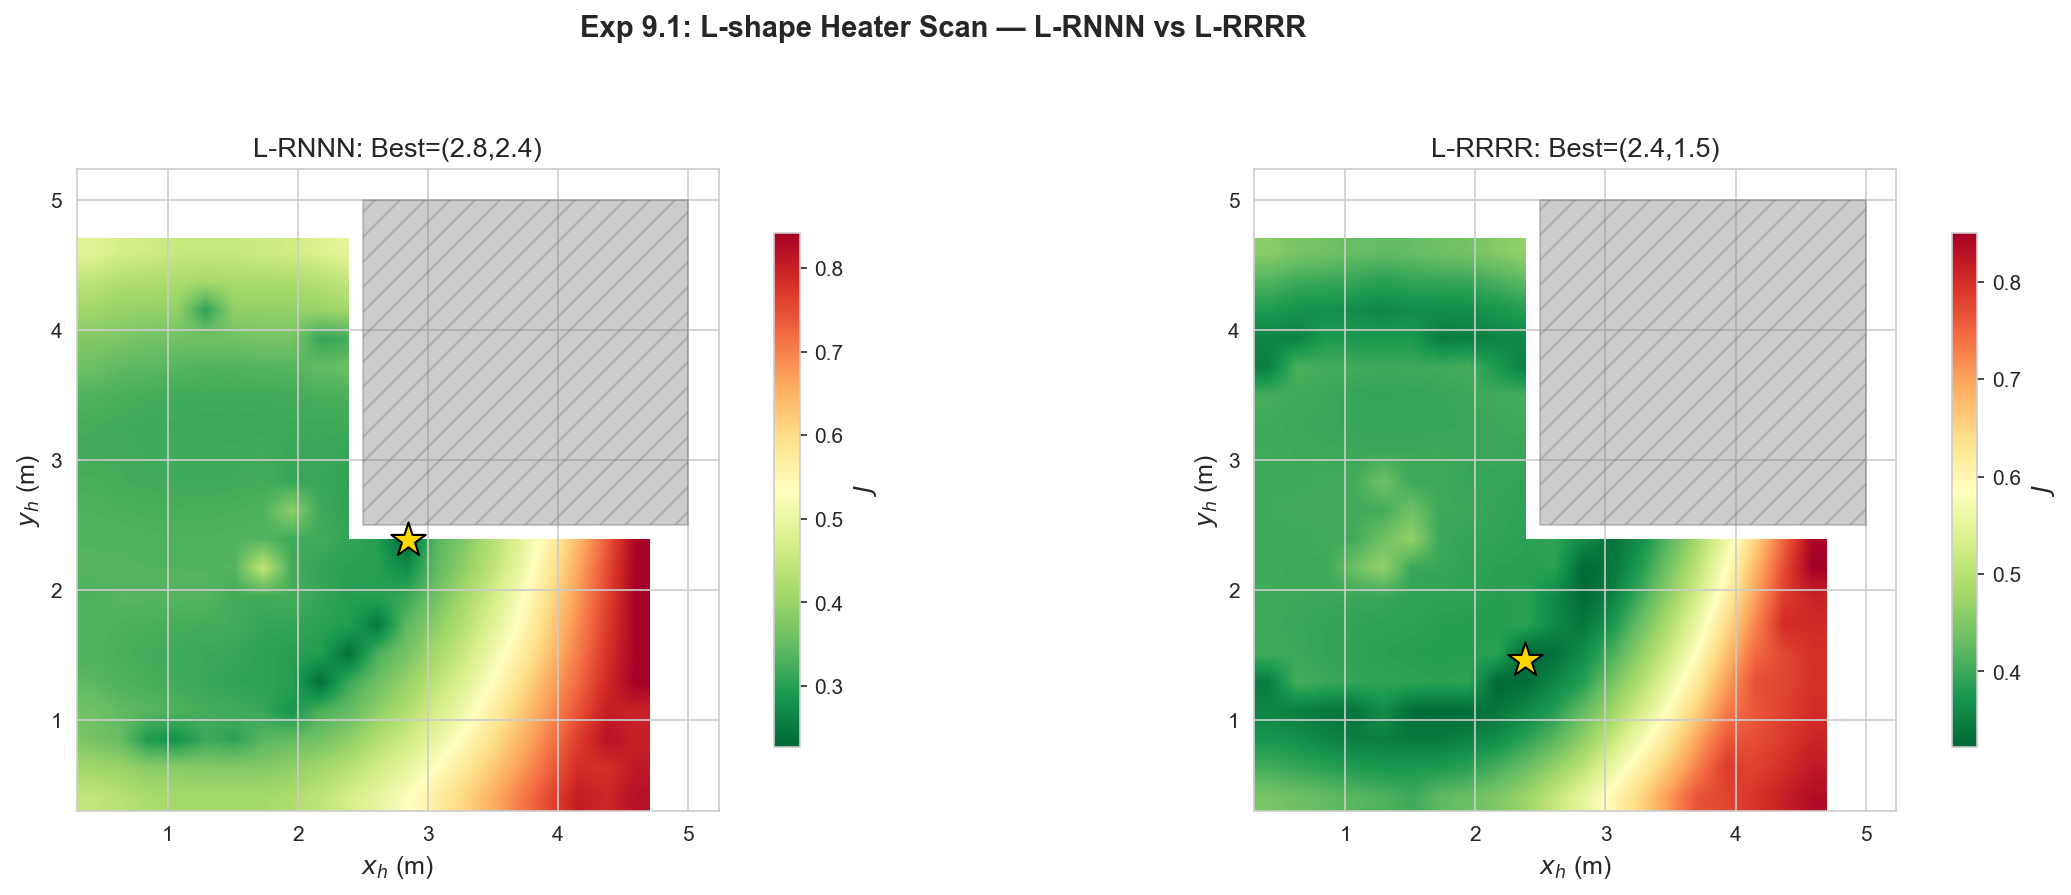


=== L-shape 恒温器扫描, BC=L-RNNN, heater=(2.8,2.4) ===
Scanning 300 thermostat positions (L-shape, L-RNNN, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D thermostat scan:   0%|          | 0/300 [00:00<?, ?it/s]

  最优: (2.62, 0.76), J=0.2553

=== L-shape 恒温器扫描, BC=L-RRRR, heater=(2.4,1.5) ===
Scanning 300 thermostat positions (L-shape, L-RRRR, gauss, ctrl=hysteresis, dx=0.25, n_scan=20)


2D thermostat scan:   0%|          | 0/300 [00:00<?, ?it/s]

  最优: (0.99, 2.15), J=0.3465


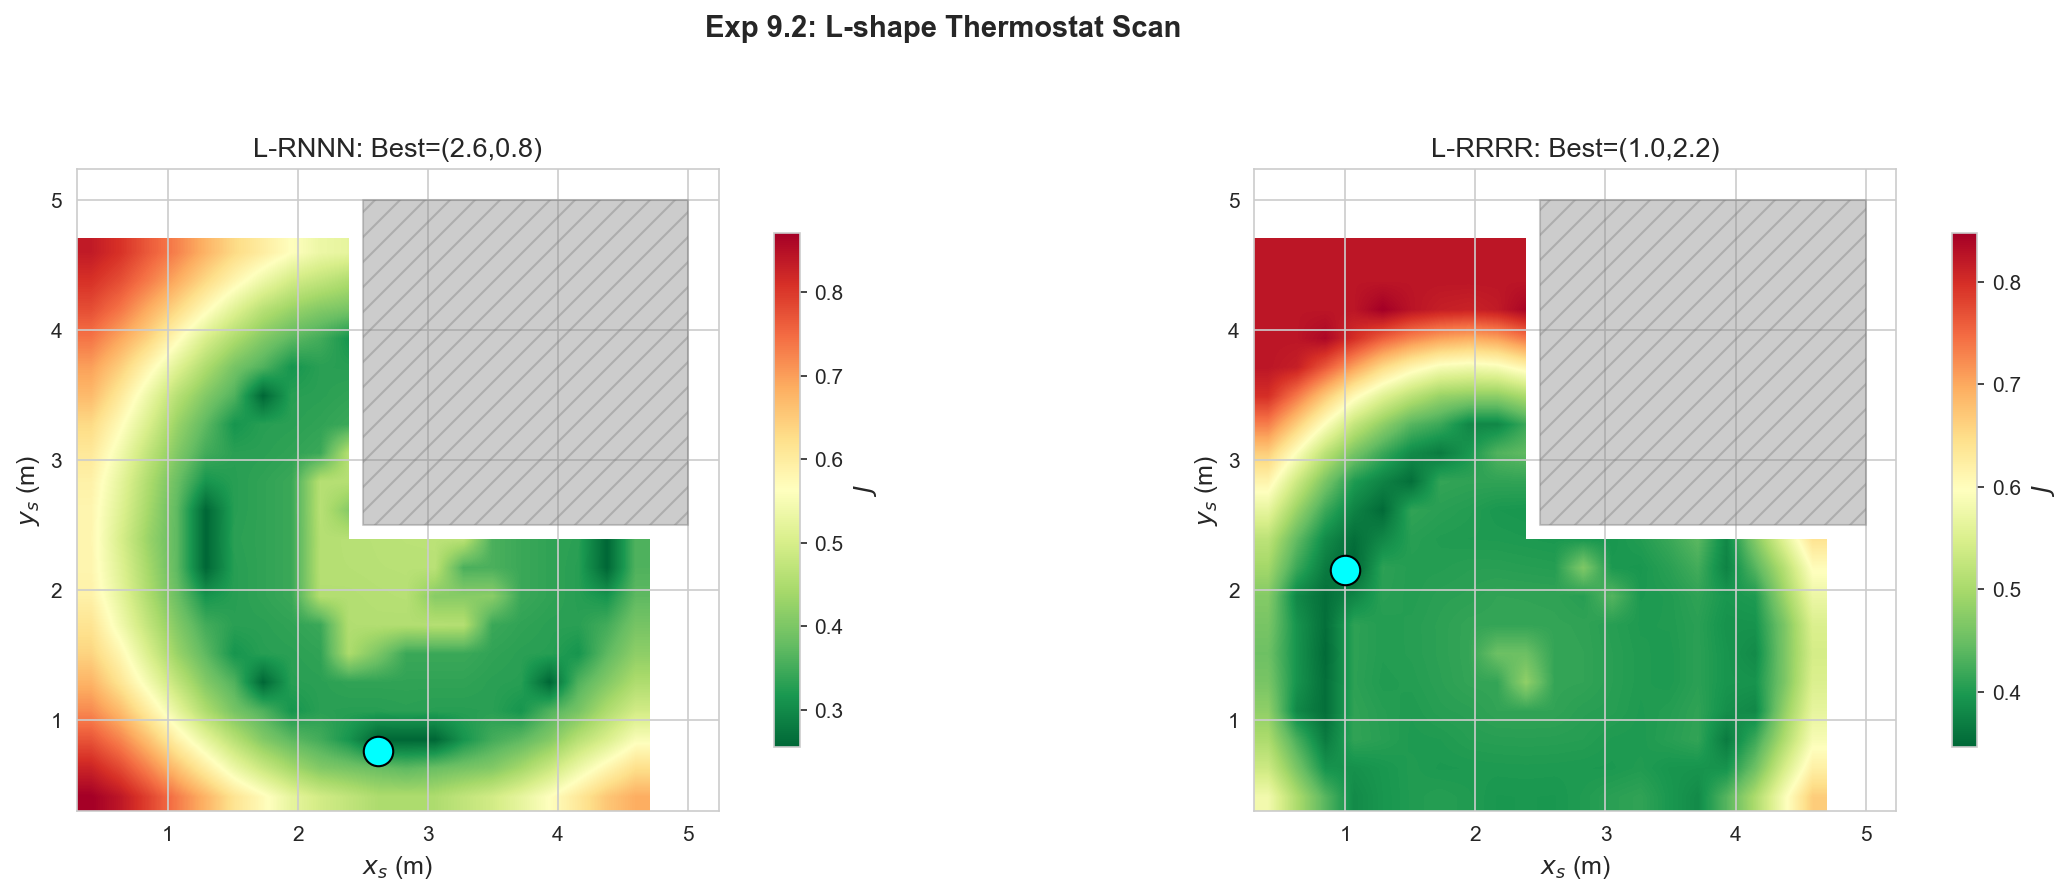

In [39]:
# ============================================================
# 实验 9.1-9.2: L 形加热器/恒温器扫描 (L-RNNN vs L-RRRR)
# ============================================================

L_bcs = ['L-RNNN', 'L-RRRR']

# 9.1 加热器扫描
L_heater_scan = {}
for bc in L_bcs:
    print(f'\n=== L-shape 加热器扫描, BC={bc} ===')
    df_h, ref_h = sweep_heater_2d_grid(
        XS_L, YS_L, geometry='L-shape', bc_type=bc,
        source_type='gauss', dx=0.25, margin=0.3
    )
    best = df_h.loc[df_h['J'].idxmin()]
    print(f'  最优: ({best["x_h"]:.2f}, {best["y_h"]:.2f}), J={best["J"]:.4f}')
    L_heater_scan[bc] = {'df': df_h, 'best': best}

# 1×2 面板
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Exp 9.1: L-shape Heater Scan — L-RNNN vs L-RRRR', fontsize=14, fontweight='bold')
for ax, bc in zip(axes, L_bcs):
    r = L_heater_scan[bc]
    df, best = r['df'], r['best']
    matrix, xpos, ypos = df_to_matrix(df, 'x_h', 'y_h', 'J')
    im = ax.imshow(matrix, origin='lower', aspect='equal',
                   extent=[xpos[0], xpos[-1], ypos[0], ypos[-1]],
                   cmap='RdYlGn_r', interpolation='bilinear')
    plt.colorbar(im, ax=ax, label='$J$', shrink=0.8)
    ax.scatter(best['x_h'], best['y_h'], marker='*', s=300, color='gold',
              edgecolors='k', zorder=10)
    ax.fill_between([2.5, 5], 2.5, 5, alpha=0.4, color='gray', hatch='//')
    ax.set_xlabel('$x_h$ (m)')
    ax.set_ylabel('$y_h$ (m)')
    ax.set_title(f'{bc}: Best=({best["x_h"]:.1f},{best["y_h"]:.1f})')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(f'{OUT_DIR}/2D_exp9_1_L_heater.png', dpi=300, bbox_inches='tight')
plt.show()

# 9.2 恒温器扫描
L_thermo_scan = {}
for bc in L_bcs:
    best_h = L_heater_scan[bc]['best']
    print(f'\n=== L-shape 恒温器扫描, BC={bc}, heater=({best_h["x_h"]:.1f},{best_h["y_h"]:.1f}) ===')
    df_t, ref_t = sweep_thermostat_2d_grid(
        best_h['x_h'], best_h['y_h'], geometry='L-shape', bc_type=bc,
        source_type='gauss', dx=0.25, margin=0.3
    )
    best = df_t.loc[df_t['J'].idxmin()]
    print(f'  最优: ({best["x_s"]:.2f}, {best["y_s"]:.2f}), J={best["J"]:.4f}')
    L_thermo_scan[bc] = {'df': df_t, 'best': best}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Exp 9.2: L-shape Thermostat Scan', fontsize=14, fontweight='bold')
for ax, bc in zip(axes, L_bcs):
    r = L_thermo_scan[bc]
    df, best = r['df'], r['best']
    matrix, xpos, ypos = df_to_matrix(df, 'x_s', 'y_s', 'J')
    im = ax.imshow(matrix, origin='lower', aspect='equal',
                   extent=[xpos[0], xpos[-1], ypos[0], ypos[-1]],
                   cmap='RdYlGn_r', interpolation='bilinear')
    plt.colorbar(im, ax=ax, label='$J$', shrink=0.8)
    ax.scatter(best['x_s'], best['y_s'], marker='o', s=200, color='cyan',
              edgecolors='k', zorder=10)
    ax.fill_between([2.5, 5], 2.5, 5, alpha=0.4, color='gray', hatch='//')
    ax.set_xlabel('$x_s$ (m)')
    ax.set_ylabel('$y_s$ (m)')
    ax.set_title(f'{bc}: Best=({best["x_s"]:.1f},{best["y_s"]:.1f})')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(f'{OUT_DIR}/2D_exp9_2_L_thermostat.png', dpi=300, bbox_inches='tight')
plt.show()

L-shape 全枚举: 21 h × 21 s × 2 src × 2 bc = 1764
  point/L-RNNN: 441/1764
  point/L-RRRR: 882/1764
  gauss/L-RNNN: 1323/1764
  gauss/L-RRRR: 1764/1764

L-shape 全局最优: h=(2.50,4.50), s=(0.50,4.50), gauss, L-RNNN, J=0.2005


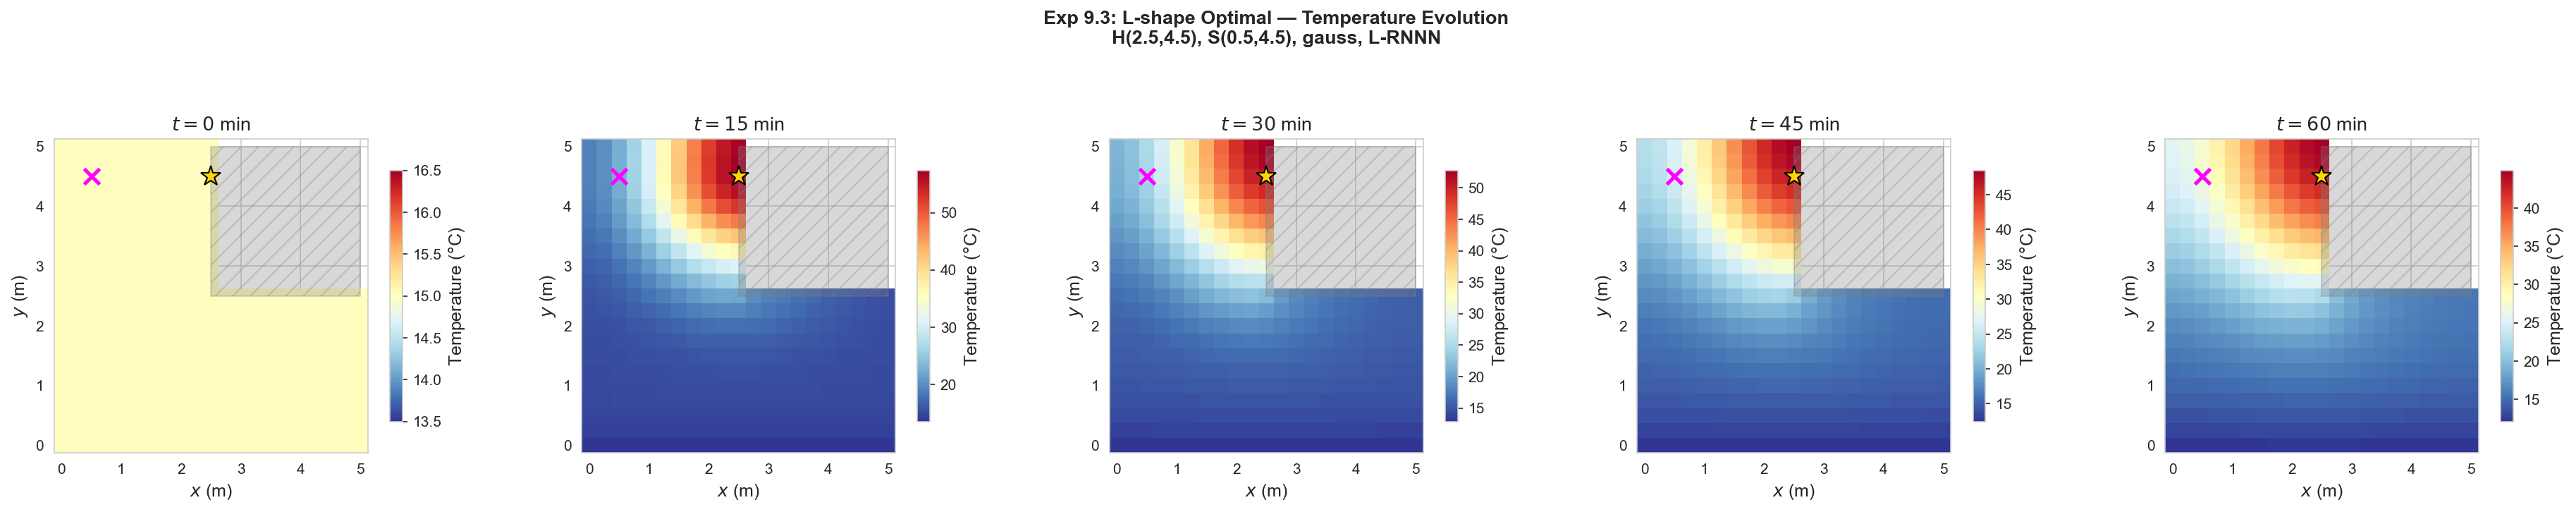


=== L-shape Top-10 (Balanced) ===


x_h  y_h  x_s  y_s source      bc       E      RMSE        CR  \
1320  2.5  4.5  0.5  4.5  gauss  L-RNNN  5.3125  7.767182  0.201160   
1140  2.5  2.5  1.5  1.5  gauss  L-RNNN  4.6875  3.234993  0.579253   
1142  2.5  2.5  3.5  1.5  gauss  L-RNNN  4.6875  3.234993  0.579253   
1150  2.5  2.5  1.5  3.5  gauss  L-RNNN  4.6875  3.234993  0.579253   
1040  2.5  1.5  1.5  2.5  gauss  L-RNNN  5.3125  3.208150  0.568775   
1130  1.5  2.5  2.5  3.5  gauss  L-RNNN  4.6875  3.481817  0.555622   
1118  1.5  2.5  0.5  1.5  gauss  L-RNNN  5.3125  3.710184  0.564165   
1120  1.5  2.5  2.5  1.5  gauss  L-RNNN  5.3125  3.710184  0.564165   
1128  1.5  2.5  0.5  3.5  gauss  L-RNNN  5.3125  3.710184  0.564165   
1042  2.5  1.5  3.5  2.5  gauss  L-RNNN  4.6875  3.050442  0.533162   

      J_Balanced  
1320    0.200457  
1140    0.254387  
1142    0.254387  
1150    0.254387  
1040    0.257322  
1130    0.258337  
1118    0.259667  
1120    0.259667  
1128    0.259667  
1042    0.260285

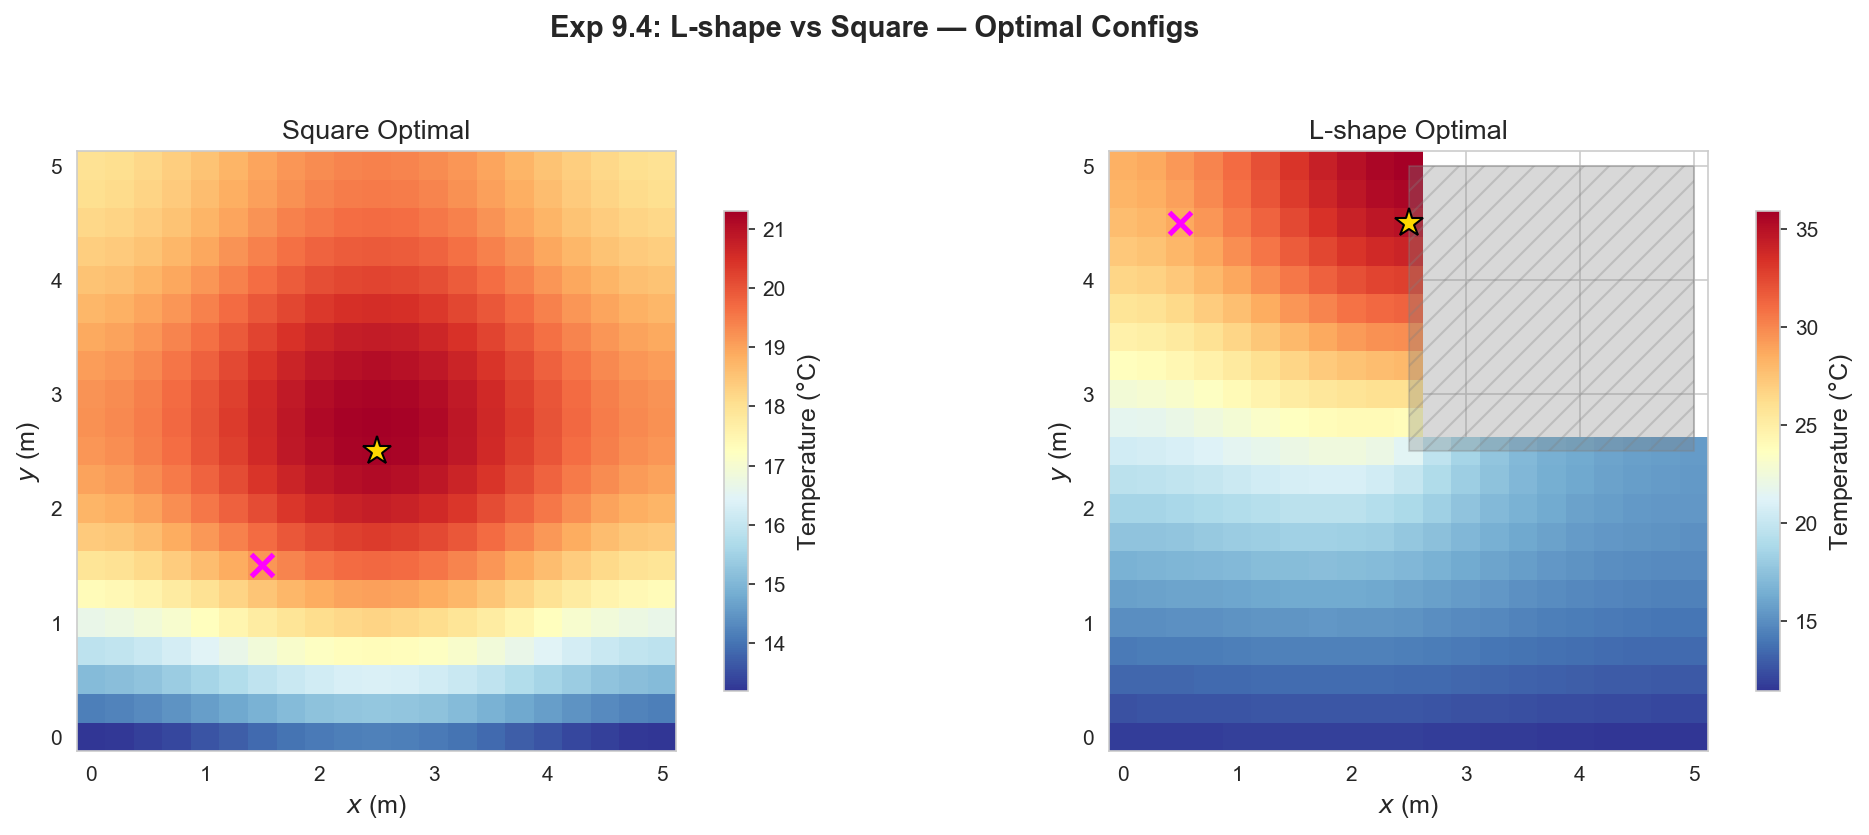

In [40]:
# ============================================================
# 实验 9.3-9.5: L 形全枚举 + L vs Square 深度对比 + Summary
# ============================================================

# 9.3 L 形全枚举
L_H_GRID = get_domain_sample_points('L-shape', n_per_side=5, margin=0.5)
L_S_GRID = get_domain_sample_points('L-shape', n_per_side=5, margin=0.5)

total_L = len(L_H_GRID) * len(L_S_GRID) * 2 * 2
print(f'L-shape 全枚举: {len(L_H_GRID)} h × {len(L_S_GRID)} s × 2 src × 2 bc = {total_L}')

enum_L = []
count = 0
for src in ['point', 'gauss']:
    for bc in ['L-RNNN', 'L-RRRR']:
        for x_h, y_h in L_H_GRID:
            for x_s, y_s in L_S_GRID:
                sim = simulate_2d(x_h, y_h, x_s, y_s,
                                  geometry='L-shape', bc_type=bc,
                                  source_type=src, dx=0.25)
                m = compute_metrics_2d(sim)
                enum_L.append({
                    'x_h': x_h, 'y_h': y_h, 'x_s': x_s, 'y_s': y_s,
                    'source': src, 'bc': bc, **m
                })
                count += 1
        print(f'  {src}/{bc}: {count}/{total_L}')

df_L_enum = pd.DataFrame(enum_L)
ref_L = compute_ref_maxes(enum_L)
for wname, w in WEIGHT_SCHEMES.items():
    df_L_enum[f'J_{wname}'] = df_L_enum.apply(
        lambda r: compute_unified_cost(
            {k: r[k] for k in ['E','RMSE','DeltaT_max','CR','t_s','N_sw','U_spatial']},
            ref_L, w), axis=1)

df_L_enum.to_csv(f'{OUT_DIR}/2D_L_shape_enumeration.csv', index=False)

best_L = df_L_enum.loc[df_L_enum['J_Balanced'].idxmin()]
print(f'\nL-shape 全局最优: h=({best_L["x_h"]:.2f},{best_L["y_h"]:.2f}), '
      f's=({best_L["x_s"]:.2f},{best_L["y_s"]:.2f}), '
      f'{best_L["source"]}, {best_L["bc"]}, J={best_L["J_Balanced"]:.4f}')

# 最优方案温度场演化
sim_best_L = simulate_2d(
    best_L['x_h'], best_L['y_h'], best_L['x_s'], best_L['y_s'],
    geometry='L-shape', bc_type=best_L['bc'], source_type=best_L['source'],
    dx=0.25, return_field=True
)

fig, axes = plt.subplots(1, 5, figsize=(25, 4.5))
fig.suptitle(f'Exp 9.3: L-shape Optimal — Temperature Evolution\n'
             f'H({best_L["x_h"]:.1f},{best_L["y_h"]:.1f}), '
             f'S({best_L["x_s"]:.1f},{best_L["y_s"]:.1f}), '
             f'{best_L["source"]}, {best_L["bc"]}', fontsize=13, fontweight='bold')

for ax, t_snap in zip(axes, [0, 15, 30, 45, 60]):
    if t_snap in sim_best_L.get('saved_fields', {}):
        T_snap = sim_best_L['saved_fields'][t_snap]
    else:
        T_snap = sim_best_L['T_final']
    plot_2d_field(T_snap, sim_best_L['x'], sim_best_L['y'], sim_best_L['mask'], ax,
                  x_h=best_L['x_h'], y_h=best_L['y_h'],
                  x_s=best_L['x_s'], y_s=best_L['y_s'],
                  geometry='L-shape', title=f'$t={t_snap}$ min')

plt.tight_layout(rect=[0, 0, 1, 0.86])
plt.savefig(f'{OUT_DIR}/2D_exp9_3_L_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

# Top-10
print('\n=== L-shape Top-10 (Balanced) ===')
display(df_L_enum.nsmallest(10, 'J_Balanced')[
    ['x_h','y_h','x_s','y_s','source','bc','E','RMSE','CR','J_Balanced']
])

# 9.4 L vs Square 深度对比
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5.5))
fig.suptitle('Exp 9.4: L-shape vs Square — Optimal Configs', fontsize=14, fontweight='bold')

# Square 最优
sim_sq = simulate_2d(best_5['x_h'], best_5['y_h'], best_5['x_s'], best_5['y_s'],
                     geometry='square', bc_type=best_5['bc'], source_type=best_5['source'], dx=0.25)
plot_2d_field(sim_sq['T_final'], sim_sq['x'], sim_sq['y'], sim_sq['mask'], ax1,
              x_h=best_5['x_h'], y_h=best_5['y_h'], x_s=best_5['x_s'], y_s=best_5['y_s'],
              title='Square Optimal')

plot_2d_field(sim_best_L['T_final'], sim_best_L['x'], sim_best_L['y'], sim_best_L['mask'], ax2,
              x_h=best_L['x_h'], y_h=best_L['y_h'], x_s=best_L['x_s'], y_s=best_L['y_s'],
              geometry='L-shape', title='L-shape Optimal')

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(f'{OUT_DIR}/2D_exp9_4_L_vs_square.png', dpi=300, bbox_inches='tight')
plt.show()

---

# 实验十：L 形房间多加热器探索

**核心问题**：L 形的非凸特性是否使得单加热器无法有效覆盖？增加第二个加热器能带来多大改善？

双加热器：两个加热器各 $U_{max}/2$（总功率不变）。

In [41]:
# ============================================================
# 实验 10: 多加热器求解器 + 对比
# 修正: 精确面积 + 梯形求积权重 + 加权空间统计量
# ============================================================

def simulate_2d_dual_heater(xh1, yh1, xh2, yh2, x_s, y_s,
                             x_s2=None, y_s2=None,
                             geometry='L-shape', bc_type='L-RNNN',
                             source_type='gauss', sigma=SIGMA_GAUSS,
                             dx=0.25, mode='sync',
                             T_a=T_A, T_set=T_SET, T_init=T_INIT,
                             alpha=ALPHA, h_wall=H_WALL, U_max=U_MAX,
                             t_end=T_END, delta=DELTA):
    """
    双加热器求解器。每个加热器功率 = U_max/2。
    mode='sync': 两个加热器同步开关（单传感器 x_s, y_s 控制）
    mode='independent': 各自独立传感器控制
        heater1 由 (x_s, y_s) 控制
        heater2 由 (x_s2, y_s2) 控制
    """
    x, y, mask, area = create_grid(geometry, dx)
    Nx, Ny = len(x), len(y)
    
    # 梯形求积权重
    quad_w = compute_quad_weights(mask, dx)
    w_valid = quad_w[mask]
    w_sum = np.sum(w_valid)
    
    r_target = 0.2
    dt = r_target * dx**2 / alpha
    r = r_target
    N_t = int(t_end / dt) + 1
    t_arr = np.linspace(0, t_end, N_t)

    def make_source(xh, yh):
        f = np.zeros((Ny, Nx))
        if source_type == 'point':
            jh = np.argmin(np.abs(x - xh))
            ih = np.argmin(np.abs(y - yh))
            if mask[ih, jh]:
                f[ih, jh] = area / (dx * dx)
        else:
            XX, YY = np.meshgrid(x, y)
            g = np.exp(-0.5*(((XX-xh)**2+(YY-yh)**2)/sigma**2))
            g[~mask] = 0
            g_int = np.sum(g * quad_w)
            if g_int > 1e-12: f = g*area/g_int
            f[~mask] = 0
        return f

    f1 = make_source(xh1, yh1)
    f2 = make_source(xh2, yh2)

    # 传感器（双线性插值）
    def make_sensor_reader(sx, sy):
        ix = int(np.clip(np.searchsorted(x, sx) - 1, 0, Nx-2))
        iy = int(np.clip(np.searchsorted(y, sy) - 1, 0, Ny-2))
        dx_loc = x[ix+1] - x[ix]
        dy_loc = y[iy+1] - y[iy]
        wx = (sx - x[ix]) / dx_loc if dx_loc > 0 else 0.0
        wy = (sy - y[iy]) / dy_loc if dy_loc > 0 else 0.0
        def reader(T):
            return (T[iy, ix]*(1-wx)*(1-wy) + T[iy, ix+1]*wx*(1-wy) +
                    T[iy+1, ix]*(1-wx)*wy + T[iy+1, ix+1]*wx*wy)
        return reader

    read_sensor1 = make_sensor_reader(x_s, y_s)
    if mode == 'independent':
        if x_s2 is None or y_s2 is None:
            raise ValueError("mode='independent' requires x_s2, y_s2")
        read_sensor2 = make_sensor_reader(x_s2, y_s2)

    # BC 预计算
    bc = bc_type.replace('L-', '')
    bc_top = 'R' if bc == 'RRRR' else 'N'
    bc_left = 'R' if bc == 'RRRR' else 'N'
    bc_right = 'R' if bc == 'RRRR' else 'N'
    bc_internal = 'R' if bc == 'RRRR' else 'N'

    is_robin = np.zeros((Ny, Nx, 4), dtype=bool)
    is_neumann = np.zeros((Ny, Nx, 4), dtype=bool)
    has_neighbor = np.zeros((Ny, Nx, 4), dtype=bool)
    for j in range(Ny):
        for i in range(Nx):
            if not mask[j,i]: continue
            if i==0:
                if bc_left=='R': is_robin[j,i,0]=True
                else: is_neumann[j,i,0]=True
            elif not mask[j,i-1]:
                if bc_internal=='R': is_robin[j,i,0]=True
                else: is_neumann[j,i,0]=True
            else: has_neighbor[j,i,0]=True
            if i==Nx-1:
                if bc_right=='R': is_robin[j,i,1]=True
                else: is_neumann[j,i,1]=True
            elif not mask[j,i+1]:
                if bc_internal=='R': is_robin[j,i,1]=True
                else: is_neumann[j,i,1]=True
            else: has_neighbor[j,i,1]=True
            if j==0: is_robin[j,i,2]=True
            elif not mask[j-1,i]:
                if bc_internal=='R': is_robin[j,i,2]=True
                else: is_neumann[j,i,2]=True
            else: has_neighbor[j,i,2]=True
            if j==Ny-1:
                if bc_top=='R': is_robin[j,i,3]=True
                else: is_neumann[j,i,3]=True
            elif not mask[j+1,i]:
                if bc_internal=='R': is_robin[j,i,3]=True
                else: is_neumann[j,i,3]=True
            else: has_neighbor[j,i,3]=True

    n_robin = np.sum(is_robin, axis=2)
    n_neumann = np.sum(is_neumann, axis=2)
    coeff_self_total = n_neumann + n_robin*(1.0-dx*h_wall) - 4.0
    const_term = n_robin * dx * h_wall * T_a

    T_cur = np.full((Ny,Nx), T_init, dtype=np.float64)
    T_cur[~mask] = 0.0

    u_rec = np.zeros(N_t)
    T_sensor_rec = np.zeros(N_t)
    T_mean_rec = np.zeros(N_t)
    CR_t_rec = np.zeros(N_t)
    error_sq_mean_rec = np.zeros(N_t)
    max_overshoot_rec = np.zeros(N_t)
    max_abs_error_rec = np.zeros(N_t)
    spatial_std_rec = np.zeros(N_t)

    U_half = U_max / 2.0

    if mode == 'independent':
        h1_on, h2_on = True, True
    else:
        heater_on = True

    # 加权空间统计
    def record_stats(T, idx):
        T_valid = T[mask]
        T_sensor_rec[idx] = read_sensor1(T)
        T_mean_rec[idx] = np.dot(T_valid, w_valid) / w_sum
        in_comfort = (T_valid >= T_COMFORT_LOW) & (T_valid <= T_COMFORT_HIGH)
        CR_t_rec[idx] = np.dot(in_comfort.astype(np.float64), w_valid) / w_sum
        error_sq_mean_rec[idx] = np.dot((T_valid - T_set)**2, w_valid) / w_sum
        max_overshoot_rec[idx] = np.max(T_valid - T_set)
        max_abs_error_rec[idx] = np.max(np.abs(T_valid - T_set))
        mean_val = T_mean_rec[idx]
        spatial_std_rec[idx] = np.sqrt(np.dot((T_valid - mean_val)**2, w_valid) / w_sum)

    record_stats(T_cur, 0)

    for n in range(N_t-1):
        if mode == 'sync':
            T_read = read_sensor1(T_cur)
            if heater_on and T_read >= T_set+delta: heater_on = False
            elif not heater_on and T_read <= T_set-delta: heater_on = True
            u1 = U_half if heater_on else 0.0
            u2 = U_half if heater_on else 0.0
        else:  # independent
            T_read1 = read_sensor1(T_cur)
            if h1_on and T_read1 >= T_set+delta: h1_on = False
            elif not h1_on and T_read1 <= T_set-delta: h1_on = True
            u1 = U_half if h1_on else 0.0

            T_read2 = read_sensor2(T_cur)
            if h2_on and T_read2 >= T_set+delta: h2_on = False
            elif not h2_on and T_read2 <= T_set-delta: h2_on = True
            u2 = U_half if h2_on else 0.0

        u_rec[n] = u1 + u2

        T_left = np.zeros_like(T_cur); T_right = np.zeros_like(T_cur)
        T_down = np.zeros_like(T_cur); T_up = np.zeros_like(T_cur)
        T_left[:,1:] = T_cur[:,:-1]; T_right[:,:-1] = T_cur[:,1:]
        T_down[1:,:] = T_cur[:-1,:]; T_up[:-1,:] = T_cur[1:,:]

        neighbor_sum = (has_neighbor[:,:,0]*T_left + has_neighbor[:,:,1]*T_right +
                       has_neighbor[:,:,2]*T_down + has_neighbor[:,:,3]*T_up)
        S = u1 * f1 + u2 * f2
        T_new = T_cur + r*(neighbor_sum + coeff_self_total*T_cur + const_term) + dt*S
        T_cur = np.where(mask, T_new, 0.0)

        record_stats(T_cur, n + 1)

    if mode == 'sync':
        u_rec[-1] = (U_half if heater_on else 0.0) * 2
    else:
        u_rec[-1] = (U_half if h1_on else 0.0) + (U_half if h2_on else 0.0)

    T_final = T_cur.copy()
    T_final[~mask] = np.nan

    return {
        't': t_arr, 'x': x, 'y': y, 'mask': mask, 'dx': dx,
        'T_final': T_final, 'T_sensor': T_sensor_rec, 'u': u_rec,
        'T_mean': T_mean_rec, 'CR_t': CR_t_rec,
        'error_sq_mean': error_sq_mean_rec,
        'max_overshoot': max_overshoot_rec,
        'max_abs_error': max_abs_error_rec,
        'spatial_std': spatial_std_rec,
        'area': area, 'geometry': geometry, 'bc_type': bc_type,
    }

print('Dual heater solver v3 defined (exact area + quad weights).')

Dual heater solver v3 defined (exact area + quad weights).


A: Vert+Horiz: RMSE=2.739, U=2.526, E=5.9
B: Corner+Far: RMSE=32.113, U=19.215, E=44.1
C: Center+Top: RMSE=3.537, U=3.351, E=5.9


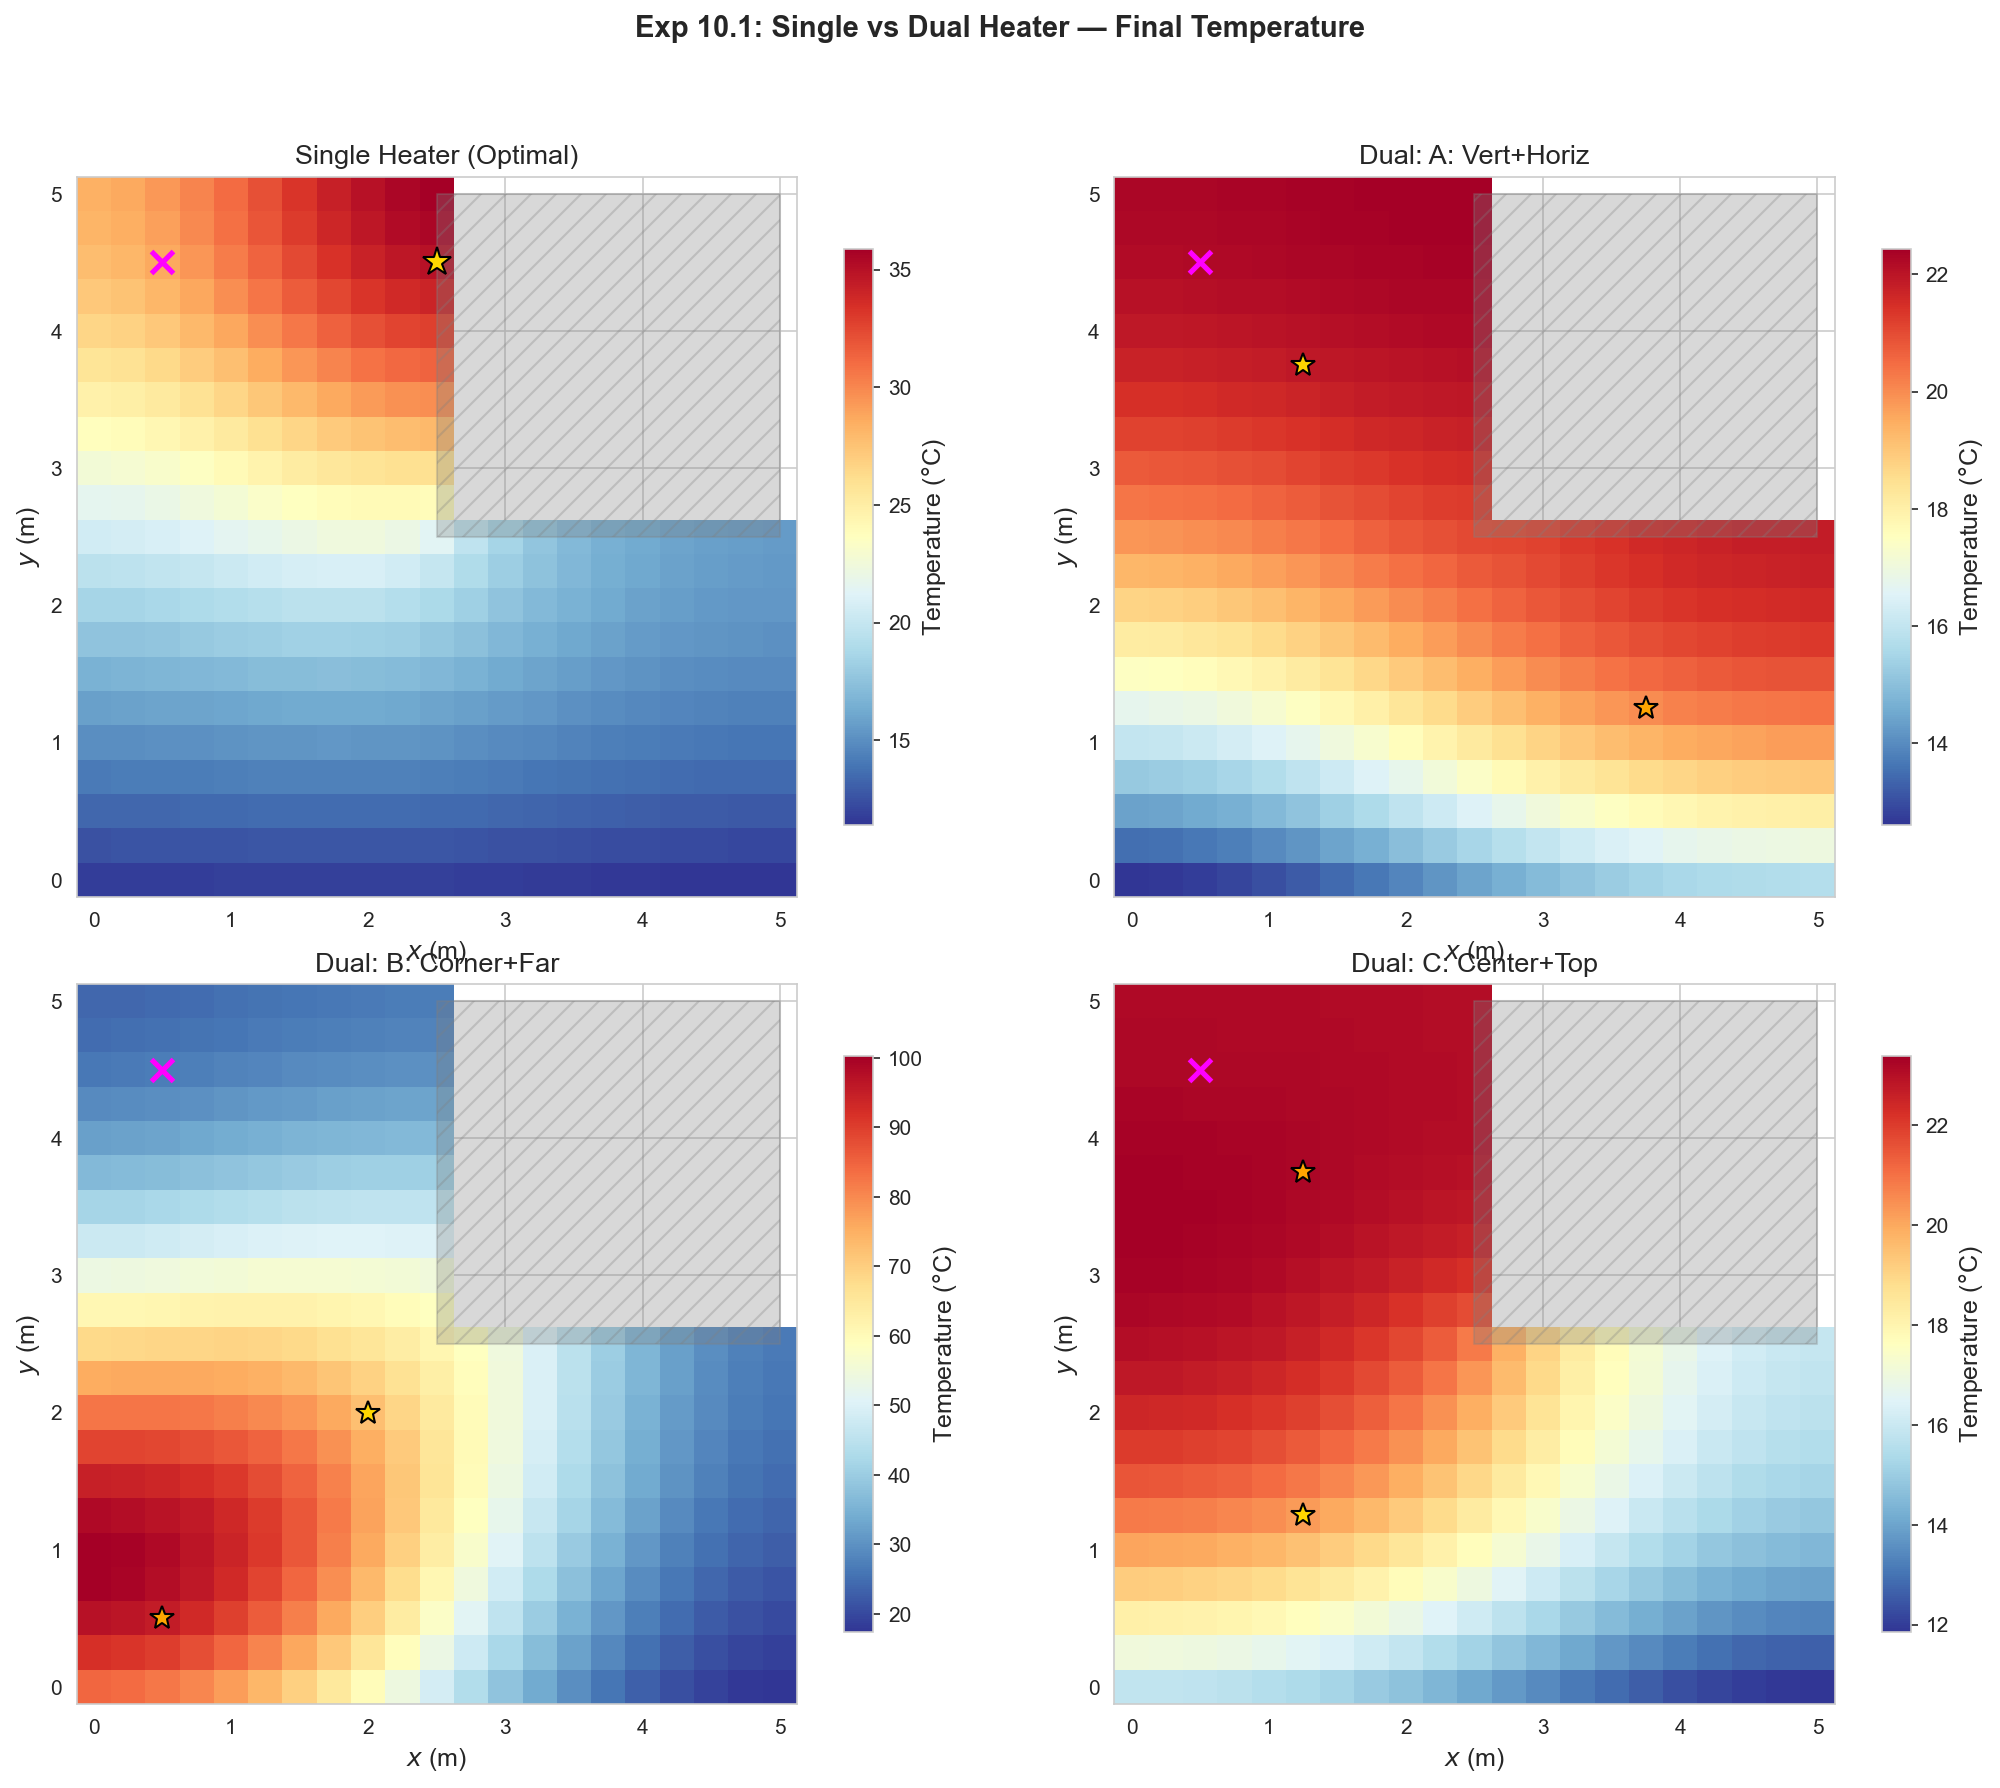

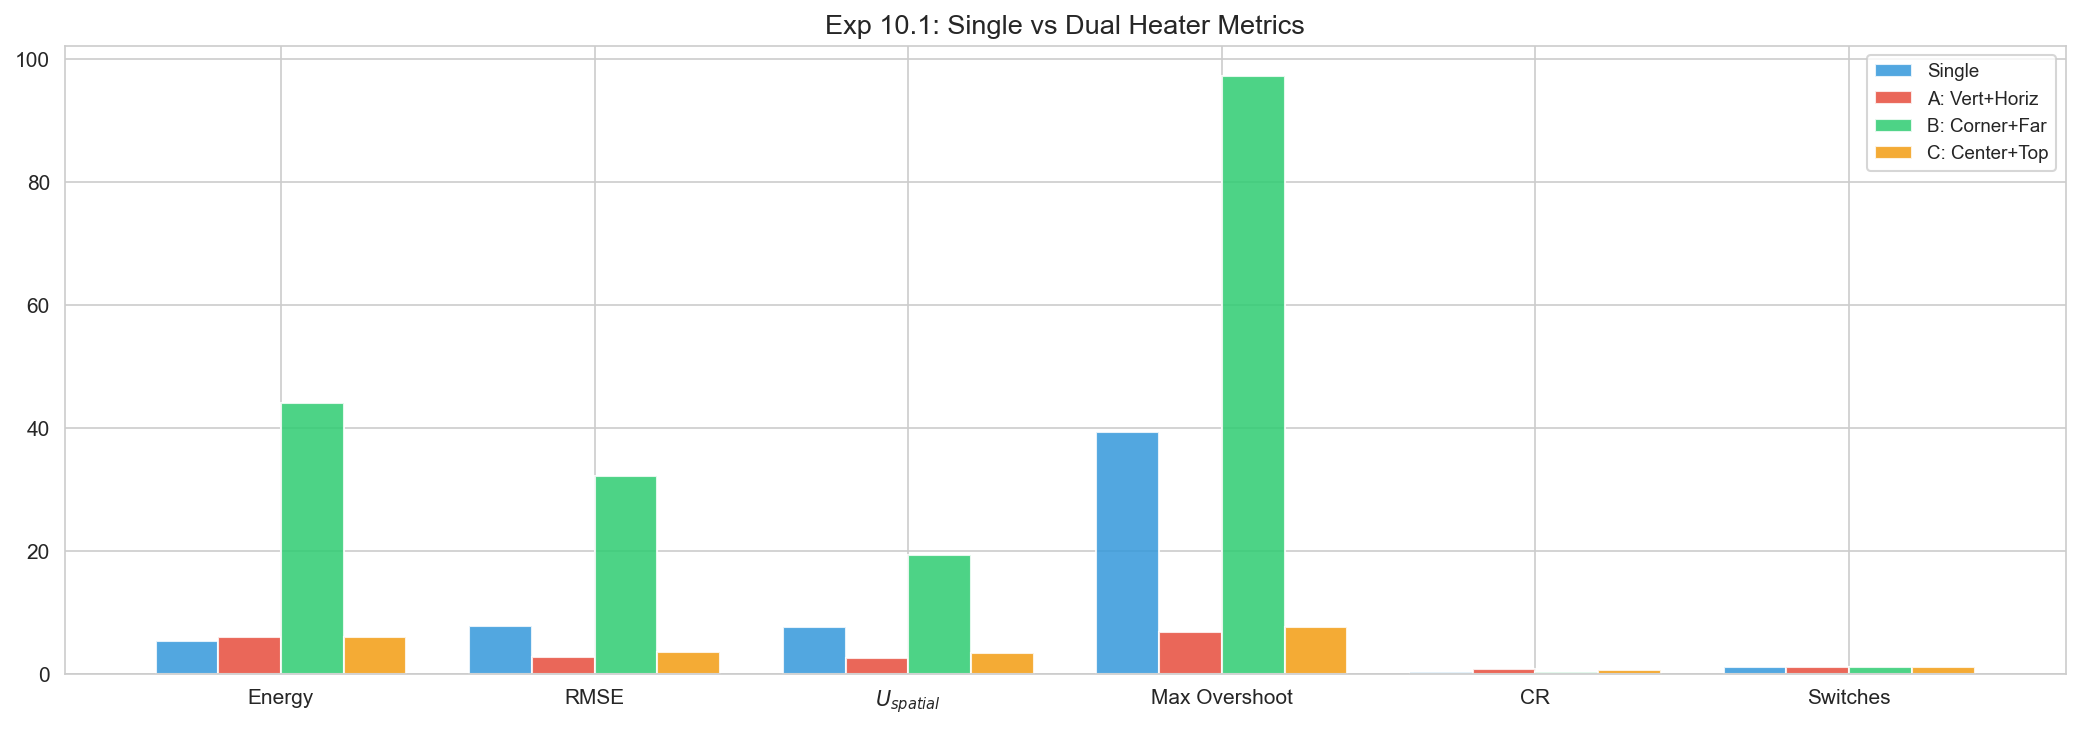

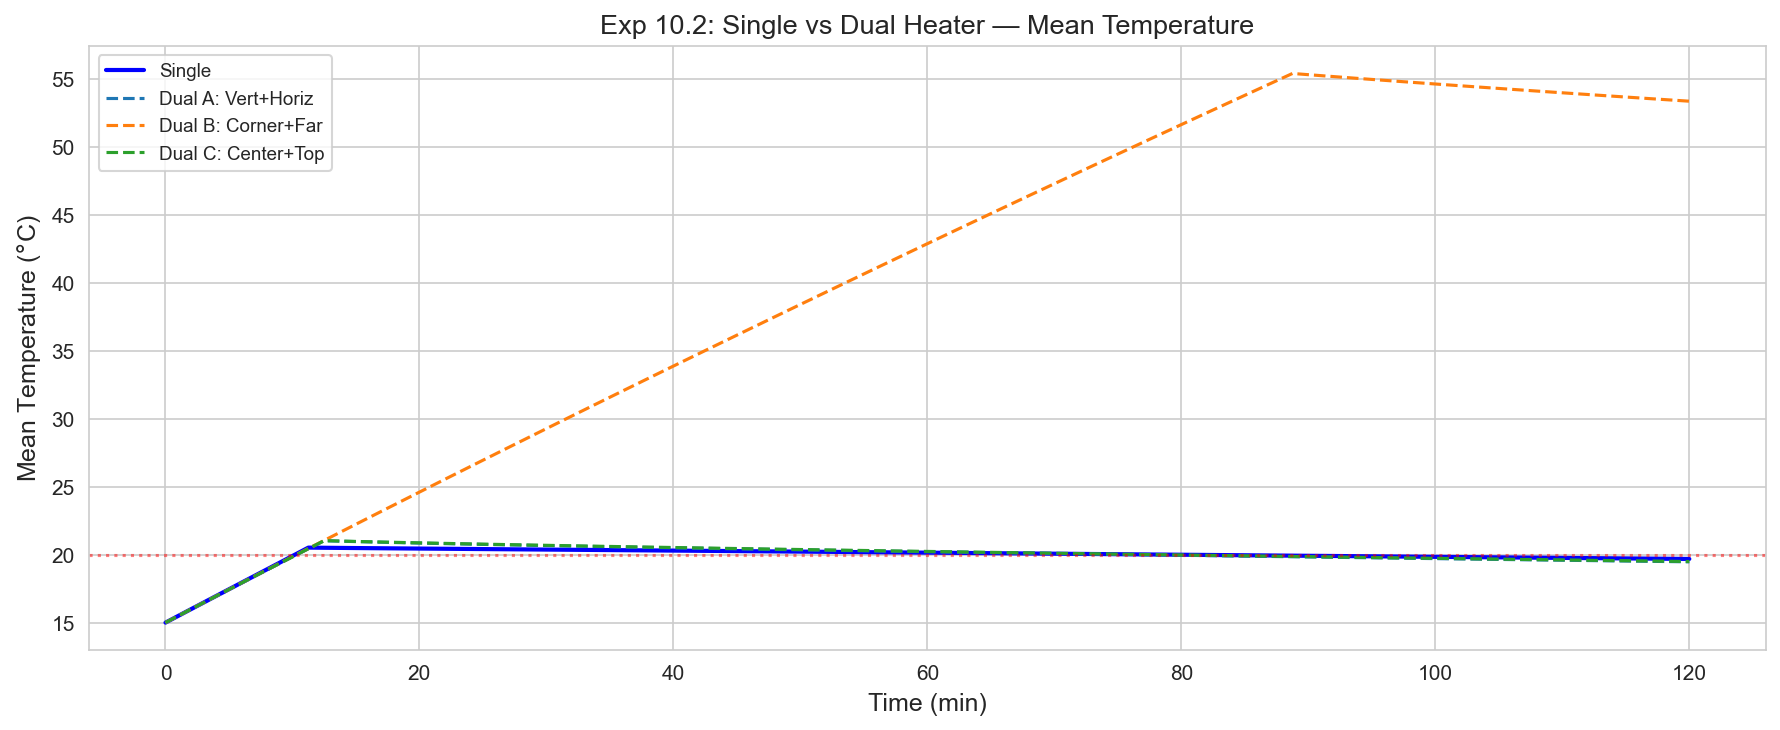

In [42]:
# ============================================================
# 实验 10.1: 单加热器 vs 双加热器方案对比
# ============================================================

# 单加热器：实验 9 的最优
sim_single = simulate_2d(
    best_L['x_h'], best_L['y_h'], best_L['x_s'], best_L['y_s'],
    geometry='L-shape', bc_type='L-RNNN', source_type='gauss', dx=0.25
)
m_single = compute_metrics_2d(sim_single)

# 双加热器方案
dual_configs = {
    'A: Vert+Horiz': ((1.25, 3.75), (3.75, 1.25)),
    'B: Corner+Far':  ((2.0, 2.0), (0.5, 0.5)),
    'C: Center+Top':  ((1.25, 1.25), (1.25, 3.75)),
}

dual_sims = {}
dual_metrics = {}
for name, ((xh1,yh1), (xh2,yh2)) in dual_configs.items():
    sim = simulate_2d_dual_heater(
        xh1, yh1, xh2, yh2, best_L['x_s'], best_L['y_s'],
        geometry='L-shape', bc_type='L-RNNN', source_type='gauss', dx=0.25
    )
    m = compute_metrics_2d(sim)
    dual_sims[name] = sim
    dual_metrics[name] = m
    print(f'{name}: RMSE={m["RMSE"]:.3f}, U={m["U_spatial"]:.3f}, E={m["E"]:.1f}')

# --- 2×2 温度场对比 ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Exp 10.1: Single vs Dual Heater — Final Temperature',
             fontsize=14, fontweight='bold')

# 单加热器
plot_2d_field(sim_single['T_final'], sim_single['x'], sim_single['y'], sim_single['mask'],
              axes[0,0], x_h=best_L['x_h'], y_h=best_L['y_h'],
              x_s=best_L['x_s'], y_s=best_L['y_s'],
              geometry='L-shape', title='Single Heater (Optimal)')

for ax, (name, sim) in zip([axes[0,1], axes[1,0], axes[1,1]], dual_sims.items()):
    (xh1,yh1), (xh2,yh2) = dual_configs[name]
    plot_2d_field(sim['T_final'], sim['x'], sim['y'], sim['mask'],
                 ax, x_s=best_L['x_s'], y_s=best_L['y_s'],
                 geometry='L-shape', title=f'Dual: {name}')
    ax.plot(xh1, yh1, '*', color='gold', markersize=12, markeredgecolor='k')
    ax.plot(xh2, yh2, '*', color='orange', markersize=12, markeredgecolor='k')

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig(f'{OUT_DIR}/2D_exp10_1_dual_fields.png', dpi=300, bbox_inches='tight')
plt.show()

# 指标对比柱状图
fig, ax = plt.subplots(figsize=(14, 5))
all_configs = {'Single': m_single, **dual_metrics}
keys = ['E', 'RMSE', 'U_spatial', 'DeltaT_max', 'CR', 'N_sw']
x_pos = np.arange(len(keys))
width = 0.2
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for i, (name, m) in enumerate(all_configs.items()):
    vals = [m[k] for k in keys]
    ax.bar(x_pos + i*width - 1.5*width, vals, width, color=colors[i],
           label=name, alpha=0.85)

ax.set_xticks(x_pos)
ax.set_xticklabels(['Energy', 'RMSE', '$U_{spatial}$', 'Max Overshoot', 'CR', 'Switches'])
ax.set_title('Exp 10.1: Single vs Dual Heater Metrics')
ax.legend()
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/2D_exp10_1_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# 单 vs 双加热器均温对比
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(sim_single['t'], sim_single['T_mean'], 'b-', linewidth=2, label='Single')
for name, sim in dual_sims.items():
    ax.plot(sim['t'], sim['T_mean'], '--', linewidth=1.5, label=f'Dual {name}')
ax.axhline(T_SET, color='red', linestyle=':', alpha=0.5)
ax.set_xlabel('Time (min)')
ax.set_ylabel('Mean Temperature ($°$C)')
ax.set_title('Exp 10.2: Single vs Dual Heater — Mean Temperature')
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/2D_exp10_2_meantemp.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
# ============================================================
# 实验 10.4: 多加热器综合结论
# ============================================================

# 所有方案的 J 值
all_metrics_10 = [m_single] + list(dual_metrics.values())
ref_10 = compute_ref_maxes(all_metrics_10)

results_10 = []
for name, m in [('Single', m_single)] + list(dual_metrics.items()):
    J = compute_unified_cost(m, ref_10)
    results_10.append({'Config': name, **{k: m[k] for k in keys}, 'J': J})

df_10 = pd.DataFrame(results_10)
print('=== 实验 10: 多加热器综合对比 ===')
display(df_10)

# J 改善百分比
J_single = df_10.loc[df_10['Config']=='Single', 'J'].values[0]
for _, row in df_10.iterrows():
    if row['Config'] != 'Single':
        improvement = (J_single - row['J']) / J_single * 100
        print(f'{row["Config"]}: J={row["J"]:.4f}, '
              f'improvement={improvement:+.1f}% vs single')

df_10.to_csv(f'{OUT_DIR}/2D_exp10_multi_heater.csv', index=False)
print('\nCSV saved.')

=== 实验 10: 多加热器综合对比 ===


Config        E       RMSE  U_spatial  DeltaT_max        CR  N_sw  \
0         Single   5.3125   7.767182   7.568129   39.360658  0.201160     1   
1  A: Vert+Horiz   5.9375   2.739440   2.525993    6.822394  0.740533     1   
2  B: Corner+Far  44.0625  32.112706  19.215467   97.200520  0.225181     1   
3  C: Center+Top   5.9375   3.536516   3.351015    7.543296  0.648973     1   

          J  
0  0.427871  
1  0.390988  
2  0.966223  
3  0.412040

A: Vert+Horiz: J=0.3910, improvement=+8.6% vs single
B: Corner+Far: J=0.9662, improvement=-125.8% vs single
C: Center+Top: J=0.4120, improvement=+3.7% vs single

CSV saved.


---

# 实验十一：参数灵敏度分析 + 控制器对比

**核心问题**：
1. 当前参数 (U_max, h_wall) 是否让系统有能力把大部分区域推入舒适区？
2. 多传感器 + PI 控制器相比单点 bang-bang 能提升多少？
3. 网格收敛性：dx=0.25 vs dx=0.5 结果差异多大？

=== 实验 11.1: U_max vs h_wall 参数灵敏度 ===


U_max sweep:   0%|          | 0/5 [00:00<?, ?it/s]

Font 'default' does not have a glyph for '\u4e0d' [U+4e0d], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u53ef' [U+53ef], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u884c' [U+884c], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u4e0d' [U+4e0d], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u53ef' [U+53ef], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u884c' [U+884c], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u4e0d' [U+4e0d], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u53ef' [U+53ef], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u884c' [U+884c], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u4e0d' [U+4e0d], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u53ef' [U+53ef], 

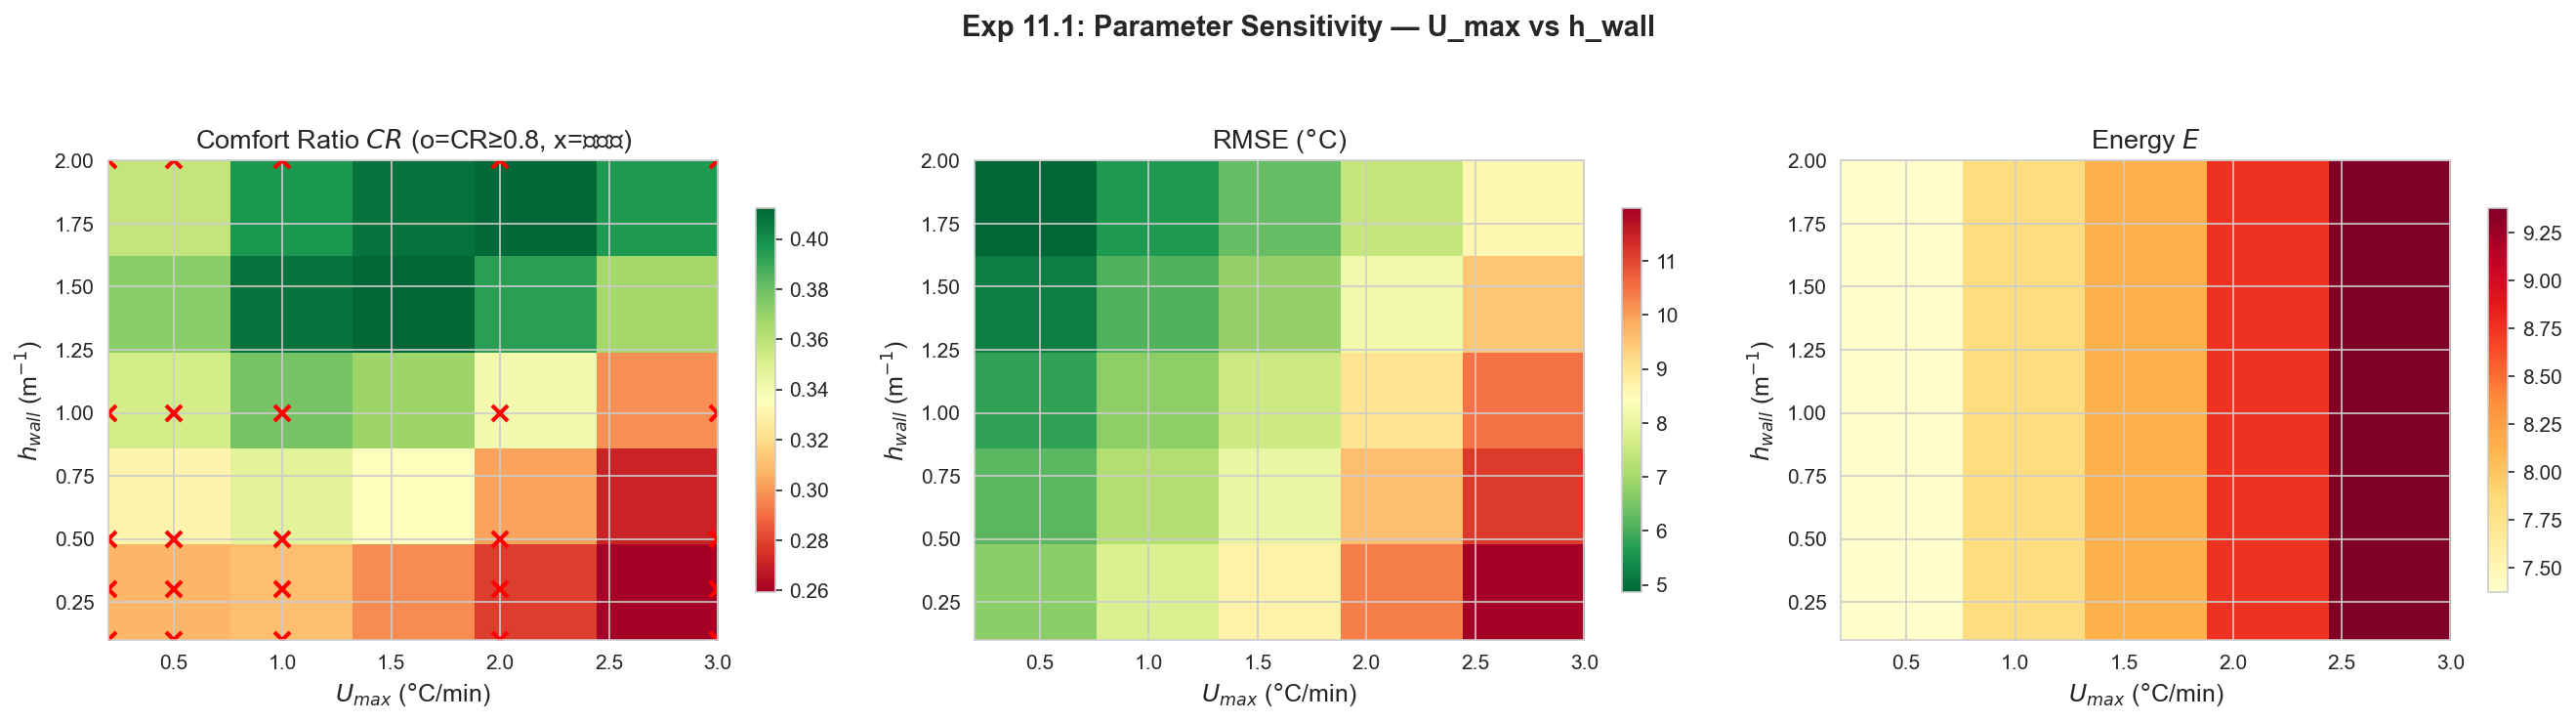


CR >= 0.8 的可行参数组合 (0/25):
  无可行解！需要增大 U_max 或降低 h_wall


In [44]:
# ============================================================
# 实验 11.1: U_max × h_wall 灵敏度扫描
# ============================================================

print('=== 实验 11.1: U_max vs h_wall 参数灵敏度 ===')

u_max_vals = [0.2, 0.5, 1.0, 2.0, 3.0]
h_wall_vals = [0.1, 0.3, 0.5, 1.0, 2.0]

# 固定位置: heater at (2.5, 0.5), sensor at (2.5, 2.5), square, RNNN
results_11 = []
for u_m in tqdm(u_max_vals, desc='U_max sweep'):
    for h_w in h_wall_vals:
        sim = simulate_2d(2.5, 0.5, 2.5, 2.5,
                          geometry='square', bc_type='RNNN',
                          source_type='gauss', dx=0.25,
                          U_max=u_m, h_wall=h_w)
        m = compute_metrics_2d(sim)
        results_11.append({
            'U_max': u_m, 'h_wall': h_w,
            **m,
            'T_mean_final': sim['T_mean'][-1],
            'T_max_final': np.nanmax(sim['T_final']),
        })

df_11 = pd.DataFrame(results_11)

# 热力图: CR vs (U_max, h_wall)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Exp 11.1: Parameter Sensitivity — U_max vs h_wall', fontsize=14, fontweight='bold')

for ax, col, title, cmap in zip(axes,
    ['CR', 'RMSE', 'E'],
    ['Comfort Ratio $CR$', 'RMSE ($°$C)', 'Energy $E$'],
    ['RdYlGn', 'RdYlGn_r', 'YlOrRd']):
    
    pivot = df_11.pivot_table(index='h_wall', columns='U_max', values=col)
    im = ax.imshow(pivot.values, origin='lower', aspect='auto', cmap=cmap,
                   extent=[min(u_max_vals), max(u_max_vals),
                           min(h_wall_vals), max(h_wall_vals)])
    plt.colorbar(im, ax=ax, shrink=0.8)
    ax.set_xlabel('$U_{max}$ ($°$C/min)')
    ax.set_ylabel('$h_{wall}$ (m$^{-1}$)')
    ax.set_title(title)
    
    # 标注 CR >= 0.8 的区域
    if col == 'CR':
        for _, row in df_11.iterrows():
            marker = 'o' if row['CR'] >= CR_MIN else 'x'
            color = 'green' if row['CR'] >= CR_MIN else 'red'
            ax.plot(row['U_max'], row['h_wall'], marker, color=color,
                    markersize=8, markeredgewidth=2)
        ax.set_title(f'{title} (o=CR≥{CR_MIN}, x=不可行)')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(f'{OUT_DIR}/2D_exp11_1_param_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印可行参数
feasible = df_11[df_11['CR'] >= CR_MIN].sort_values('E')
print(f'\nCR >= {CR_MIN} 的可行参数组合 ({len(feasible)}/{len(df_11)}):')
if len(feasible) > 0:
    print(feasible[['U_max', 'h_wall', 'CR', 'RMSE', 'E', 'U_spatial']].to_string(index=False))
else:
    print('  无可行解！需要增大 U_max 或降低 h_wall')


=== 实验 11.2: 控制器对比 ===
使用参数: U_max=0.5, h_wall=0.5


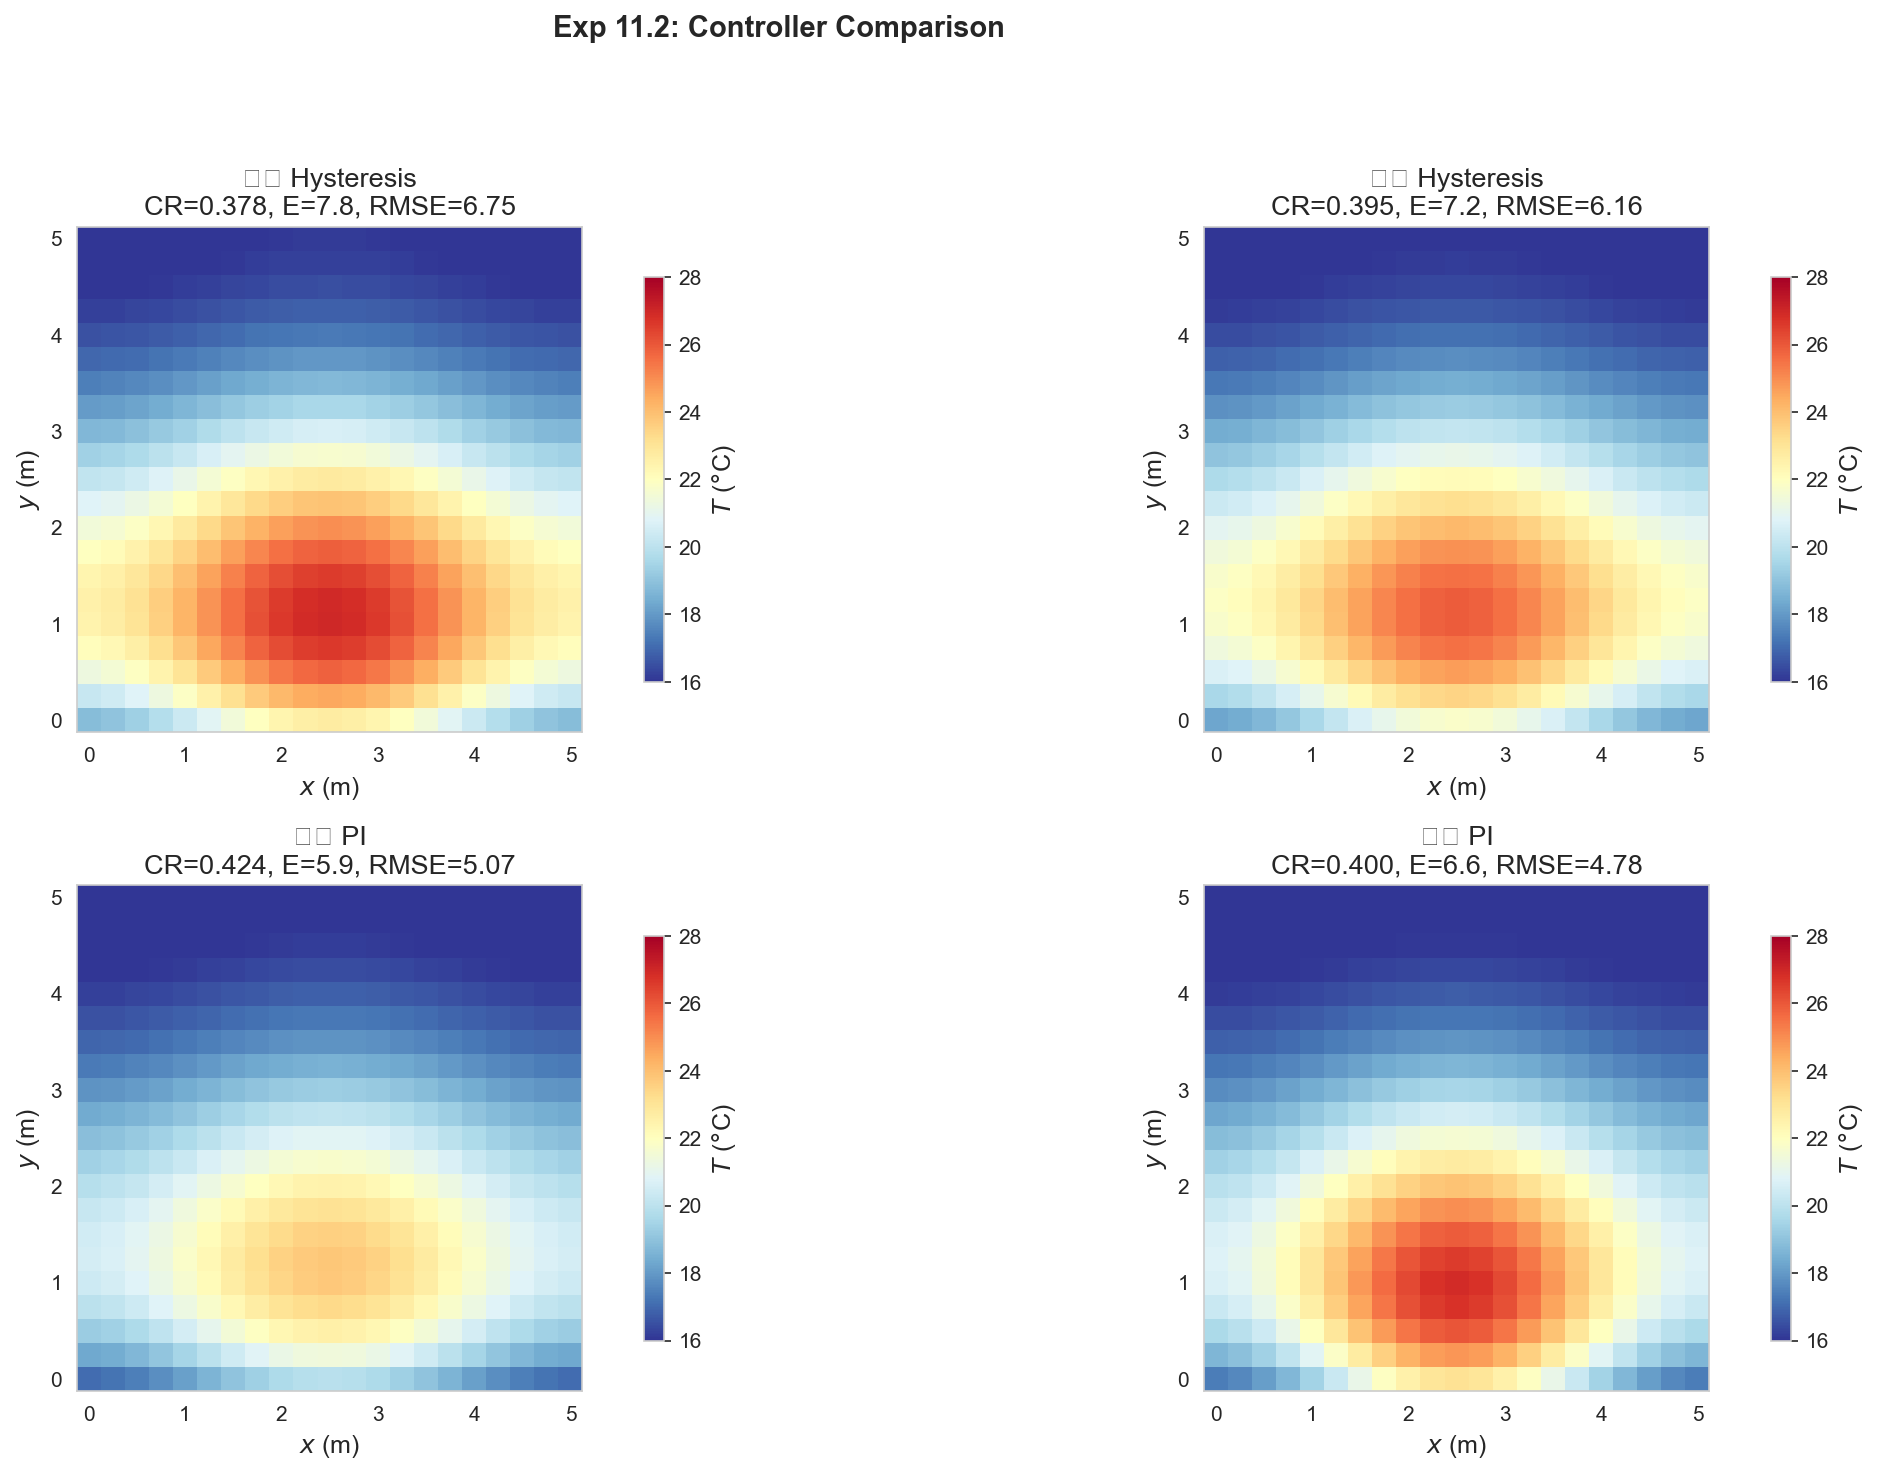


控制器对比:
         name       CR     RMSE        E  U_spatial    t_s  N_sw
单点 Hysteresis 0.377799 6.751117 7.812500   6.065790 120.00     1
多点 Hysteresis 0.394753 6.161378 7.187500   5.591534 103.75     1
        单点 PI 0.423861 5.069928 5.937500   4.634746 120.00     1
        多点 PI 0.399889 4.778643 6.600754   4.534664  10.00    46


In [45]:
# ============================================================
# 实验 11.2: 控制器对比 (单点hysteresis vs 多点PI)
# ============================================================

print('=== 实验 11.2: 控制器对比 ===')

# 使用可行参数（如果 11.1 找到了的话，否则用默认）
if len(feasible) > 0:
    u_best = feasible.iloc[0]['U_max']
    h_best = feasible.iloc[0]['h_wall']
else:
    u_best, h_best = U_MAX, H_WALL

print(f'使用参数: U_max={u_best}, h_wall={h_best}')

# 4 种控制方案
sensor_multi = default_sensor_points('square', n=5)
configs = [
    ('单点 Hysteresis', 'hysteresis', None),
    ('多点 Hysteresis', 'hysteresis', sensor_multi),
    ('单点 PI', 'PI', None),
    ('多点 PI', 'PI', sensor_multi),
]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Exp 11.2: Controller Comparison', fontsize=14, fontweight='bold')

ctrl_metrics = []
for (name, ctrl, spts), ax in zip(configs, axes.flat):
    sim = simulate_2d(2.5, 0.5, 2.5, 2.5,
                      geometry='square', bc_type='RNNN',
                      source_type='gauss', dx=0.25,
                      controller=ctrl, sensor_points=spts,
                      U_max=u_best, h_wall=h_best,
                      return_field=True)
    m = compute_metrics_2d(sim)
    ctrl_metrics.append({'name': name, **m})
    
    # 画温度场
    T_plot = sim['T_final'].copy()
    im = ax.pcolormesh(sim['x'], sim['y'], T_plot,
                       cmap='RdYlBu_r', shading='auto',
                       vmin=T_COMFORT_LOW-2, vmax=T_COMFORT_HIGH+2)
    plt.colorbar(im, ax=ax, label='$T$ ($°$C)', shrink=0.8)
    ax.set_title(f'{name}\nCR={m["CR"]:.3f}, E={m["E"]:.1f}, RMSE={m["RMSE"]:.2f}')
    ax.set_aspect('equal')
    ax.set_xlabel('$x$ (m)')
    ax.set_ylabel('$y$ (m)')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(f'{OUT_DIR}/2D_exp11_2_controller_compare.png', dpi=300, bbox_inches='tight')
plt.show()

# 指标对比表
df_ctrl = pd.DataFrame(ctrl_metrics)
print('\n控制器对比:')
print(df_ctrl[['name', 'CR', 'RMSE', 'E', 'U_spatial', 't_s', 'N_sw']].to_string(index=False))


=== 实验 11.3: 网格收敛性 ===
  Running dx=0.5...
    Grid 11x11, N_t=25, CR=0.3678, RMSE=5.3816
  Running dx=0.25...
    Grid 21x21, N_t=97, CR=0.3999, RMSE=4.7786
  Running dx=0.125...
    Grid 41x41, N_t=385, CR=0.4081, RMSE=4.7125

网格收敛性:
   dx  Nx  Ny  N_t       CR     RMSE        E  U_spatial     t_s
0.500  11  11   25 0.367813 5.381554 6.039935   5.097058 105.000
0.250  21  21   97 0.399889 4.778643 6.600754   4.534664  10.000
0.125  41  41  385 0.408102 4.712457 6.821594   4.472981   9.375


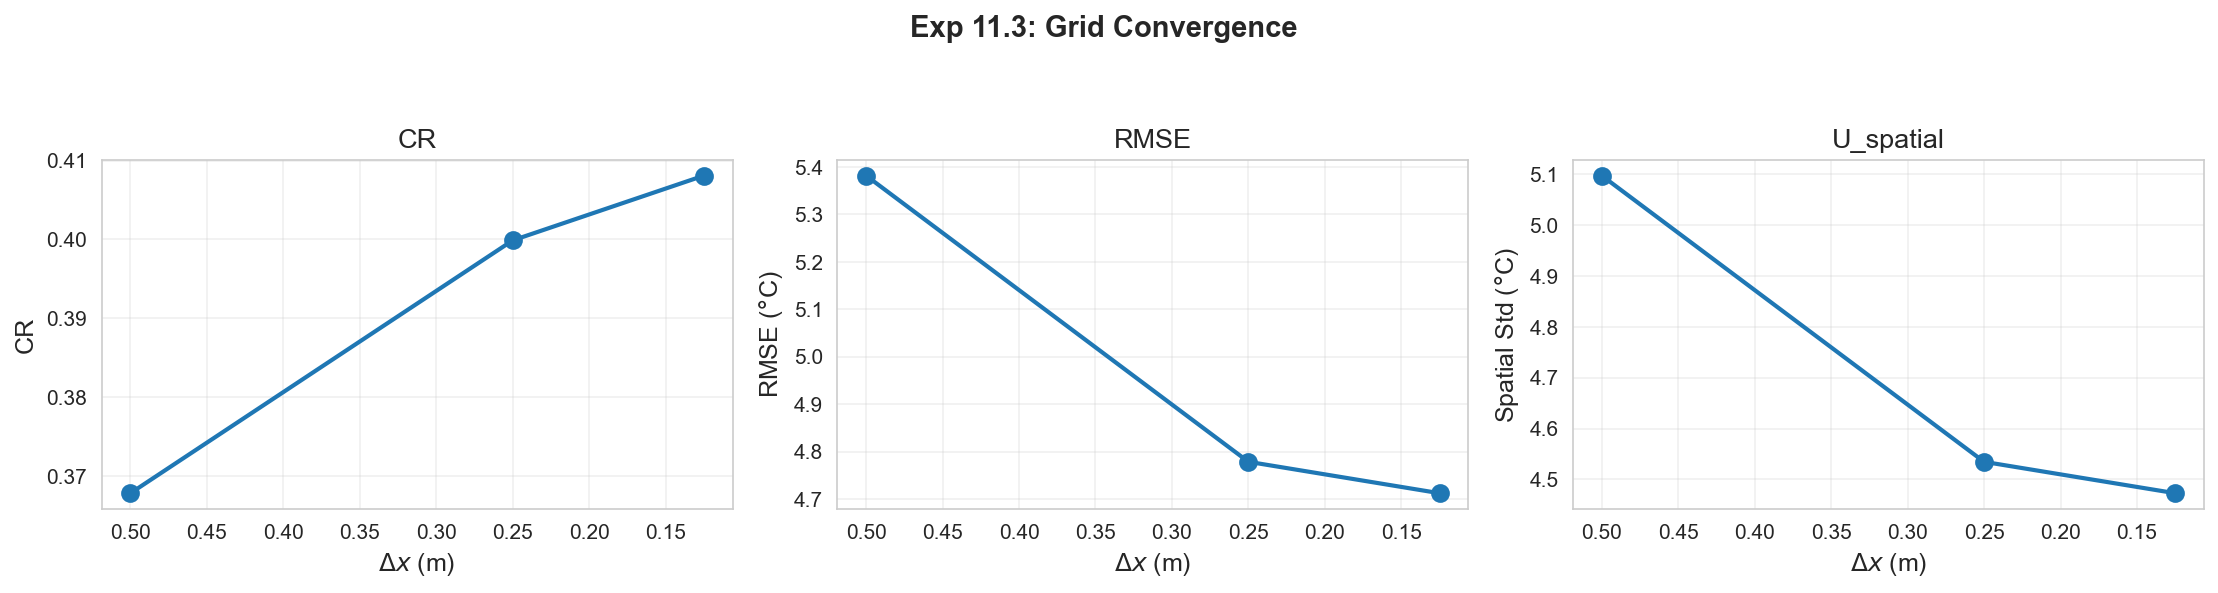

Grid convergence results saved.


In [46]:
# ============================================================
# 实验 11.3: 网格收敛性检验 (dx=0.5 vs 0.25 vs 0.125)
# ============================================================

print('=== 实验 11.3: 网格收敛性 ===')

dx_vals = [0.5, 0.25, 0.125]
grid_results = []

for dx_val in dx_vals:
    print(f'  Running dx={dx_val}...')
    sim = simulate_2d(2.5, 0.5, 2.5, 2.5,
                      geometry='square', bc_type='RNNN',
                      source_type='gauss', dx=dx_val,
                      U_max=u_best, h_wall=h_best,
                      controller='PI', sensor_points=sensor_multi,
                      return_field=True)
    m = compute_metrics_2d(sim)
    grid_results.append({
        'dx': dx_val,
        'Nx': len(sim['x']),
        'Ny': len(sim['y']),
        'N_t': len(sim['t']),
        **m,
        'T_mean_final': sim['T_mean'][-1],
    })
    print(f'    Grid {len(sim["x"])}x{len(sim["y"])}, '
          f'N_t={len(sim["t"])}, CR={m["CR"]:.4f}, RMSE={m["RMSE"]:.4f}')

df_grid = pd.DataFrame(grid_results)
print('\n网格收敛性:')
print(df_grid[['dx', 'Nx', 'Ny', 'N_t', 'CR', 'RMSE', 'E', 'U_spatial', 't_s']].to_string(index=False))

# 收敛图
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Exp 11.3: Grid Convergence', fontsize=14, fontweight='bold')
for ax, col, ylabel in zip(axes,
    ['CR', 'RMSE', 'U_spatial'],
    ['CR', 'RMSE ($°$C)', 'Spatial Std ($°$C)']):
    ax.plot(df_grid['dx'], df_grid[col], 'o-', linewidth=2, markersize=8)
    ax.set_xlabel('$\\Delta x$ (m)')
    ax.set_ylabel(ylabel)
    ax.set_title(col)
    ax.invert_xaxis()
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(f'{OUT_DIR}/2D_exp11_3_grid_convergence.png', dpi=300, bbox_inches='tight')
plt.show()

df_grid.to_csv(f'{OUT_DIR}/2D_exp11_grid_convergence.csv', index=False)
print('Grid convergence results saved.')


---

## 总结

### 正方形房间（实验 1-6）

- **加热器位置**：靠近外墙（补偿散热）通常优于远离外墙的位置
- **恒温器位置**：不应放在加热器旁边，应放在能代表全域均温的位置
- **热源类型**：高斯热源比点热源产生更均匀的温度分布
- **边界条件**：RRRR（四面外墙）比 RNNN（一面外墙）需要更多能耗

### 几何对比（实验 7）

- 矩形比正方形更难均匀加热（长宽比效应）
- L 形比等面积矩形更难控制（非凸域效应）

### L 形房间专题（实验 8-10）

- **死角问题**：L 形拐角区域温度滞后，可能长期处于不舒适温度
- **最优位置**：加热器倾向于放在 L 形中心区域以平衡两个臂
- **多加热器**：双加热器可以改善温度均匀度，尤其是分别覆盖两个臂时

### 关键发现

1. 房间几何显著影响控制性能和最优配置
2. 非凸域（L 形）需要特殊的加热策略
3. 多加热器是解决非凸域温度不均匀的有效手段